## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [20]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 9)
z_max = np.linspace(0.2, 1.0, num = 9)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [21]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)

In [22]:
N_countsSimulator.N_counts

array([2.01375933e+04, 4.21819225e+04, 6.15932449e+04, 7.42789101e+04,
       7.92155533e+04, 7.73349713e+04, 7.05138175e+04, 6.08214612e+04,
       5.00615557e+04, 2.66747919e+03, 4.92190805e+03, 6.24078572e+03,
       6.45463132e+03, 5.83486556e+03, 4.77435379e+03, 3.60888575e+03,
       2.55307769e+03, 1.70548356e+03, 1.21730998e+02, 1.79035710e+02,
       1.76398359e+02, 1.38638874e+02, 9.32196154e+01, 5.55529414e+01,
       2.99497101e+01, 1.47992319e+01, 6.76248388e+00])

In [24]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 4.21819225e+04, 6.15932449e+04, 7.42789101e+04,
       7.92155533e+04, 7.73349713e+04, 7.05138175e+04, 6.08214612e+04,
       5.00615557e+04, 2.66747919e+03, 4.92190805e+03, 6.24078572e+03,
       6.45463132e+03, 5.83486556e+03, 4.77435379e+03, 3.60888575e+03,
       2.55307769e+03, 1.70548356e+03, 1.21730998e+02, 1.79035710e+02,
       1.76398359e+02, 1.38638874e+02, 9.32196154e+01, 5.55529414e+01,
       2.99497101e+01, 1.47992319e+01, 6.76248388e+00])

## Set up simulator

In [25]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [26]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [27]:
#N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data =  N_countsSimulator.N_counts
N_counts_data

array([2.01375933e+04, 4.21819225e+04, 6.15932449e+04, 7.42789101e+04,
       7.92155533e+04, 7.73349713e+04, 7.05138175e+04, 6.08214612e+04,
       5.00615557e+04, 2.66747919e+03, 4.92190805e+03, 6.24078572e+03,
       6.45463132e+03, 5.83486556e+03, 4.77435379e+03, 3.60888575e+03,
       2.55307769e+03, 1.70548356e+03, 1.21730998e+02, 1.79035710e+02,
       1.76398359e+02, 1.38638874e+02, 9.32196154e+01, 5.55529414e+01,
       2.99497101e+01, 1.47992319e+01, 6.76248388e+00])

In [28]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

2
27


In [29]:
Finv = np.array([[ 4.17113387e-07, -5.17948519e-07],[-5.17948519e-07,  7.73183807e-07]])

## Define ensemble of NDEs

In [30]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2)]



## Create DELFI object

In [31]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs,
                            Finv = Finv,
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_fiducial_fisher_trial_for_mocks/")

## Sequential Neural Likelihood

In [32]:
n_initial = 100
n_batch = 100 
n_populations = 40 

Sampling approximate posterior...


Done.
Removed no burn in


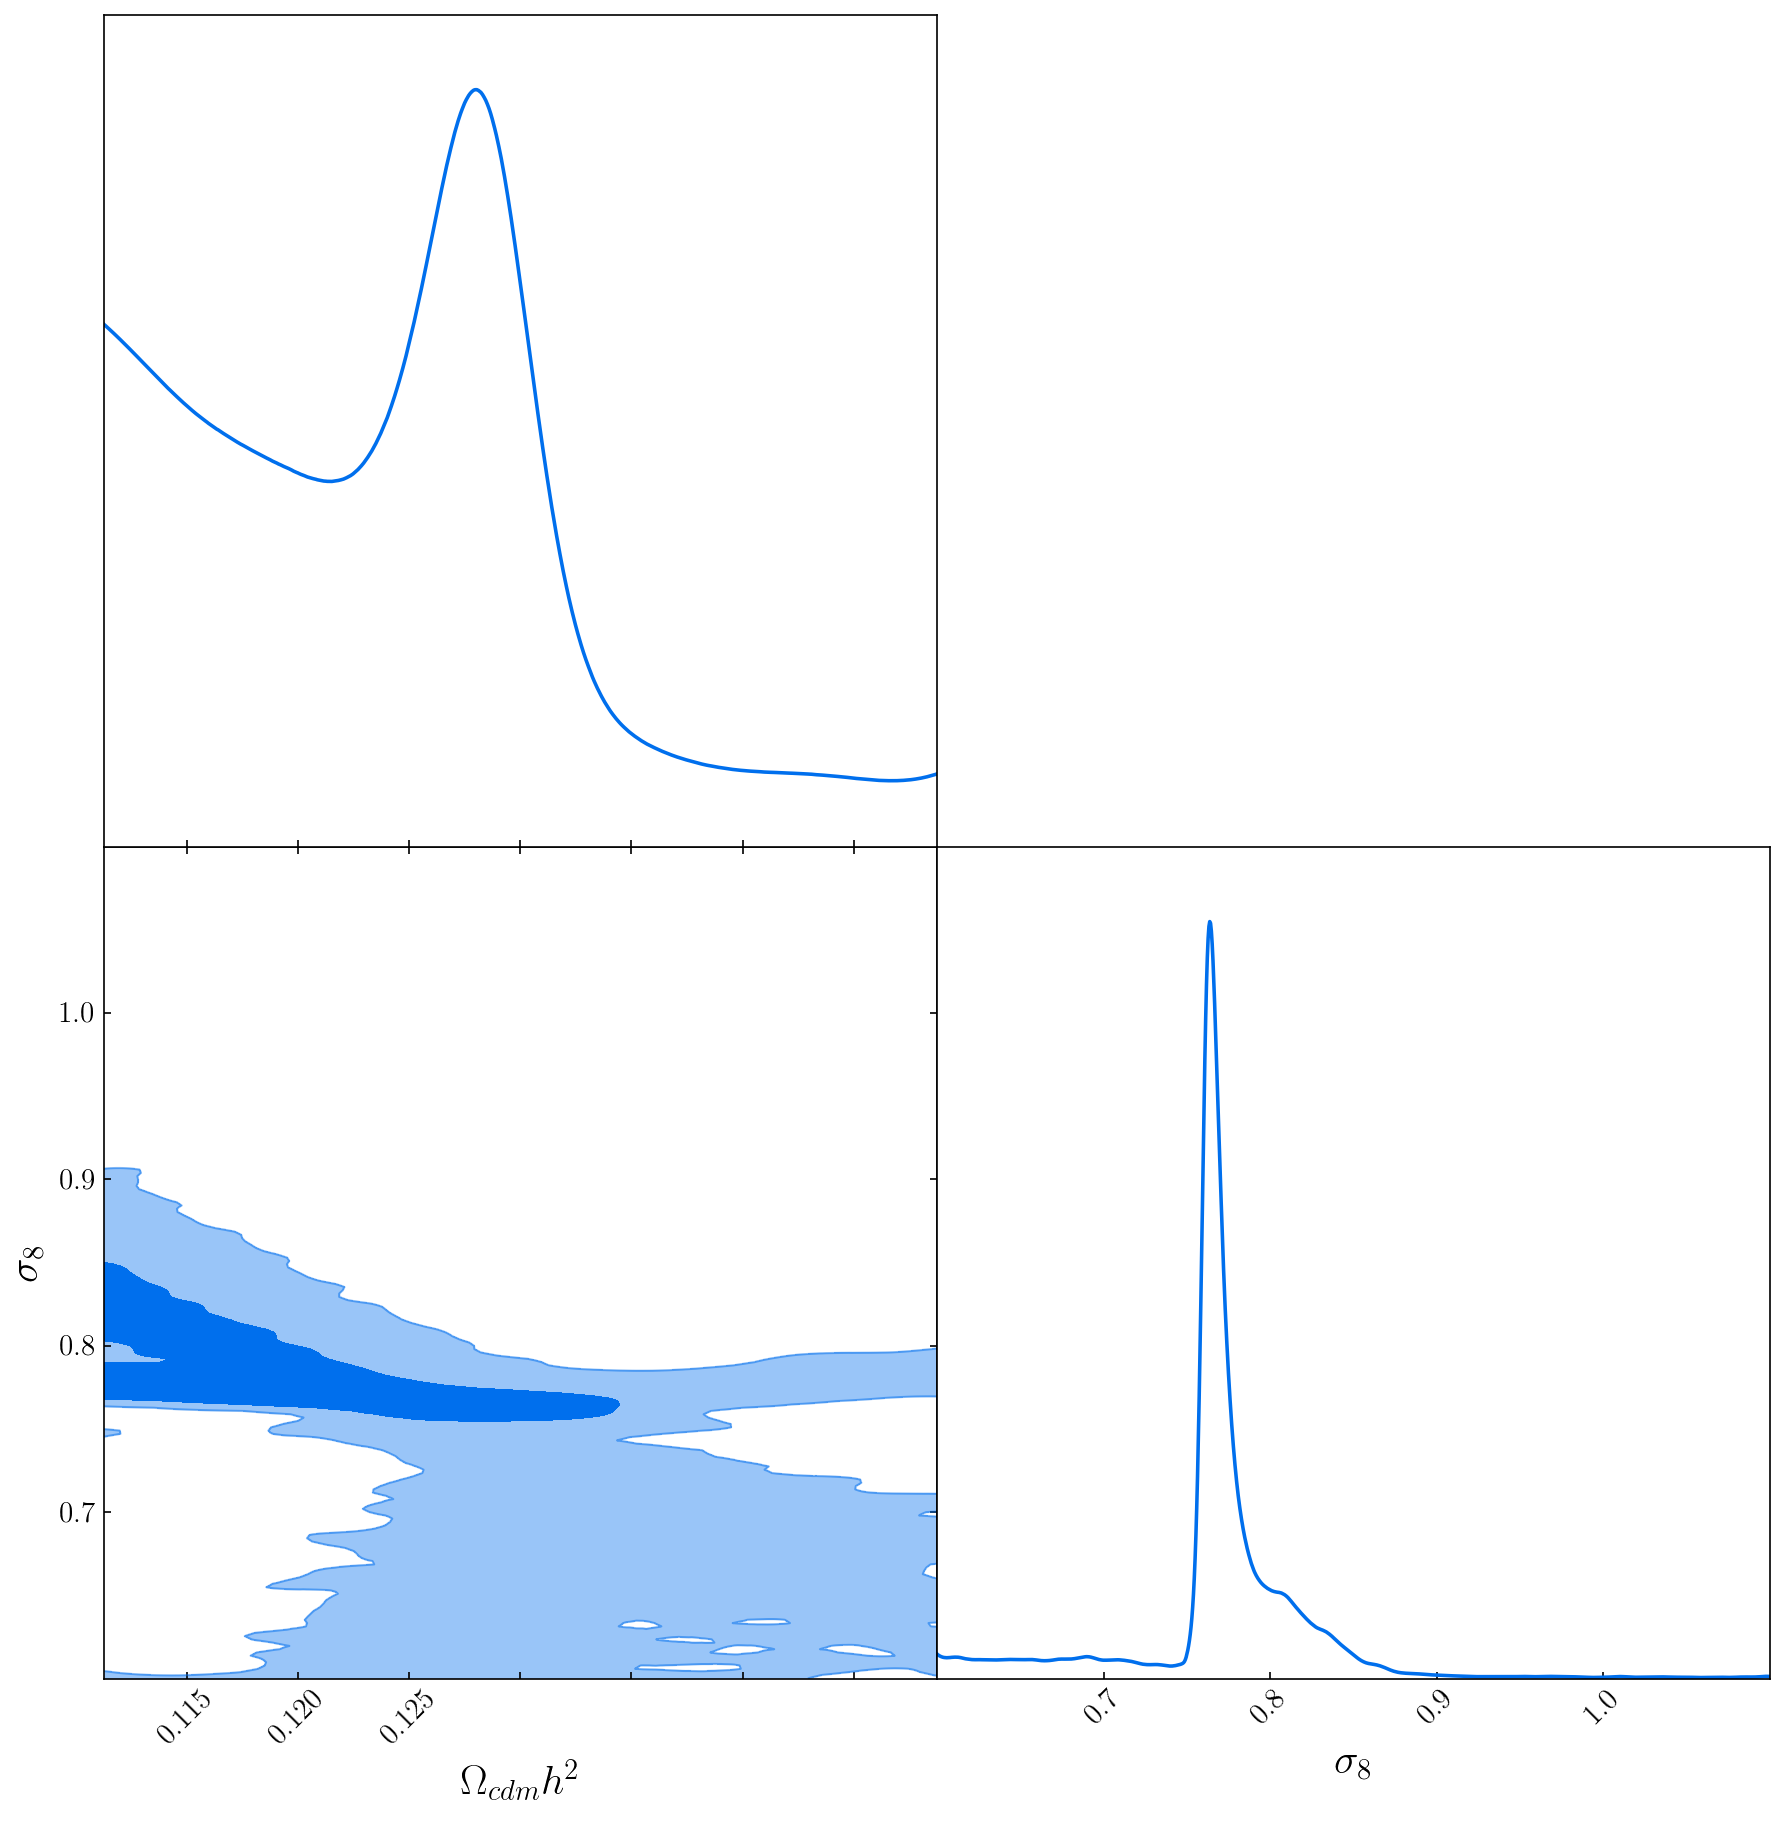

Population 1/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


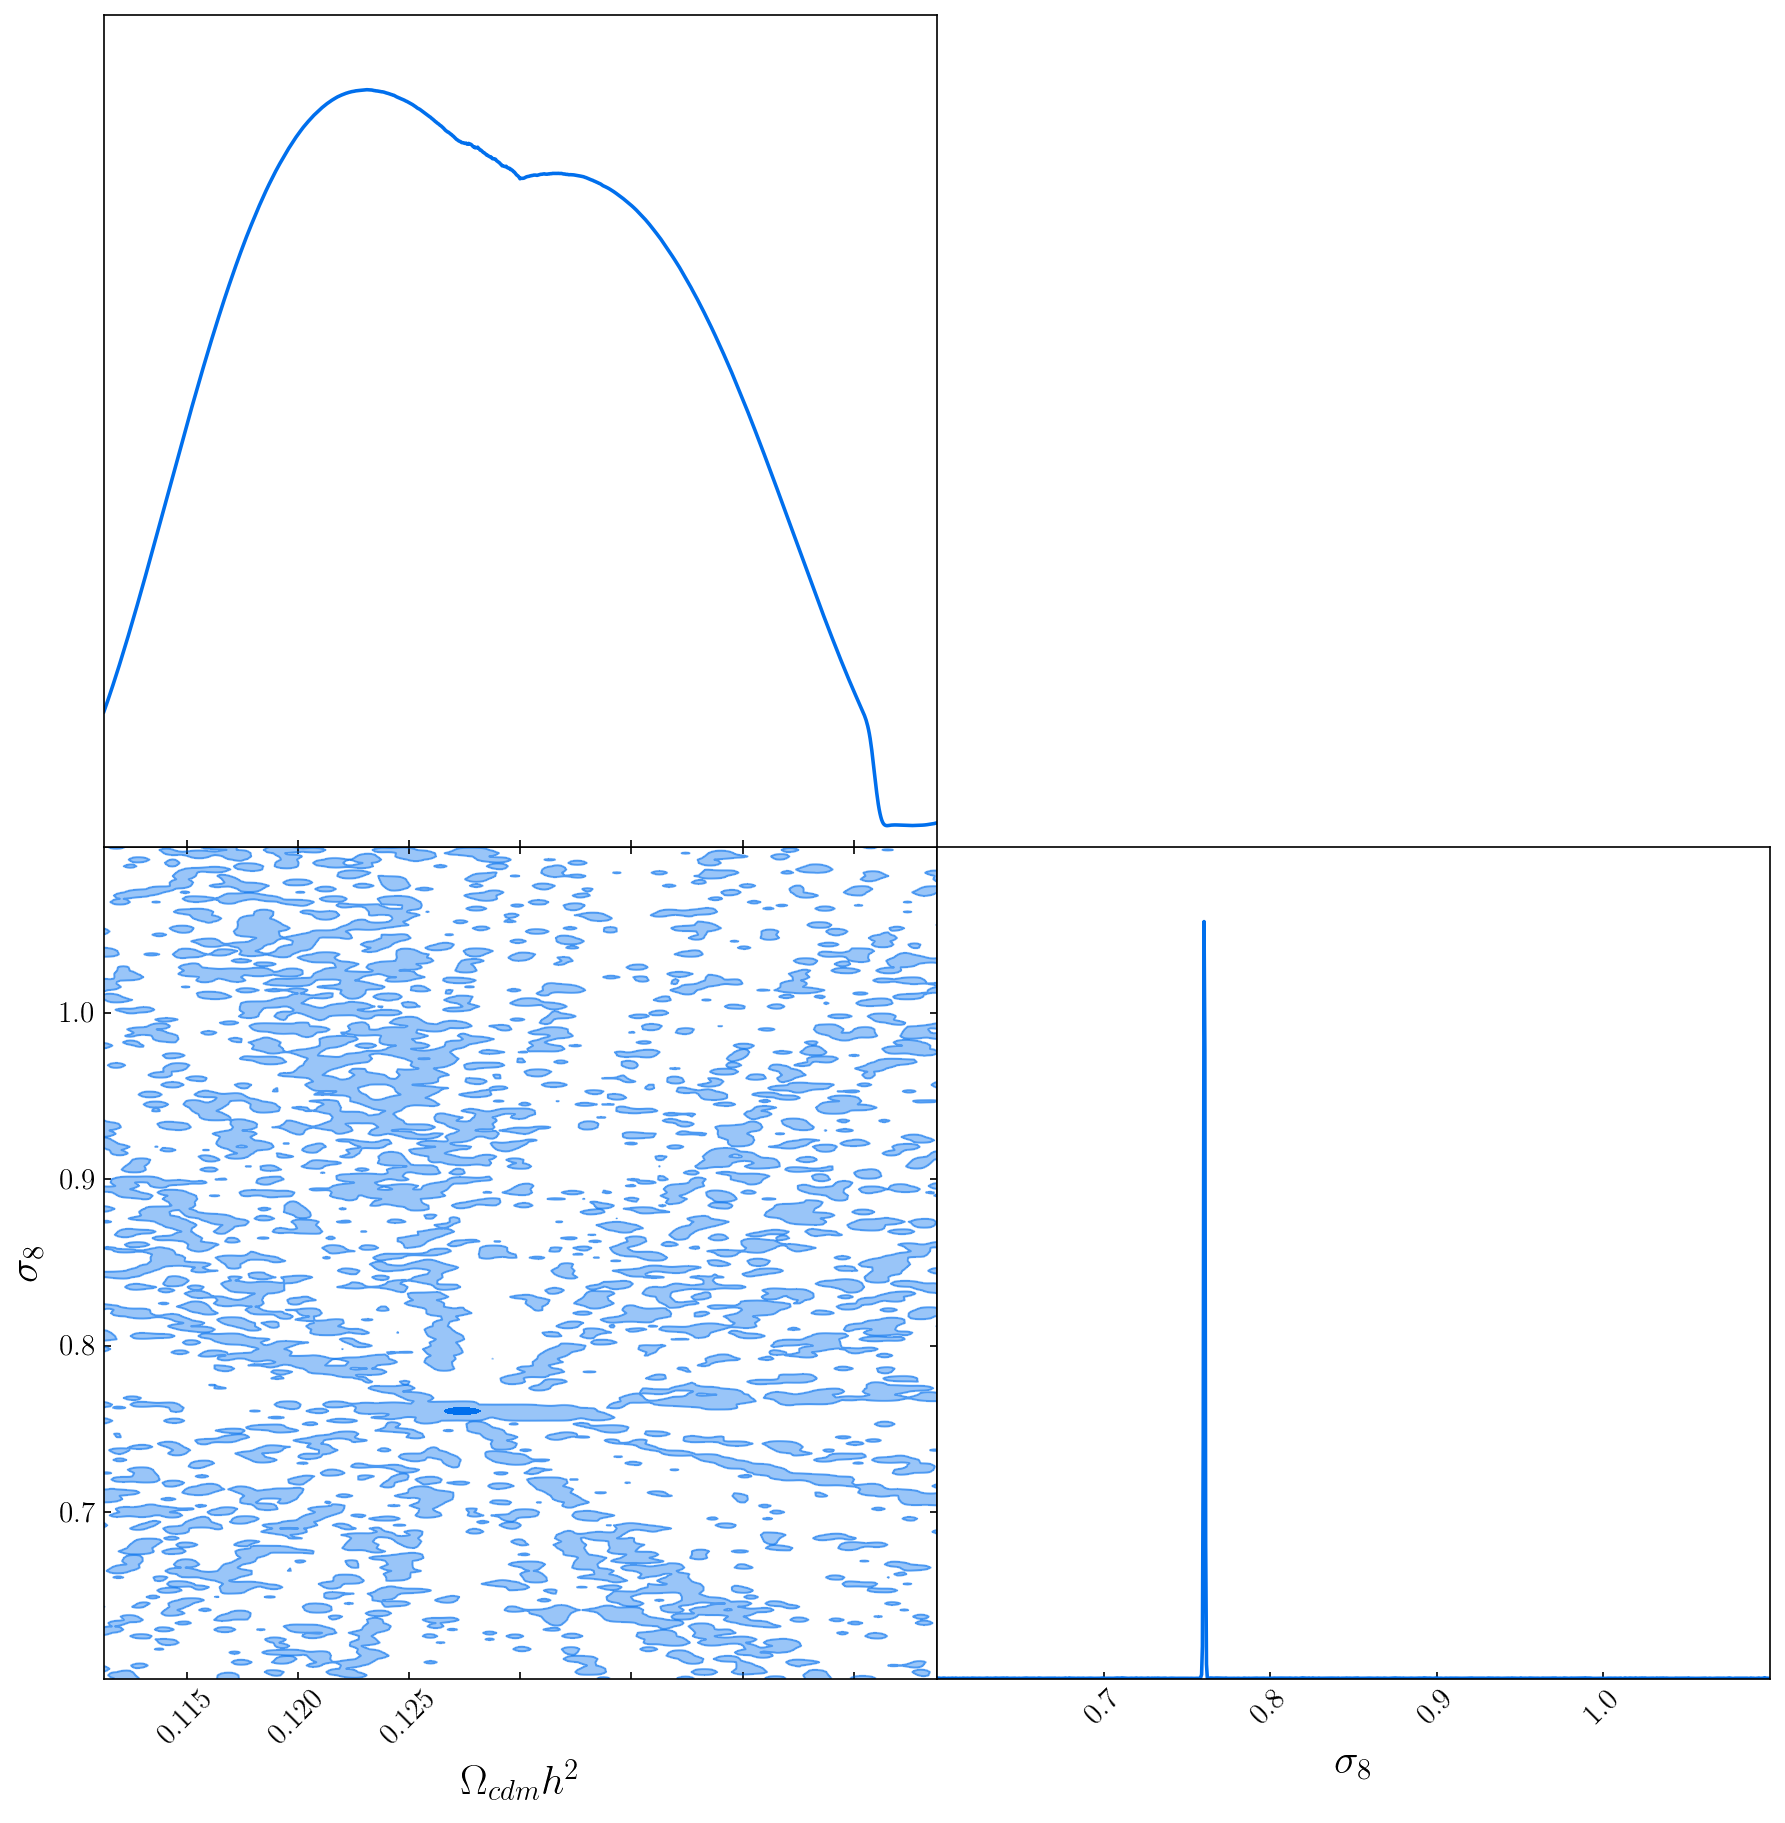

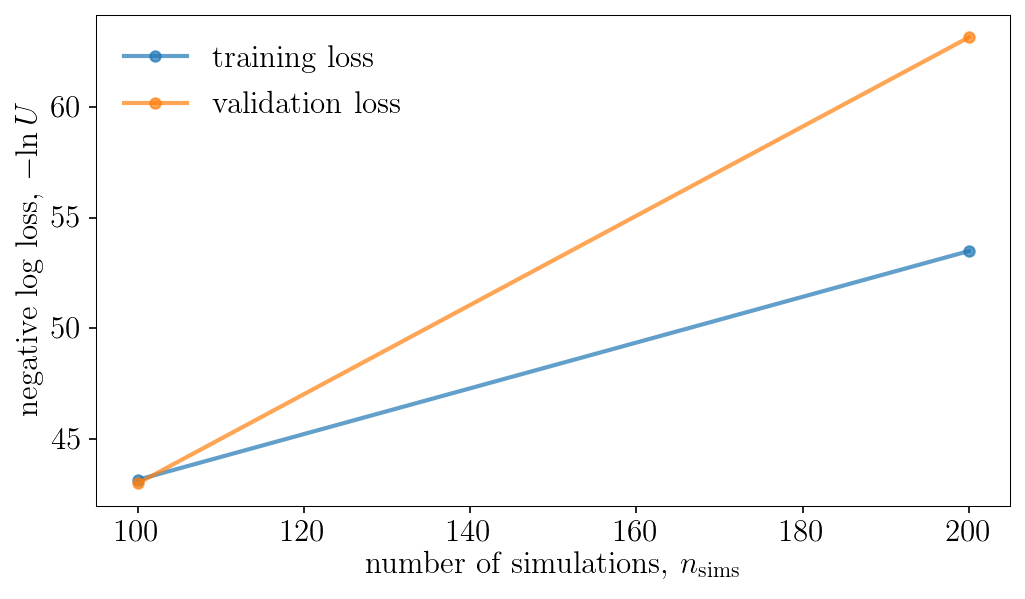

Population 2/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


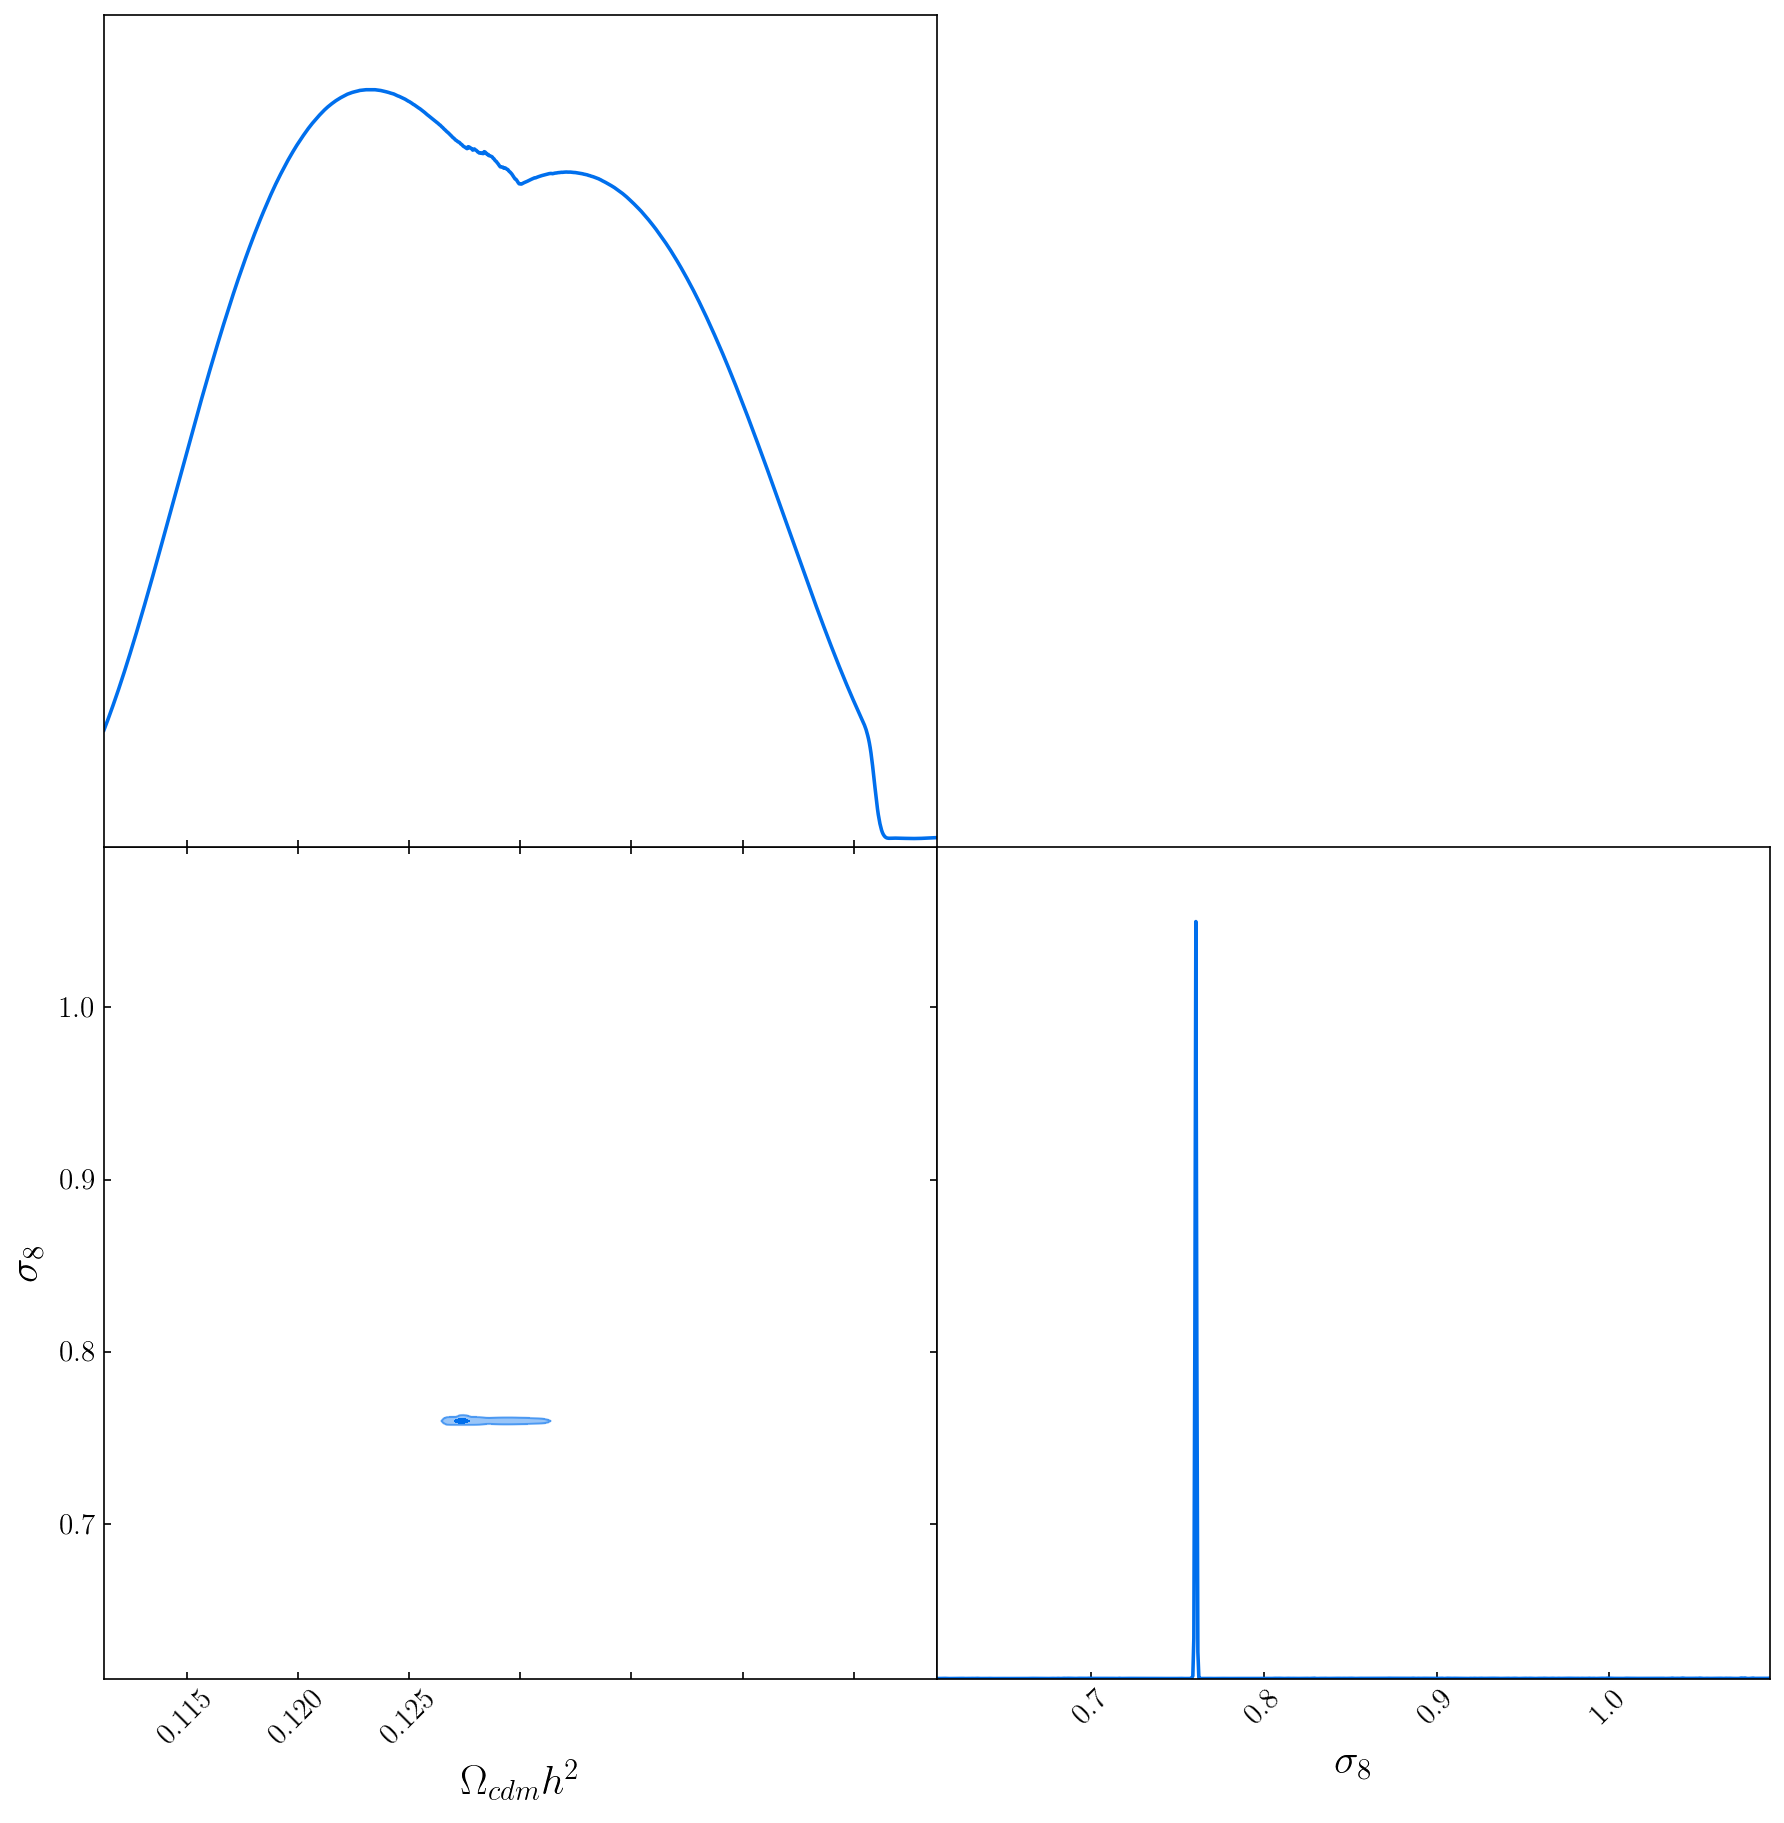

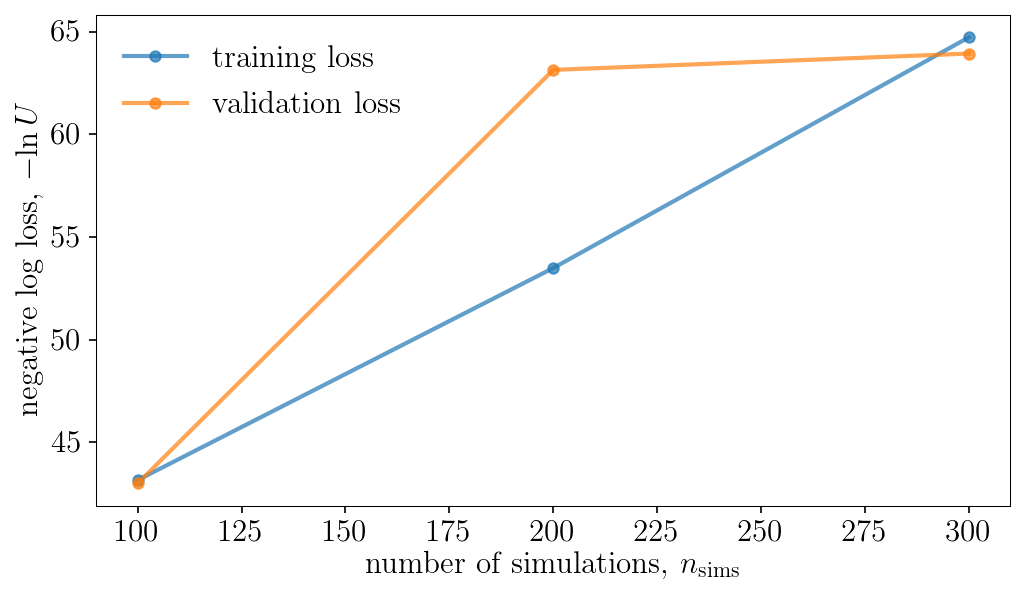

Population 3/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


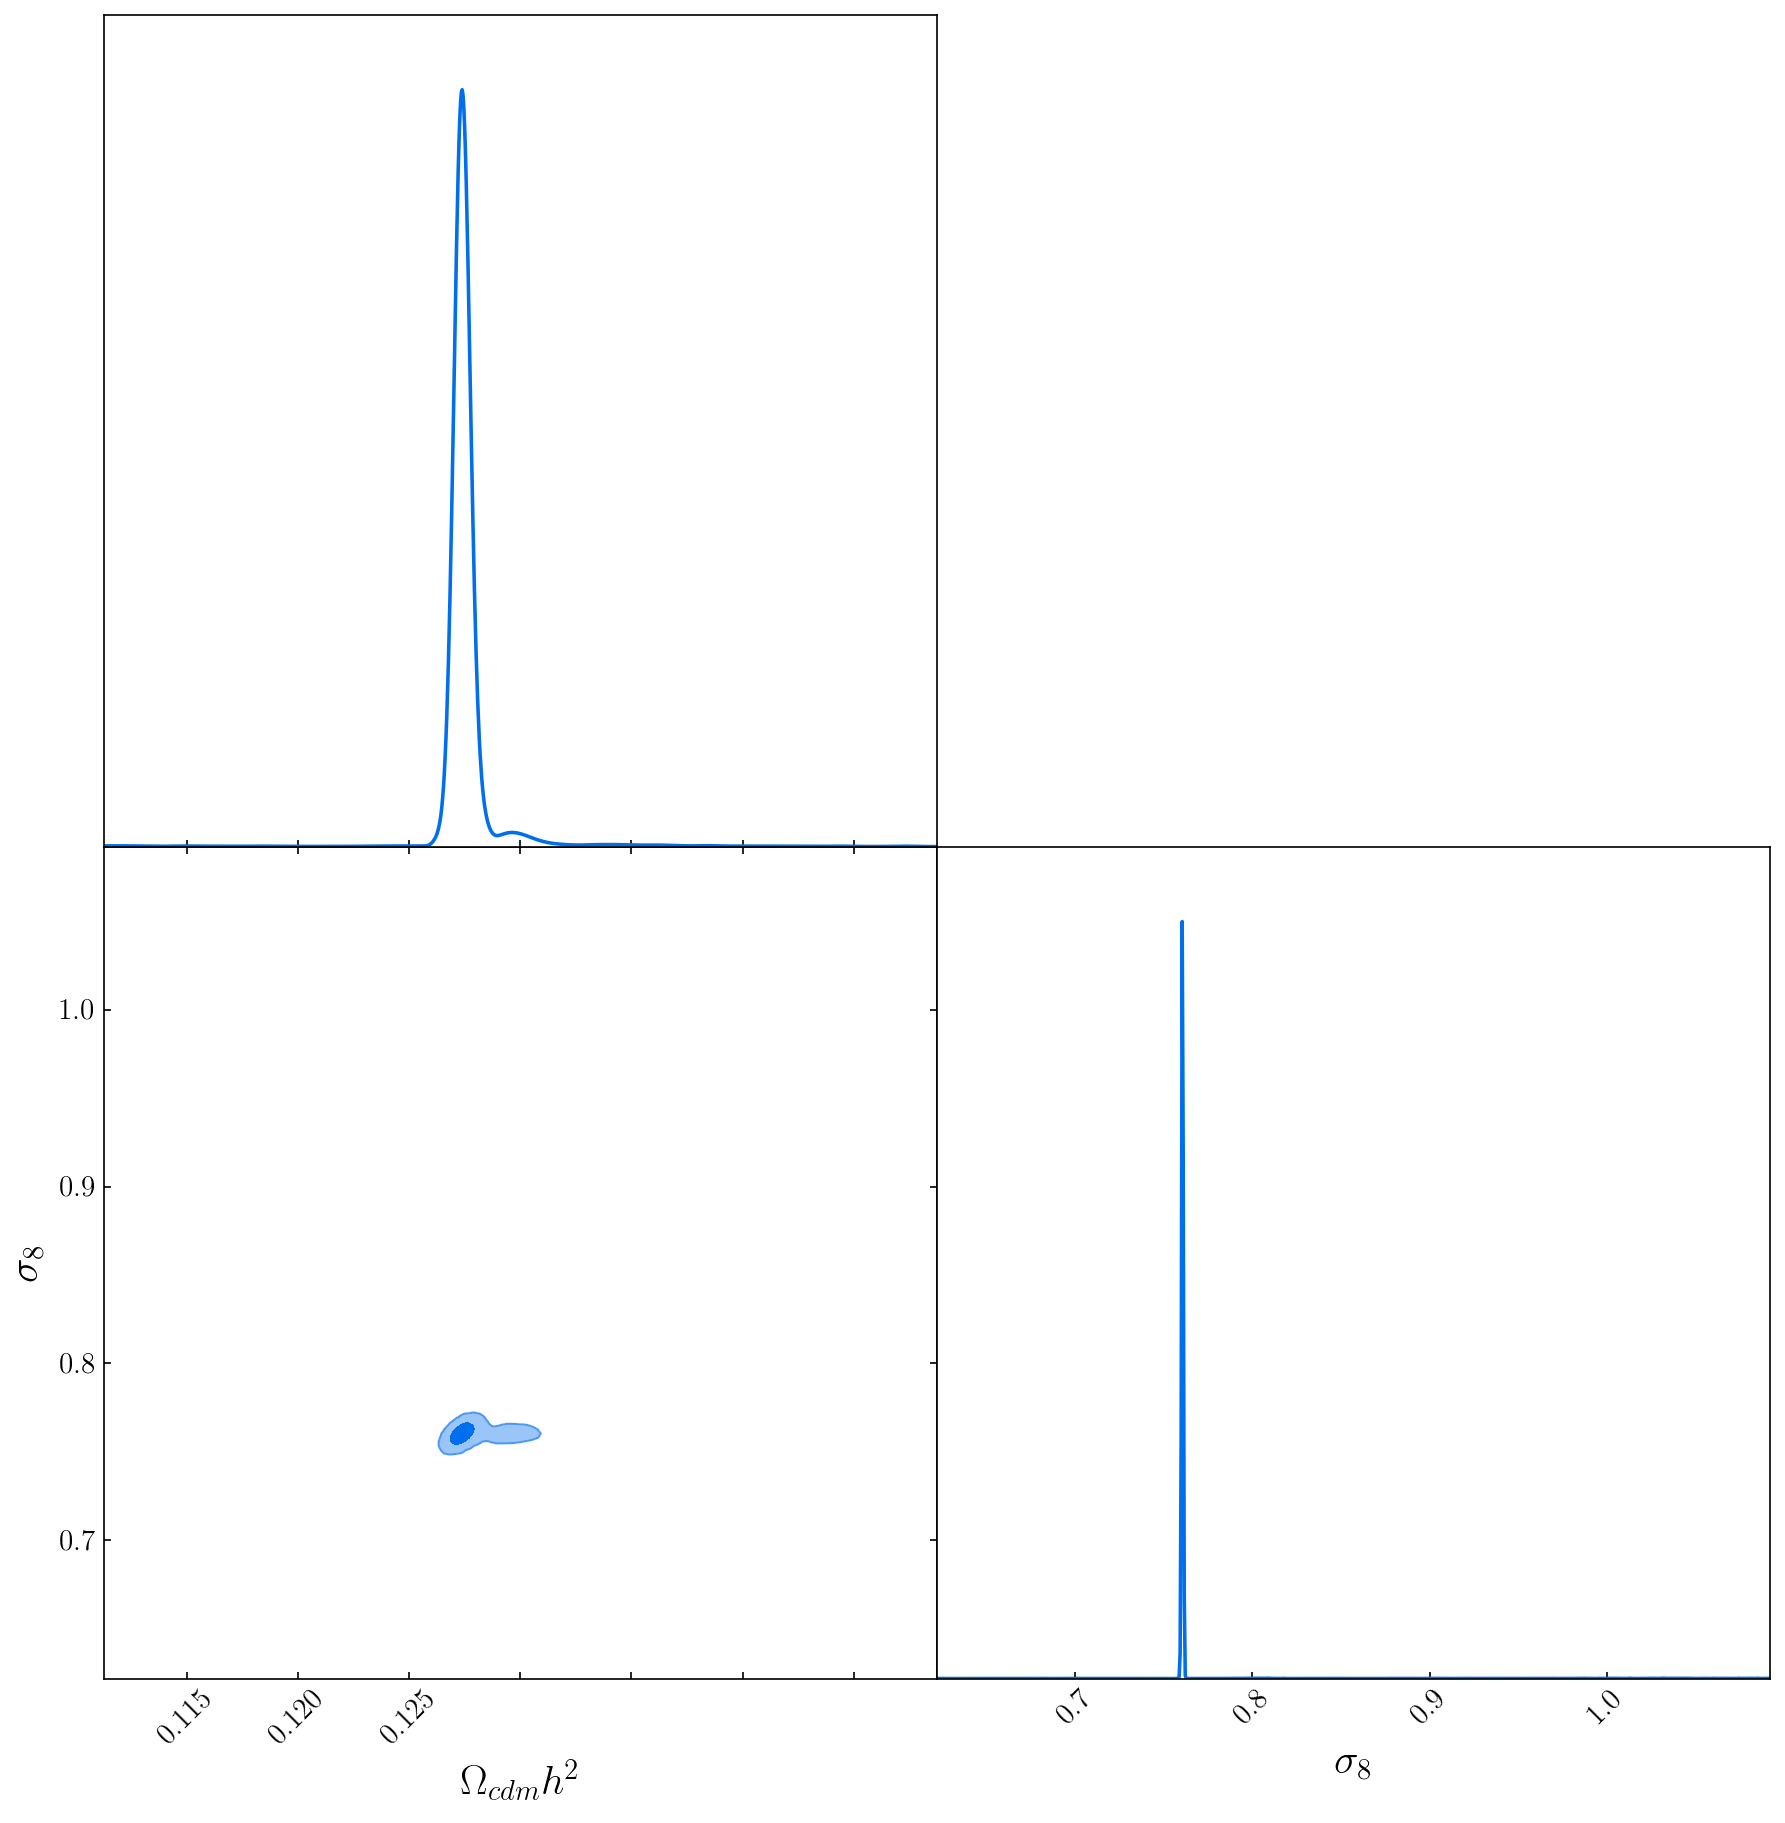

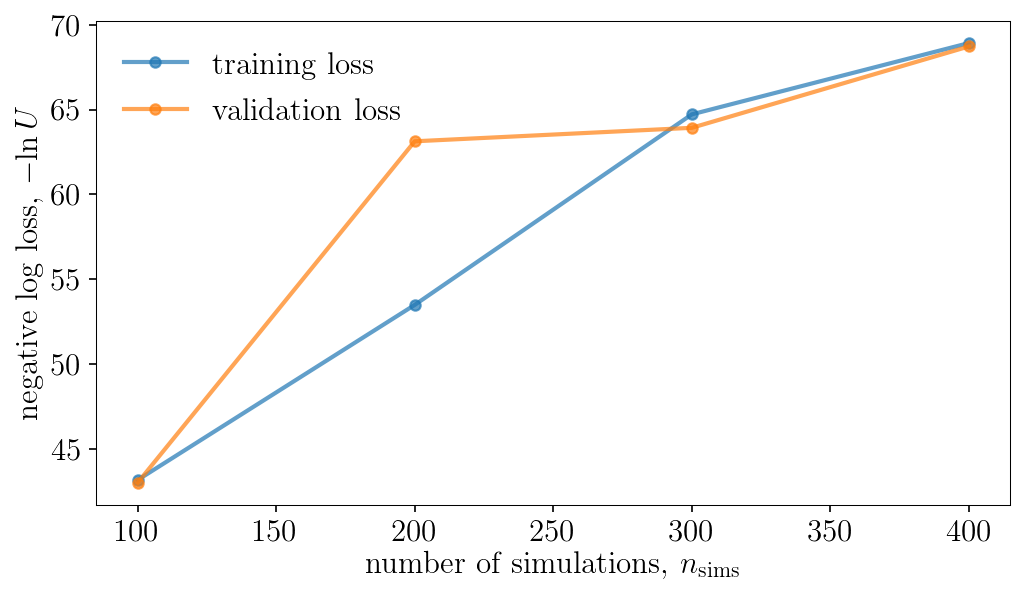

Population 4/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


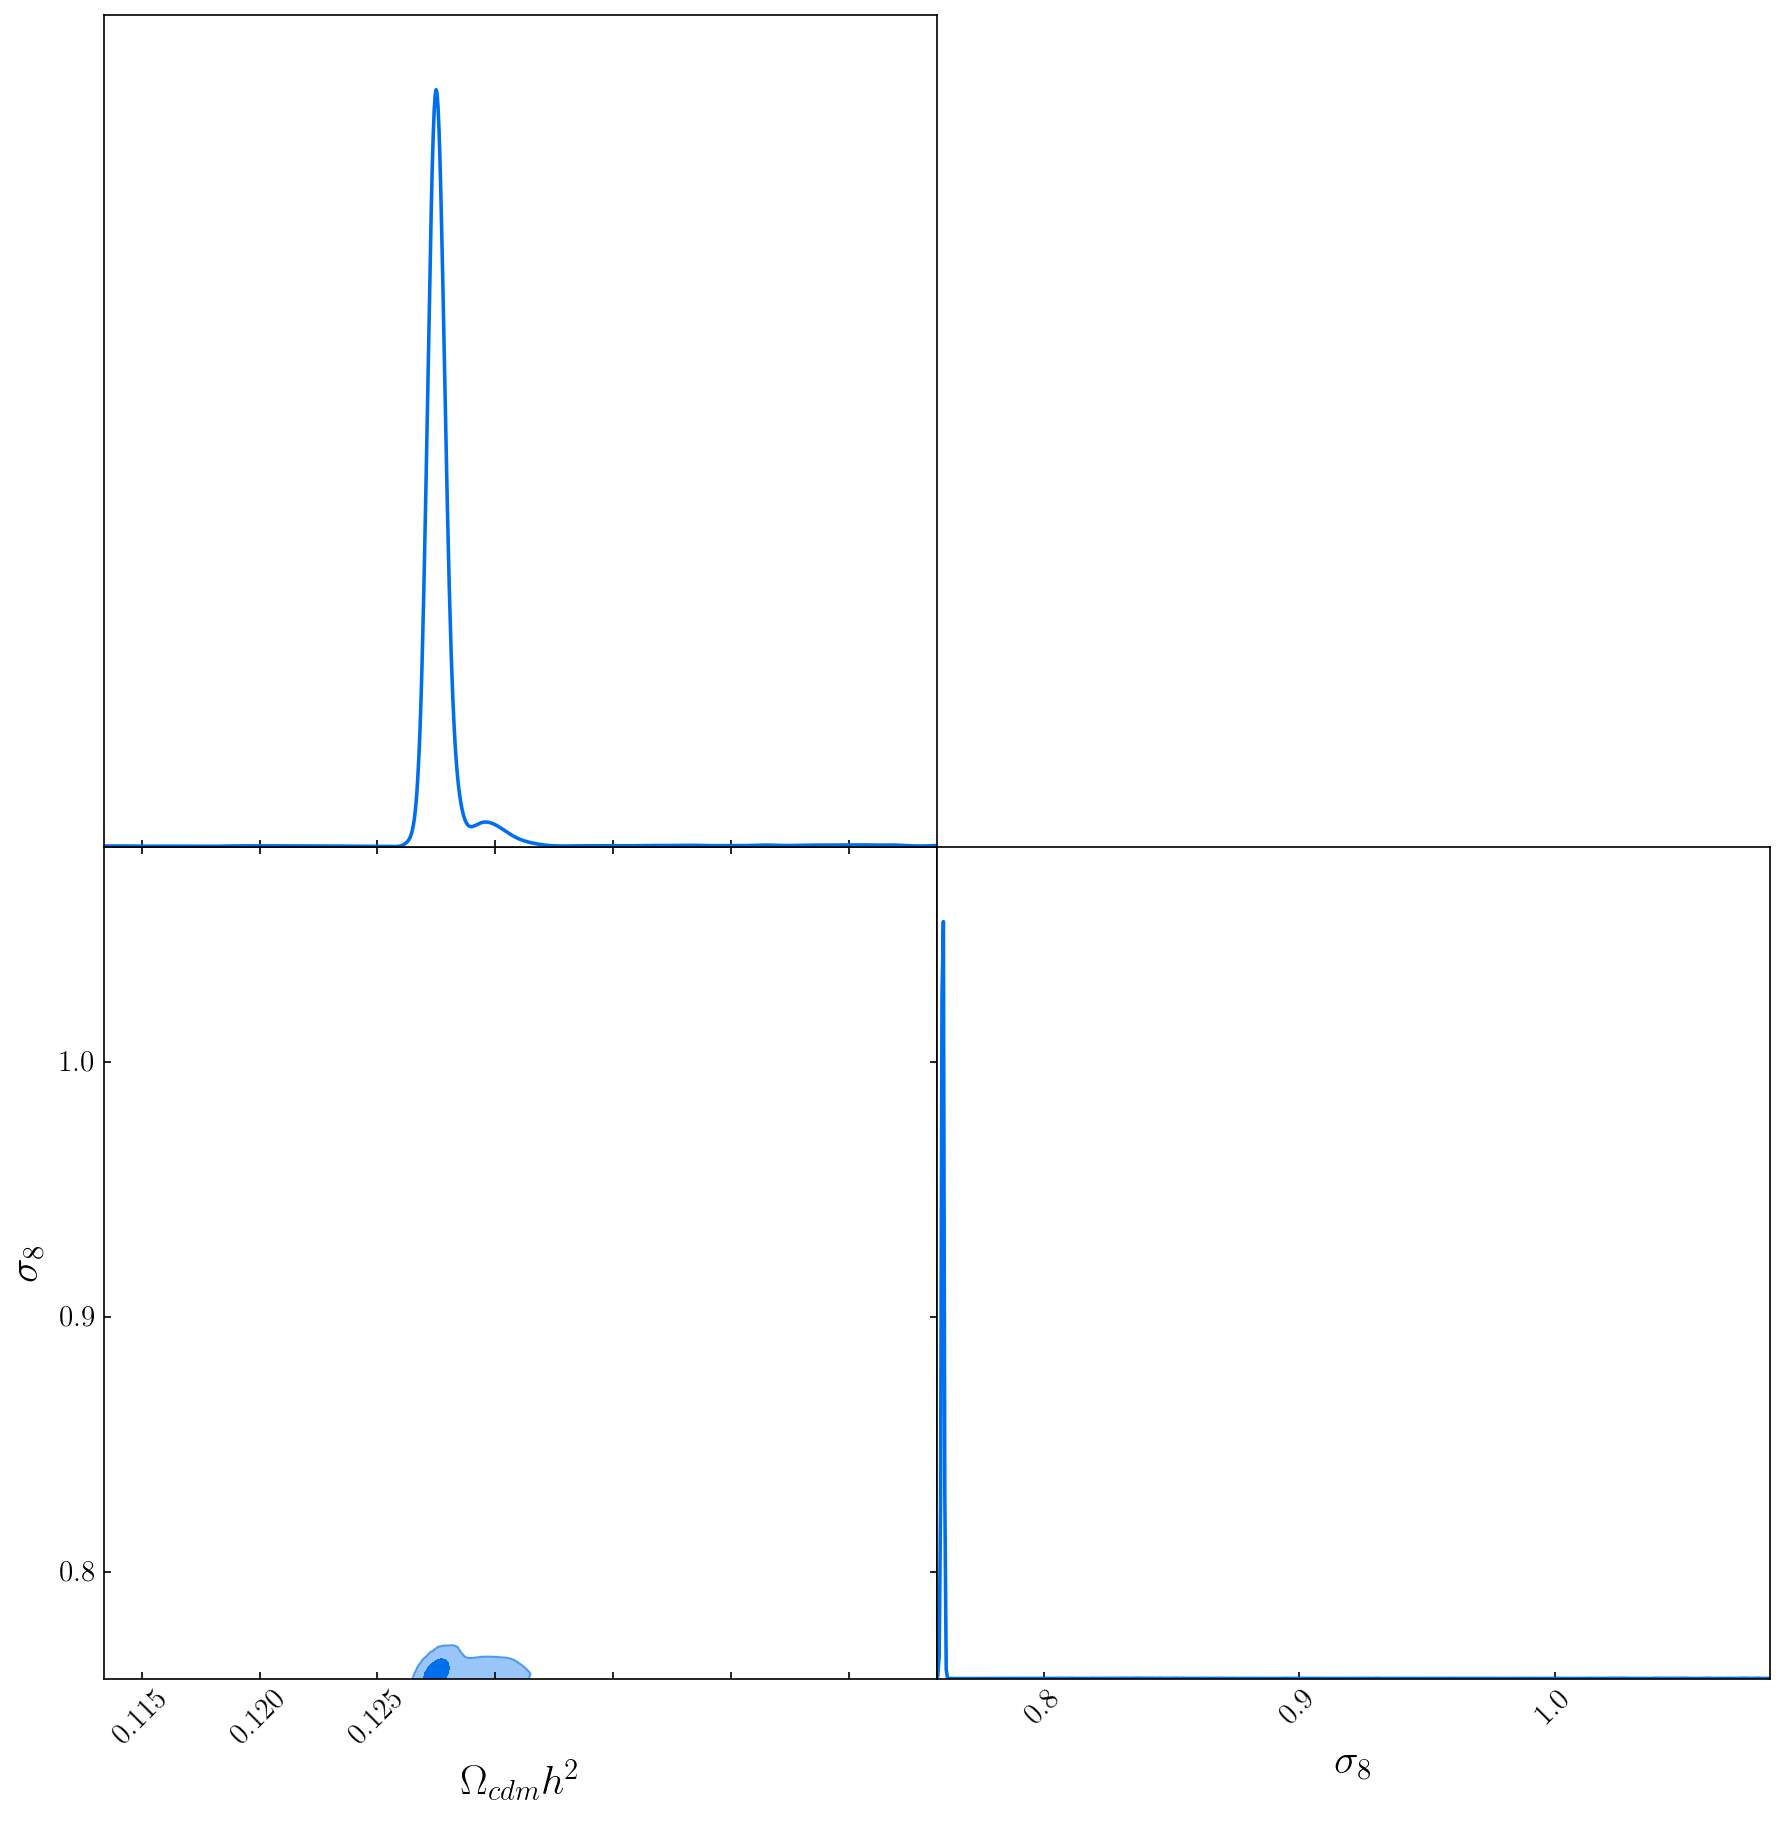

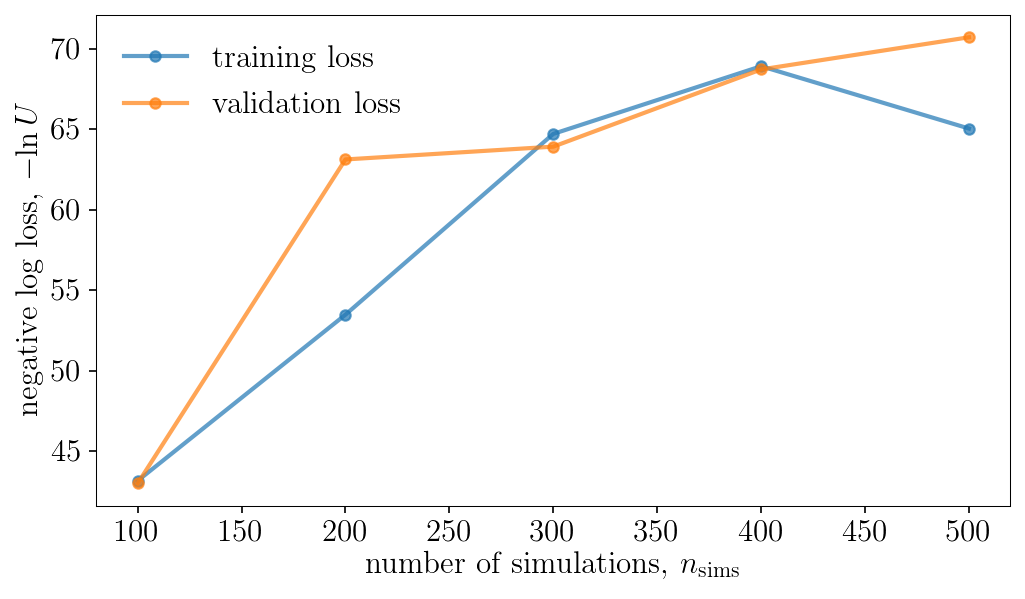

Population 5/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


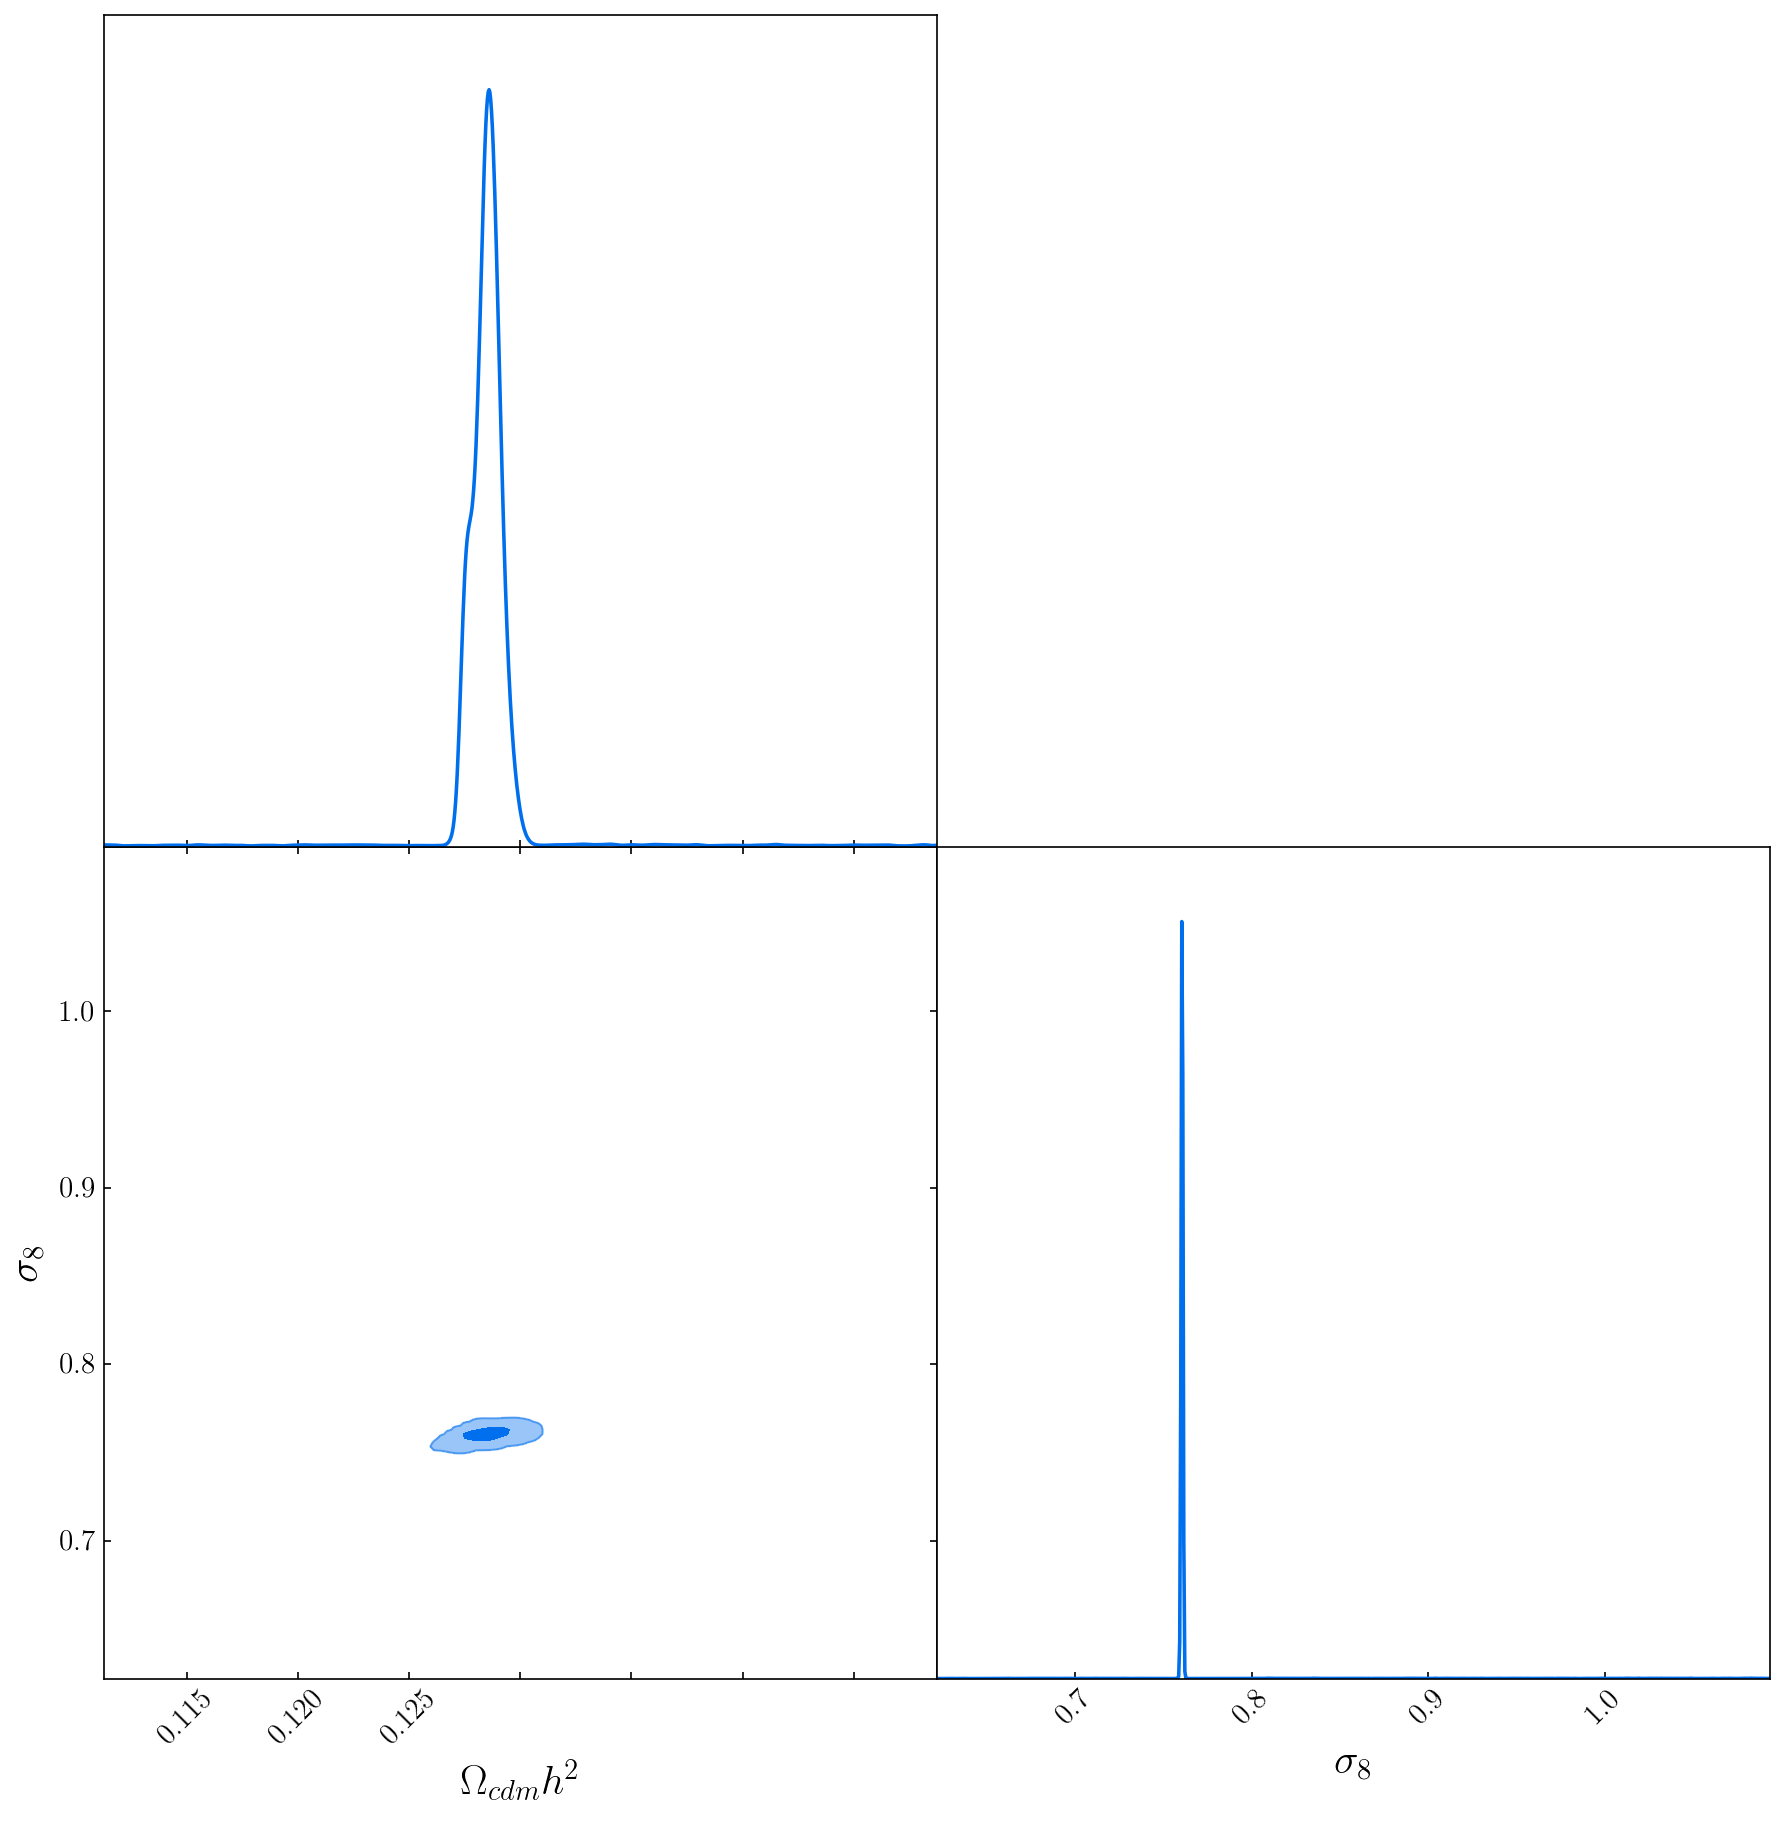

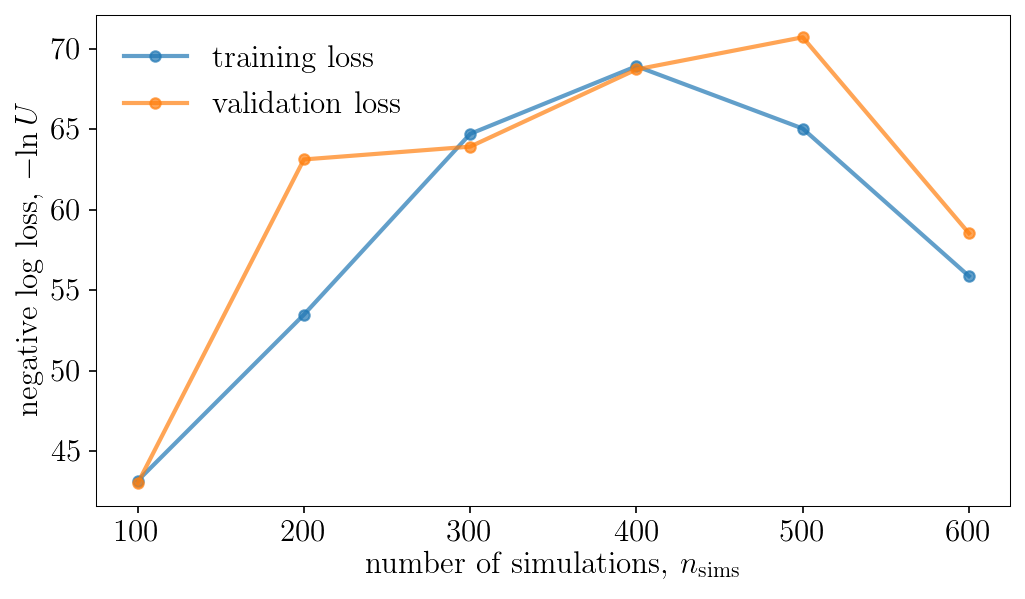

Population 6/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


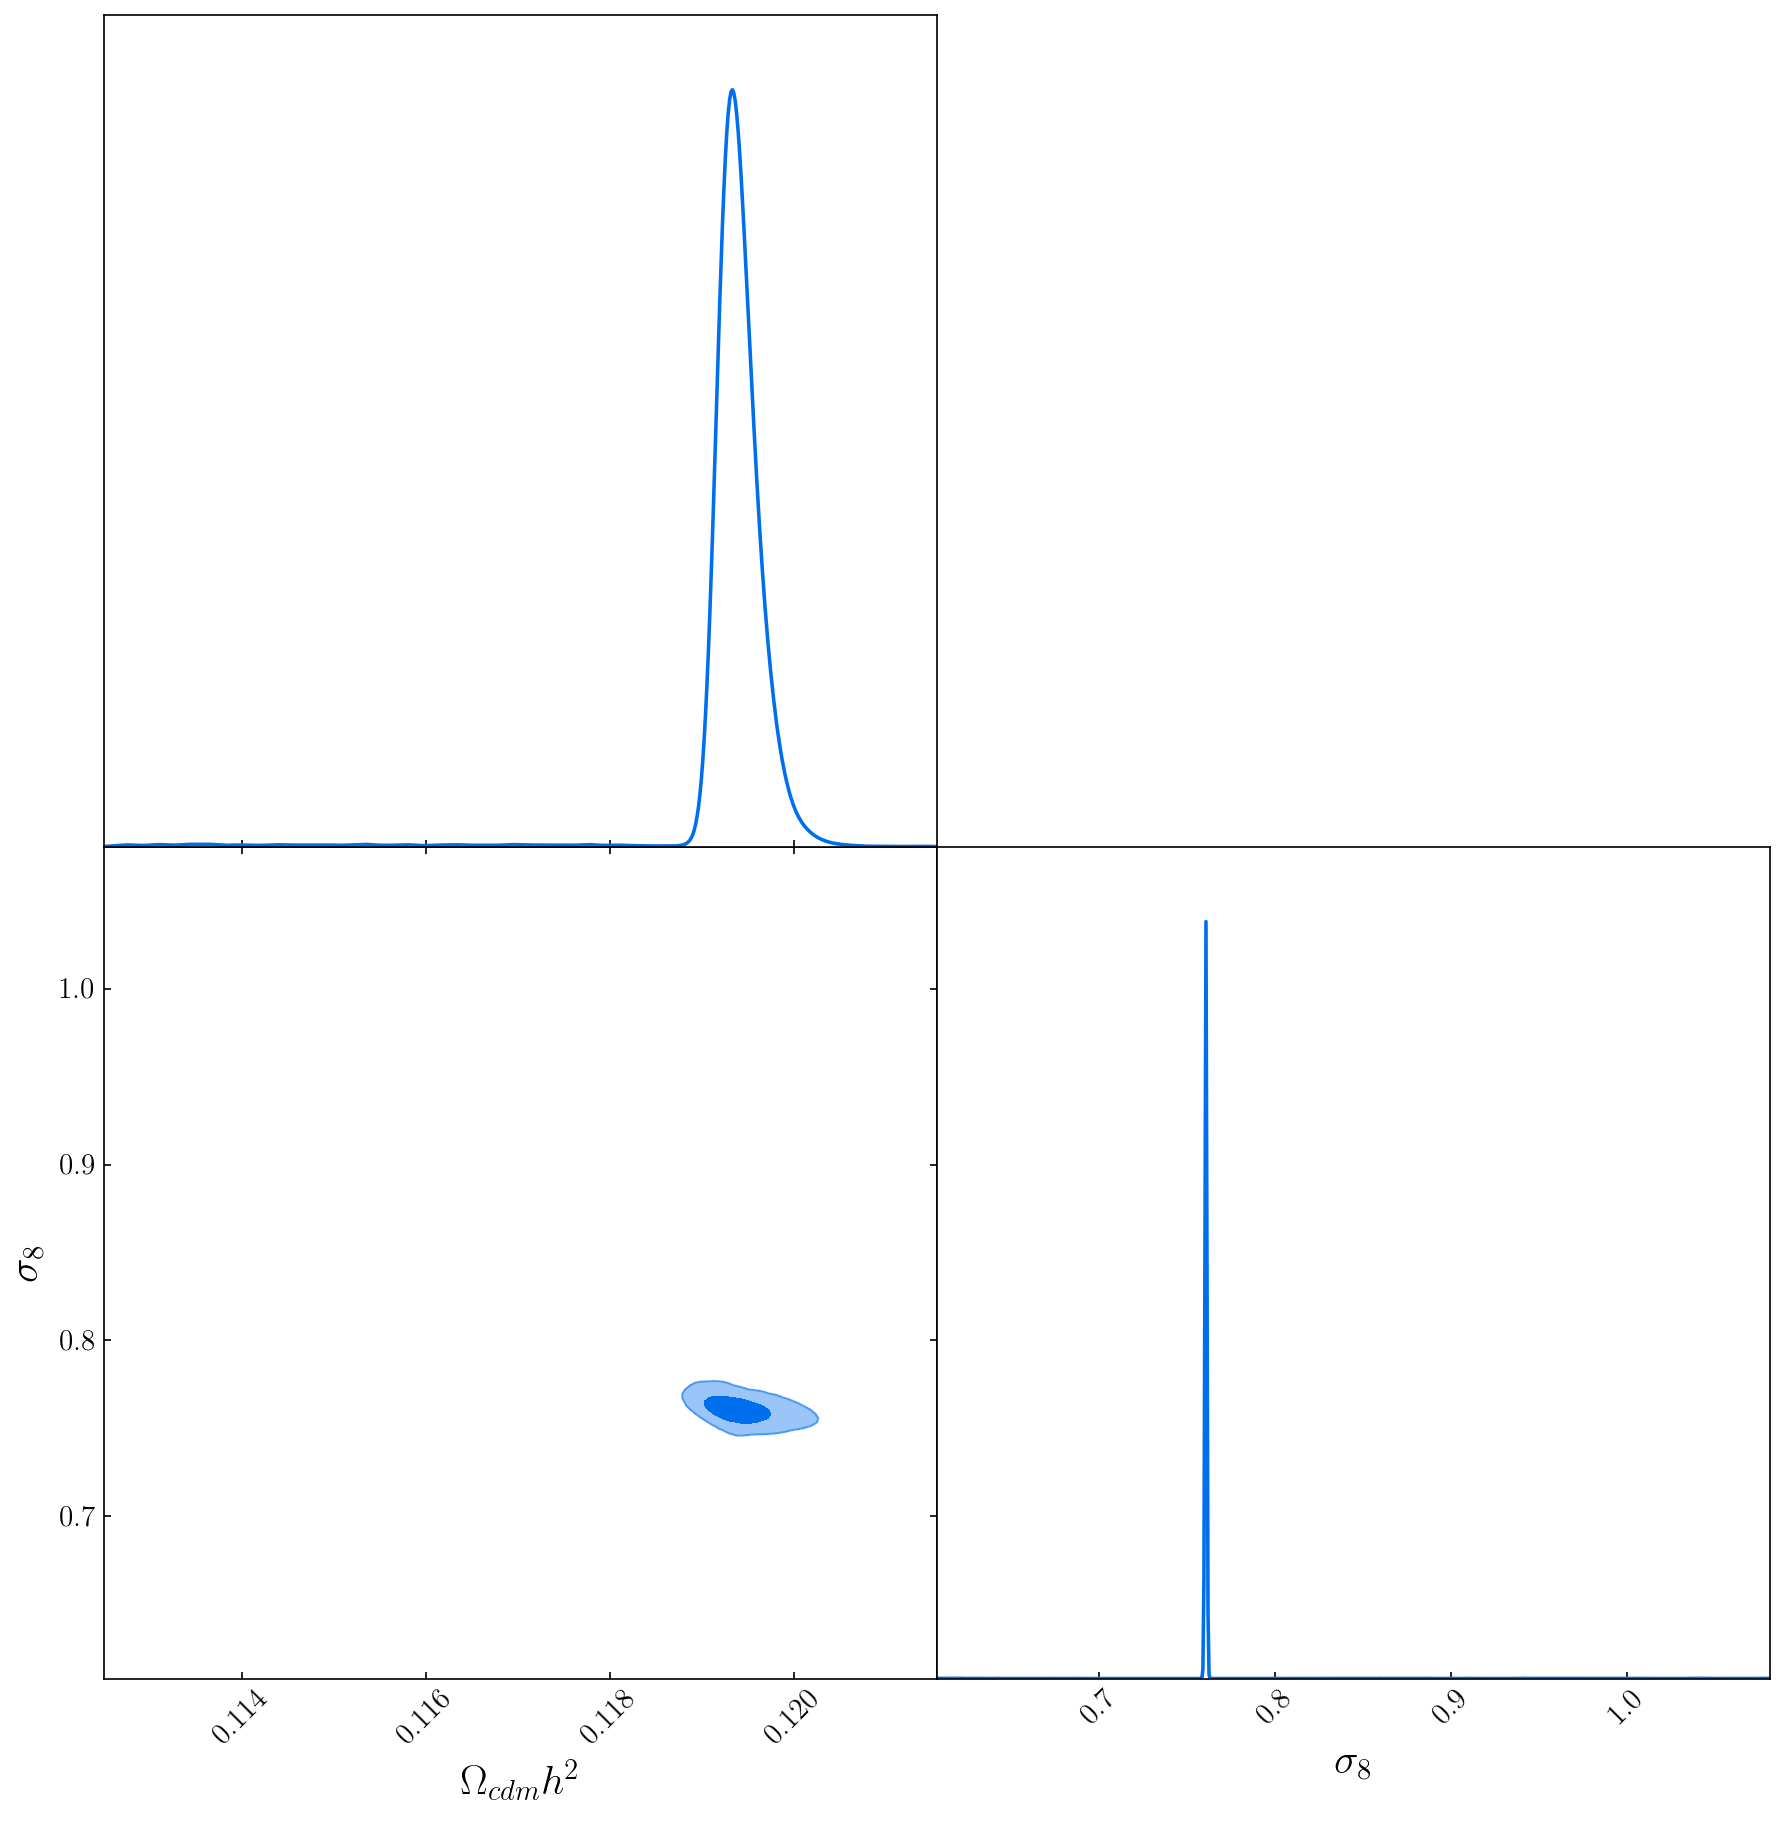

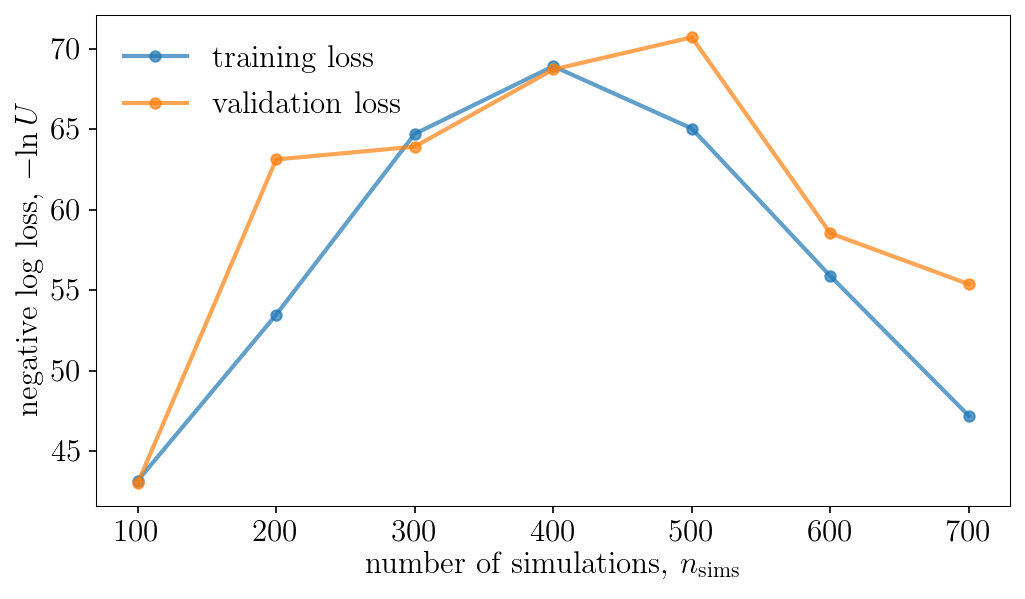

Population 7/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


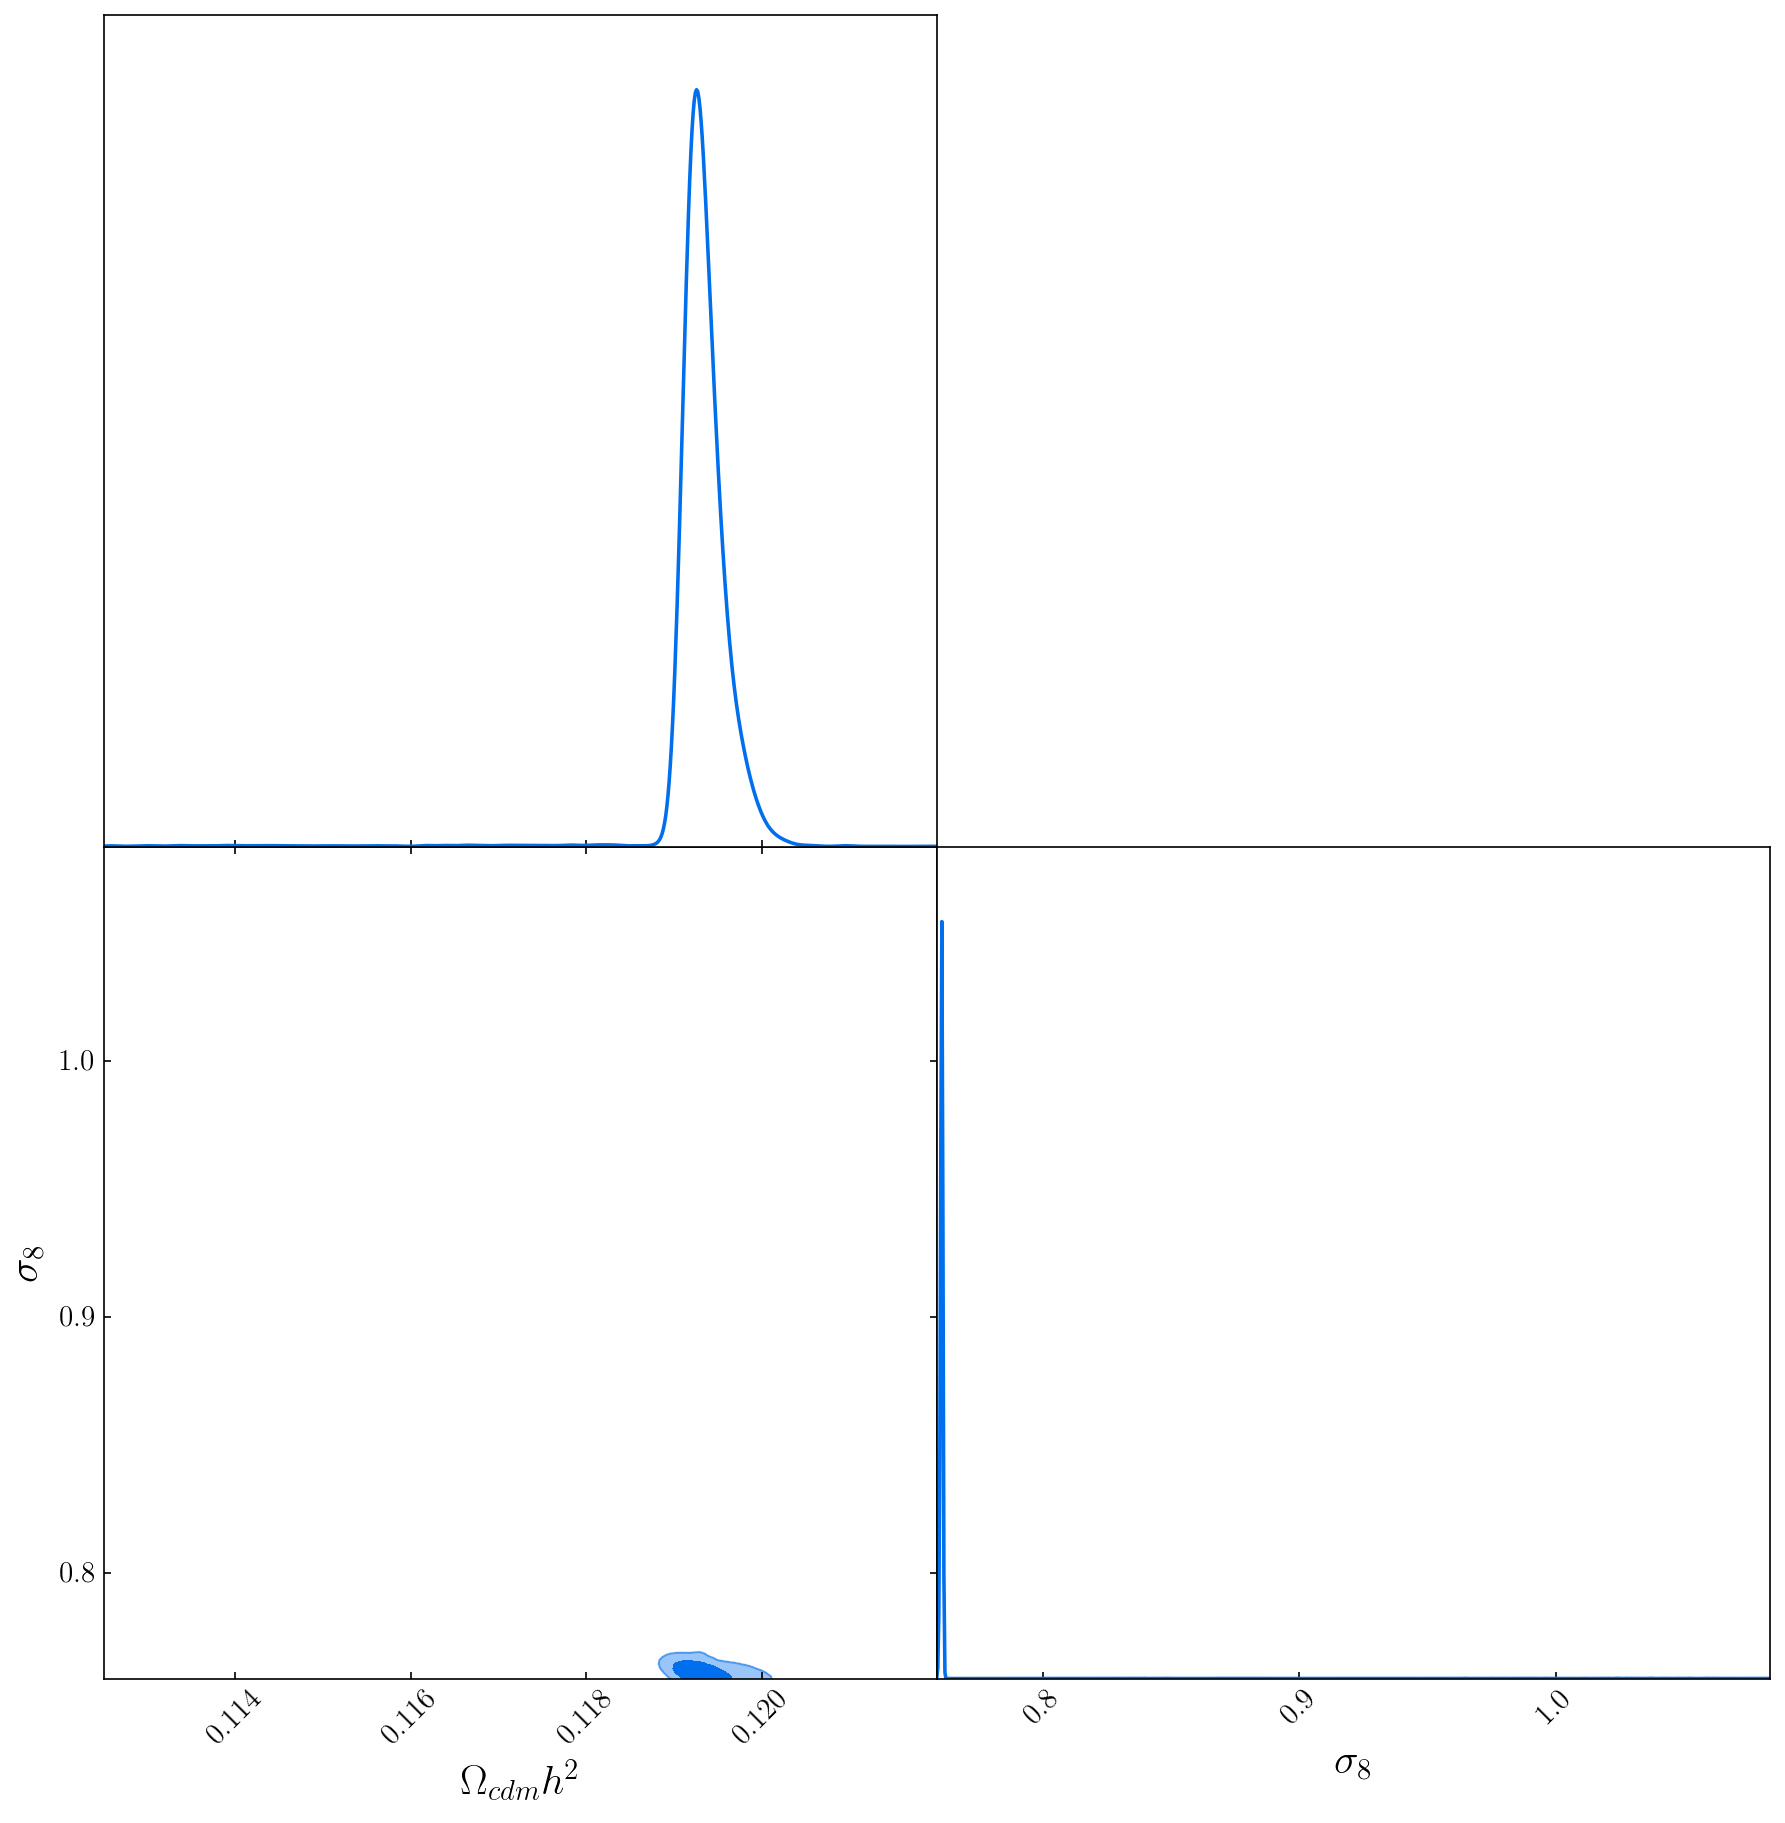

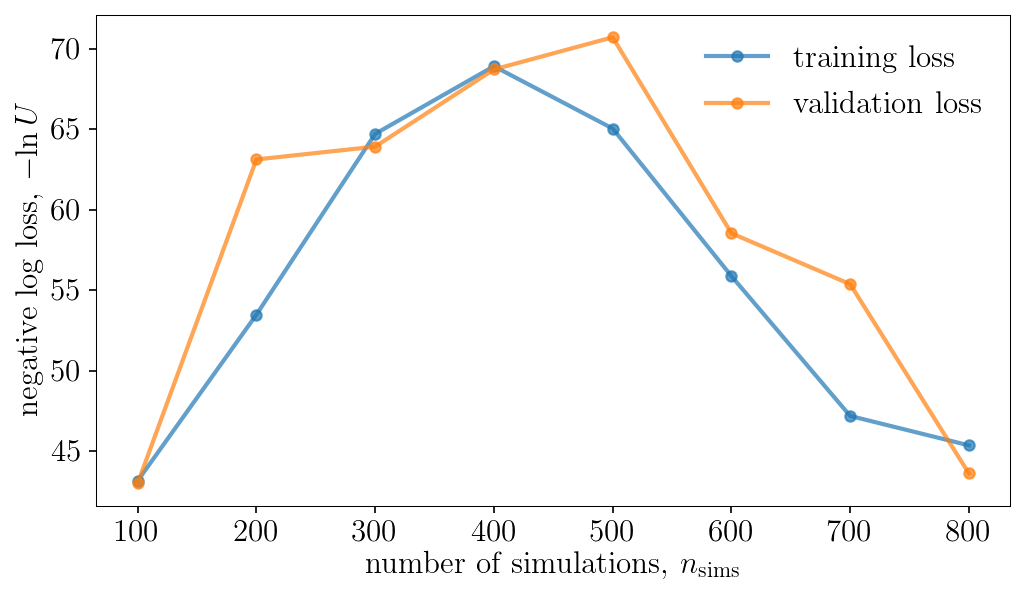

Population 8/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


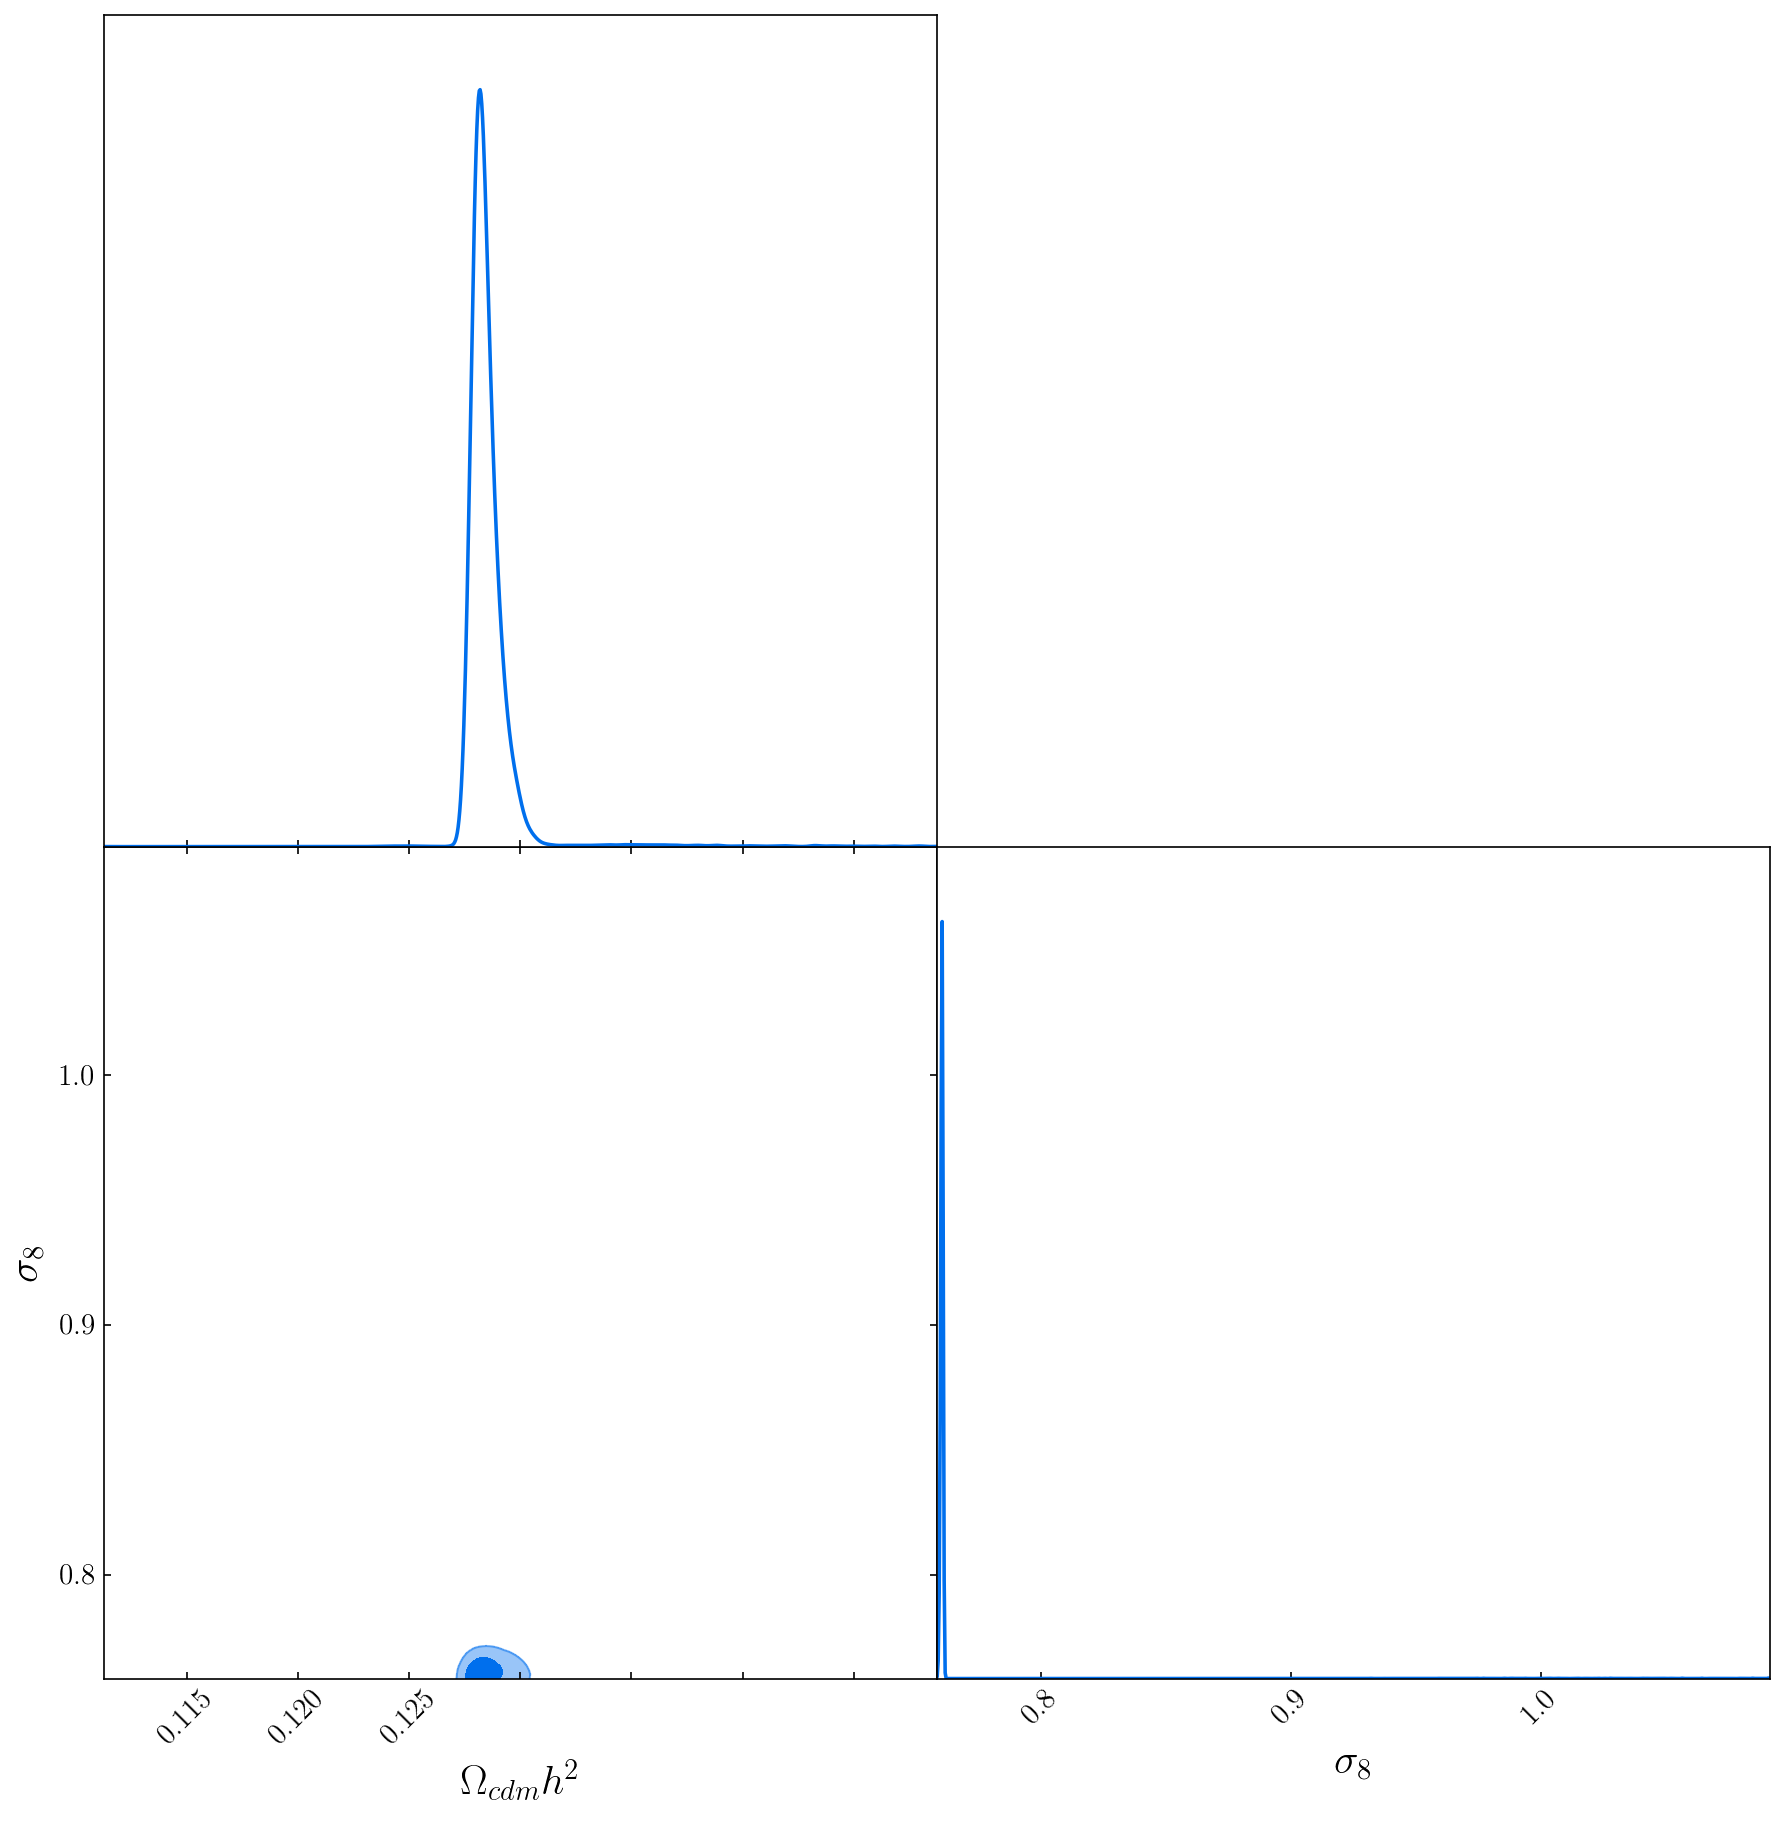

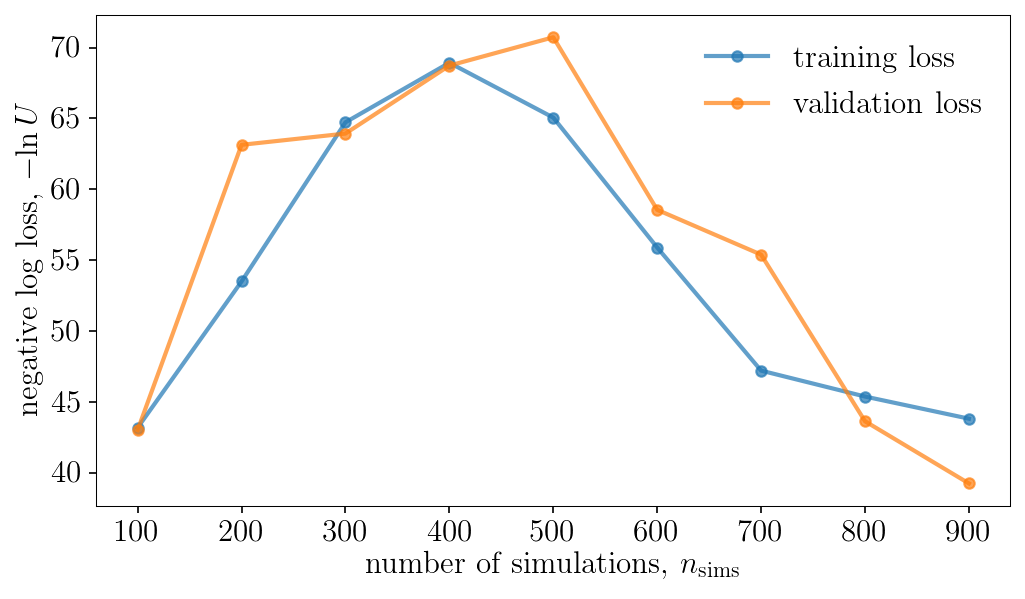

Population 9/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


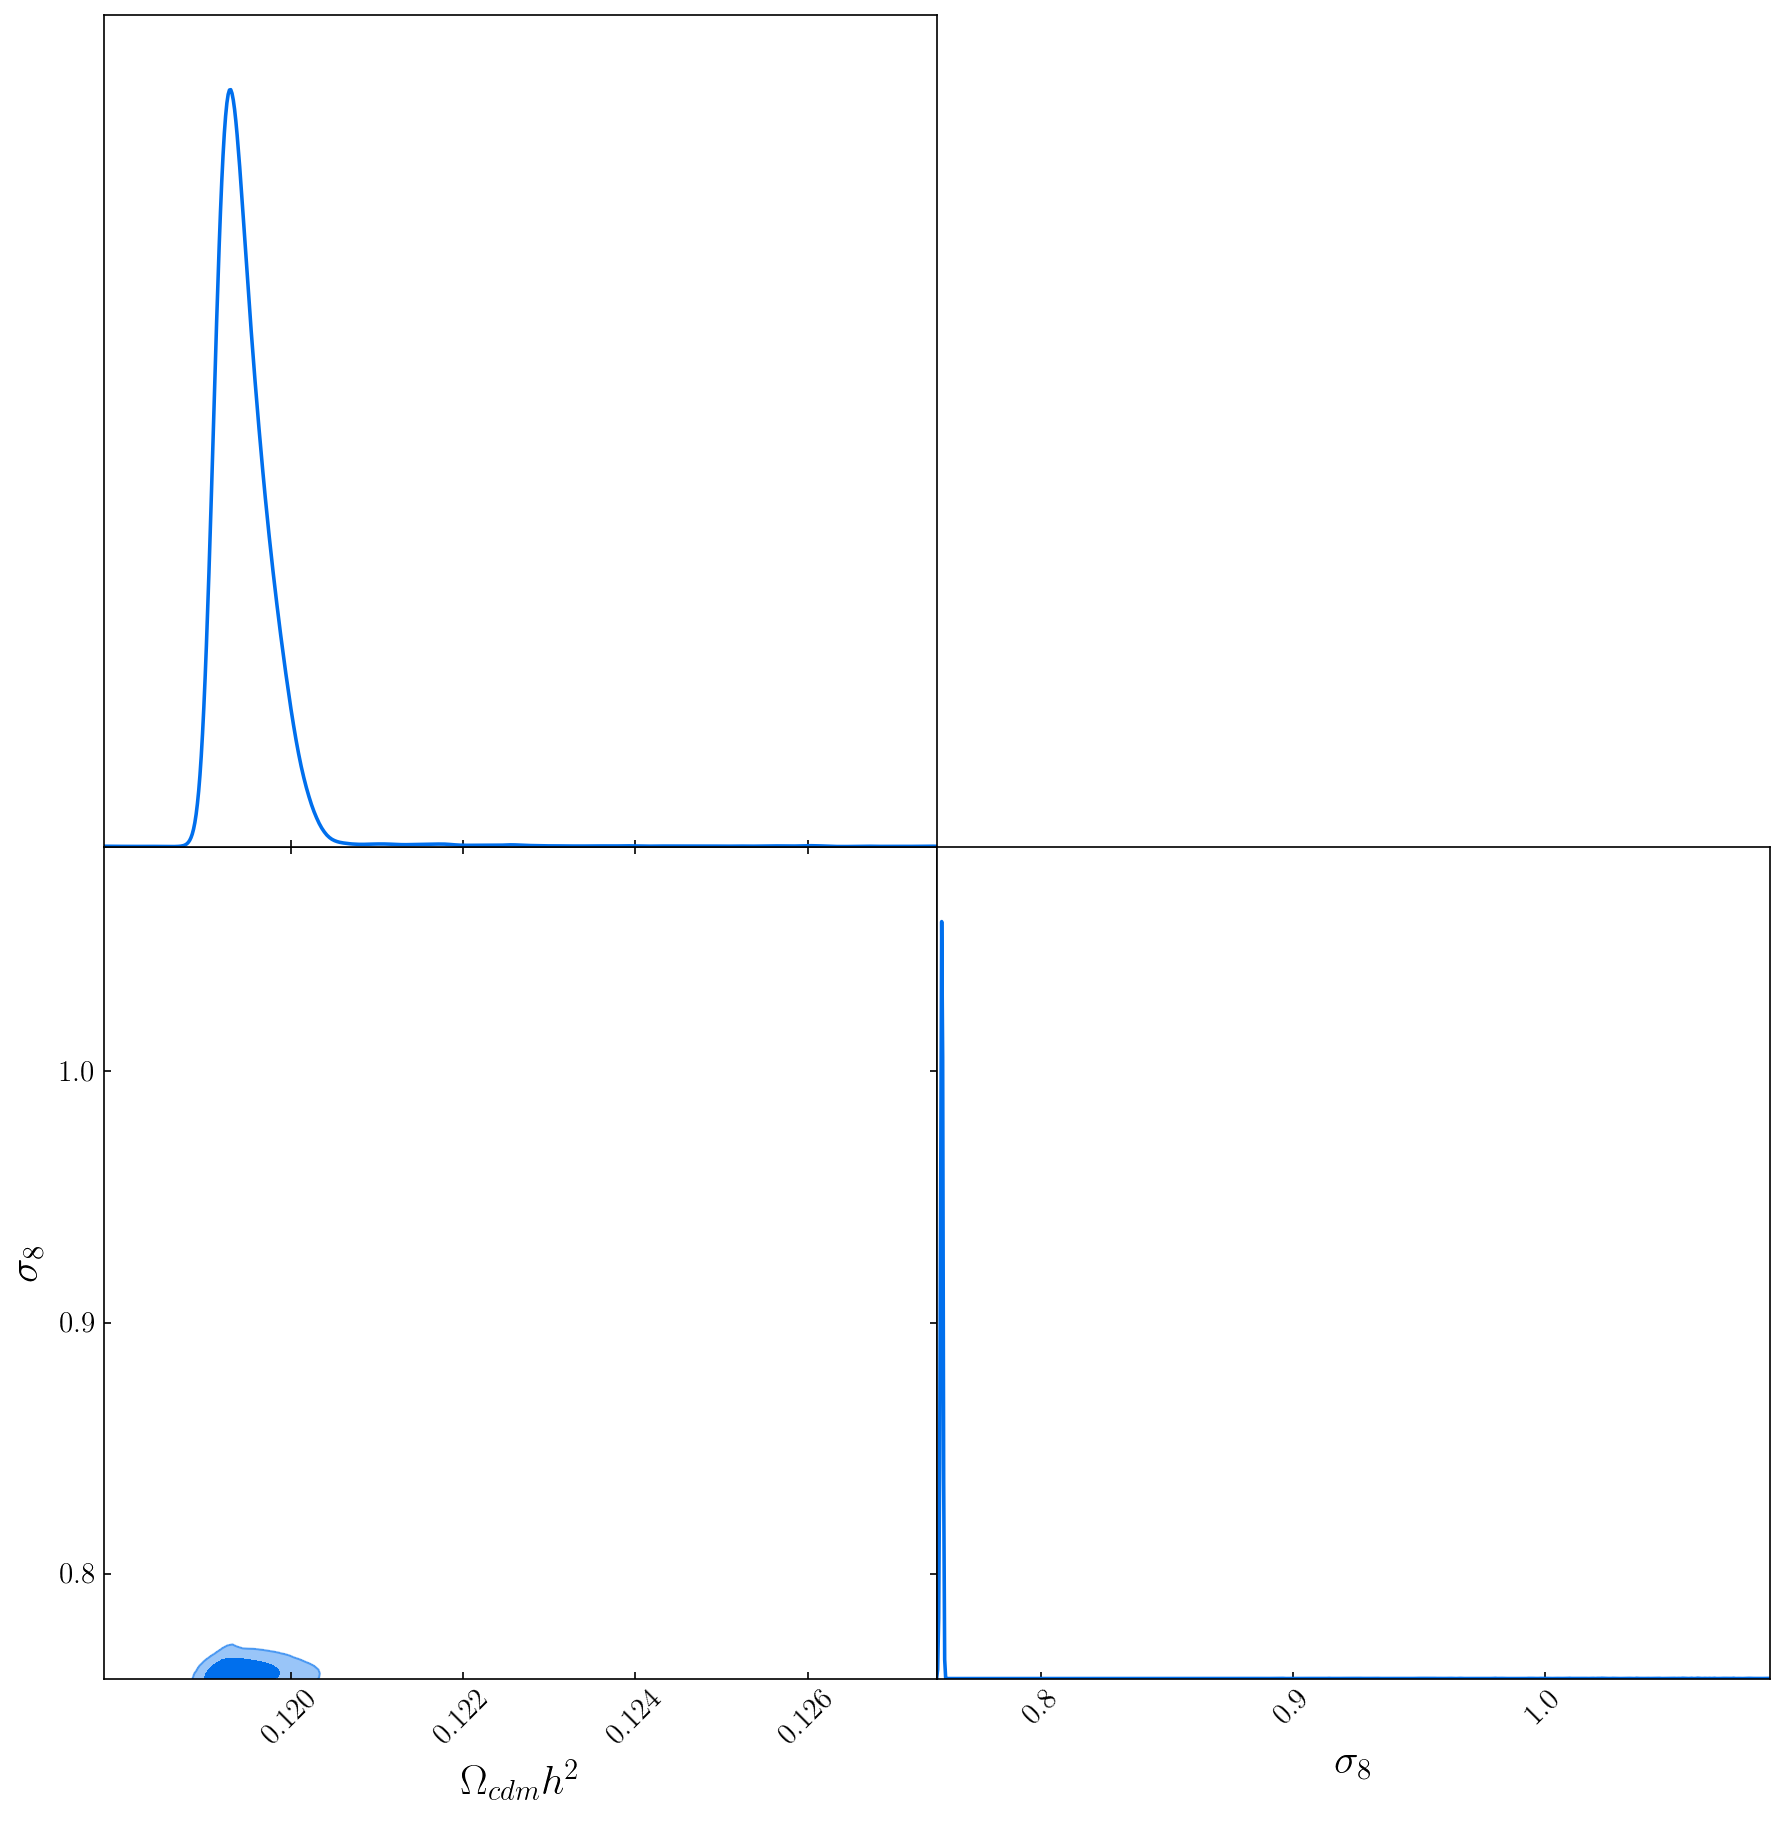

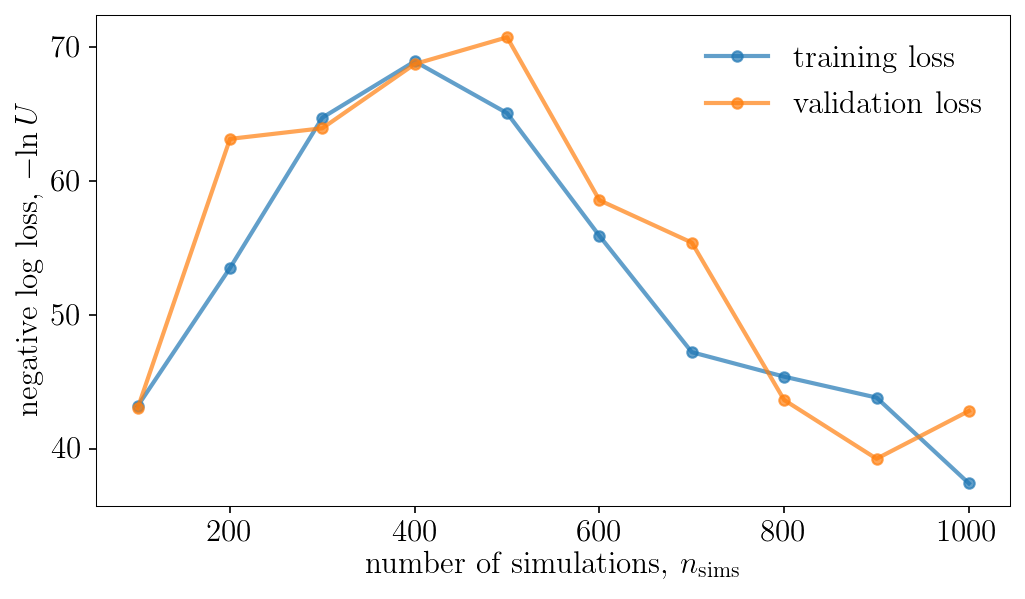

Population 10/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


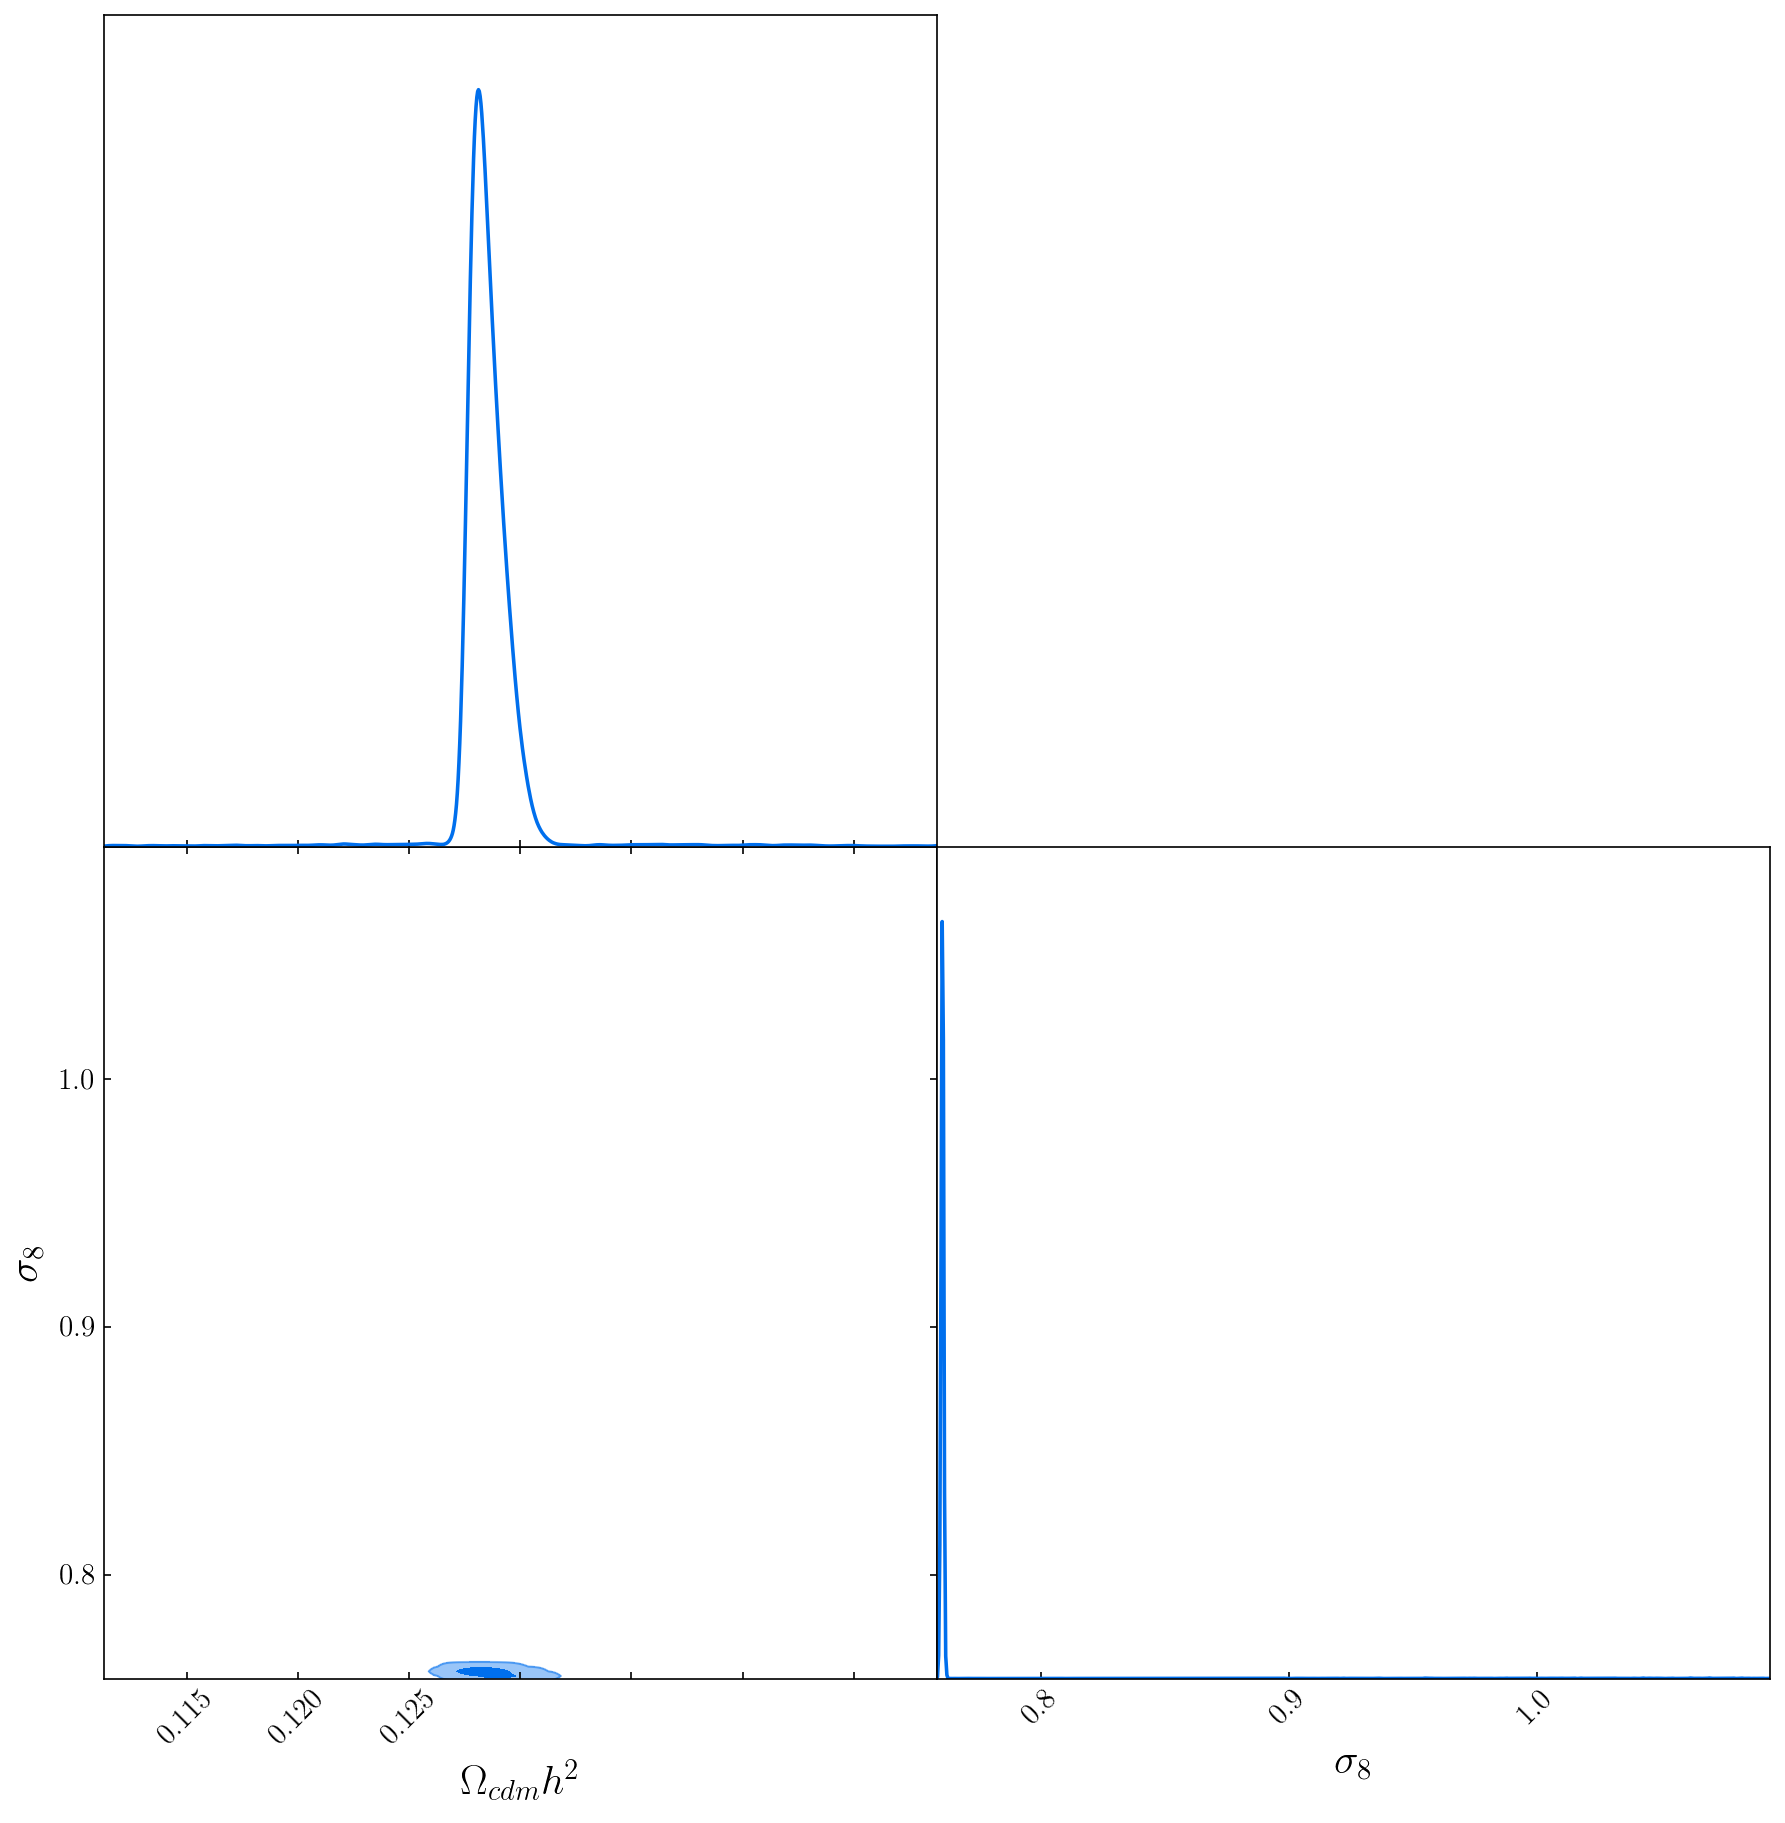

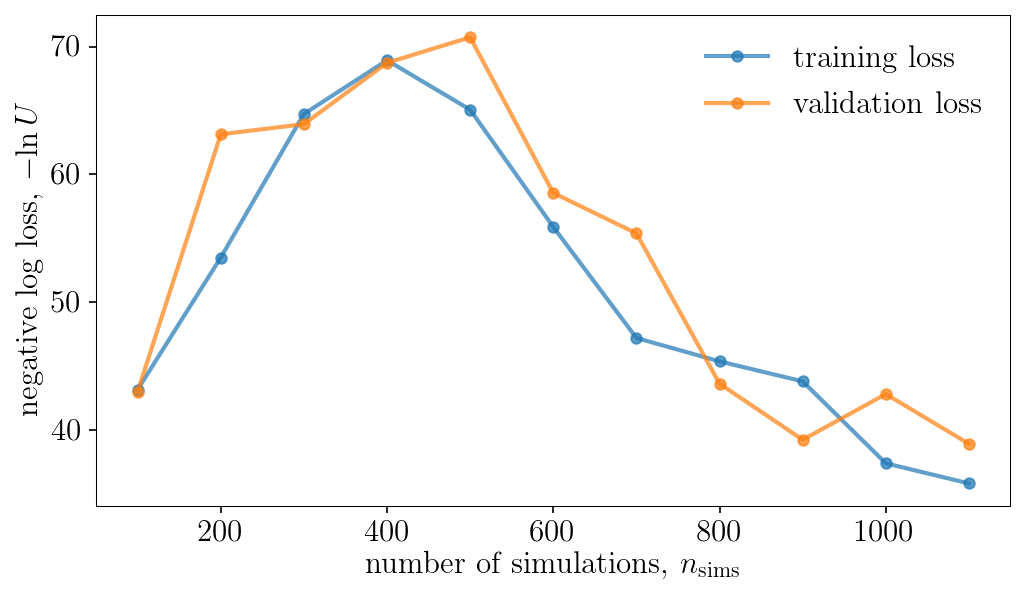

Population 11/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


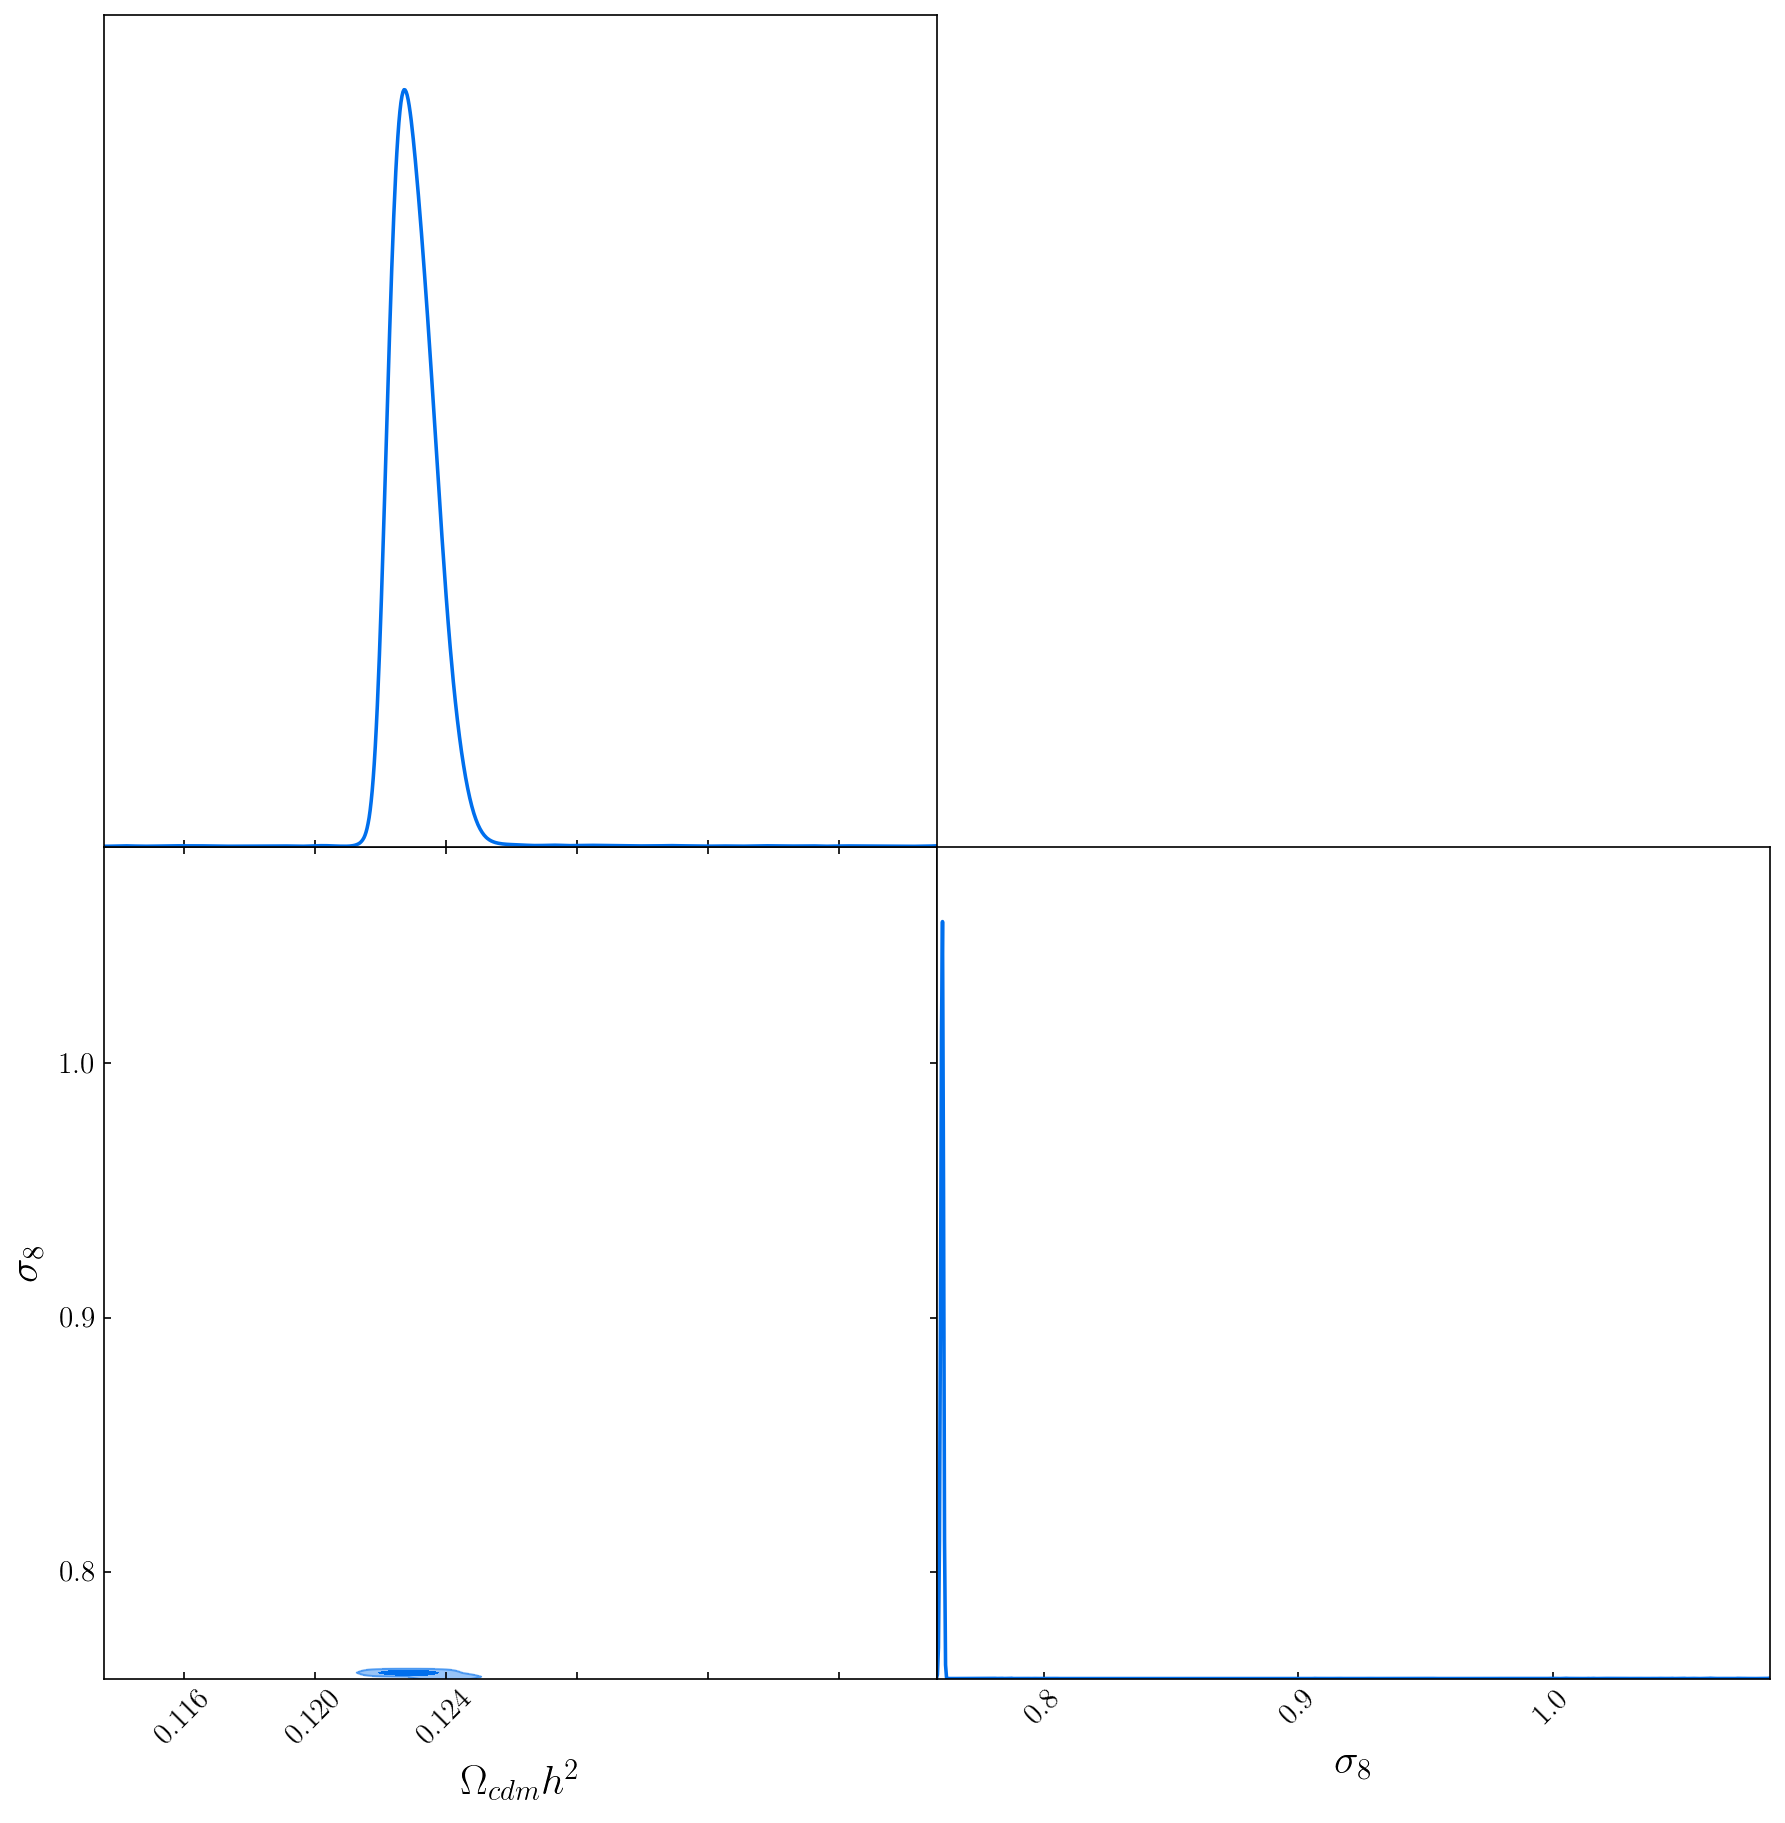

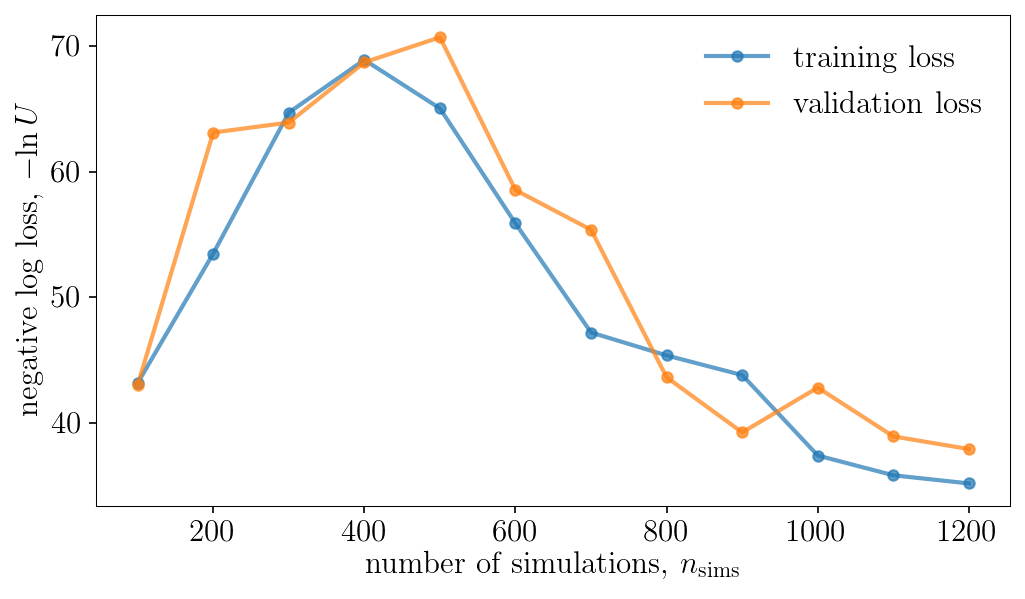

Population 12/40
Sampling proposal density...
Done.


Sampling approximate posterior...


Done.
Removed no burn in


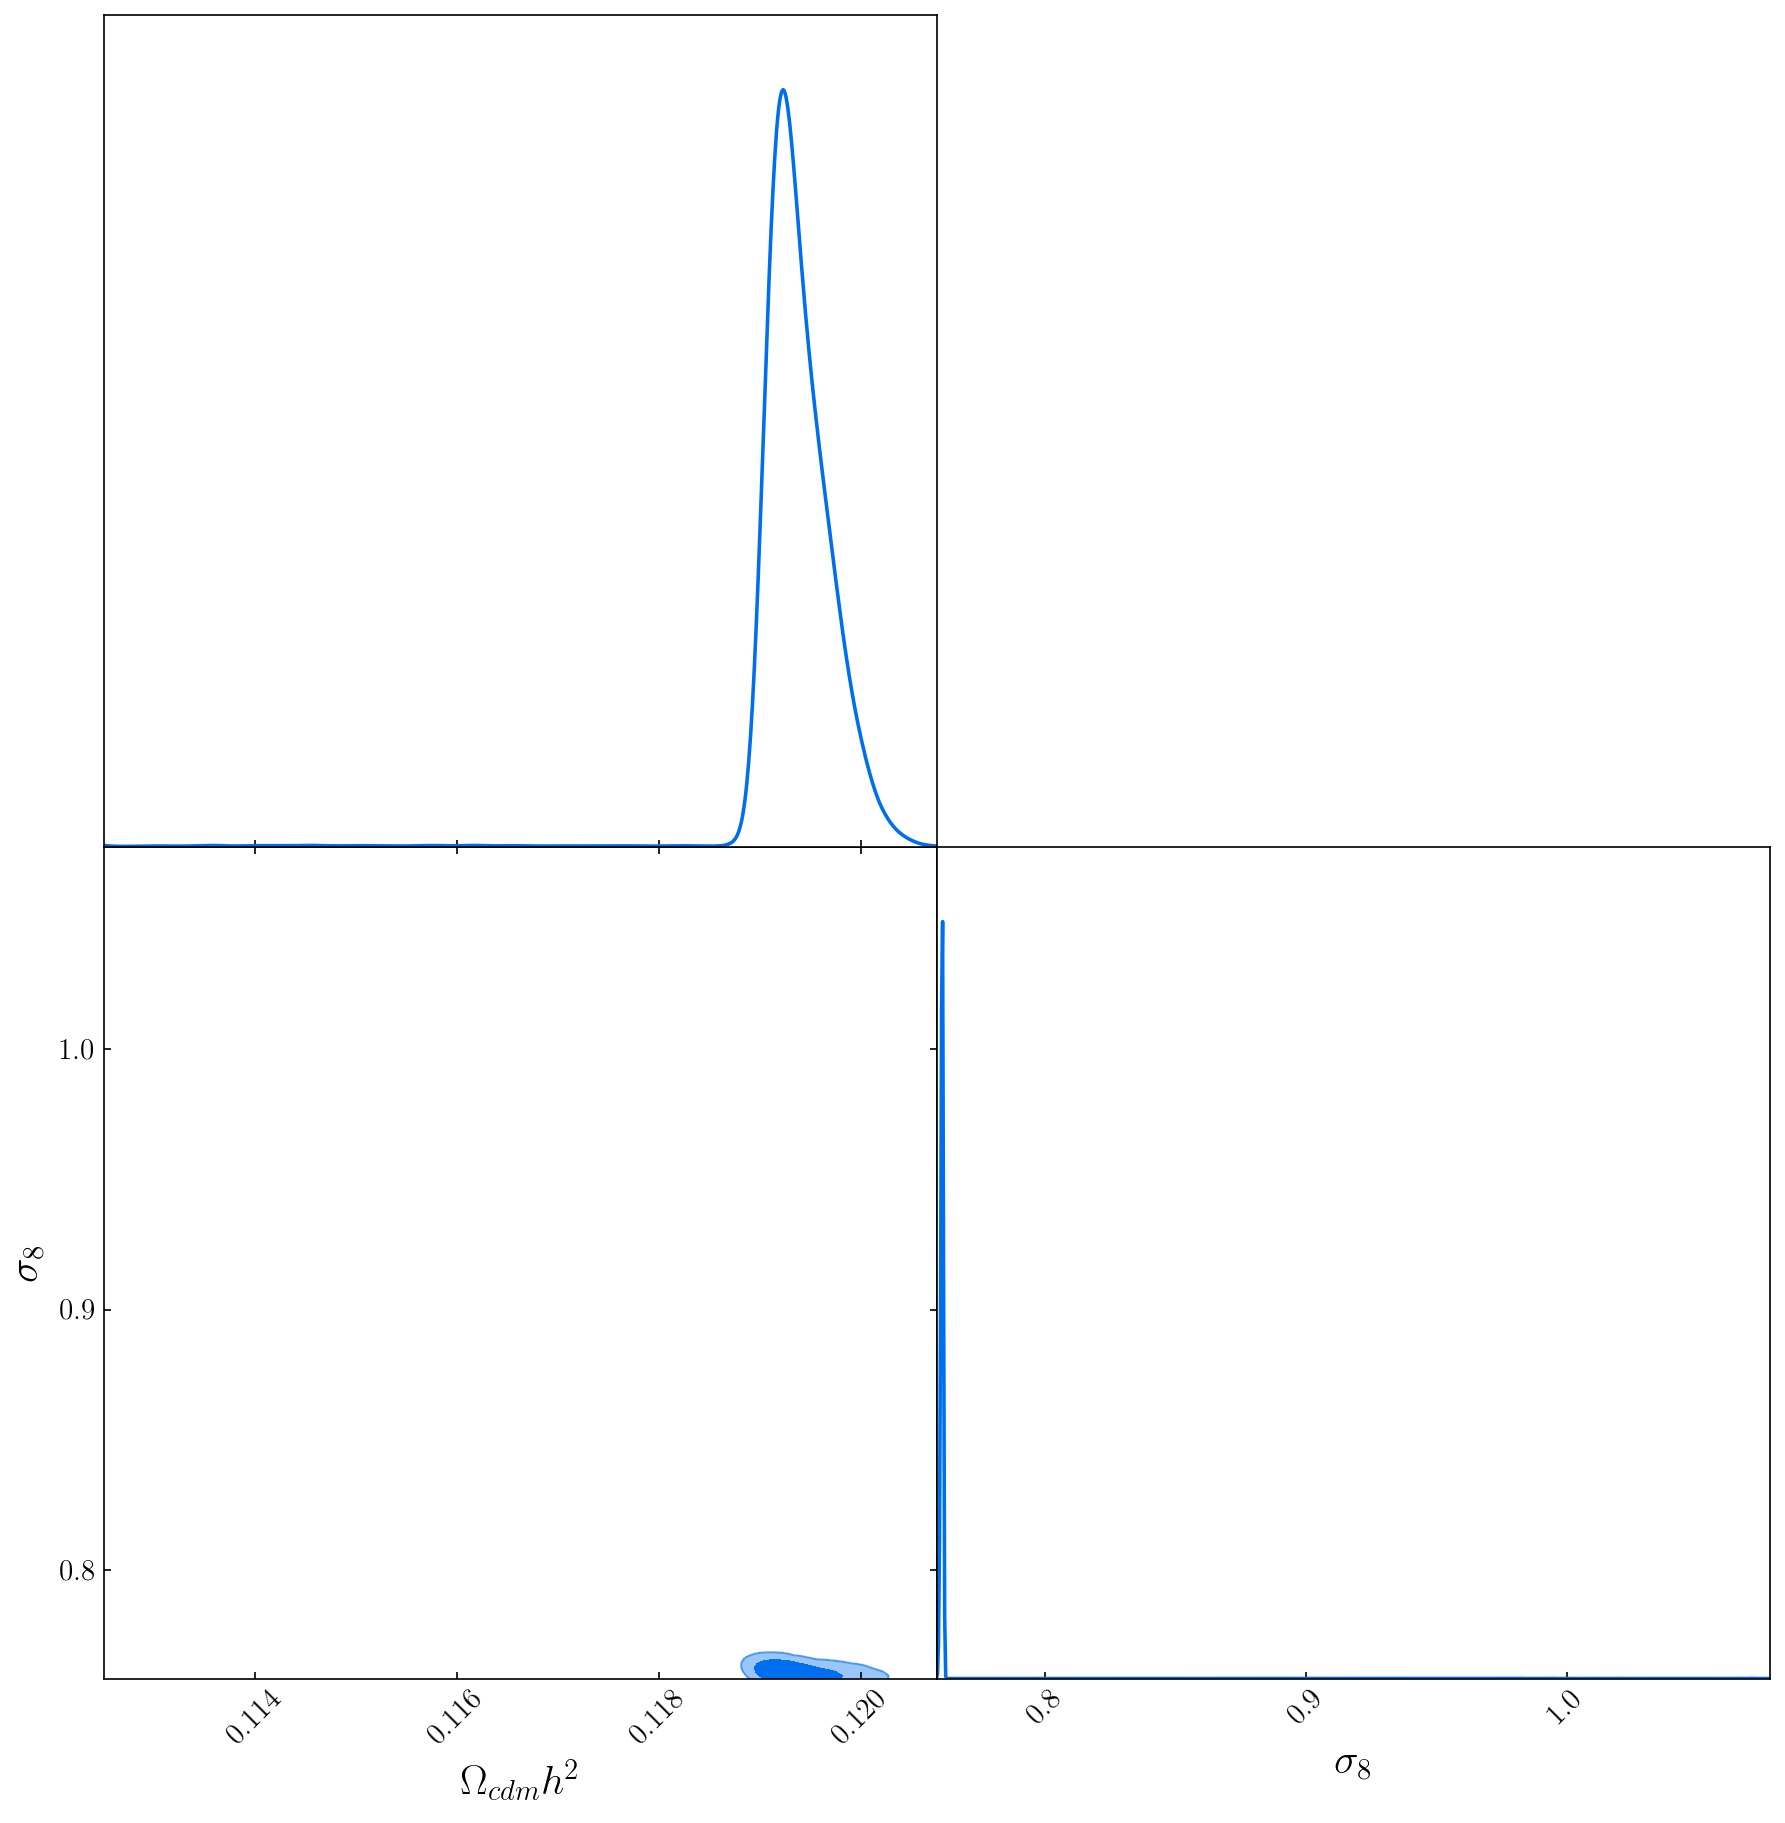

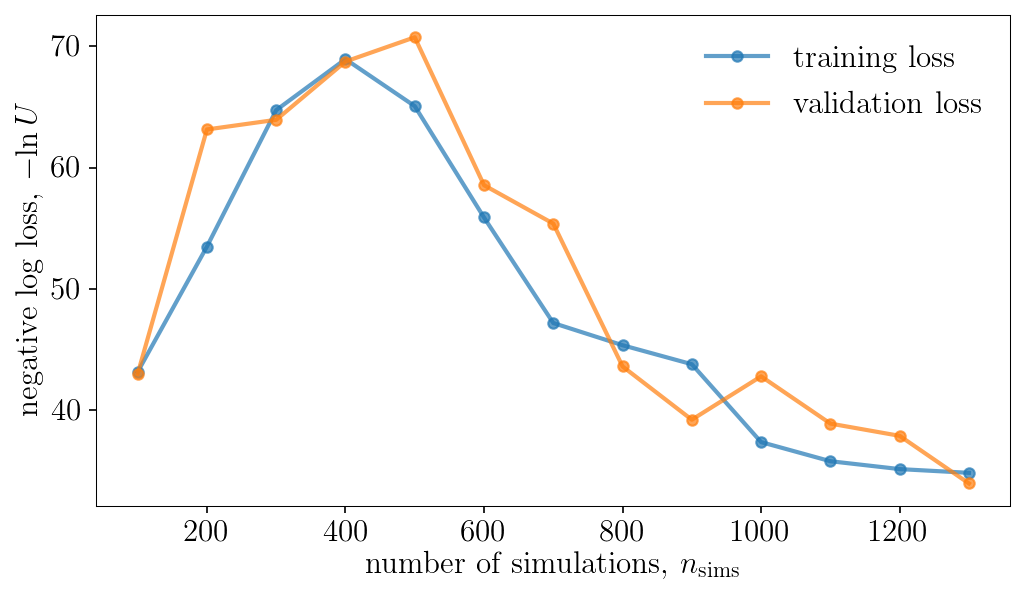

Population 13/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


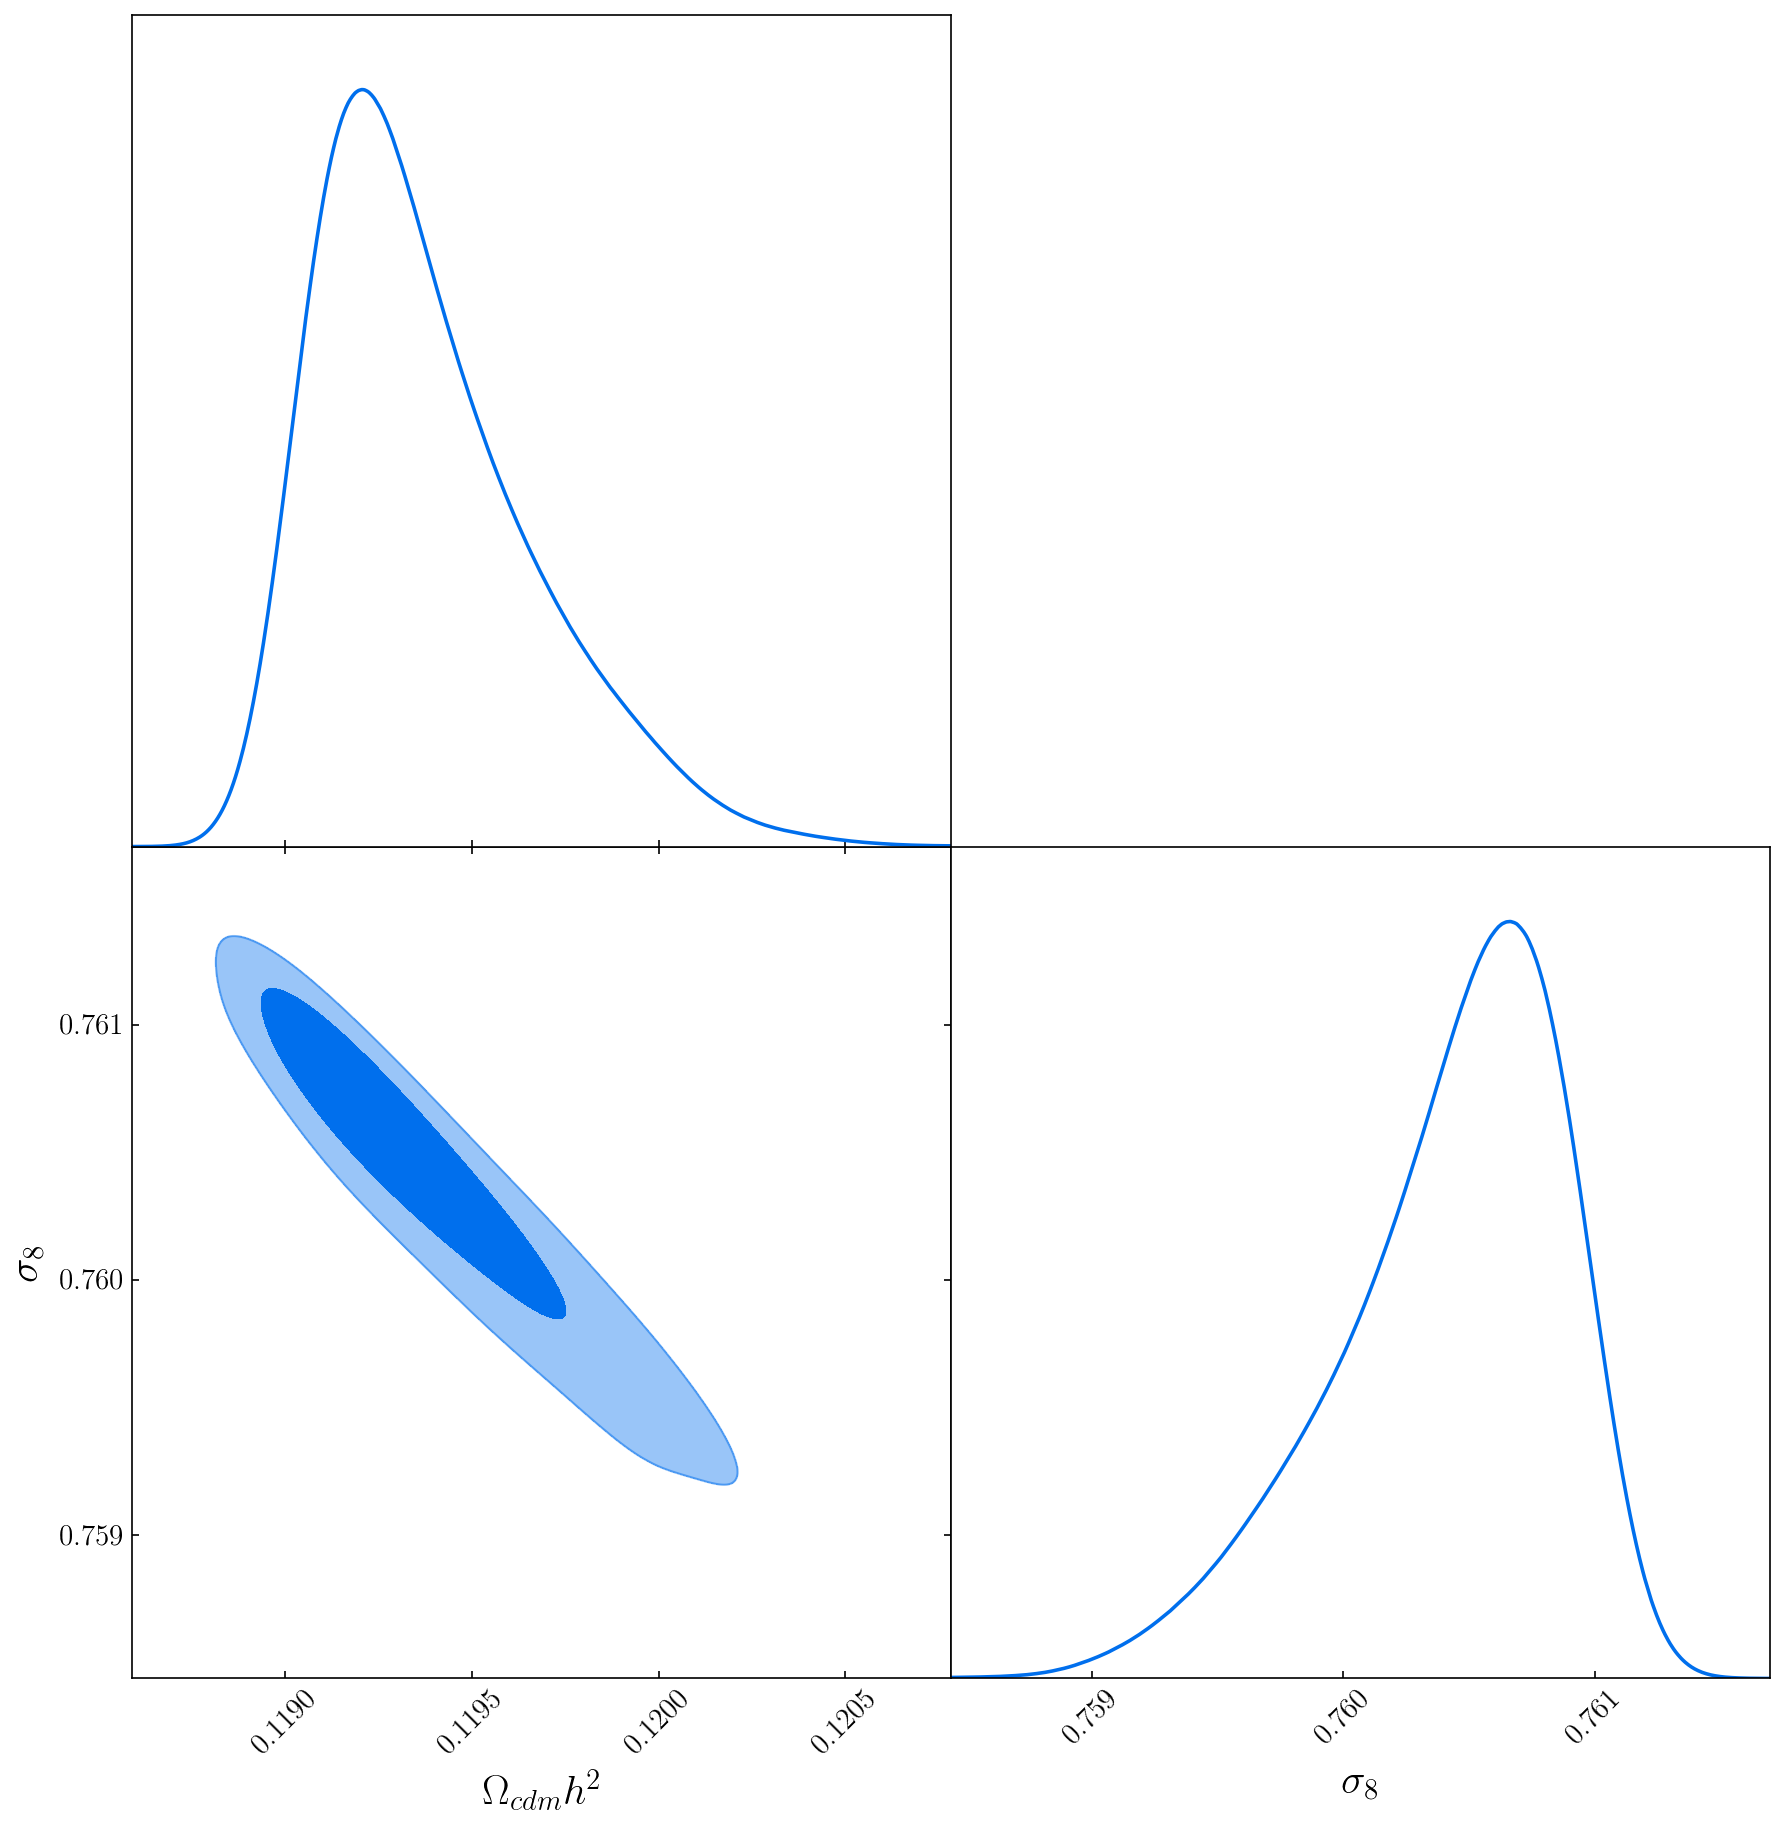

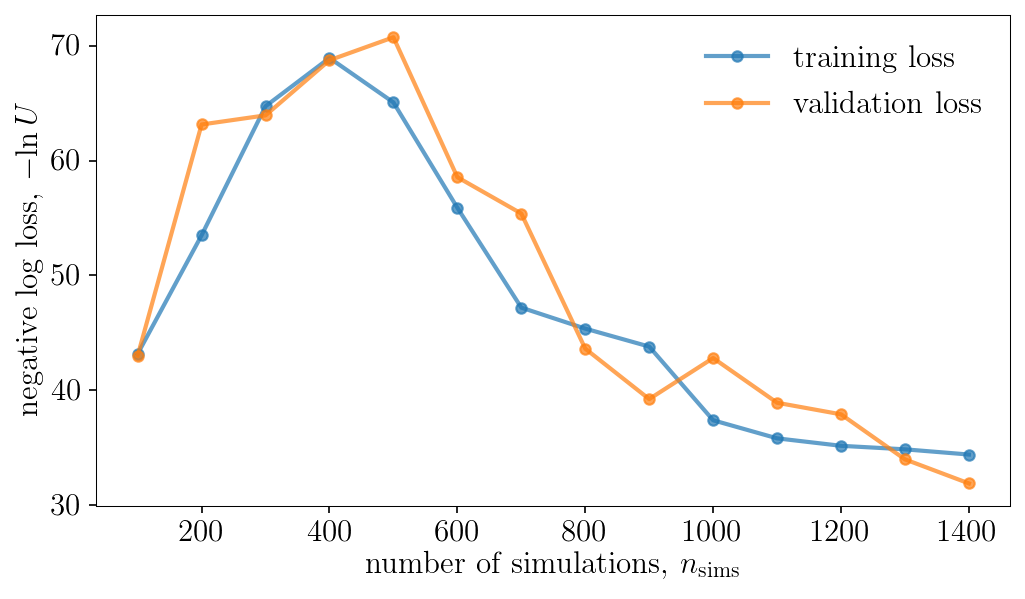

Population 14/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


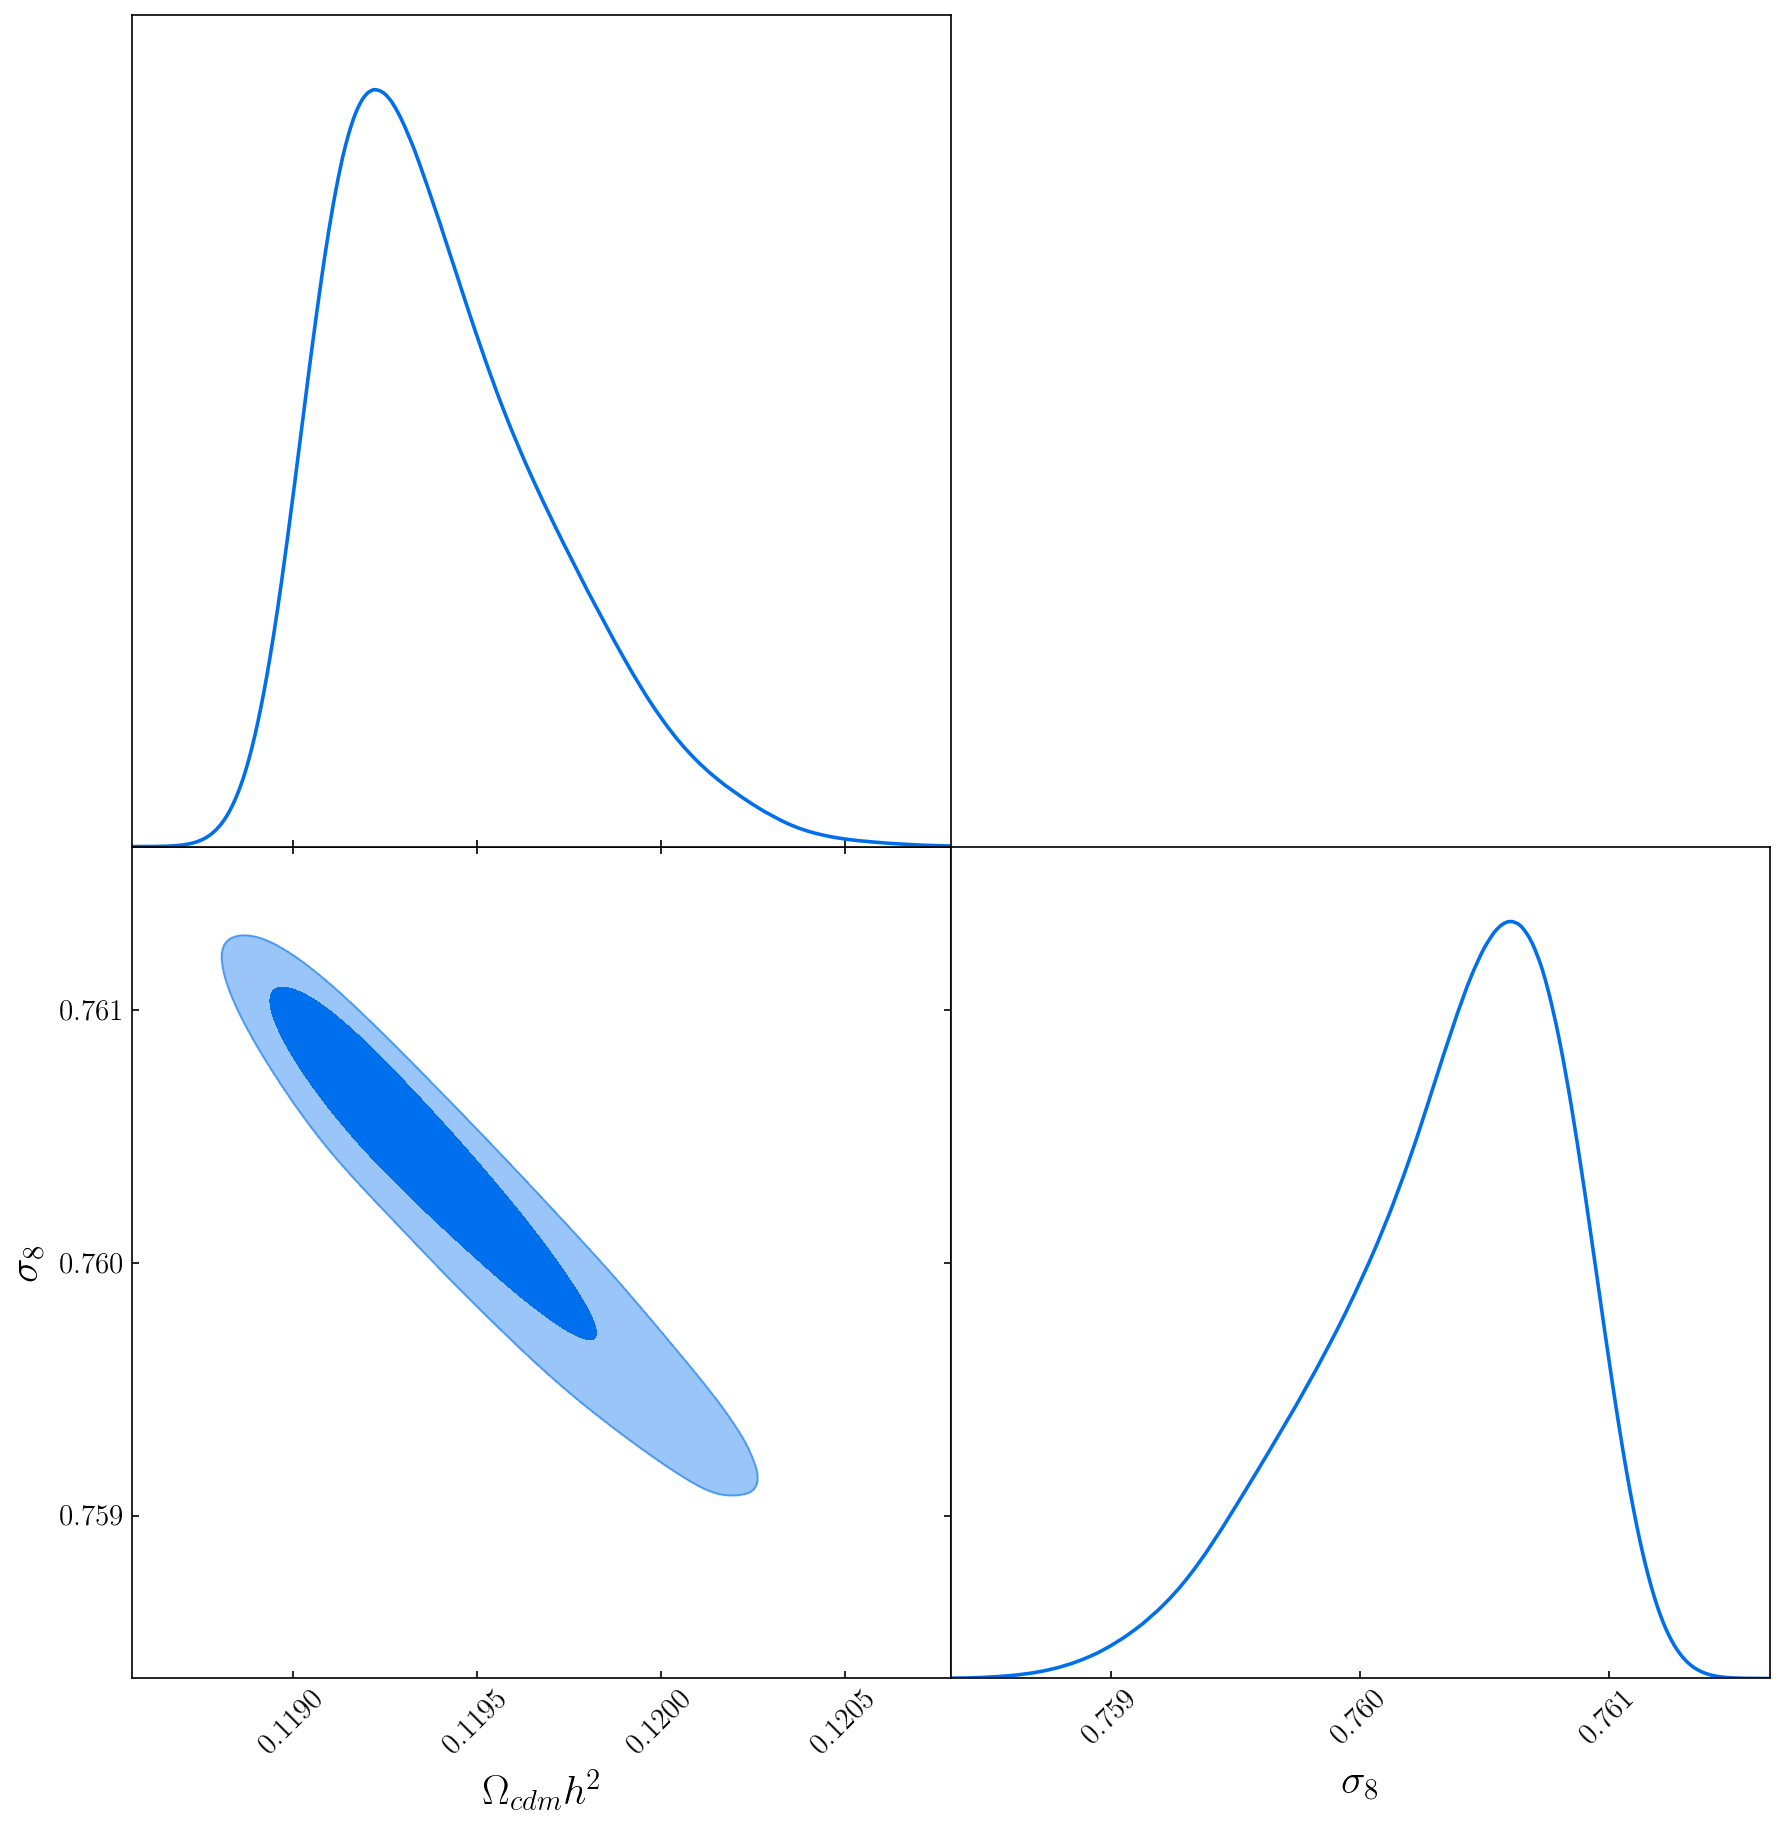

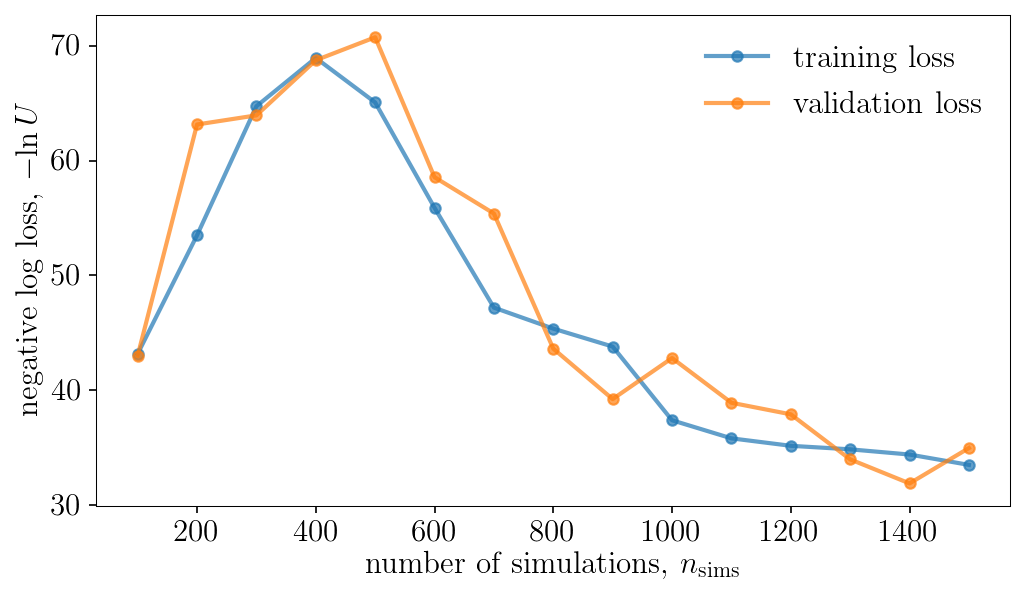

Population 15/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


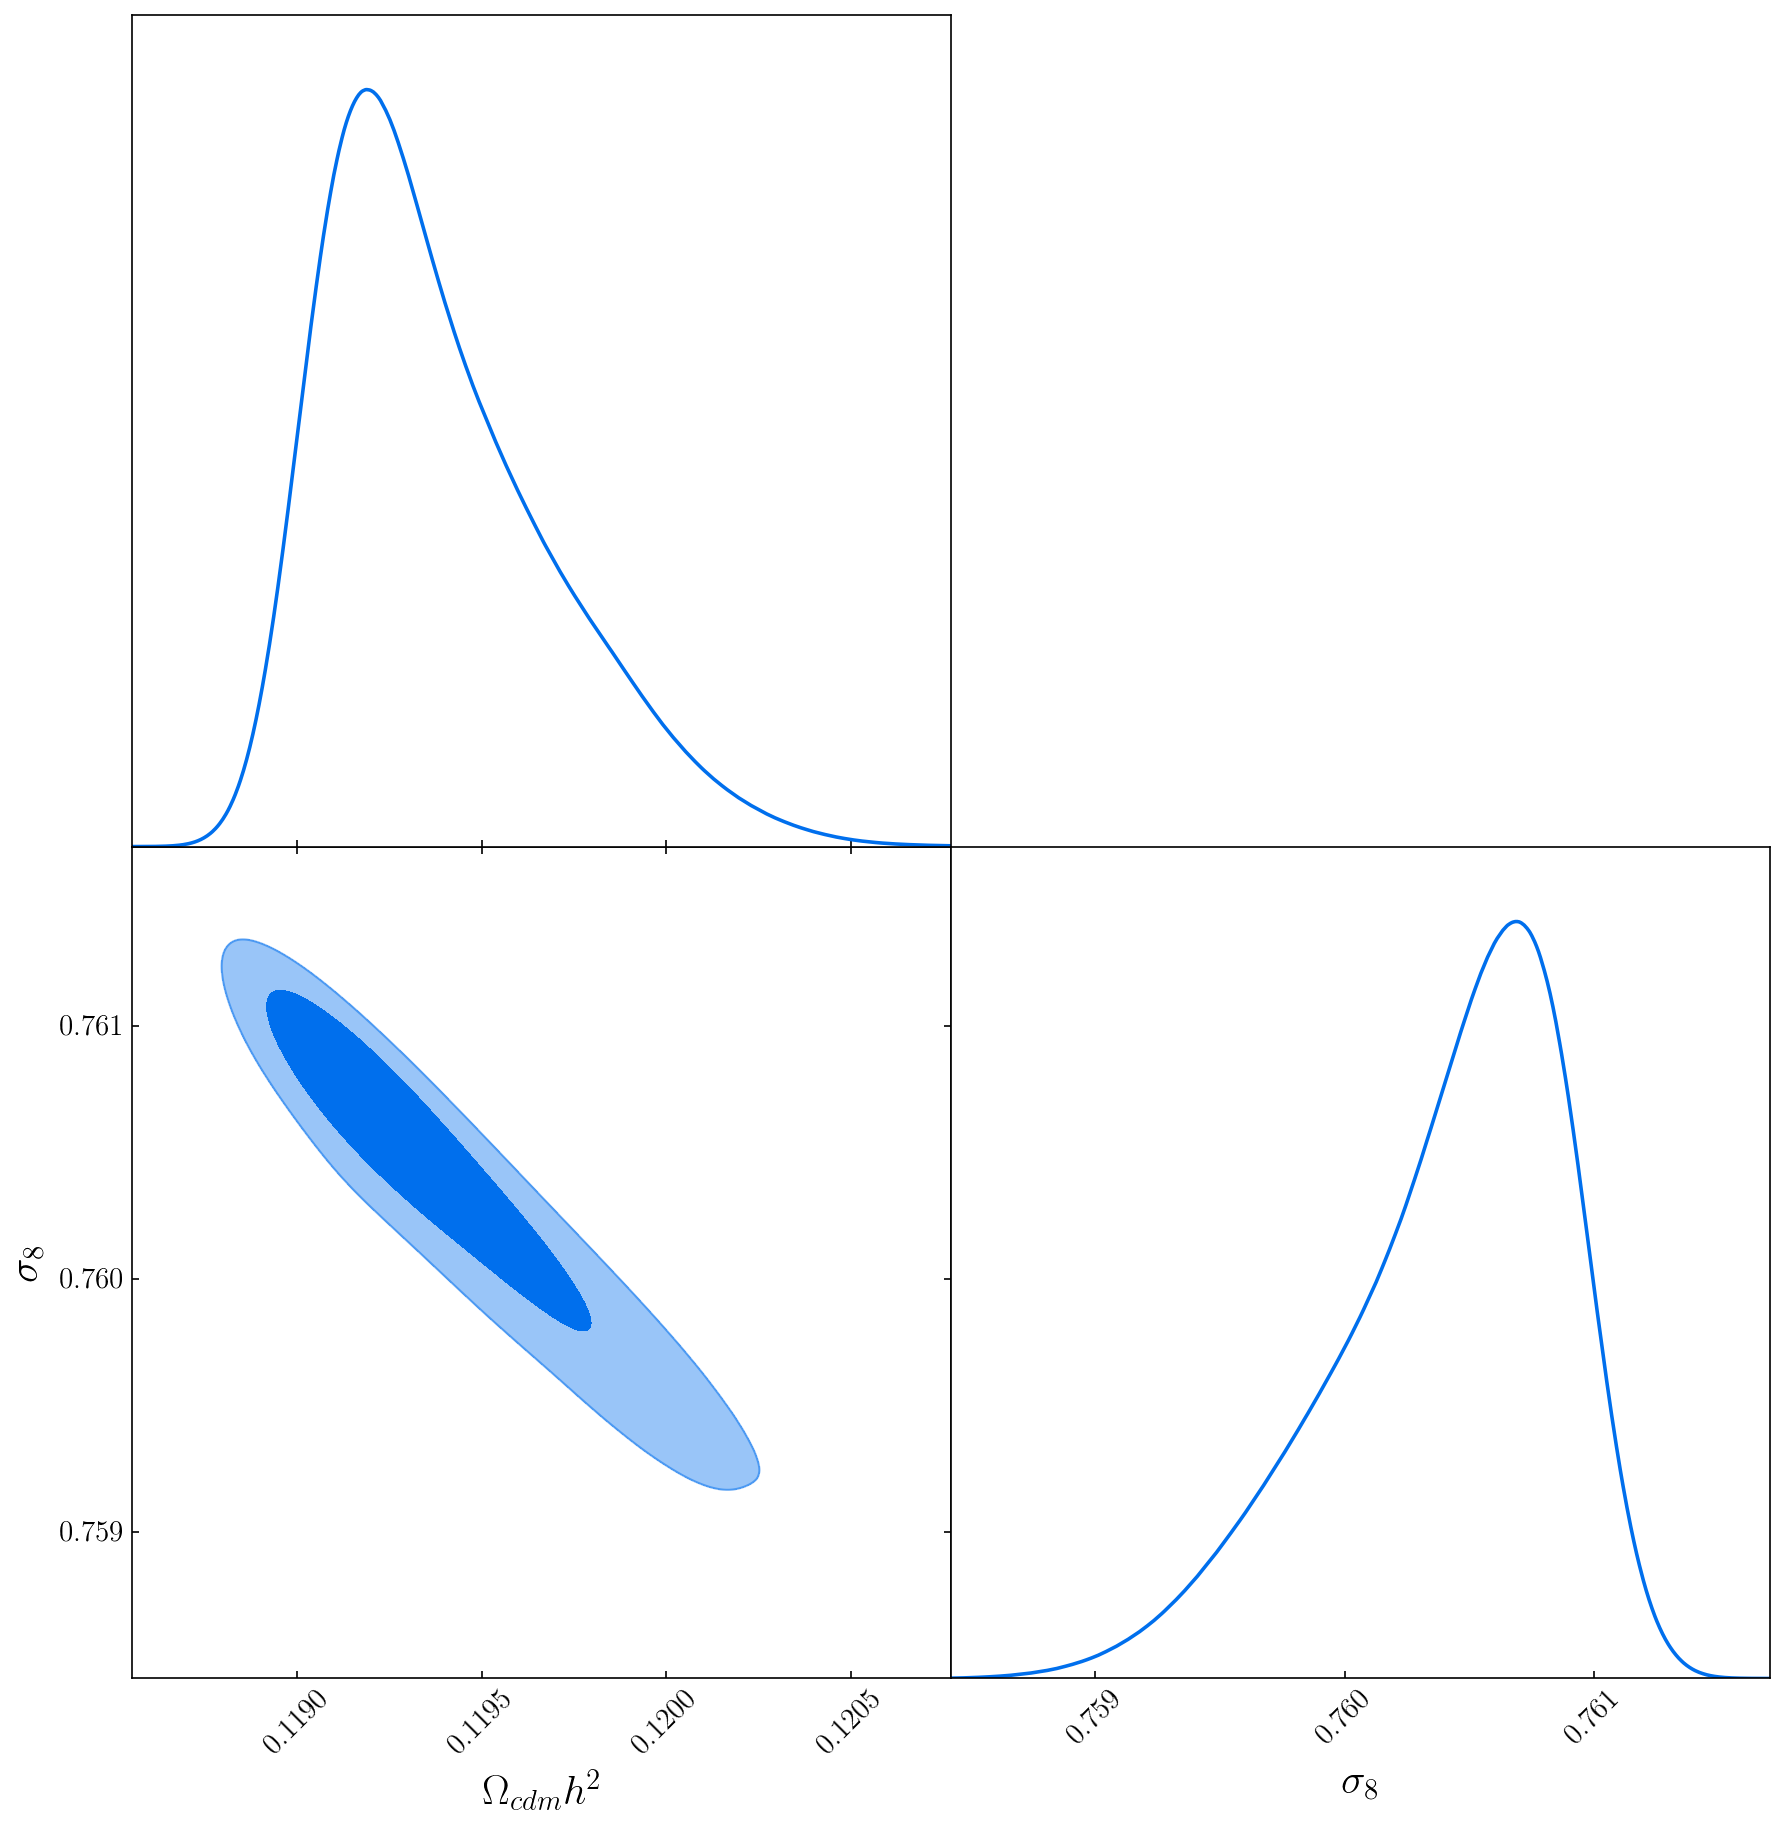

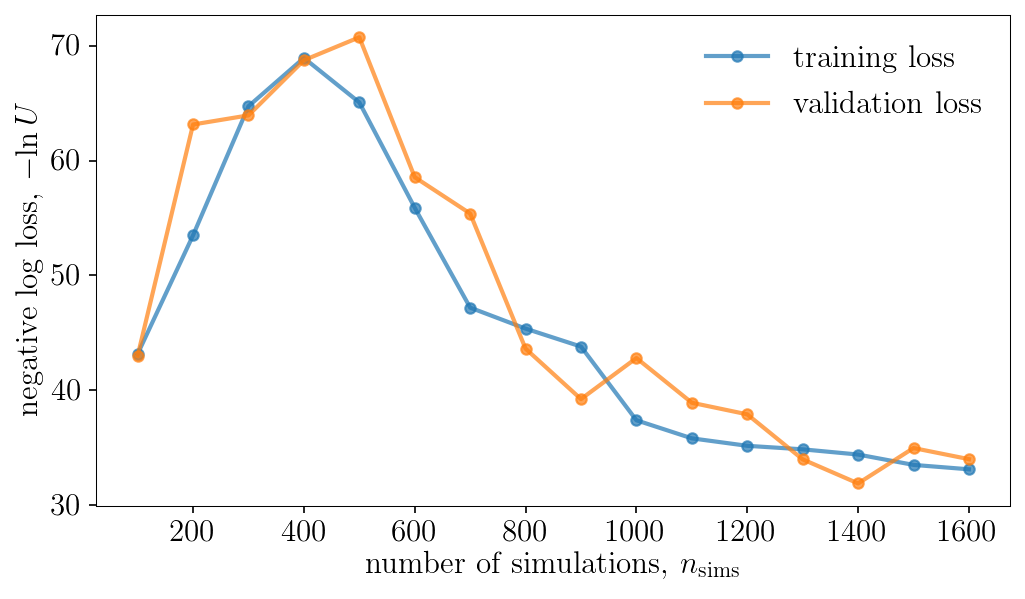

Population 16/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


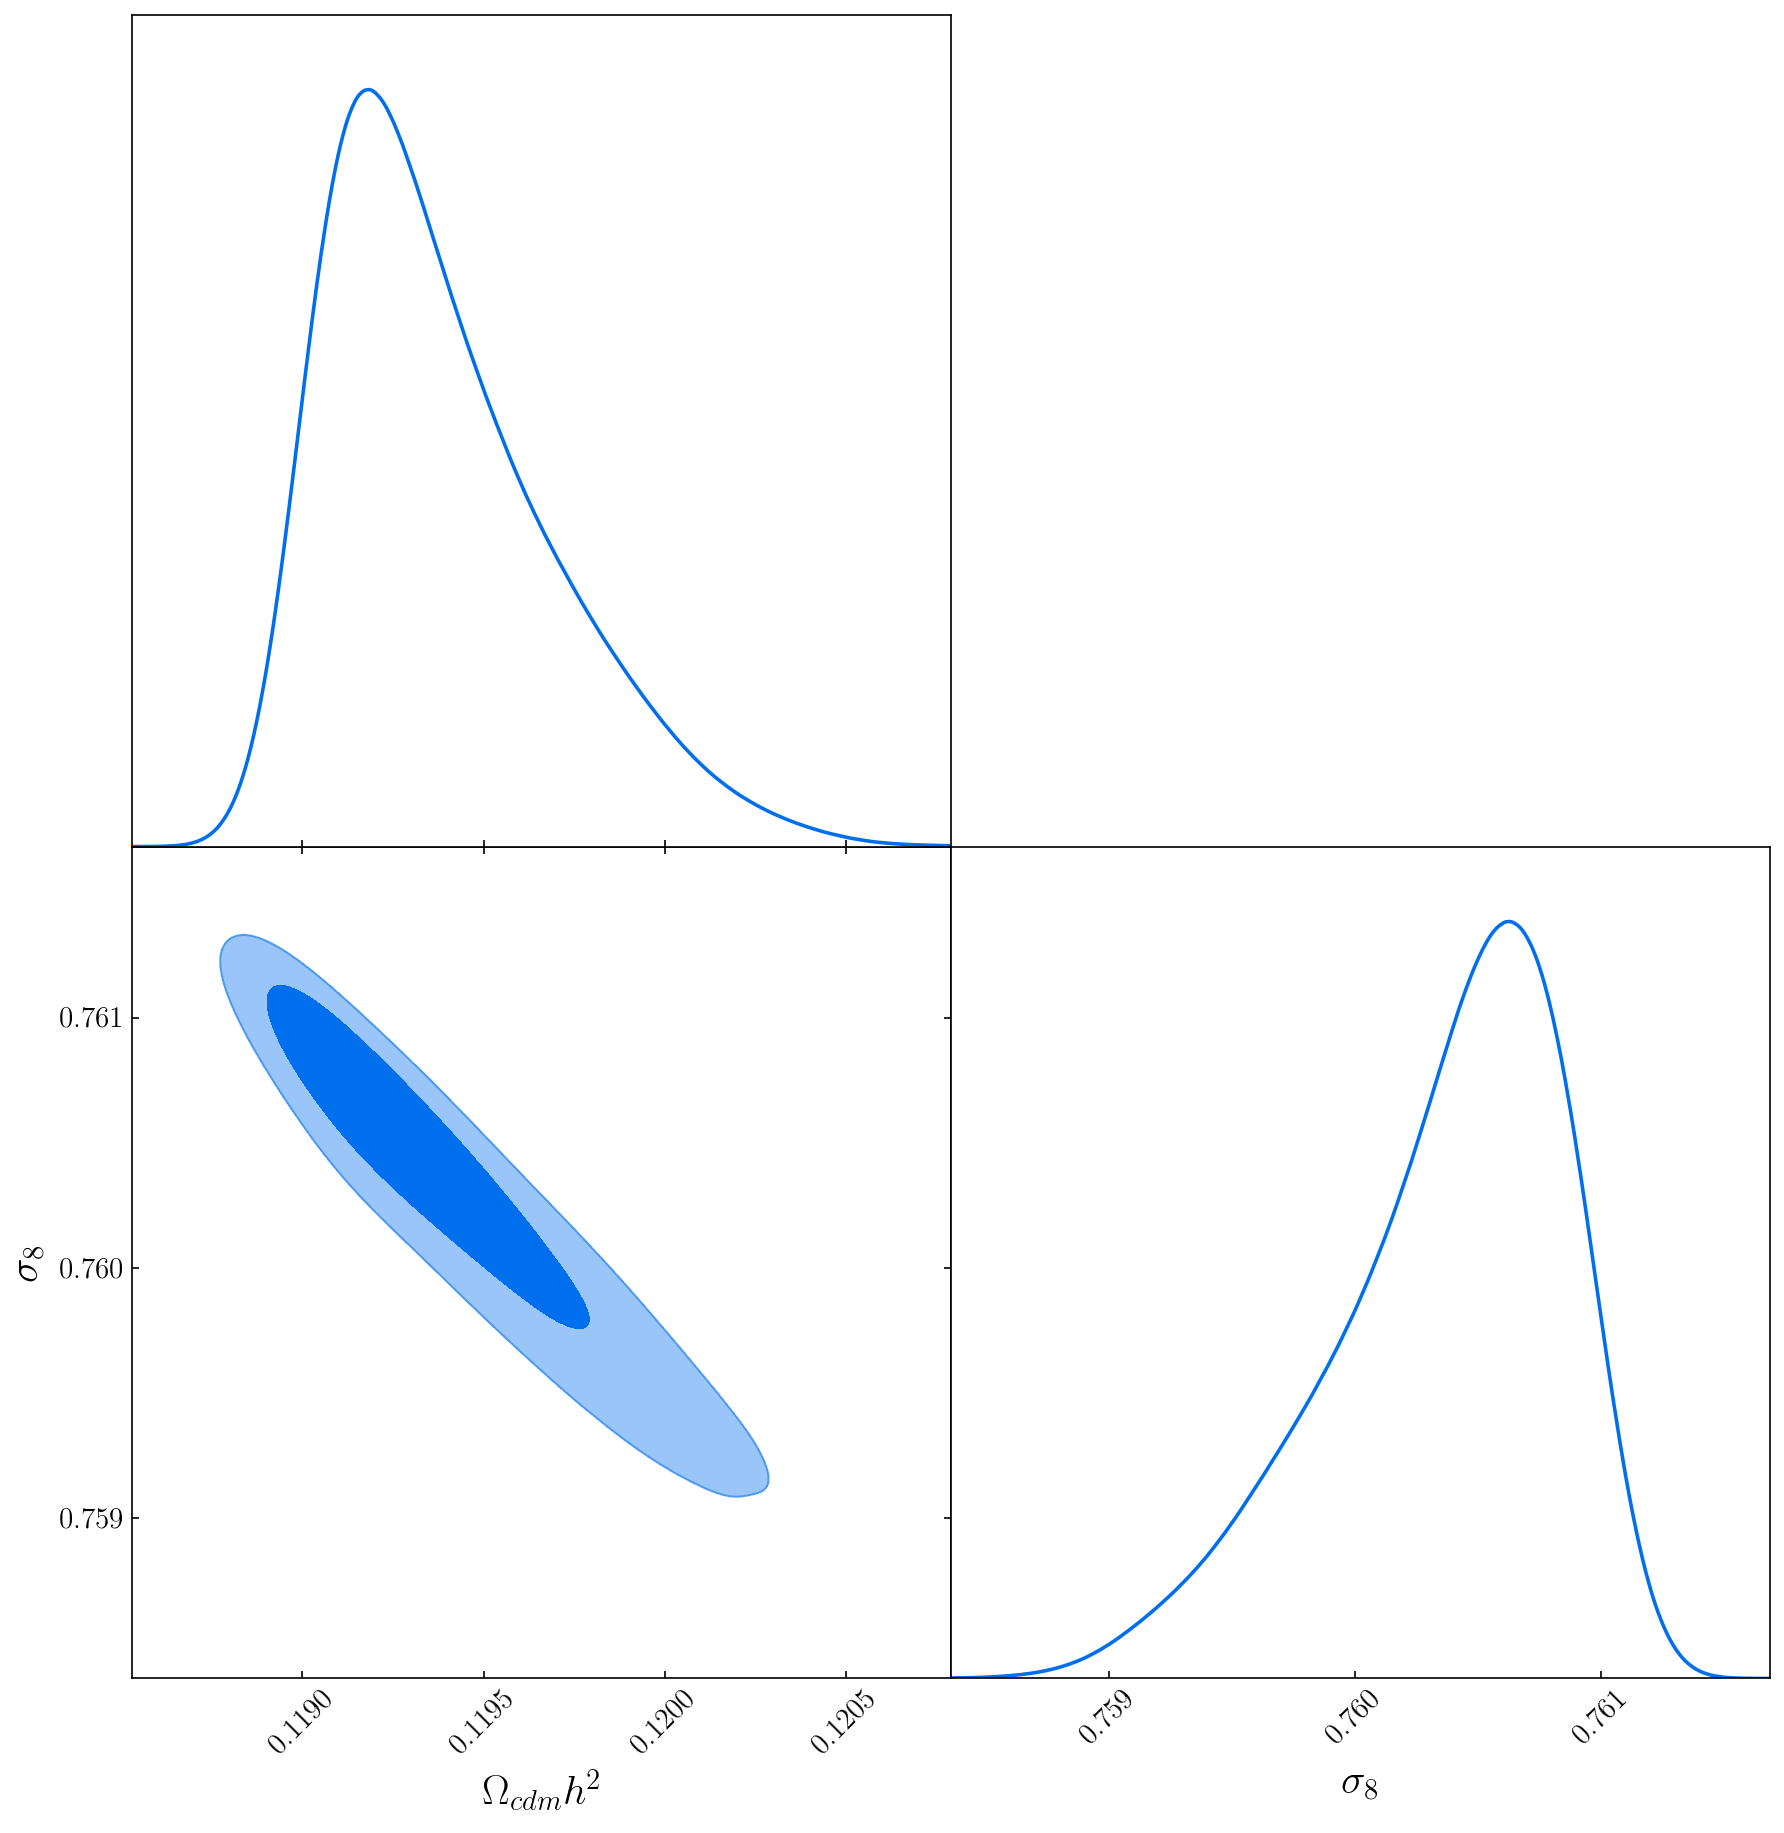

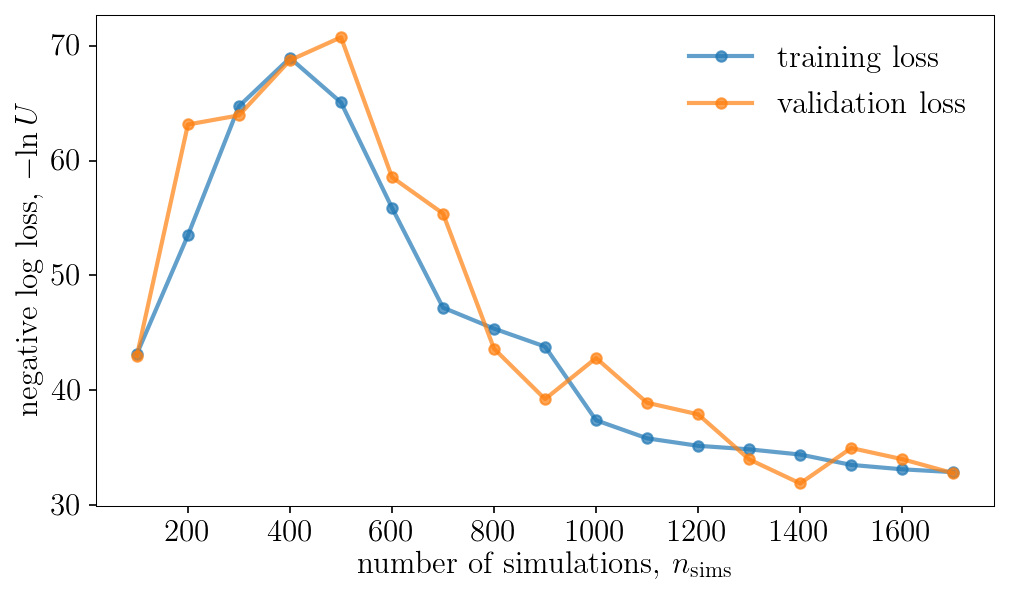

Population 17/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


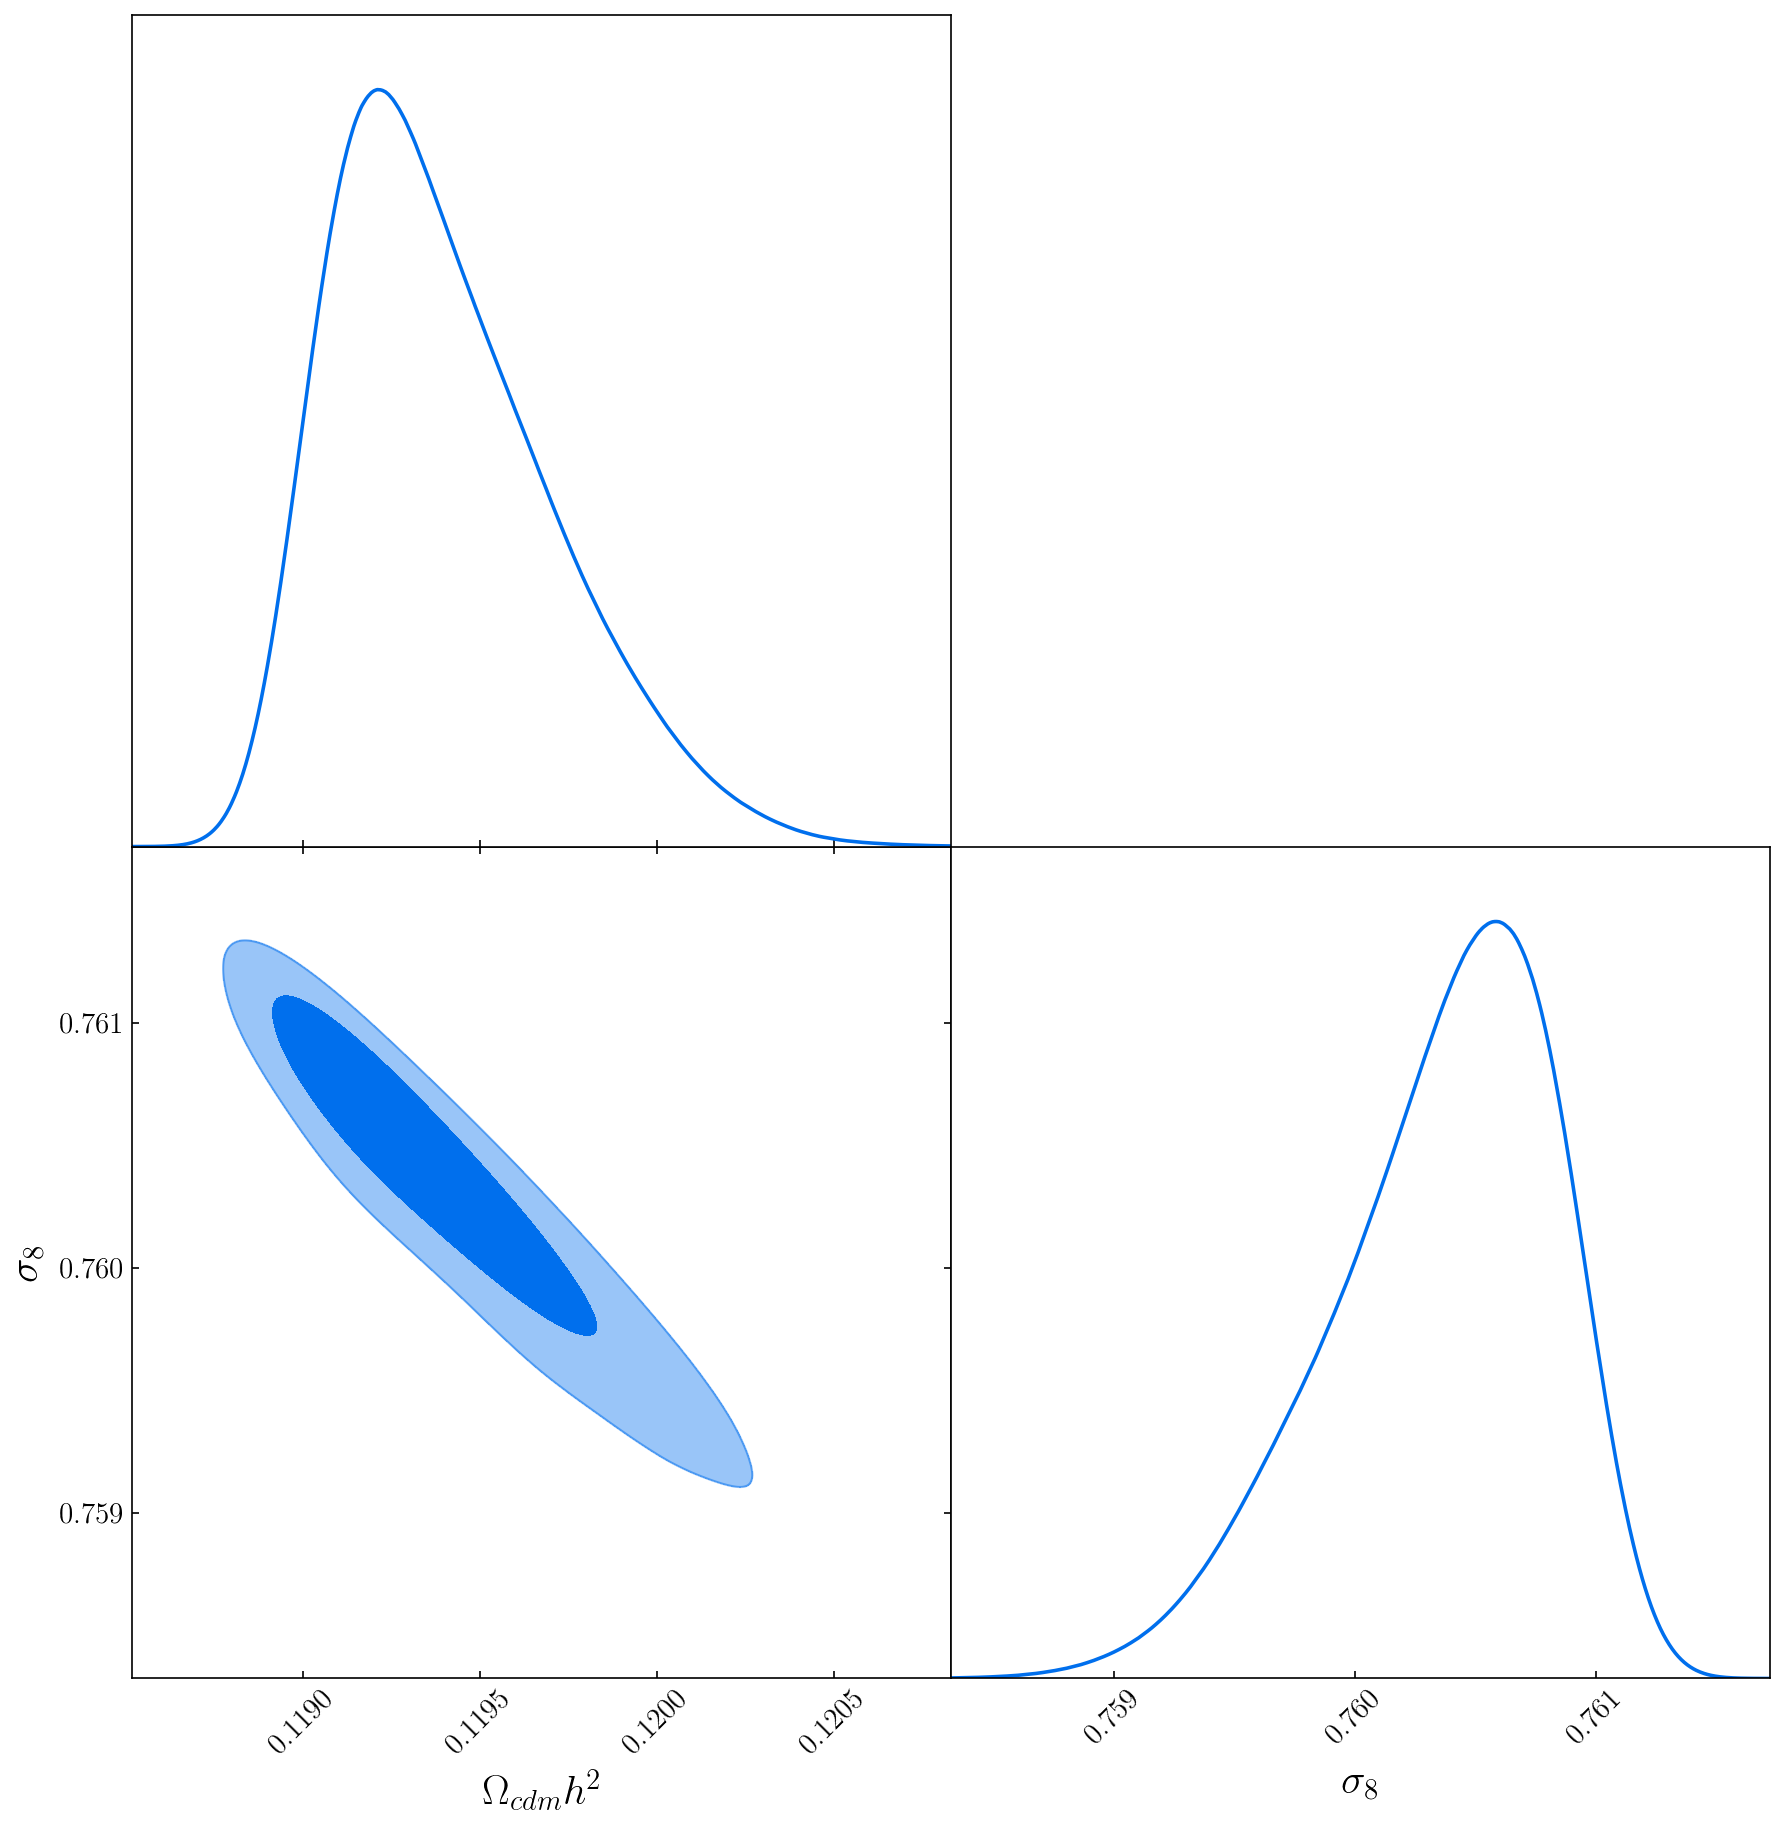

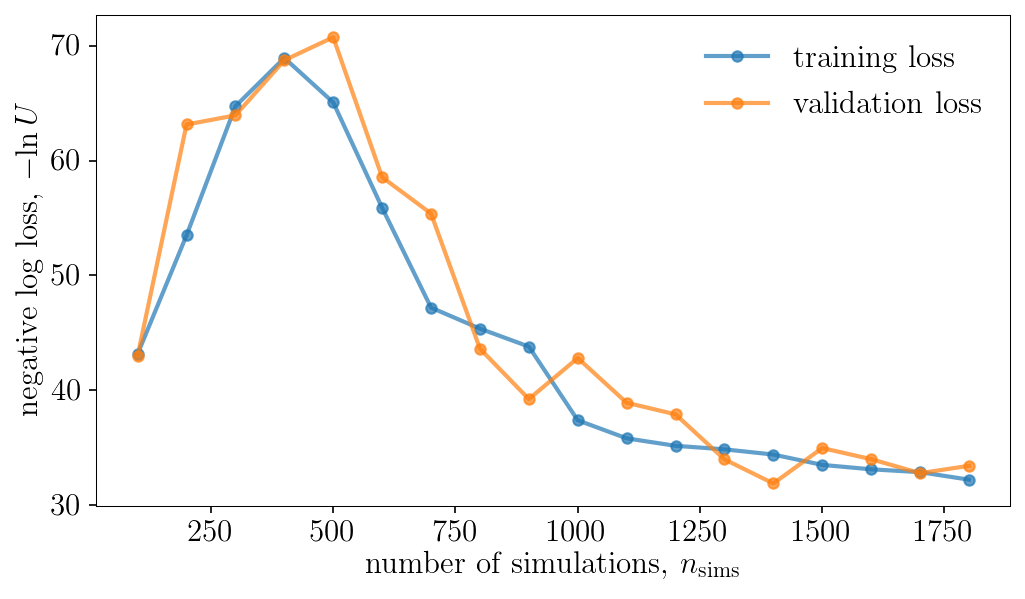

Population 18/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


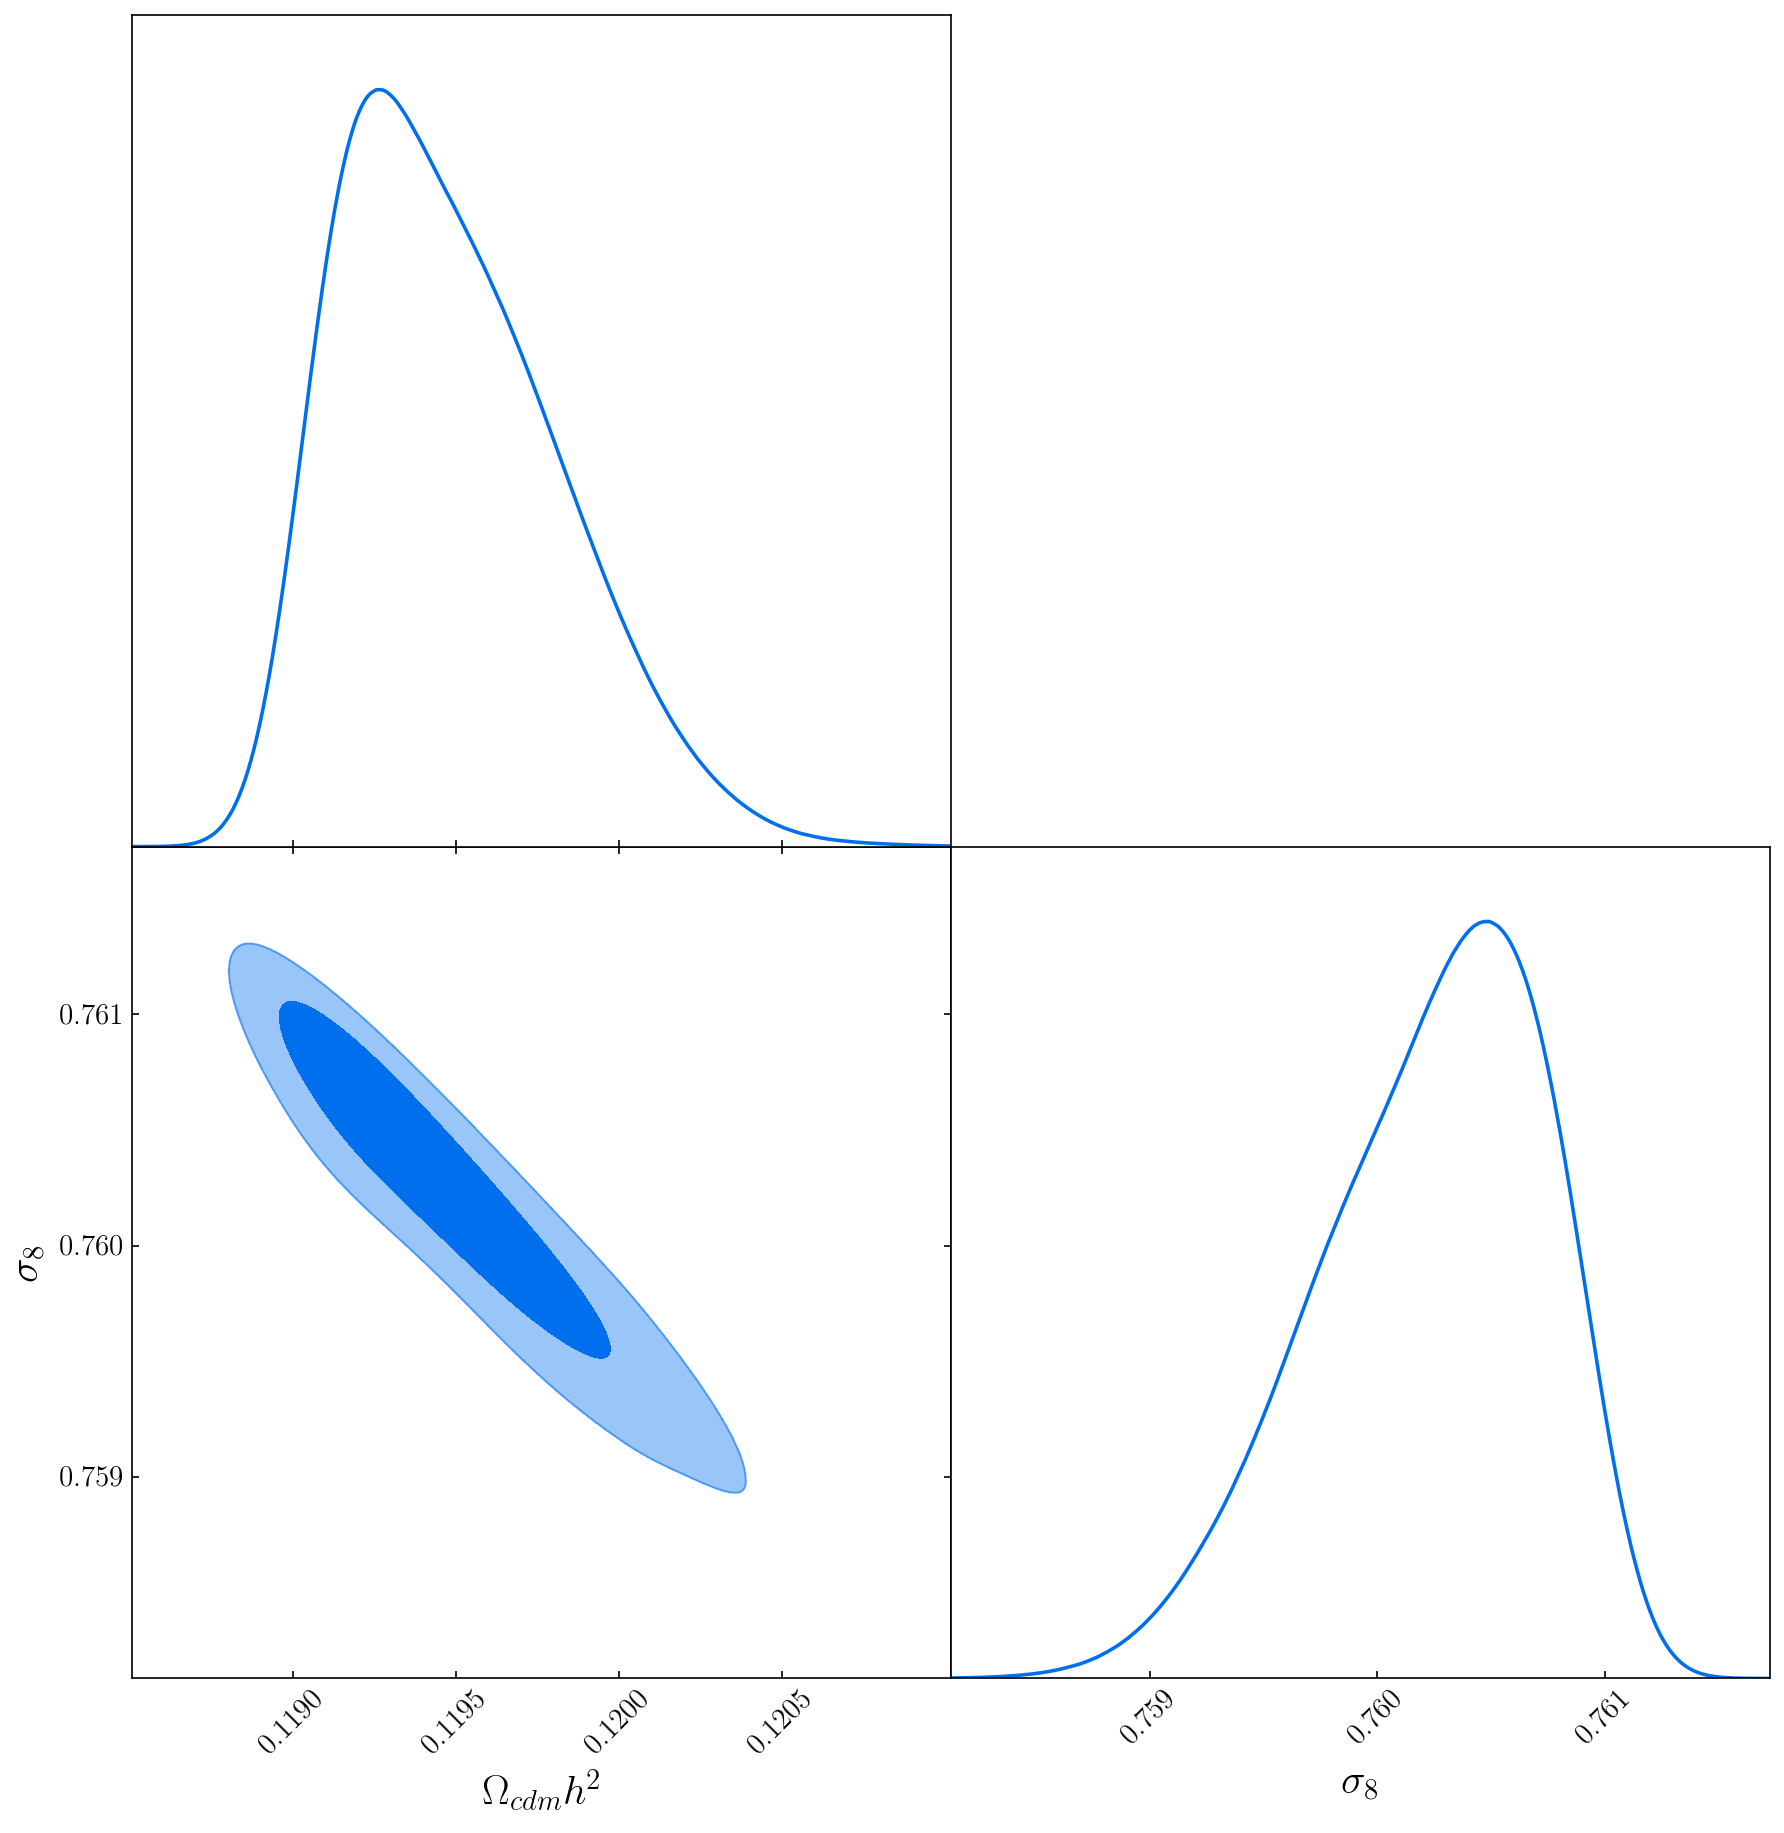

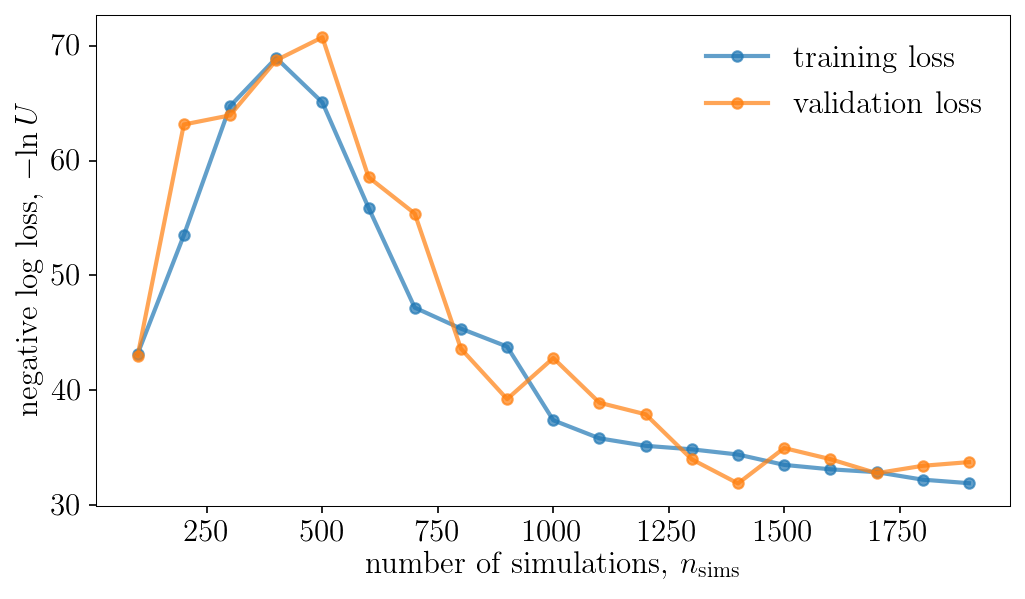

Population 19/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


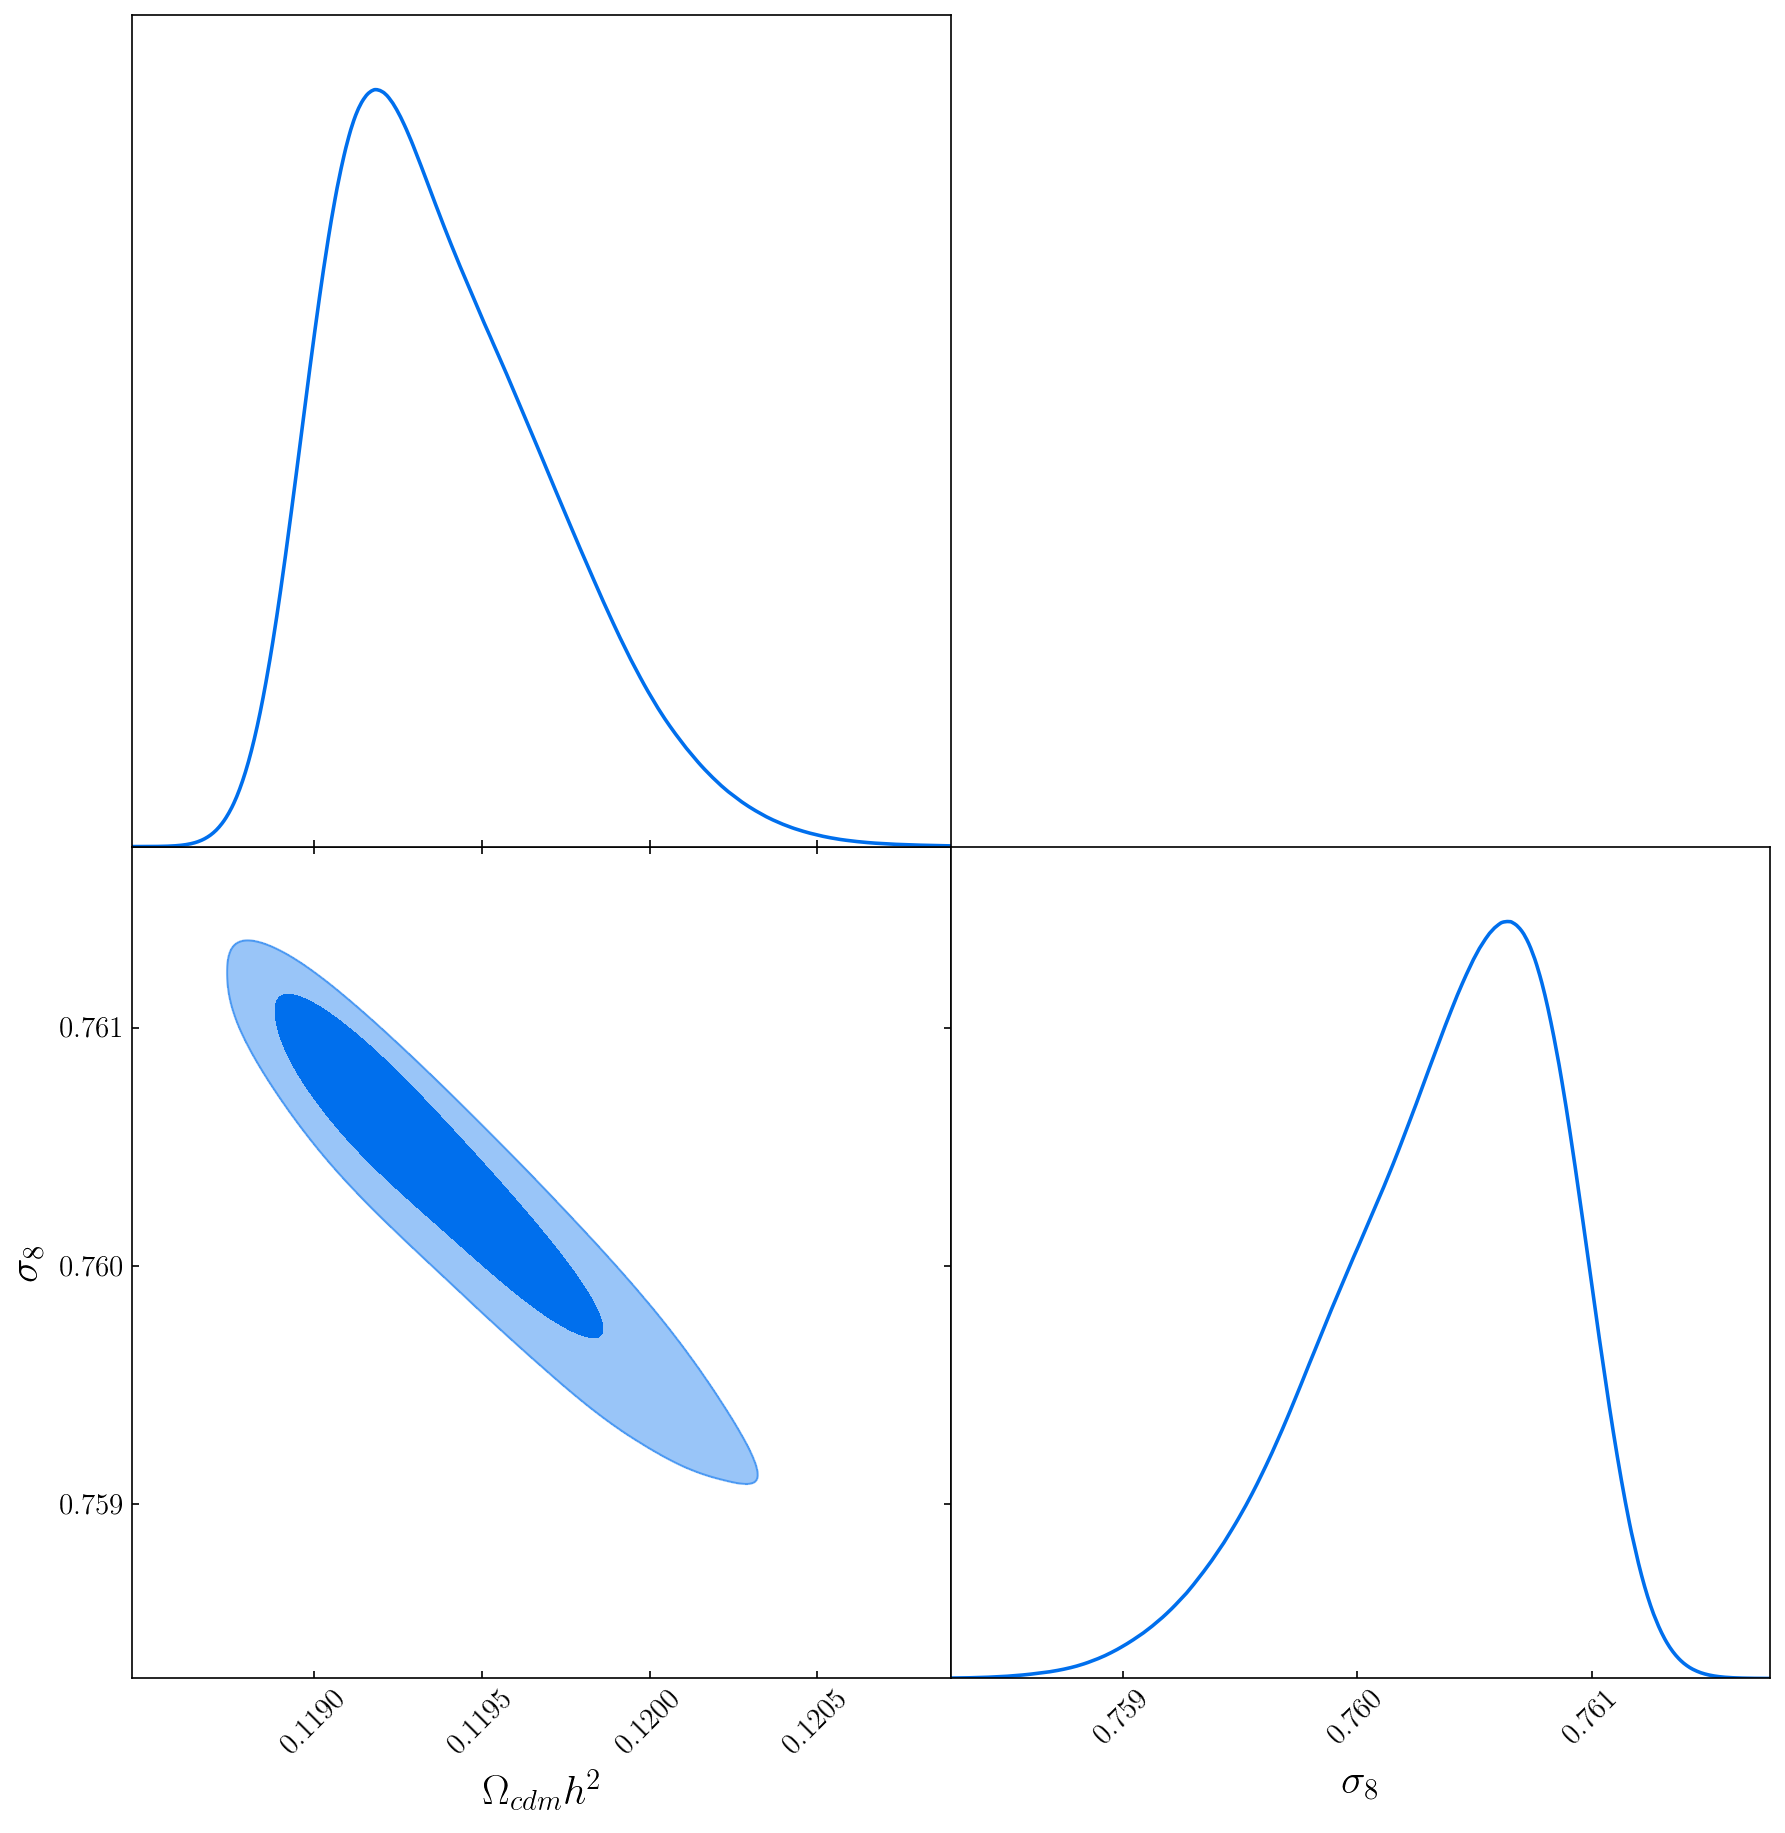

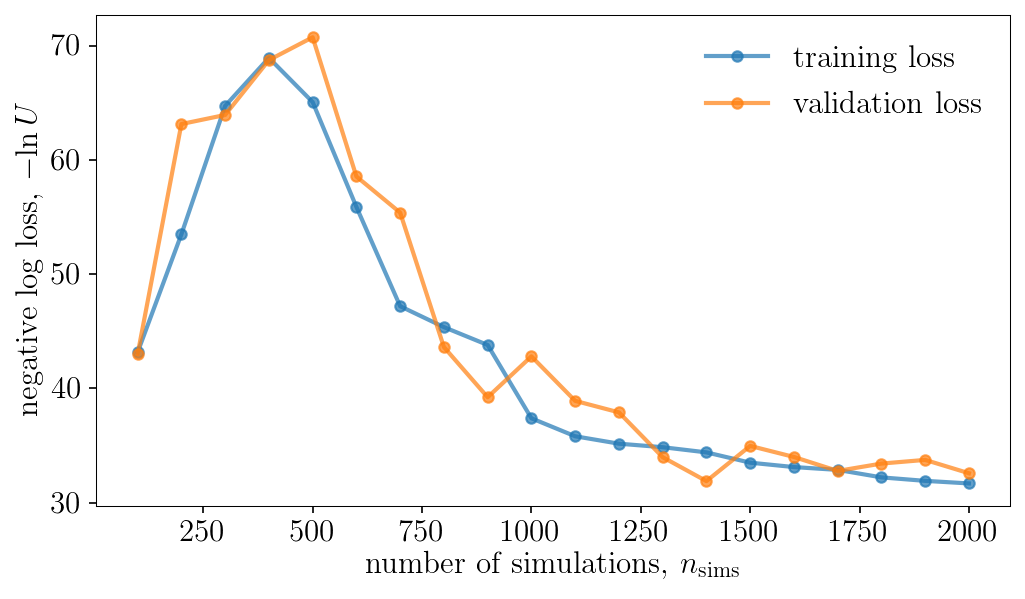

Population 20/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


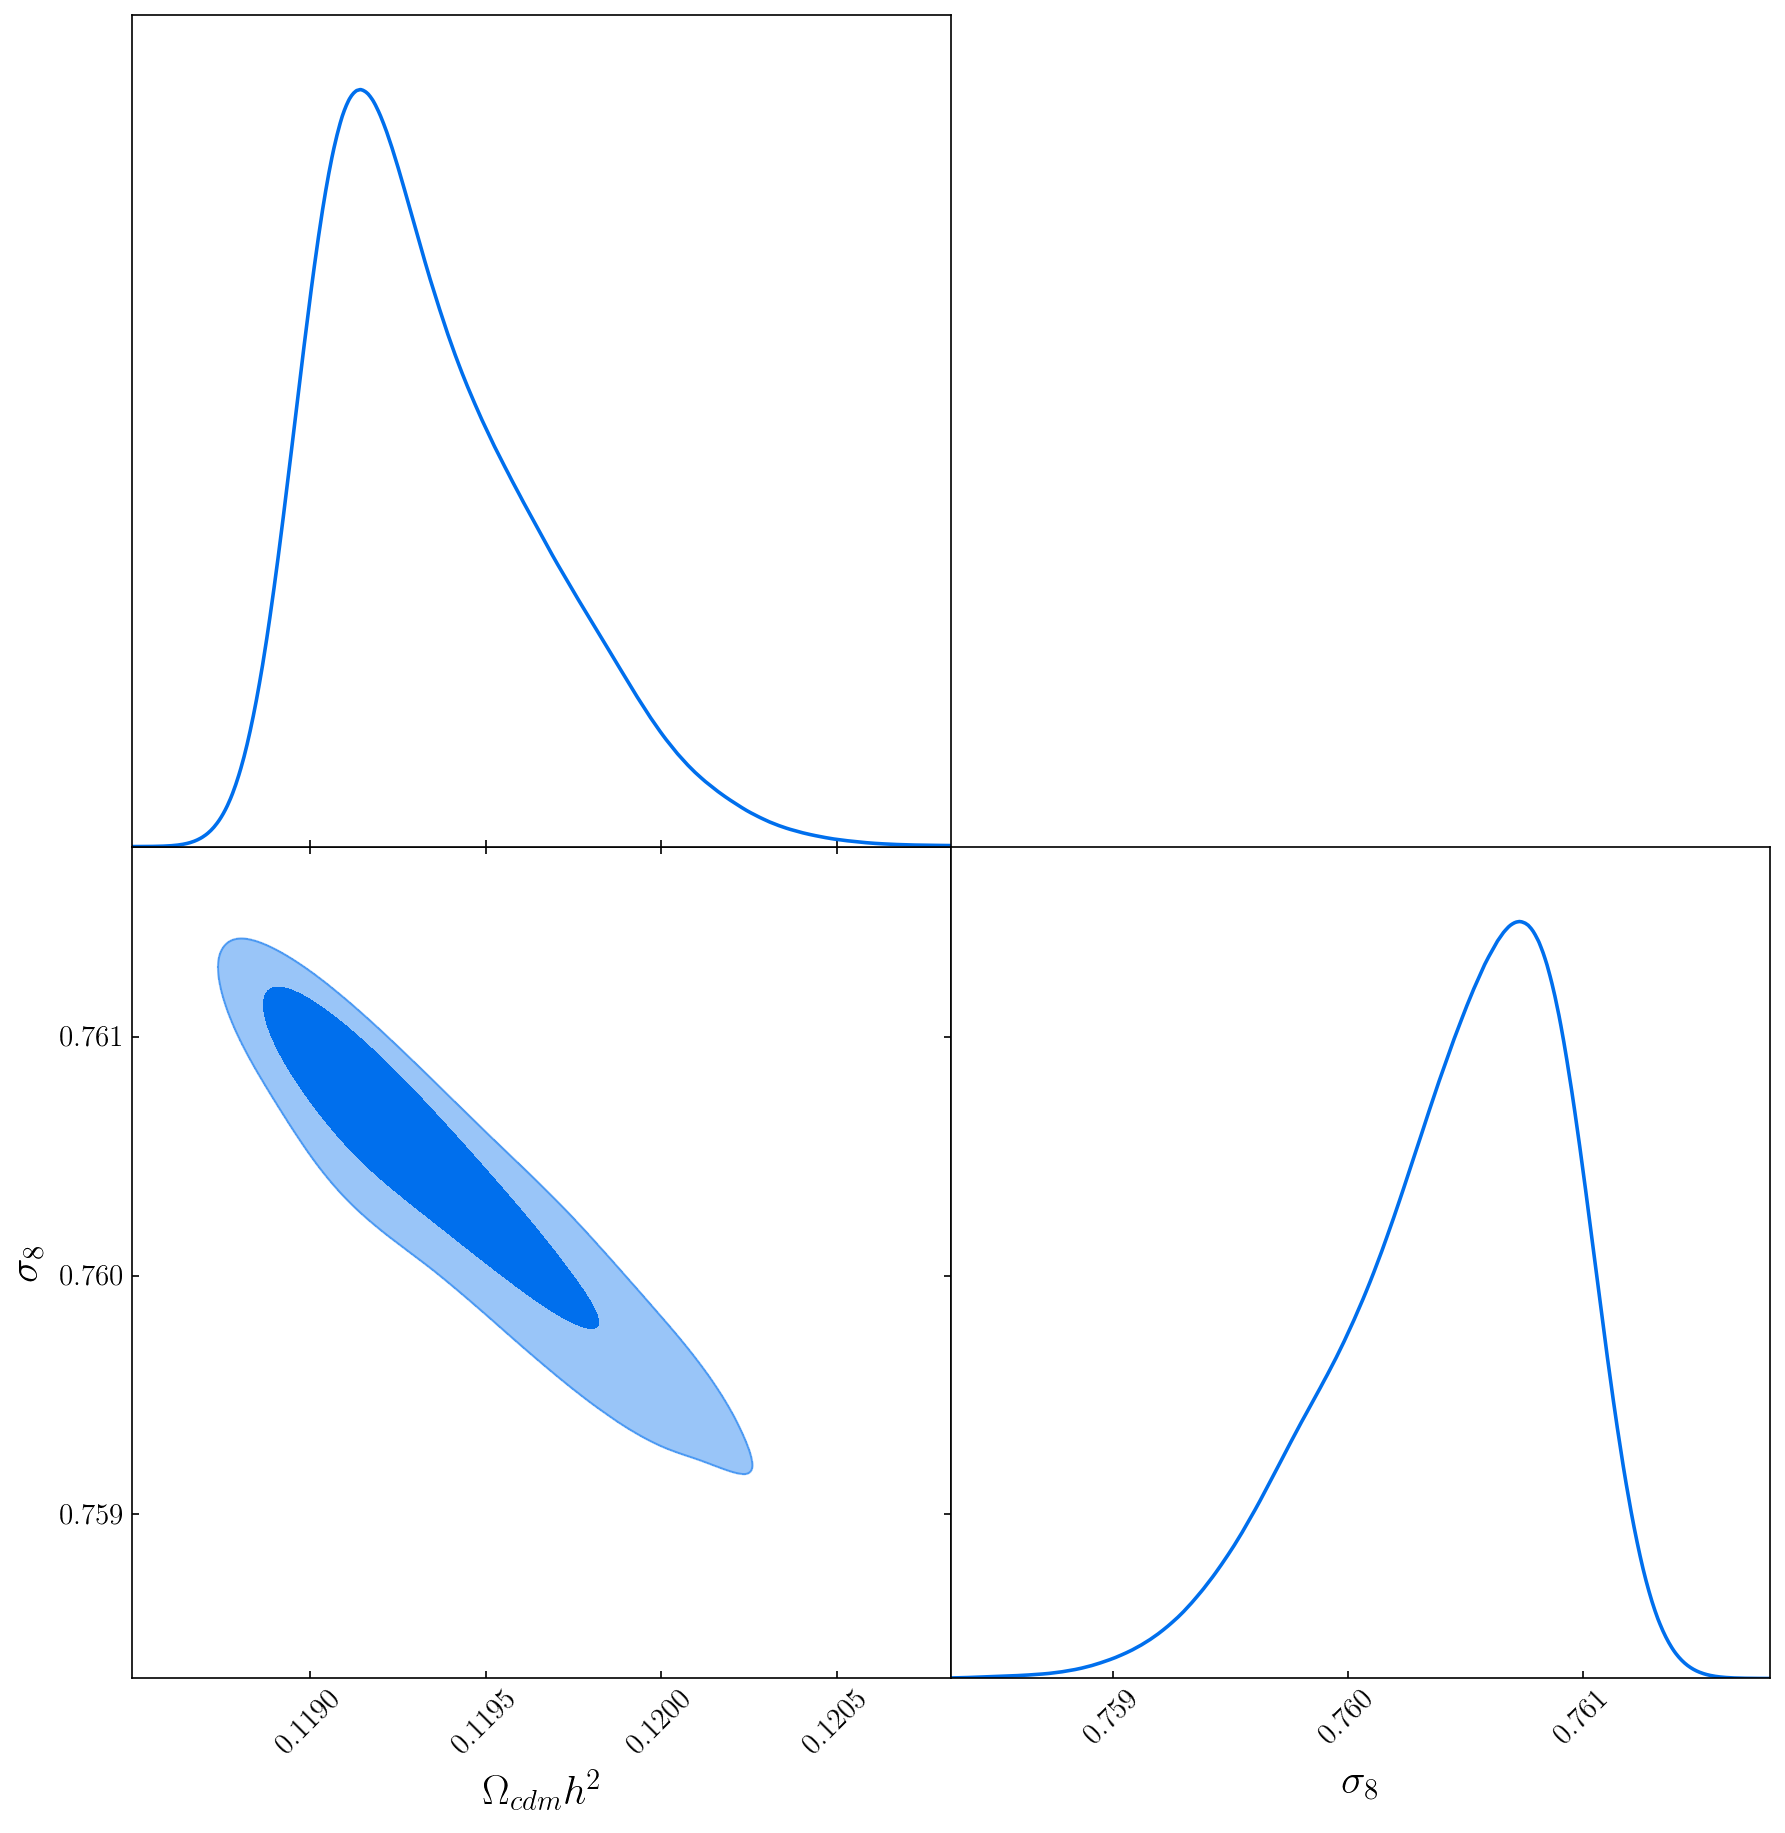

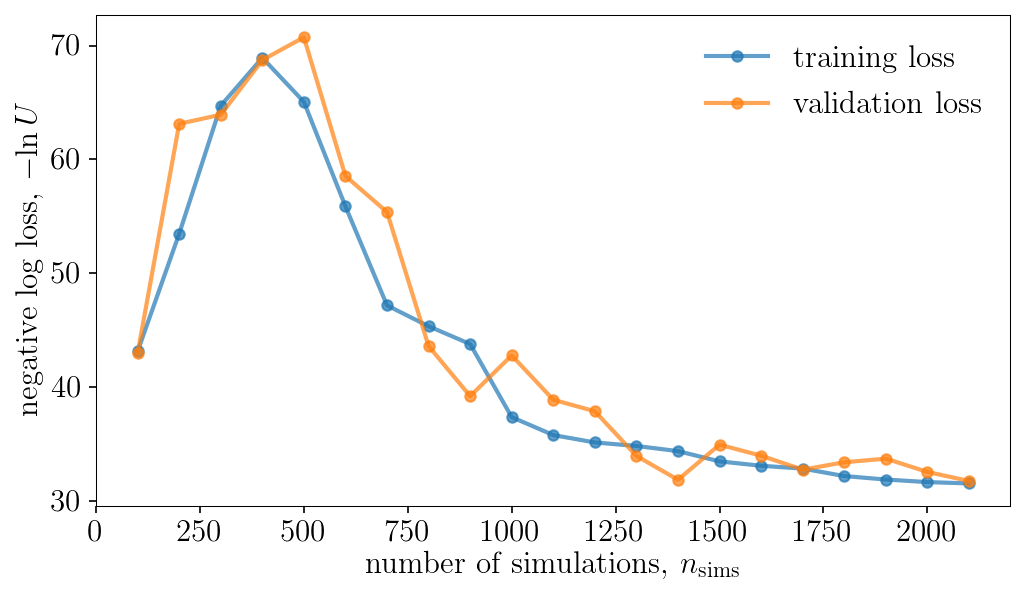

Population 21/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


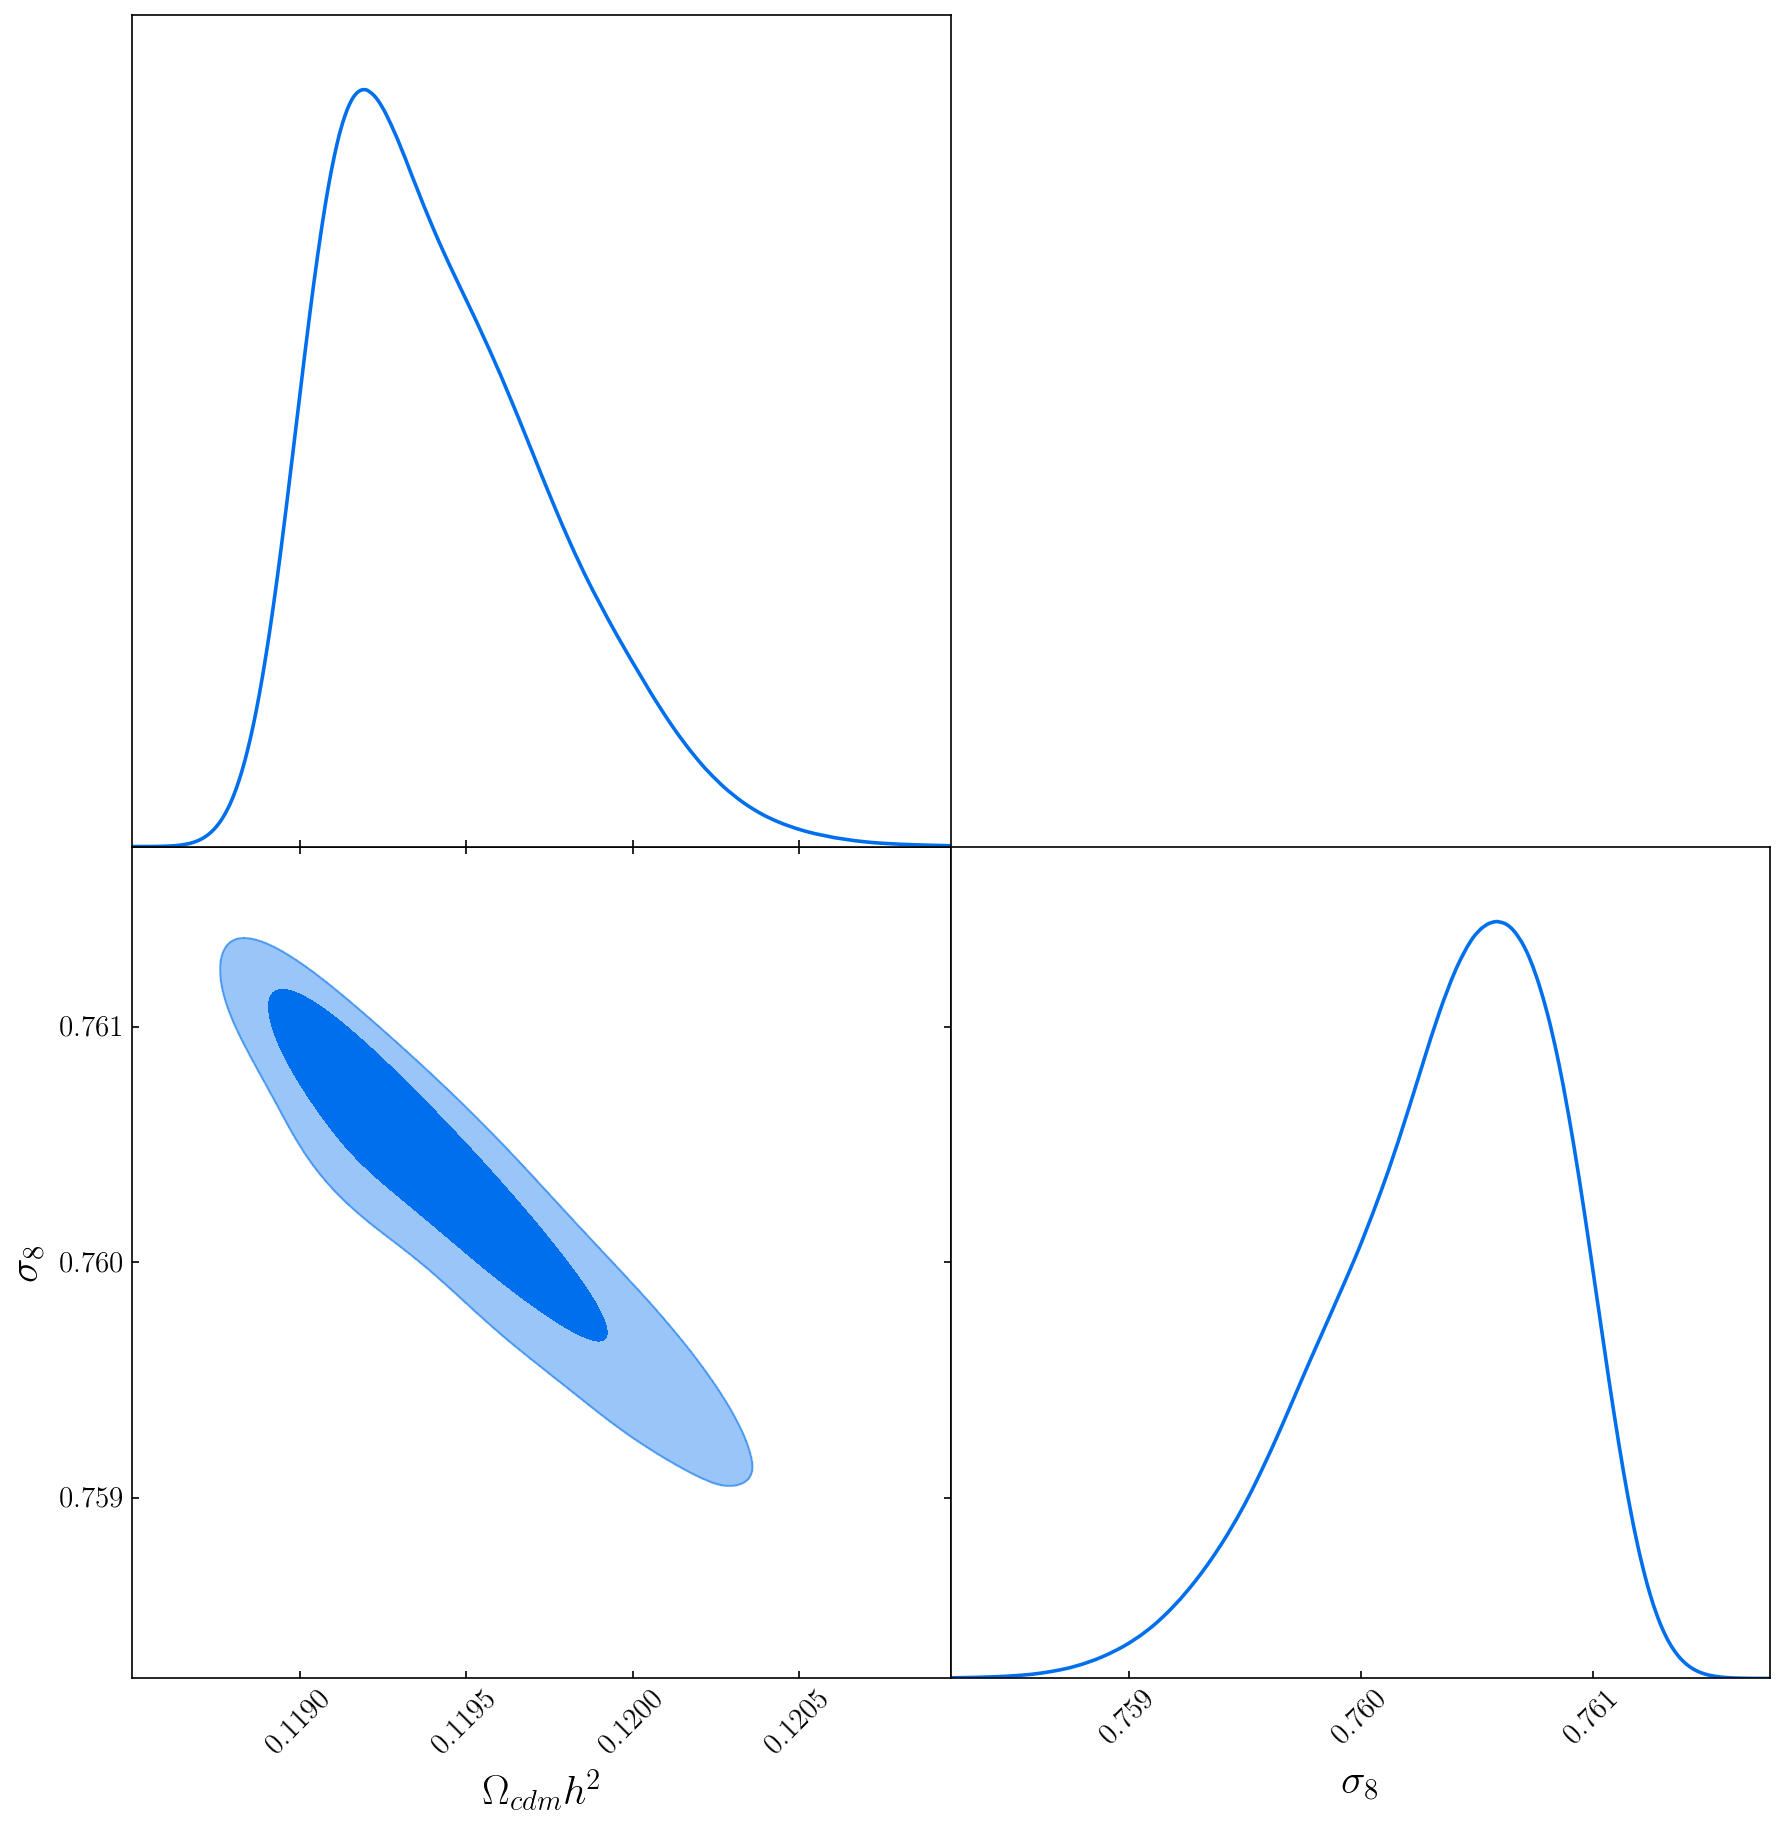

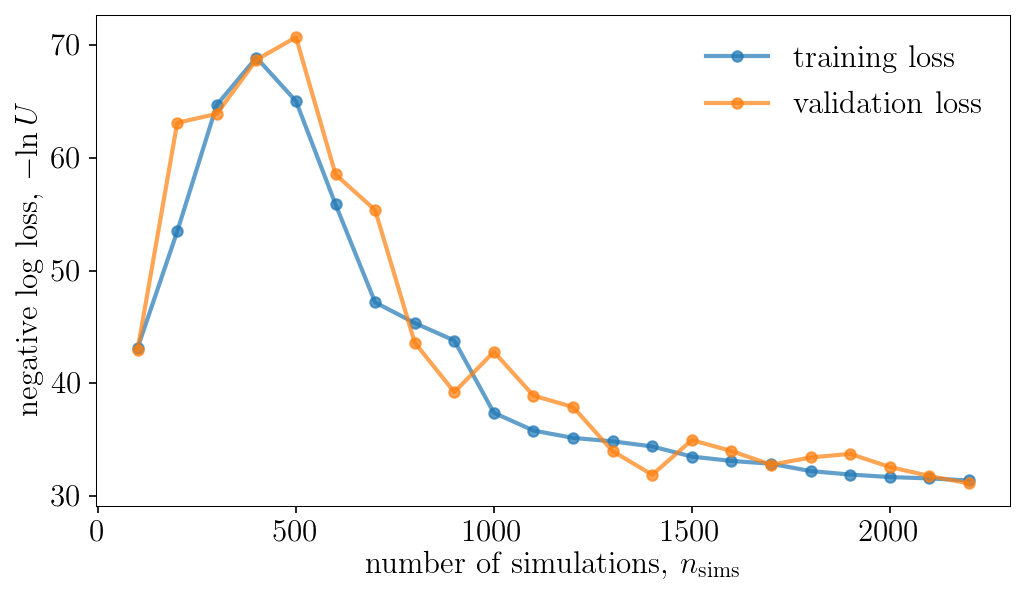

Population 22/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


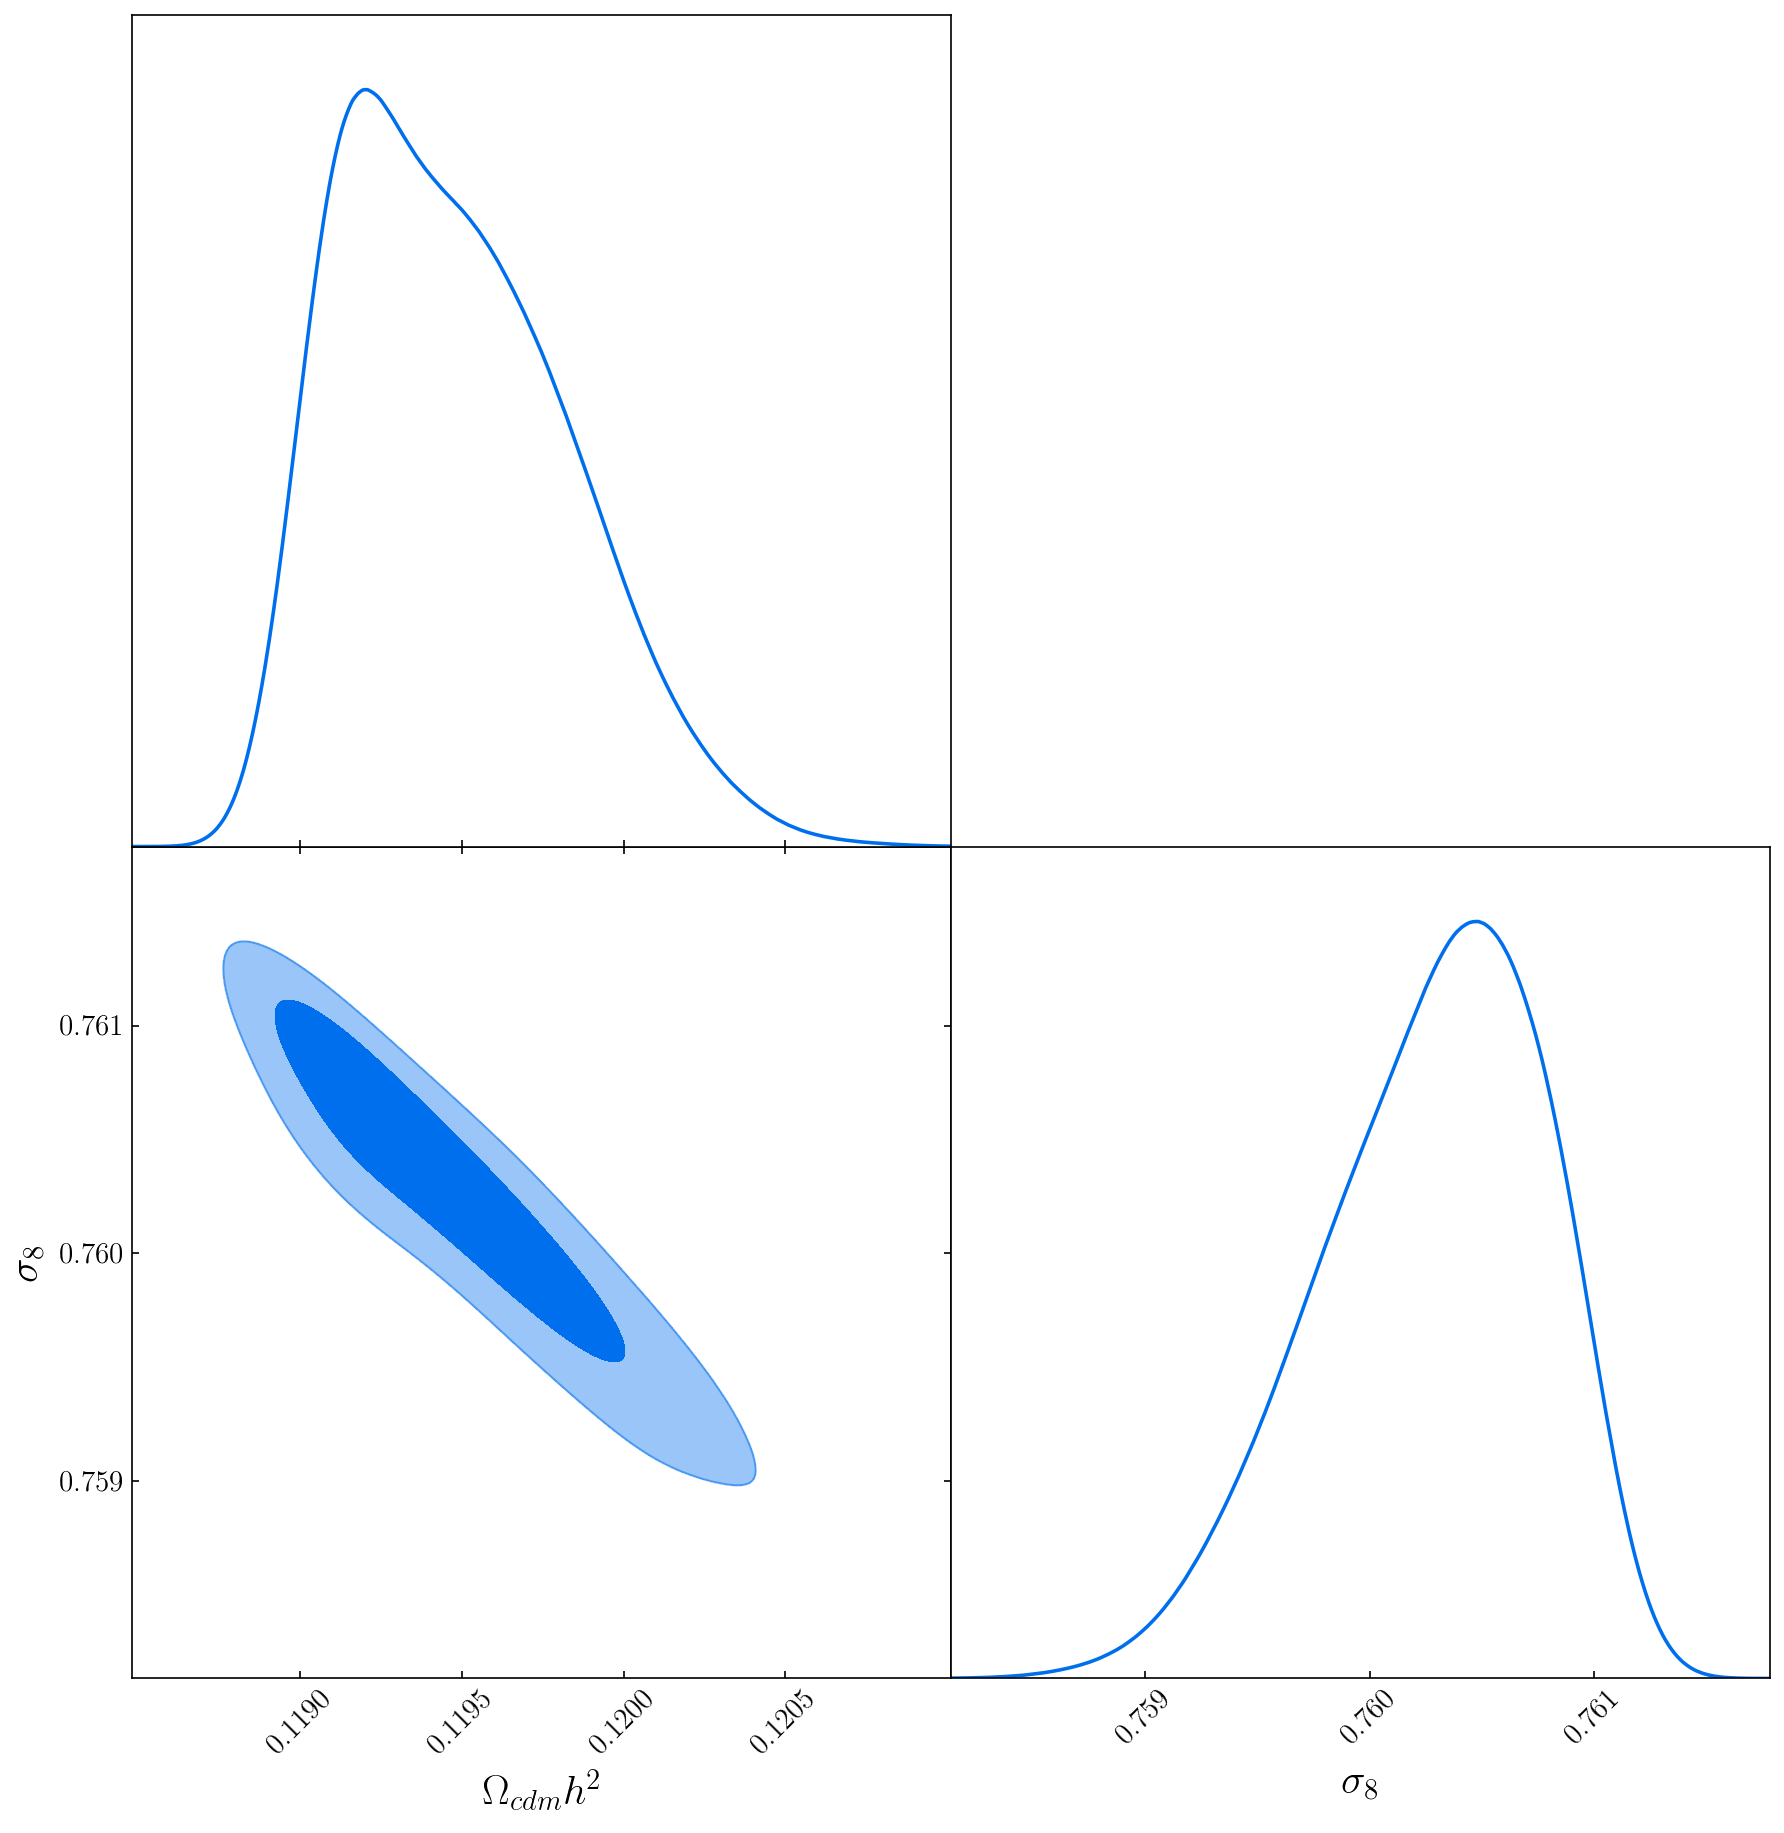

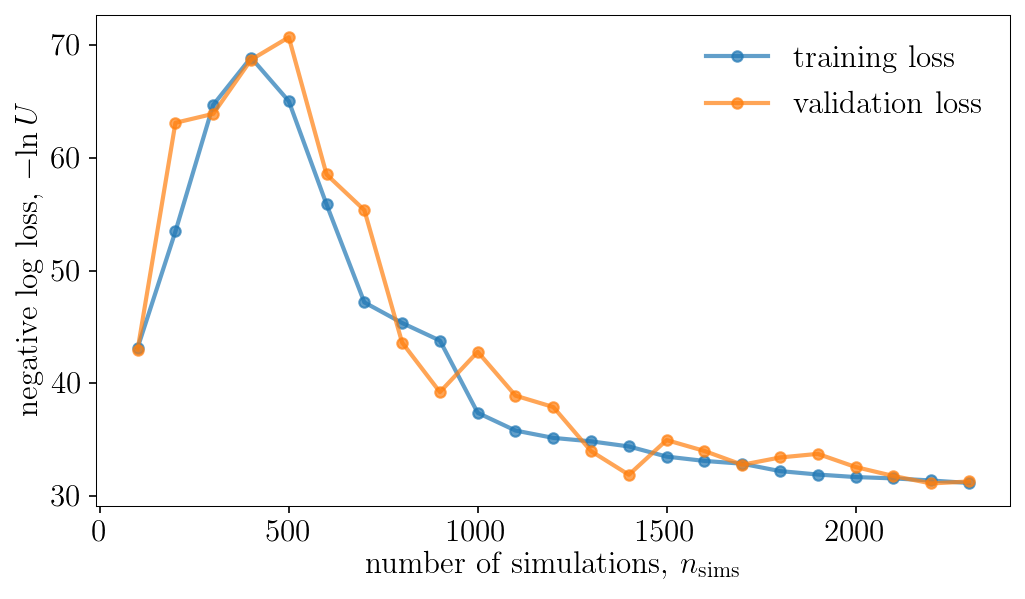

Population 23/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


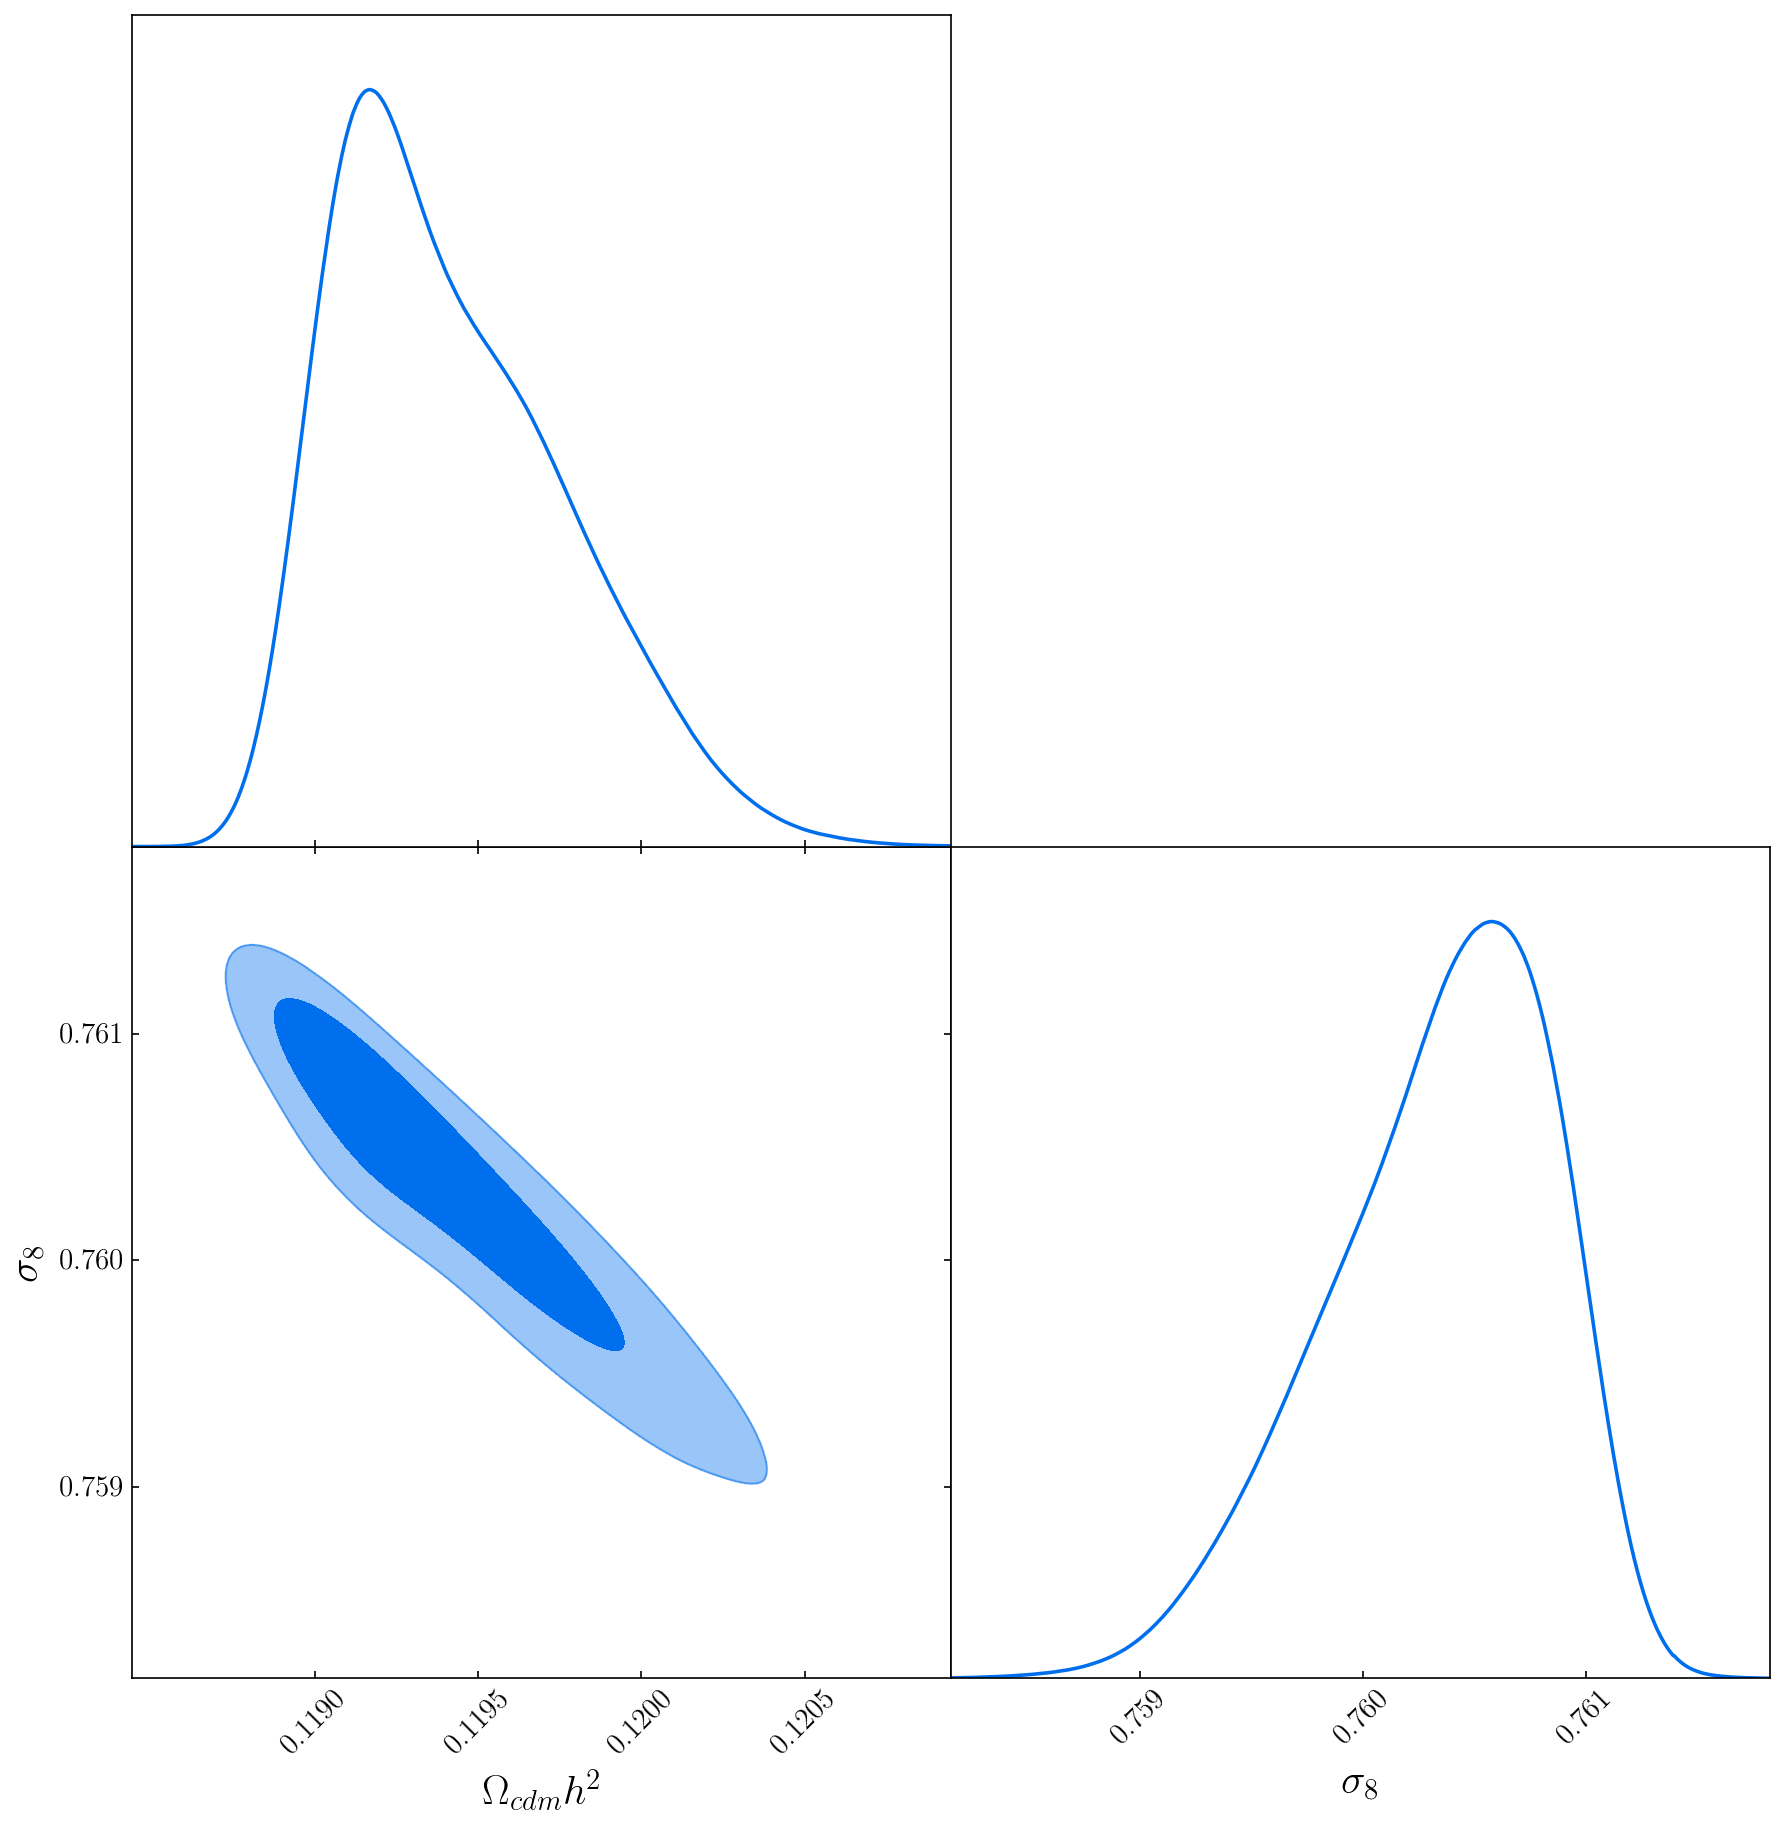

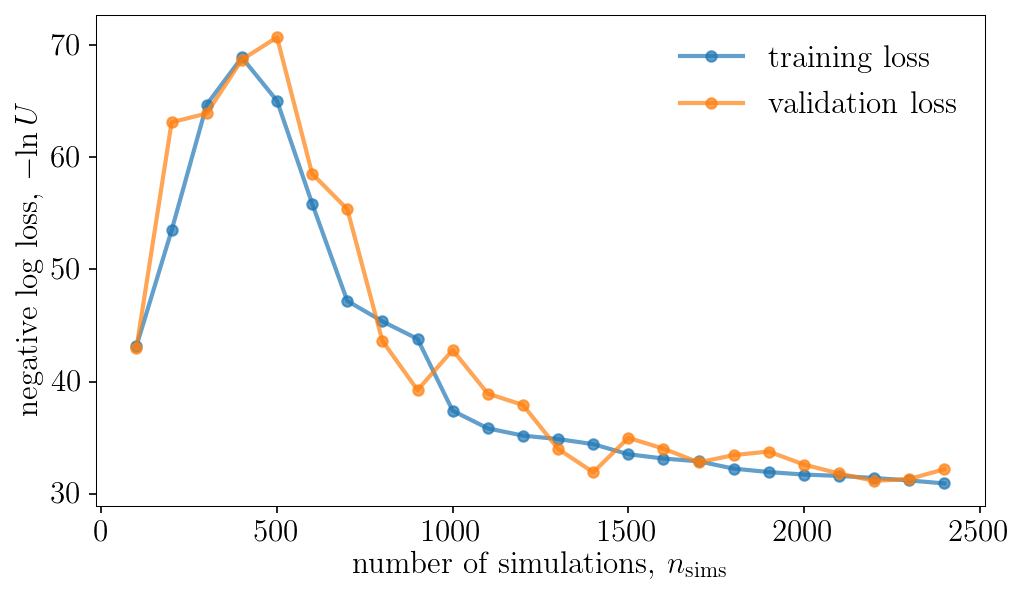

Population 24/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


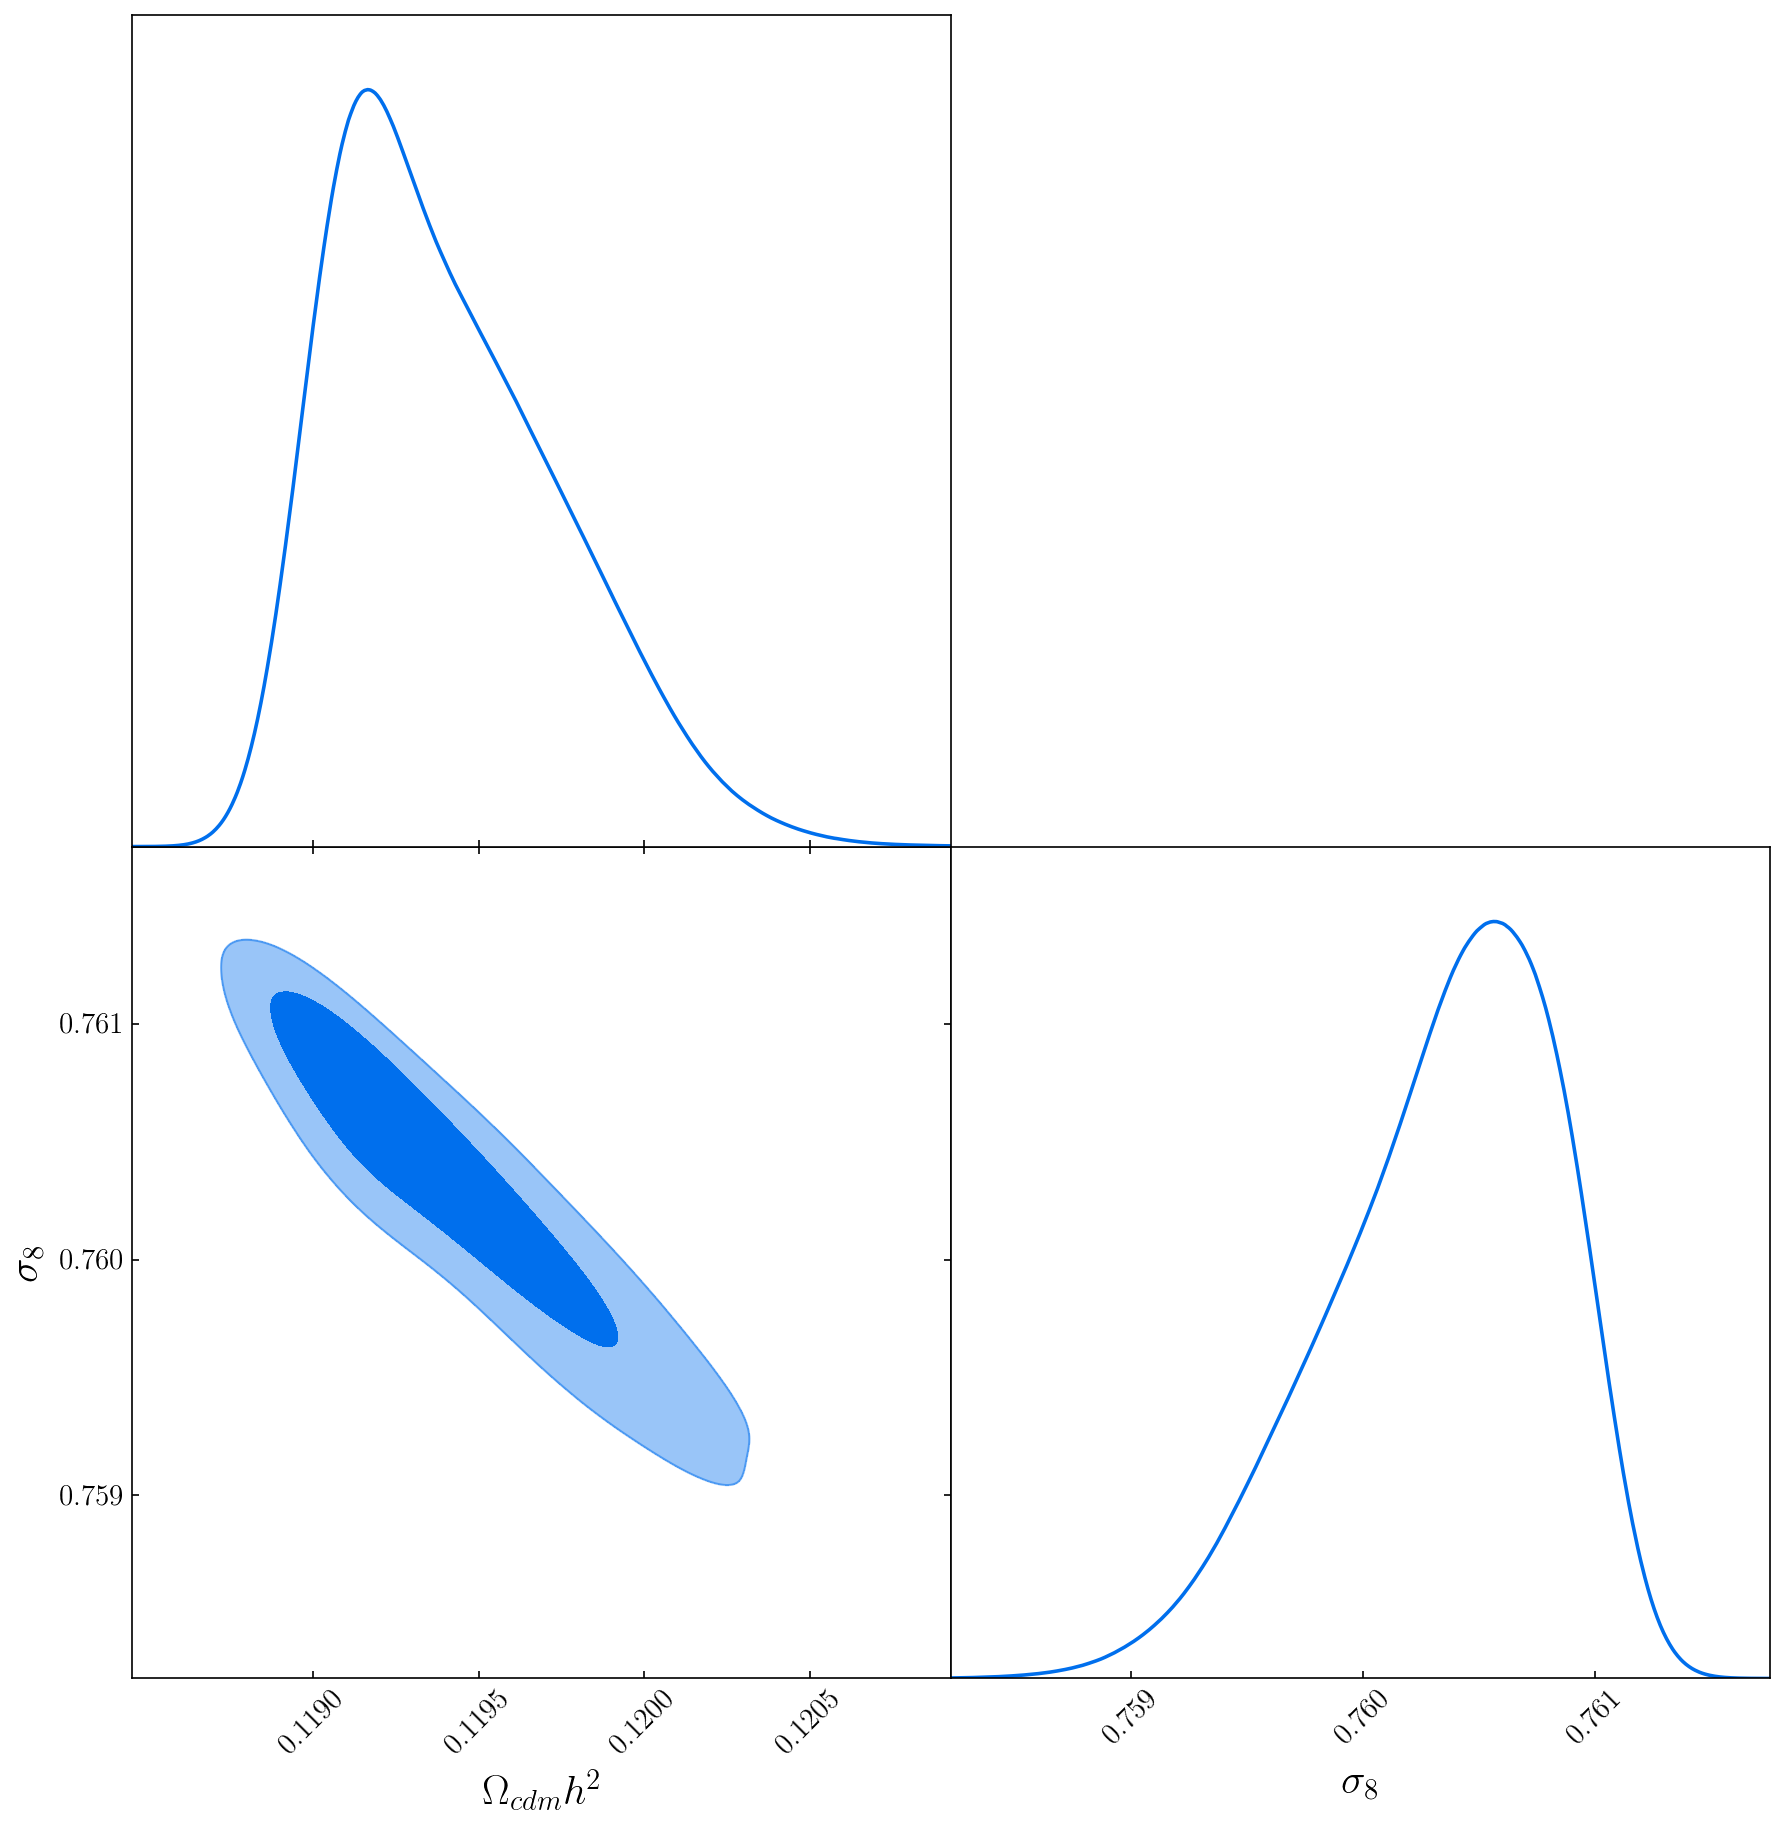

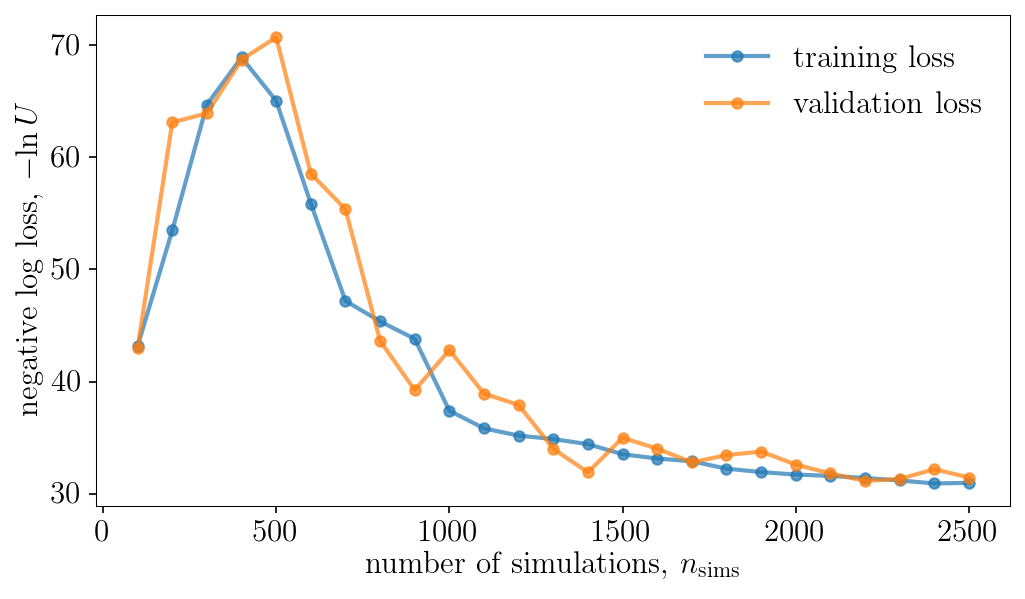

Population 25/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


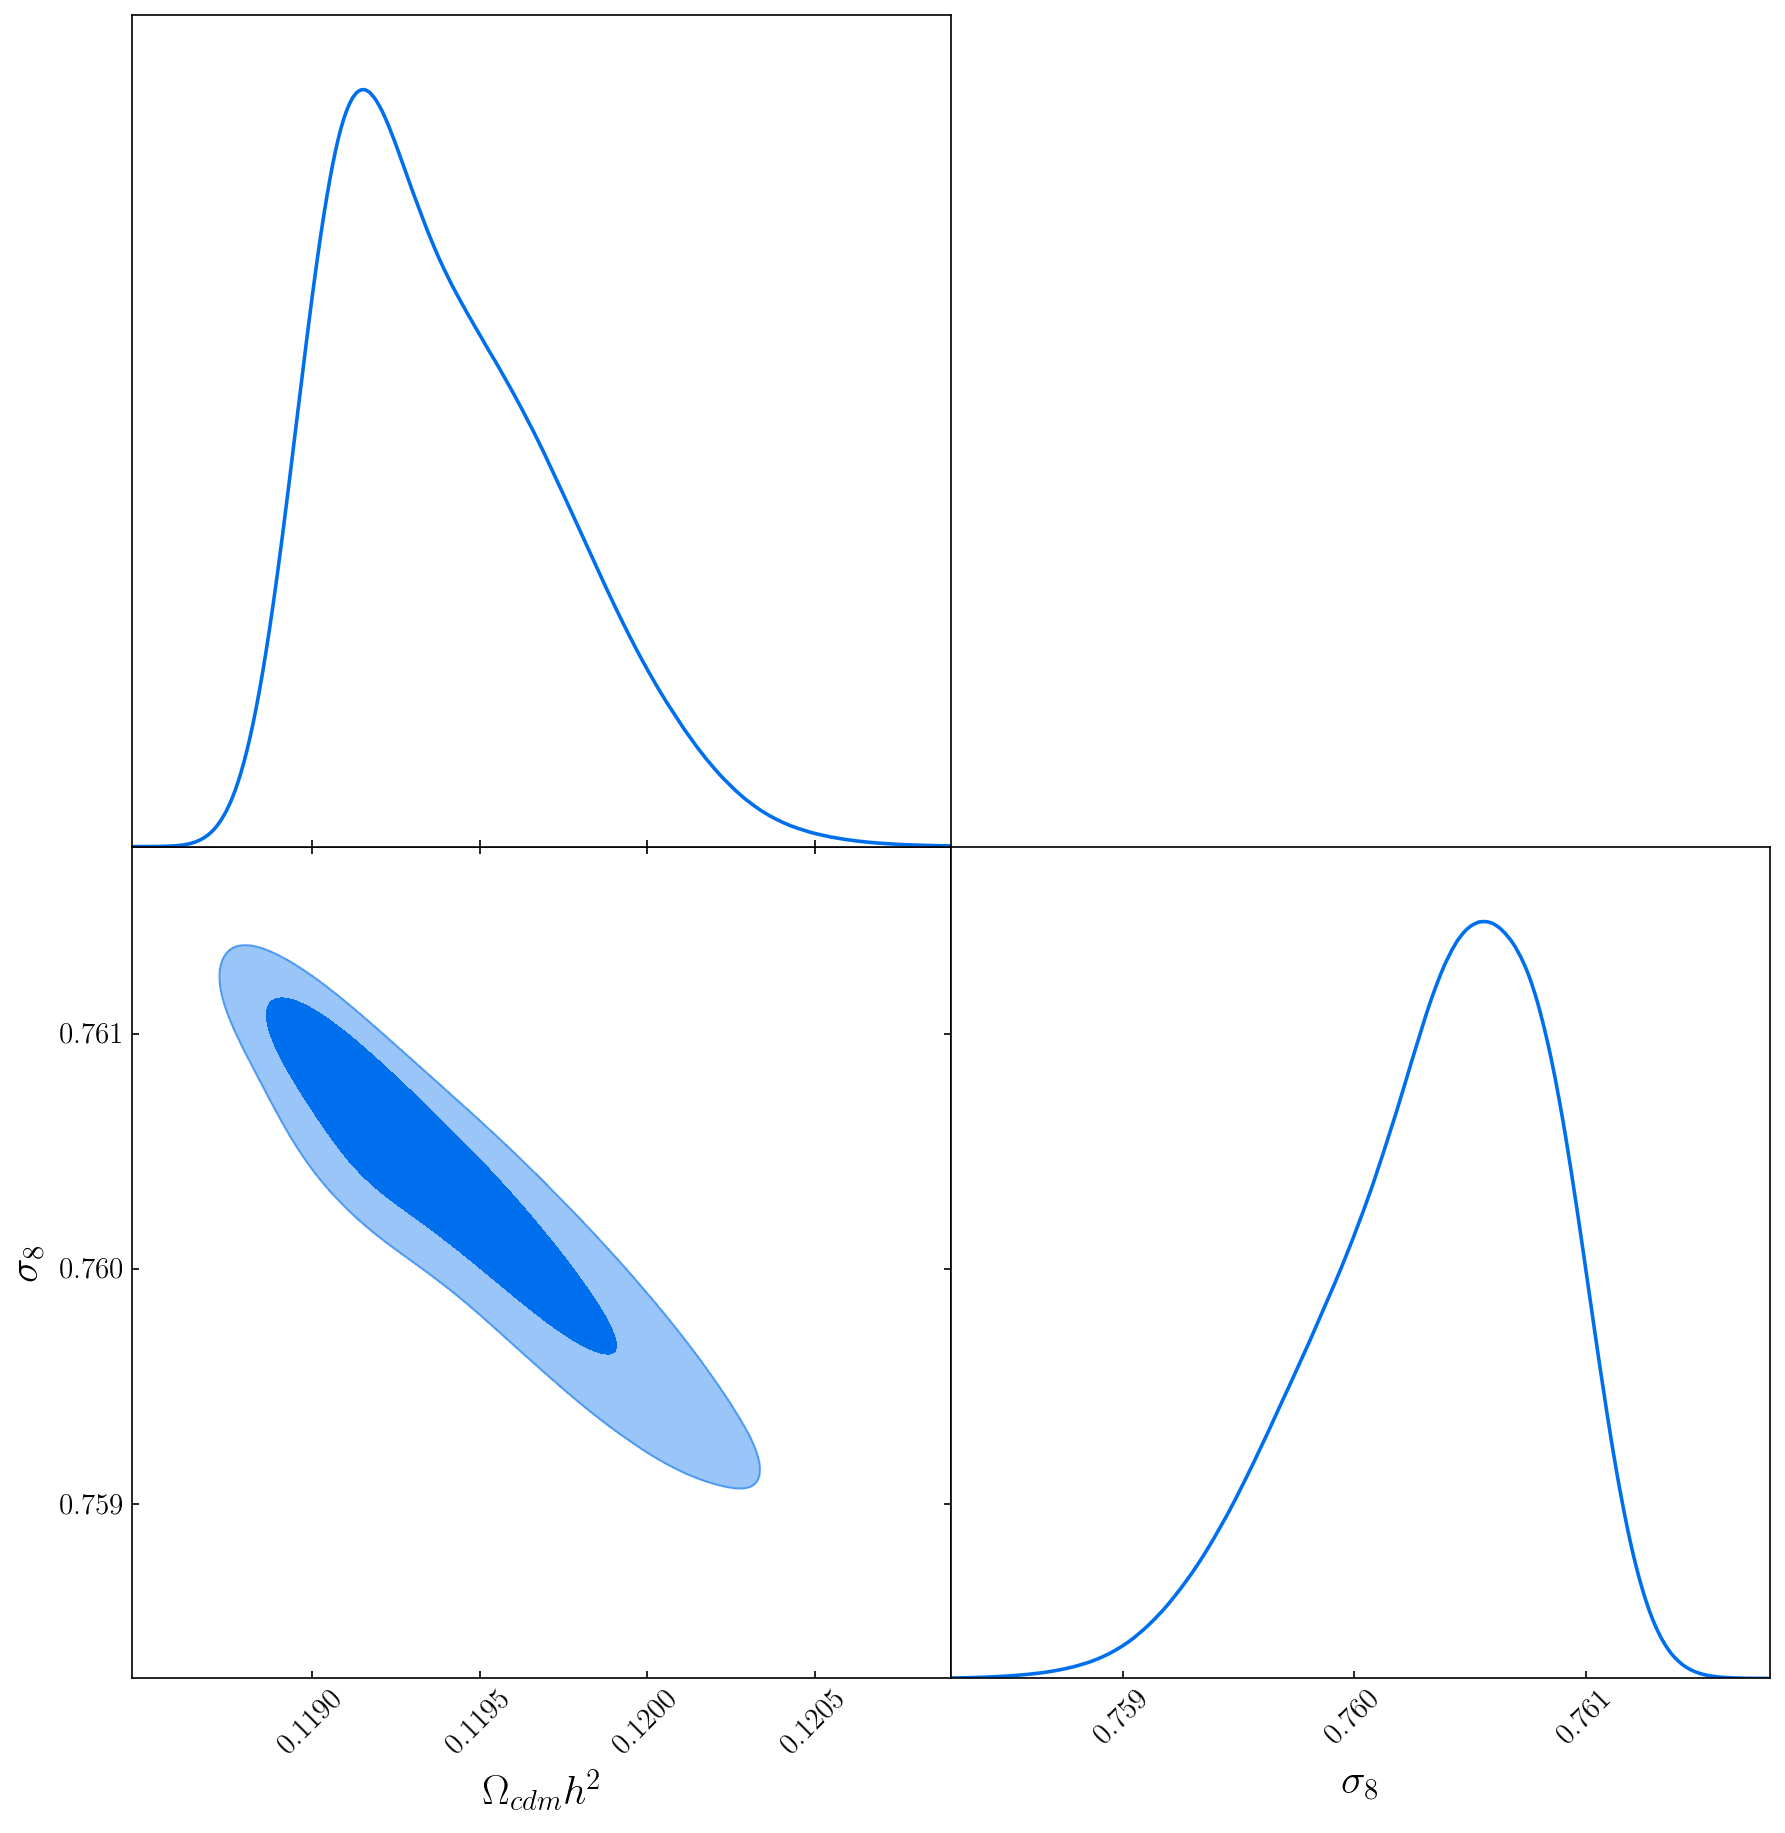

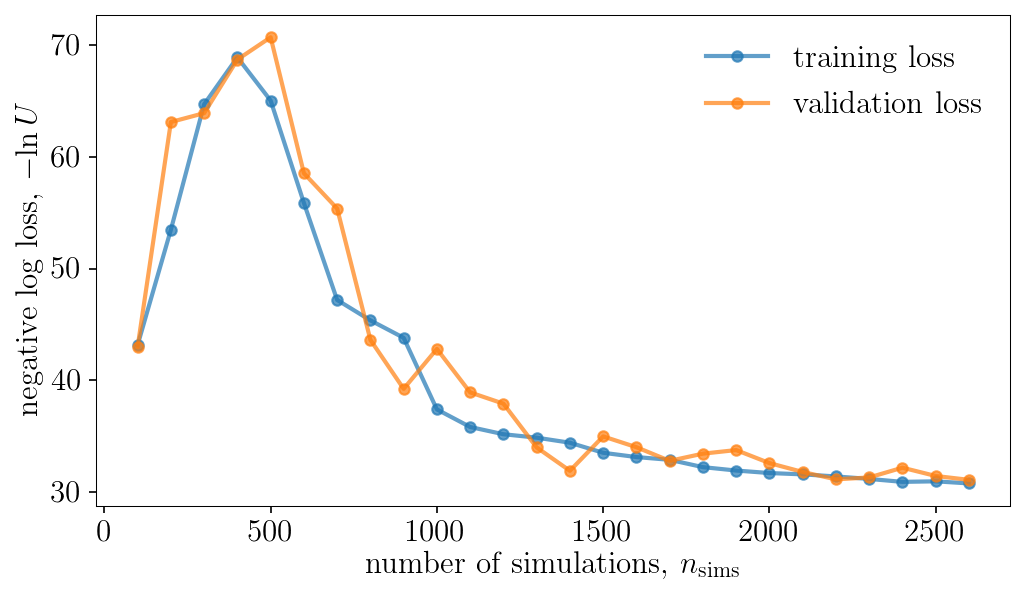

Population 26/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


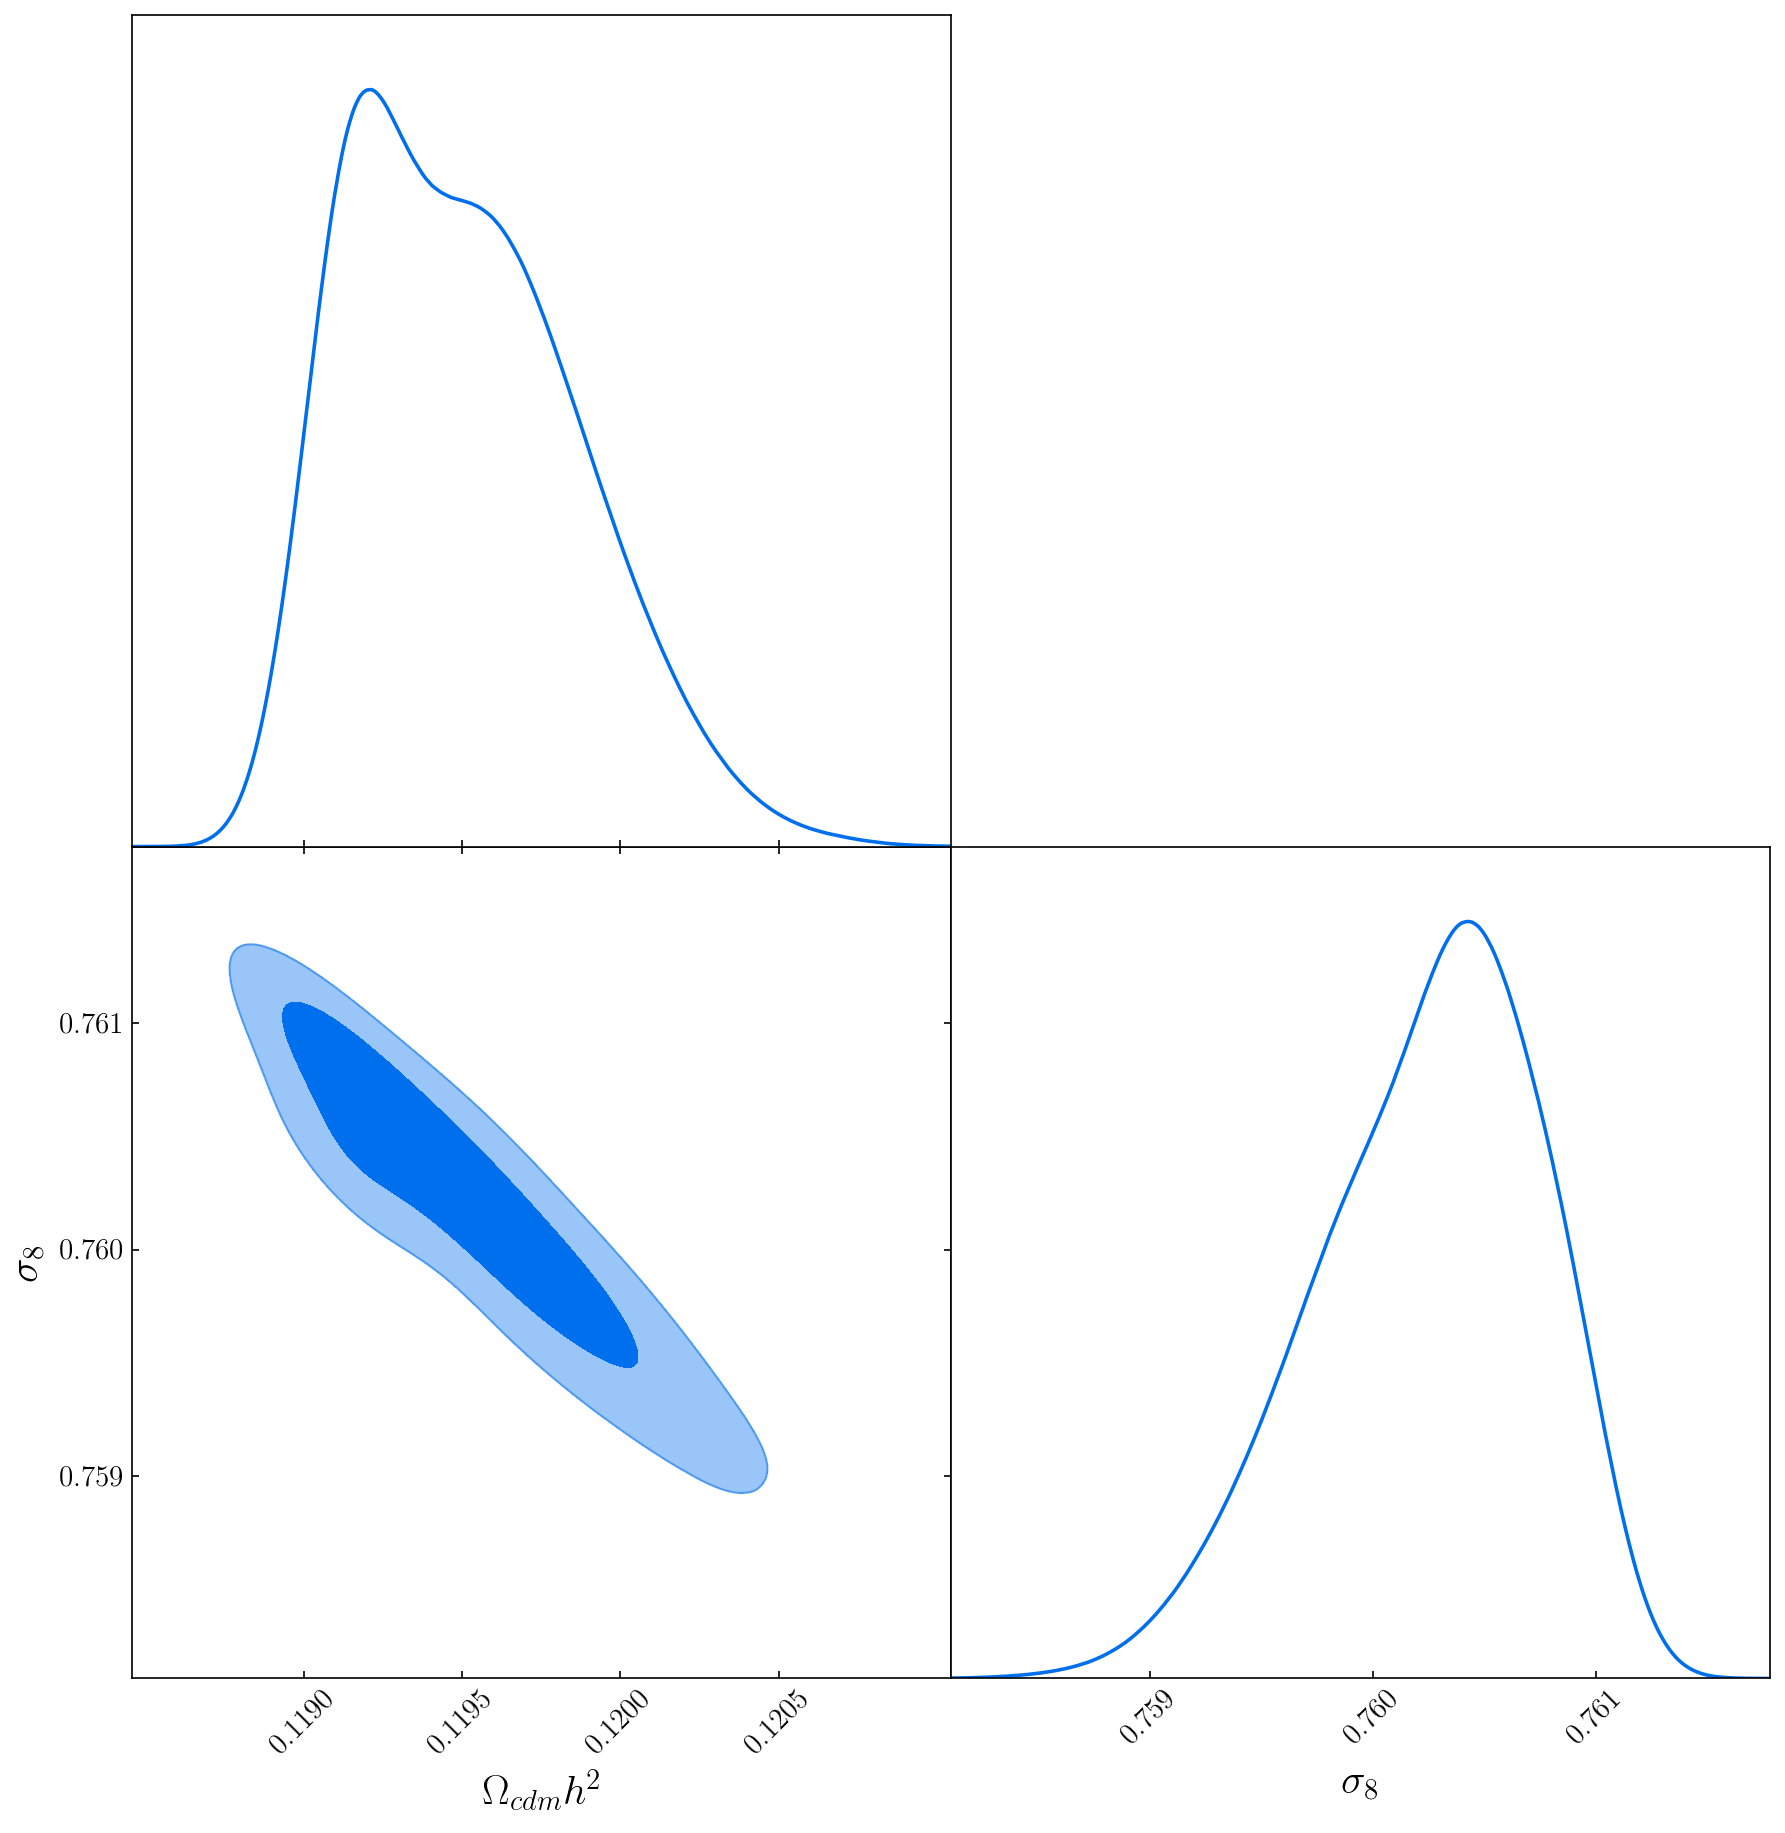

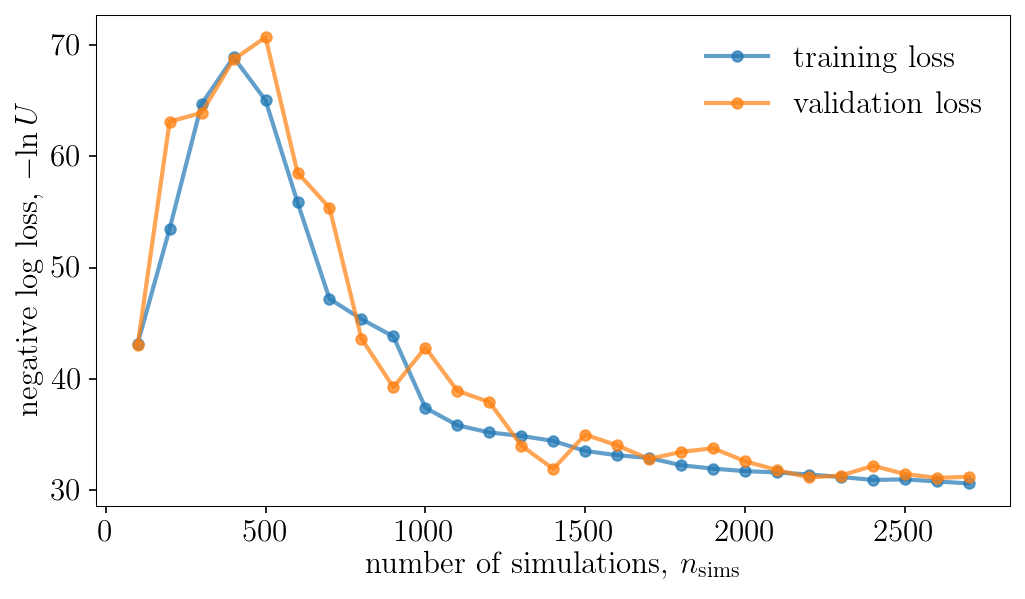

Population 27/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


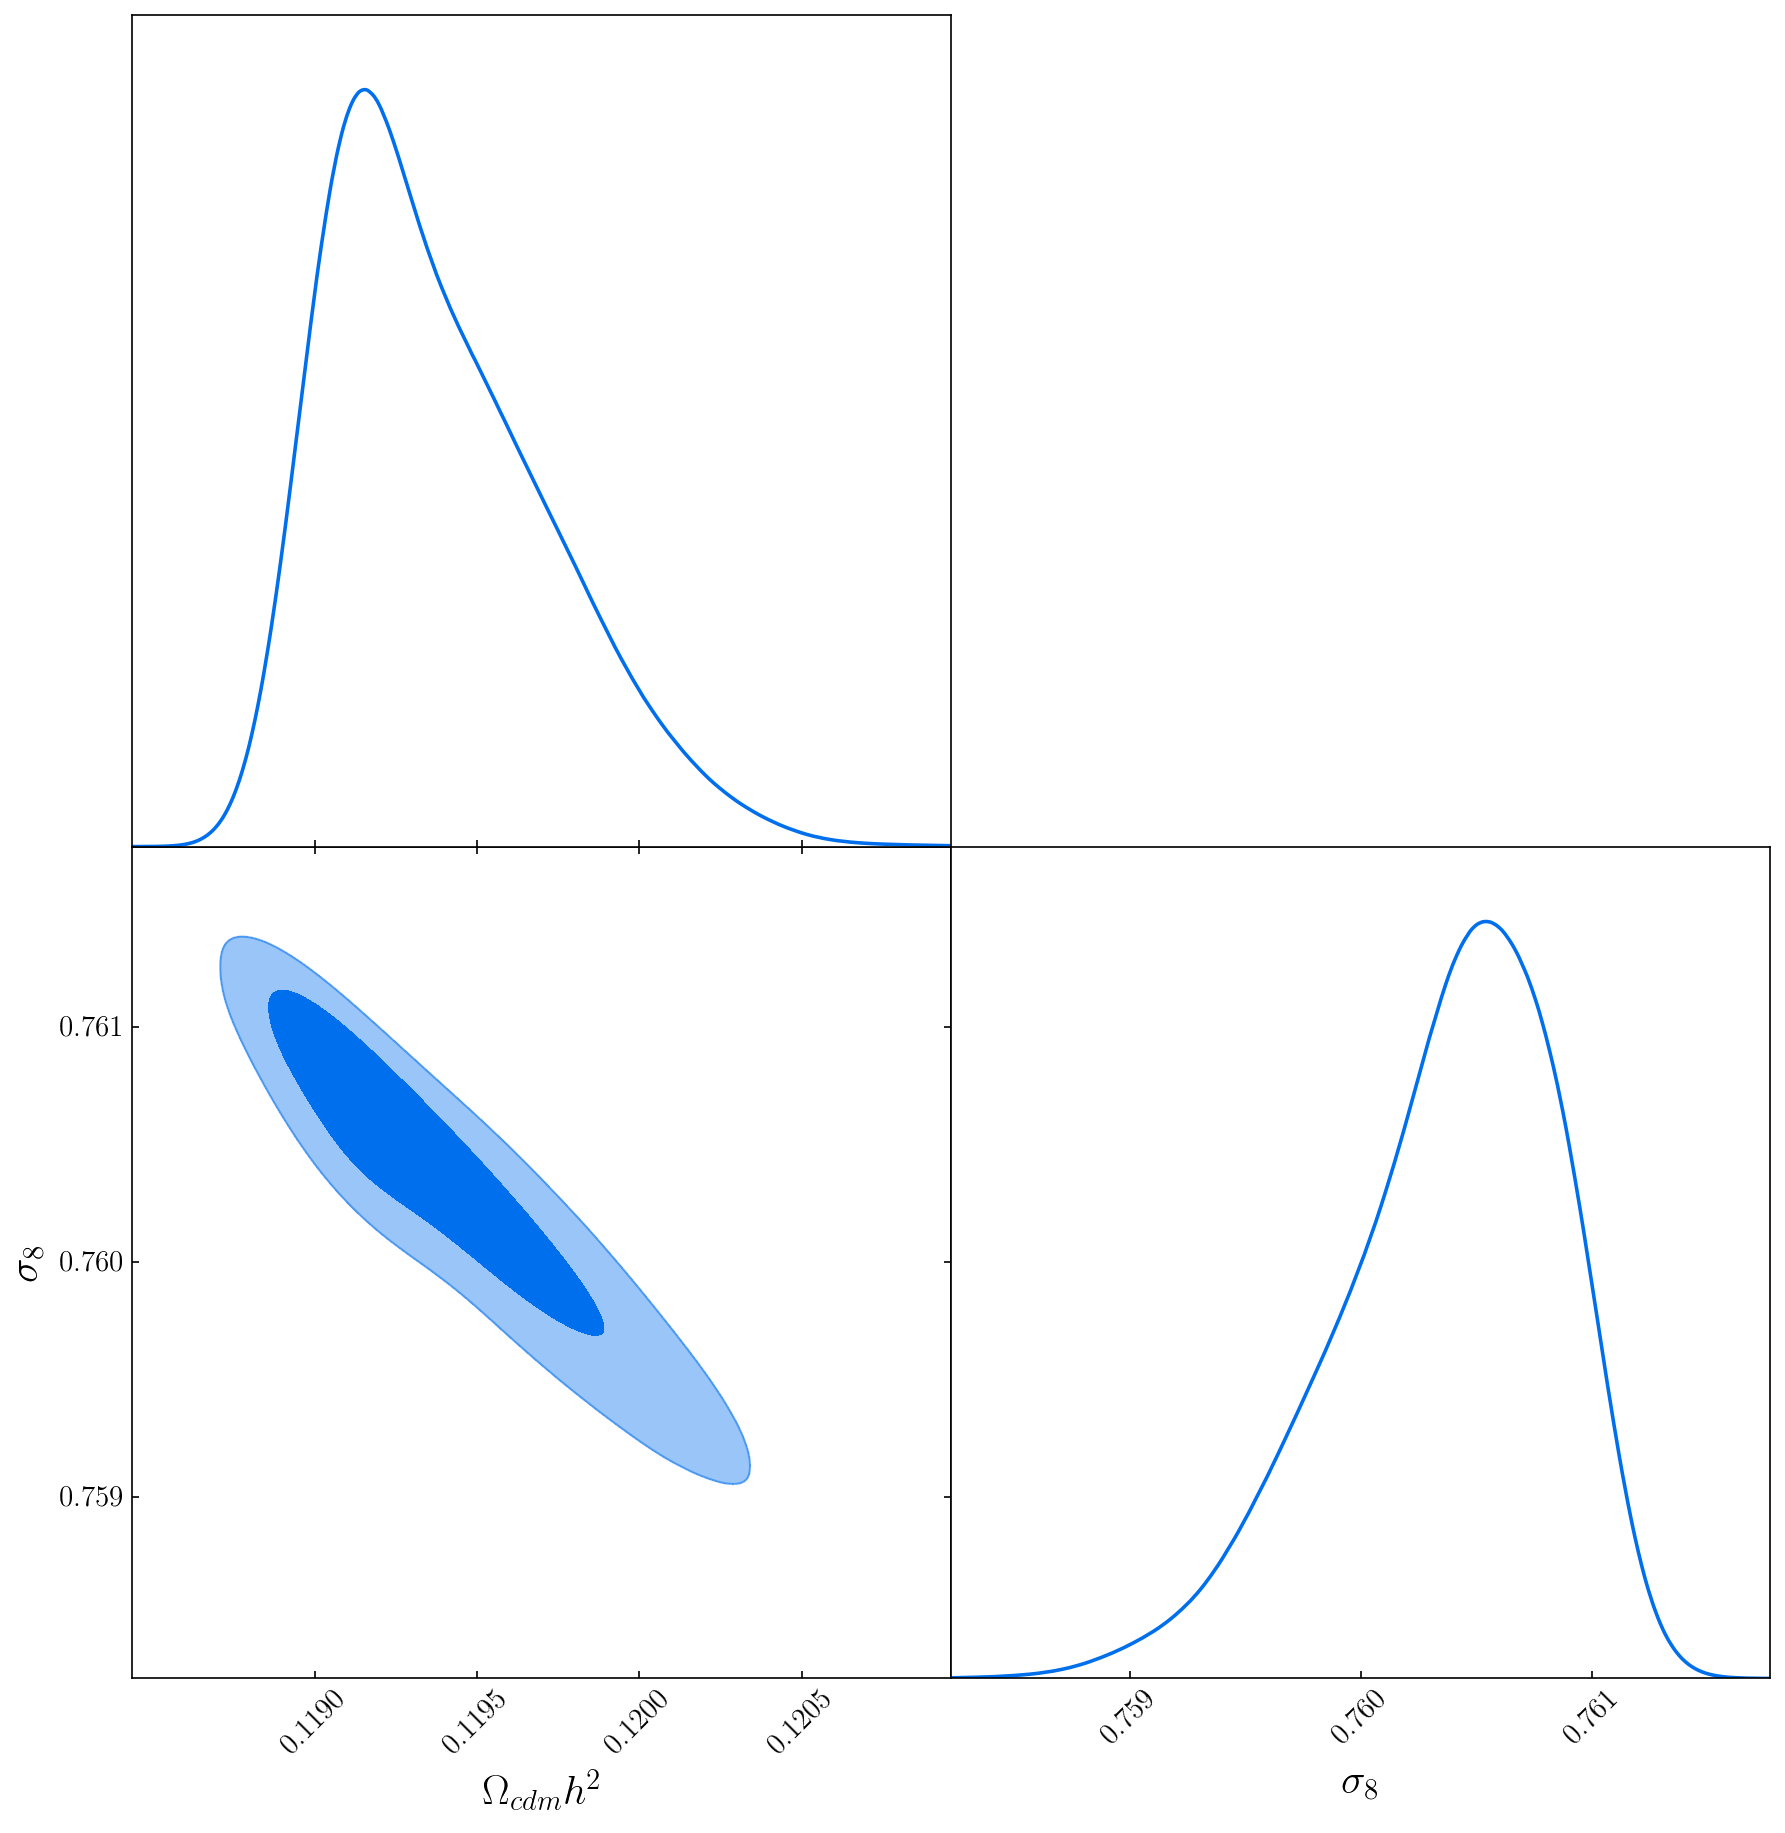

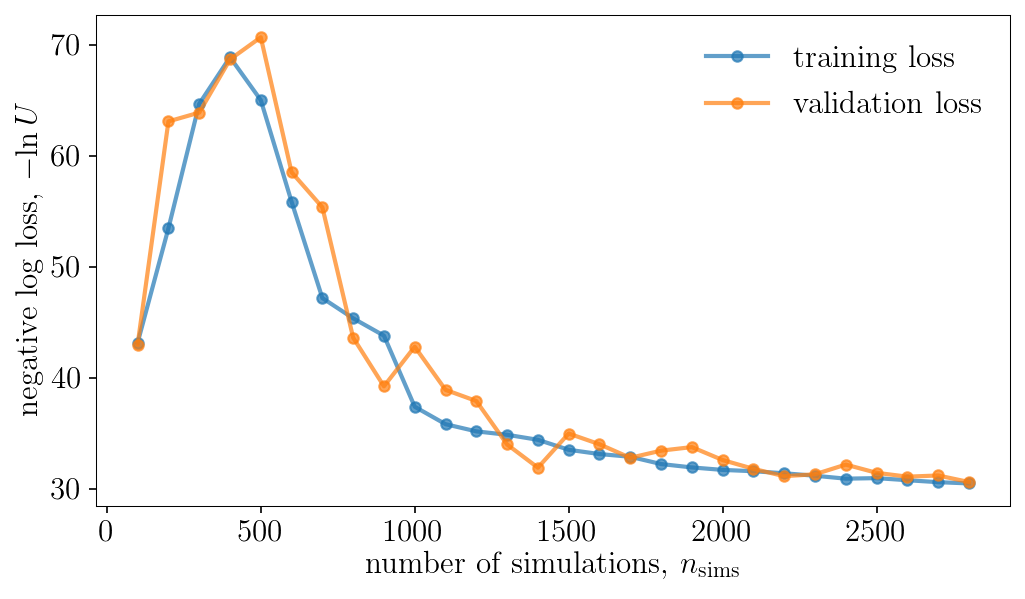

Population 28/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


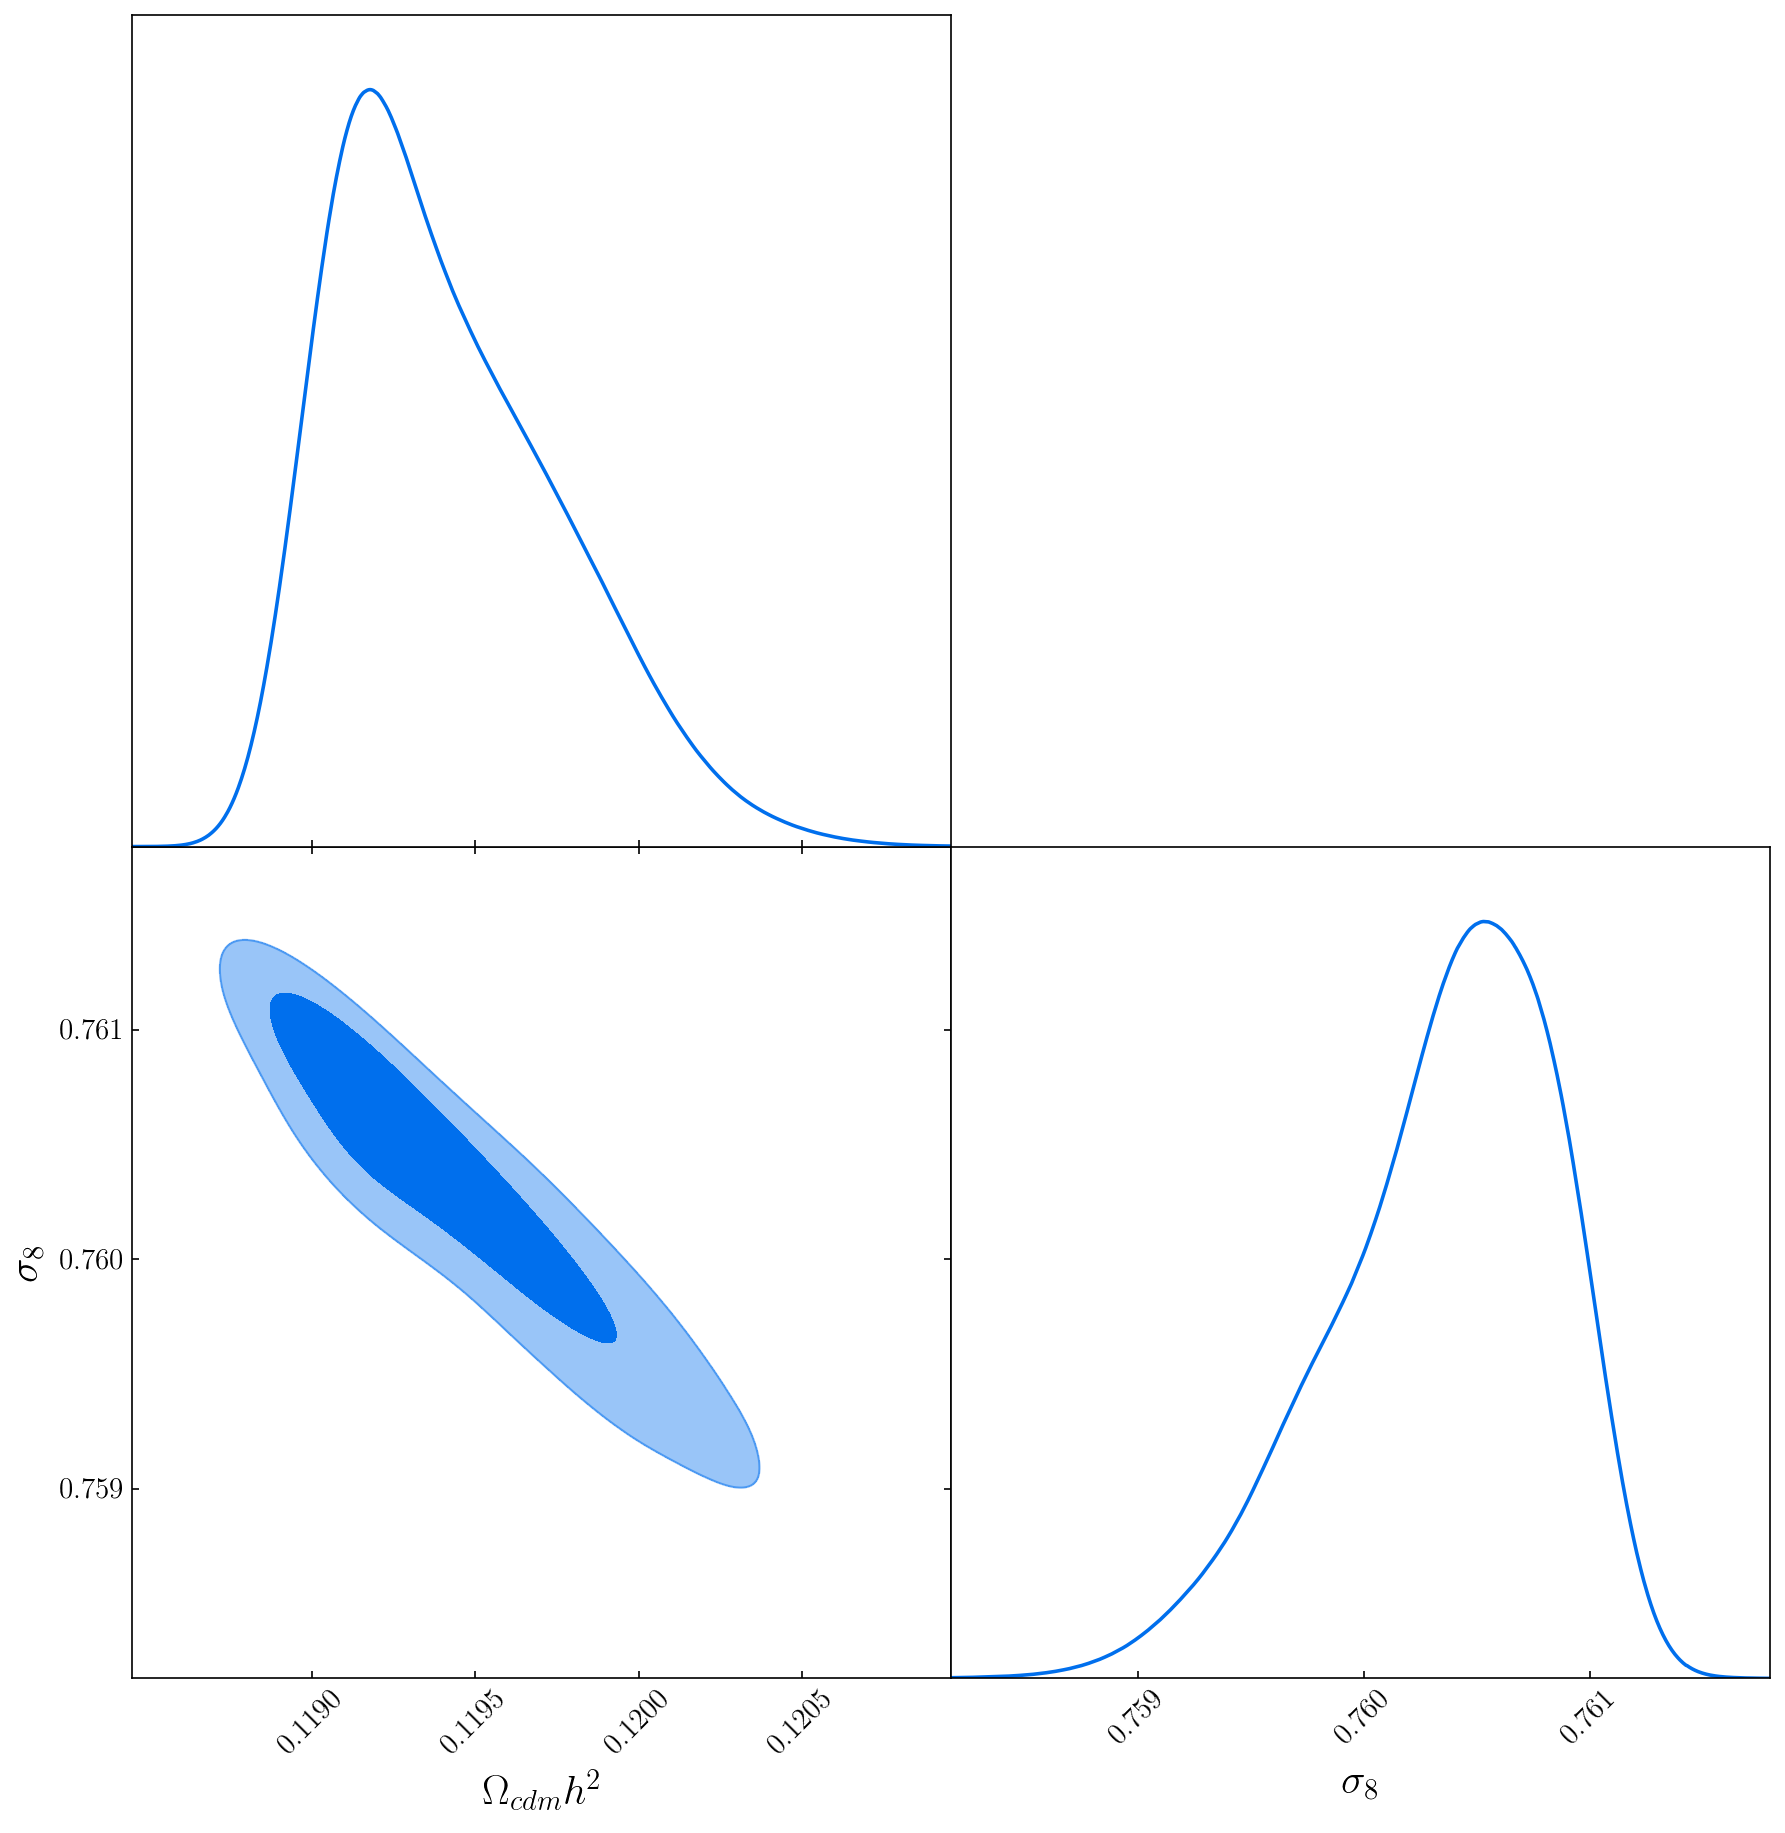

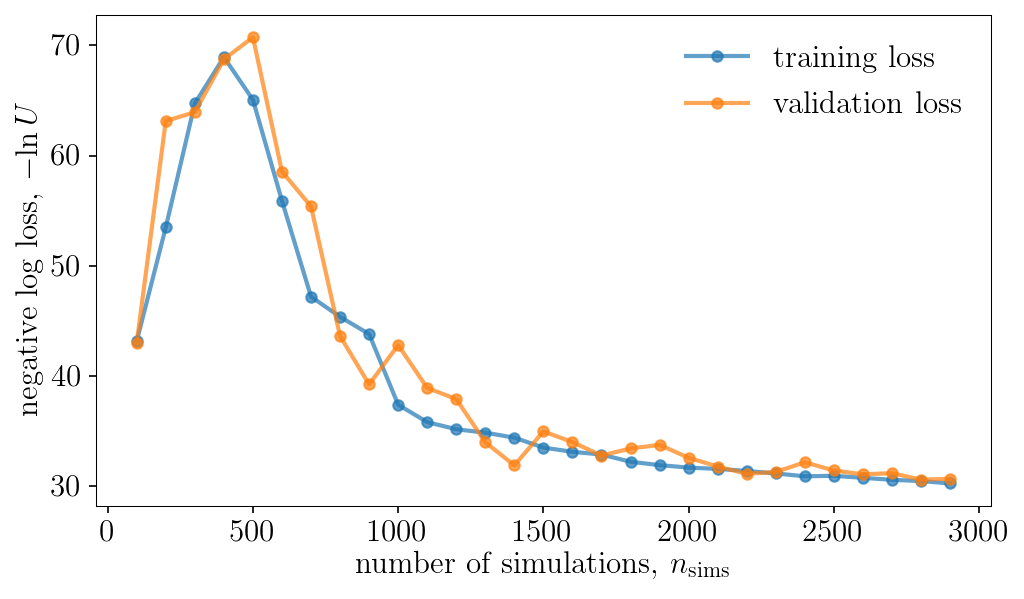

Population 29/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


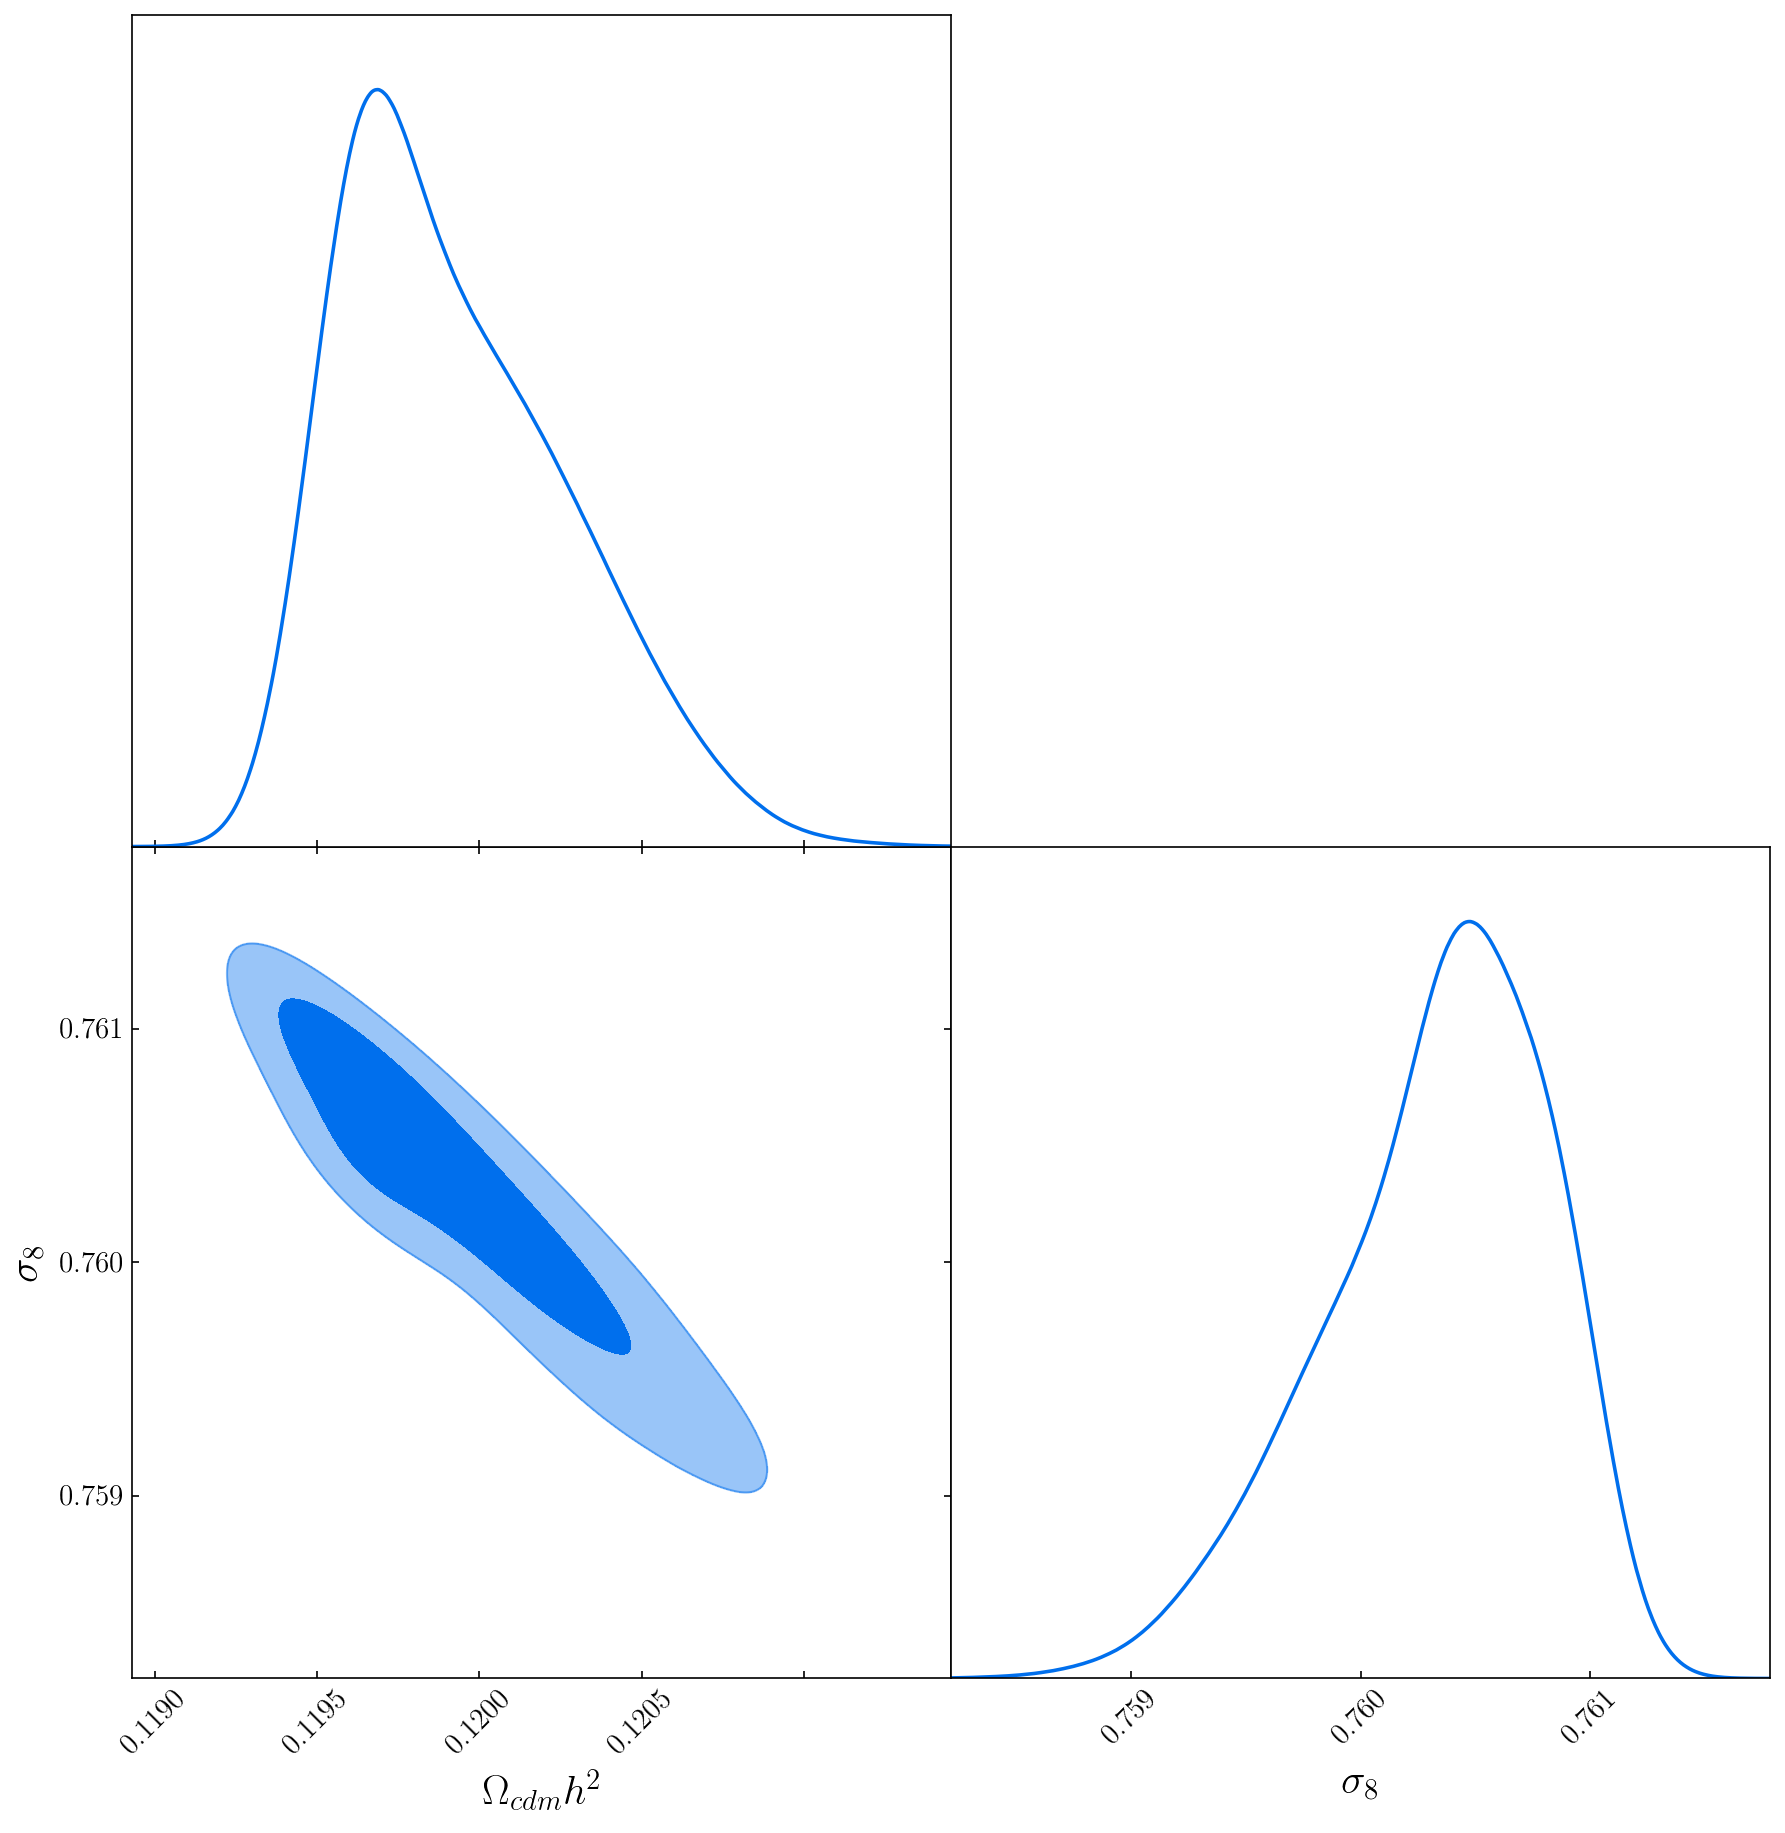

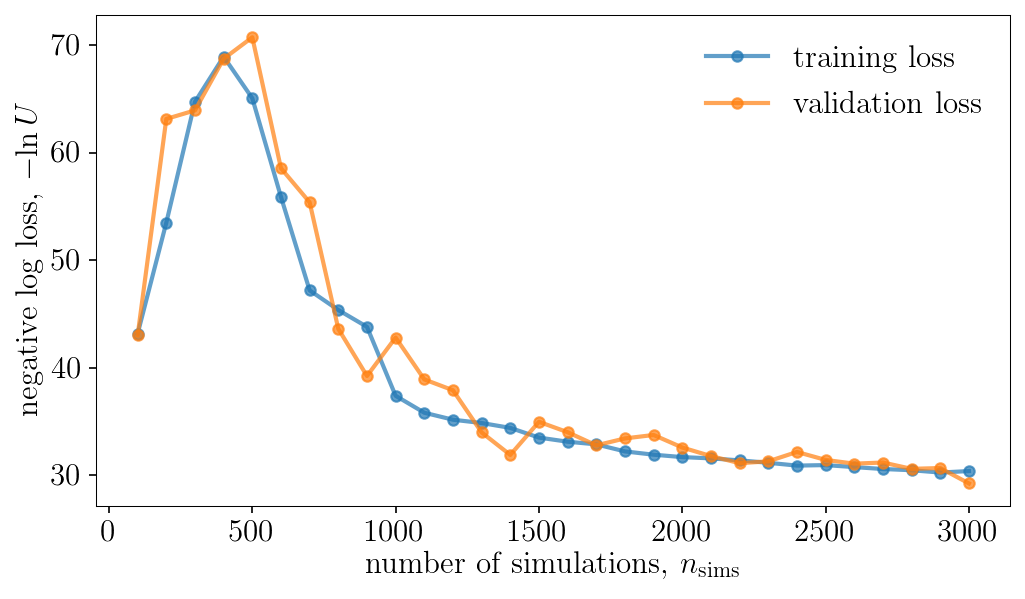

Population 30/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


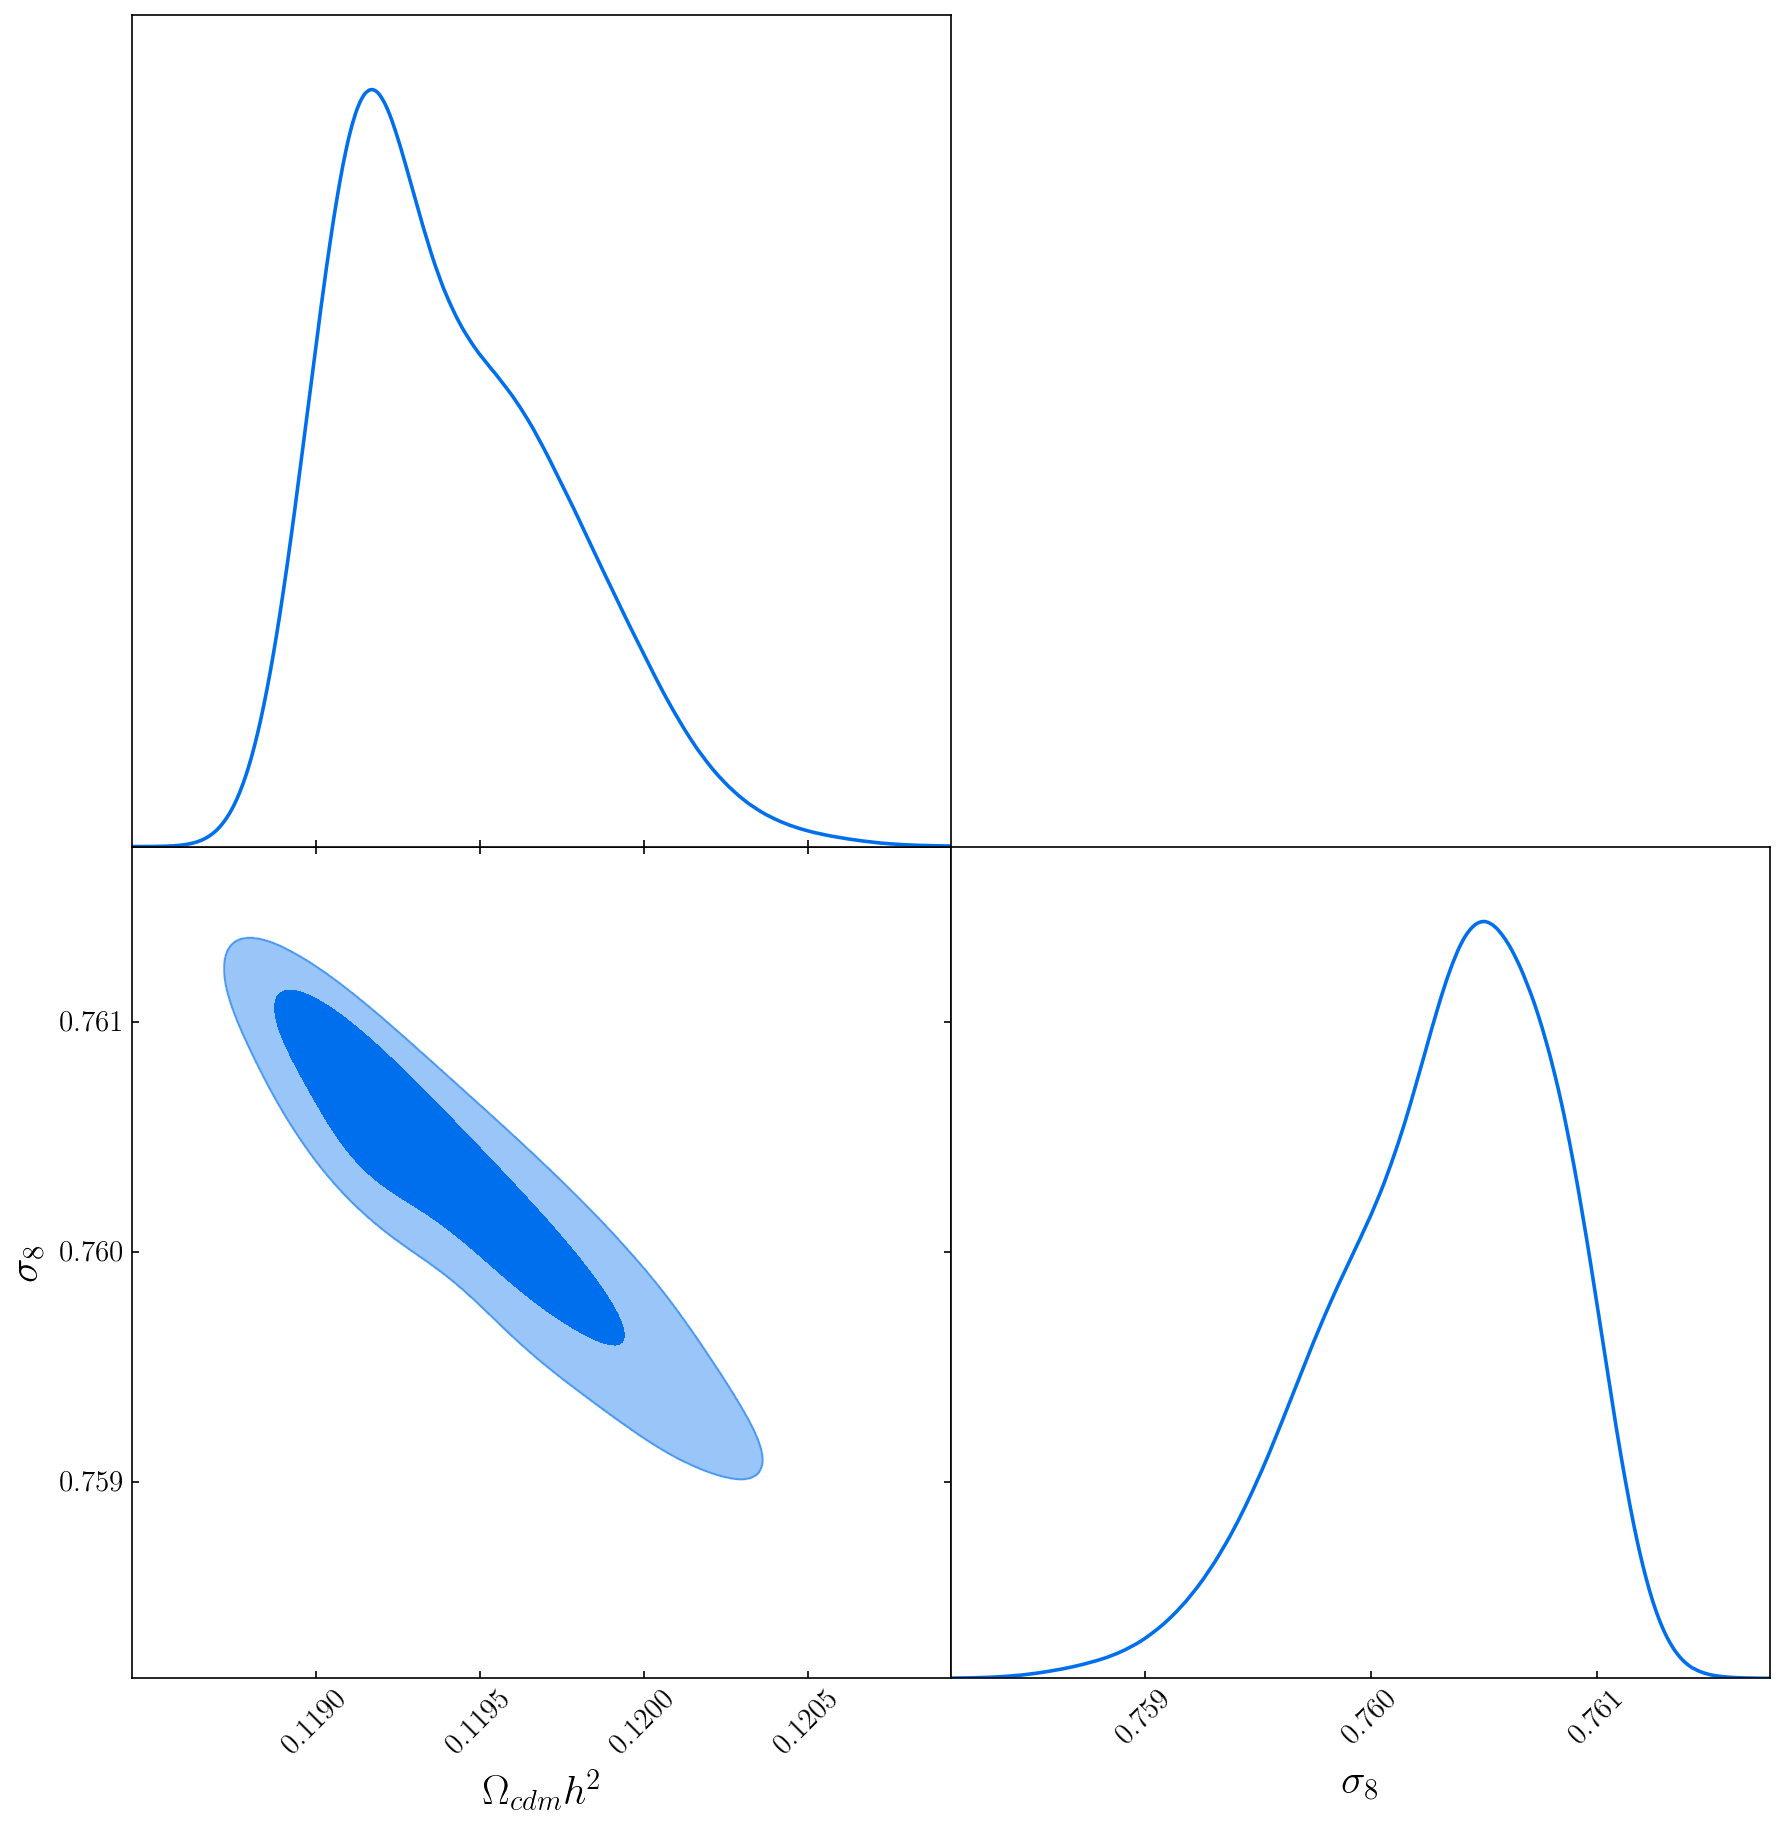

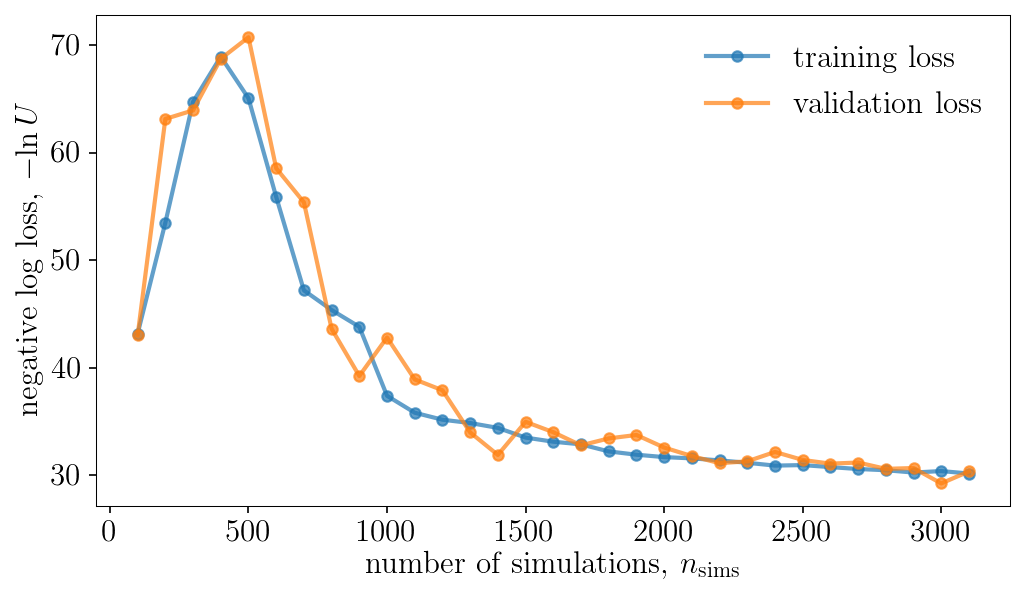

Population 31/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


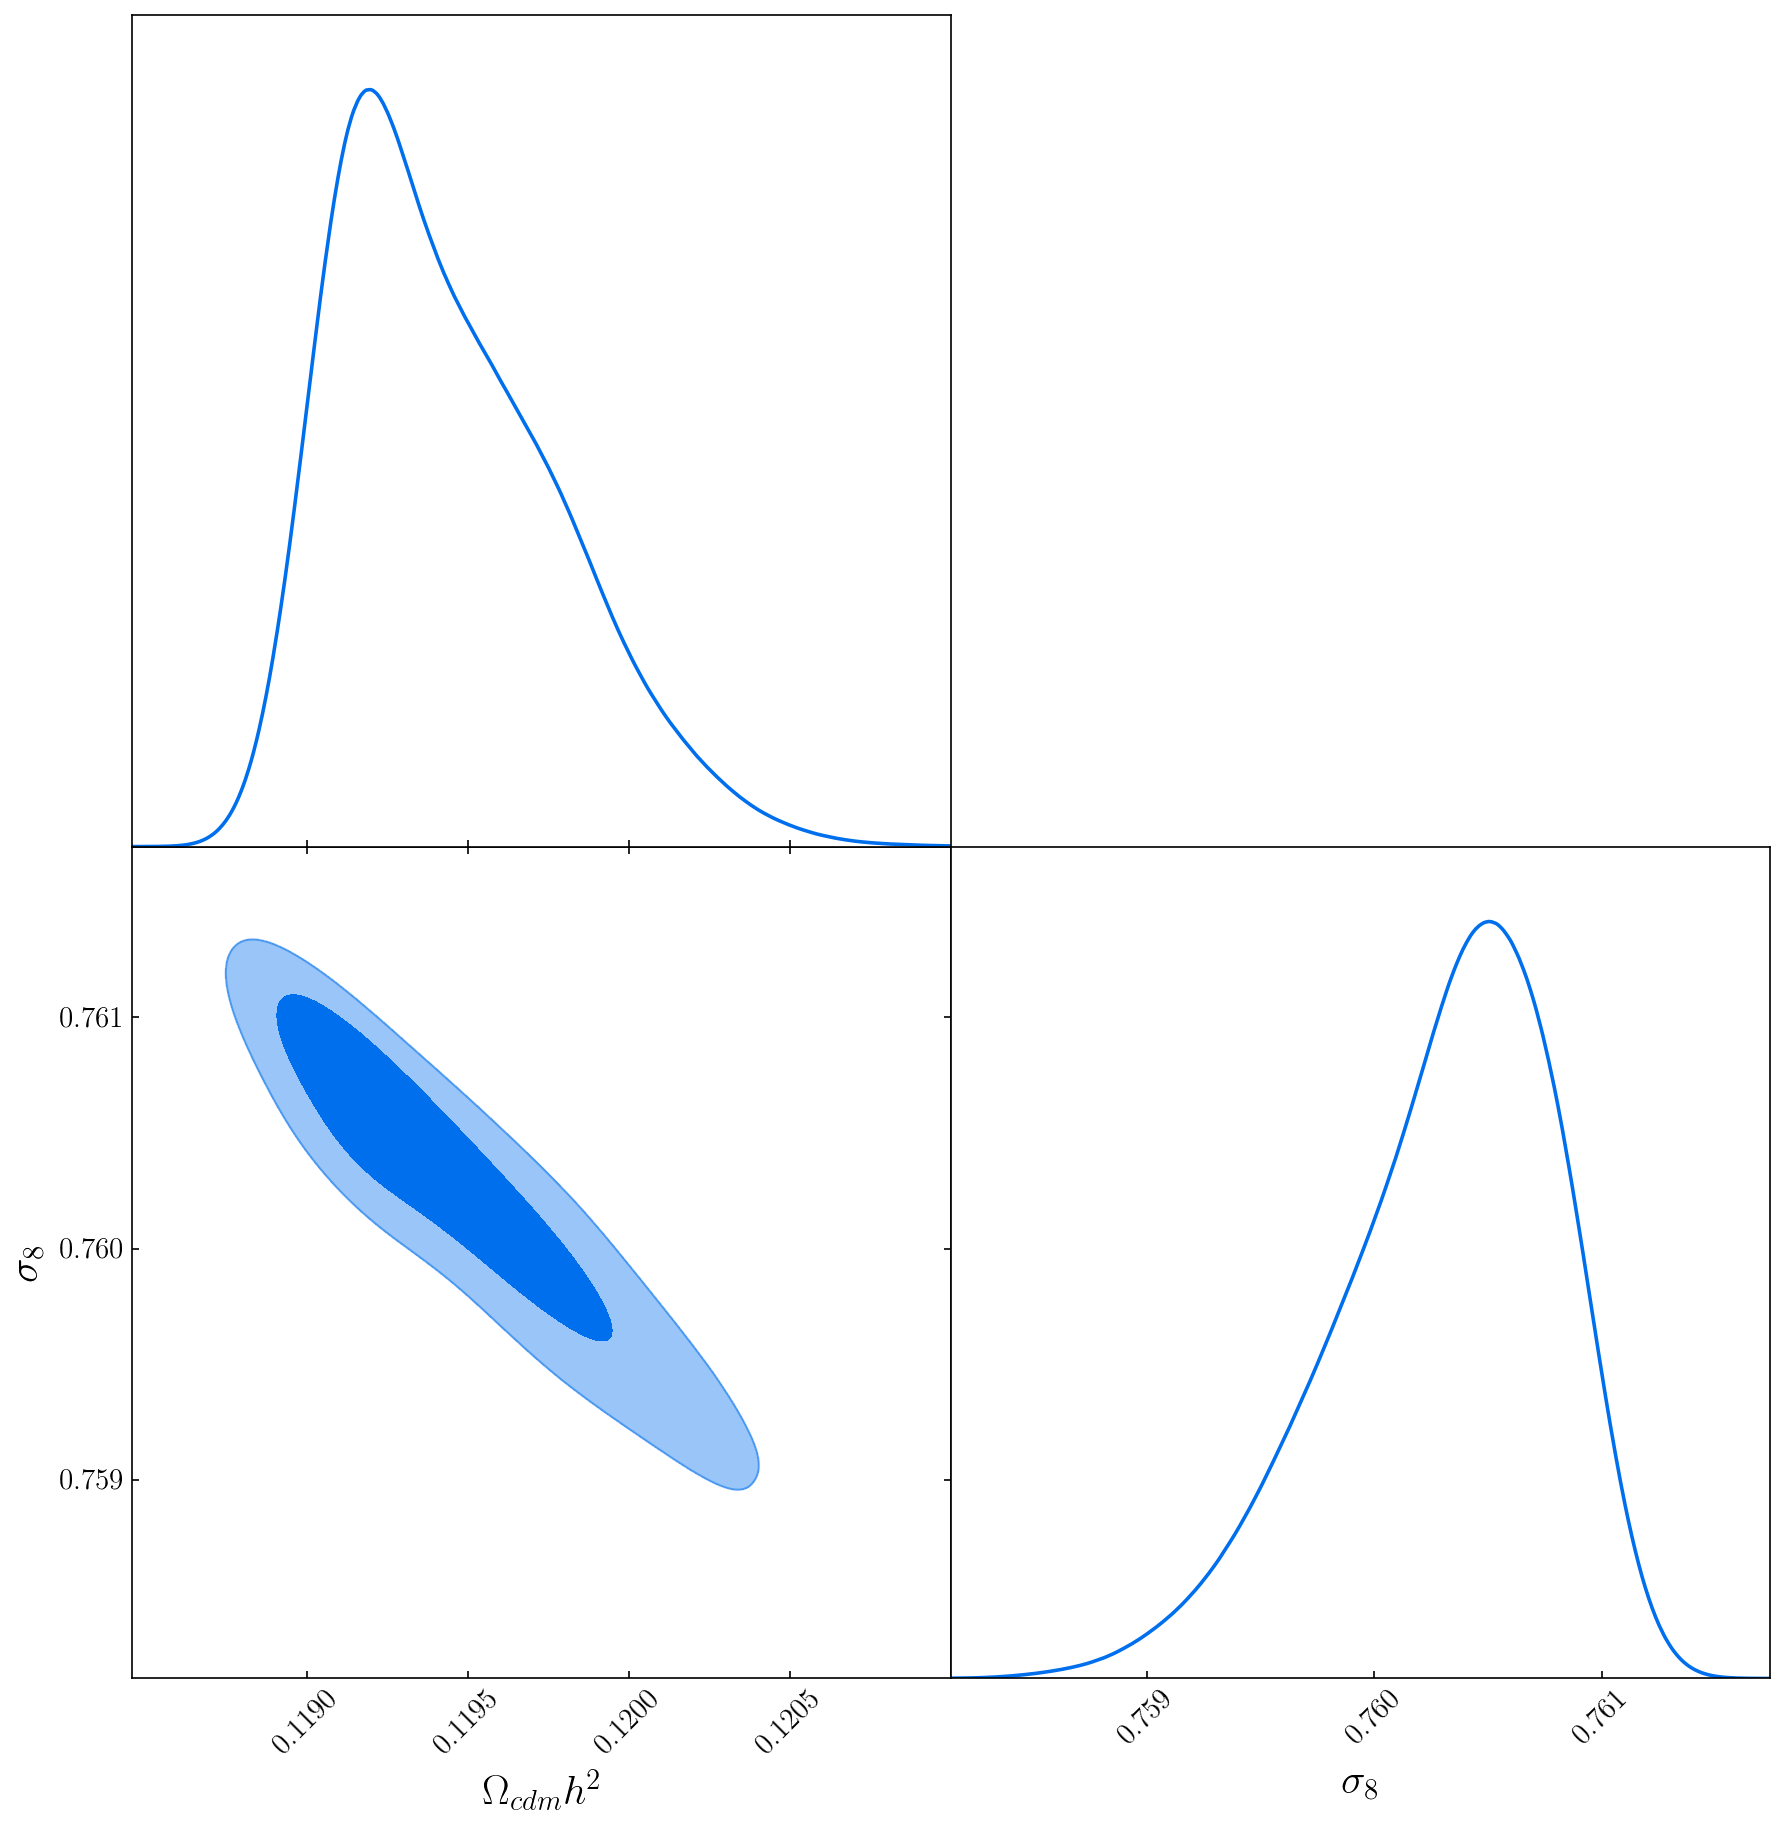

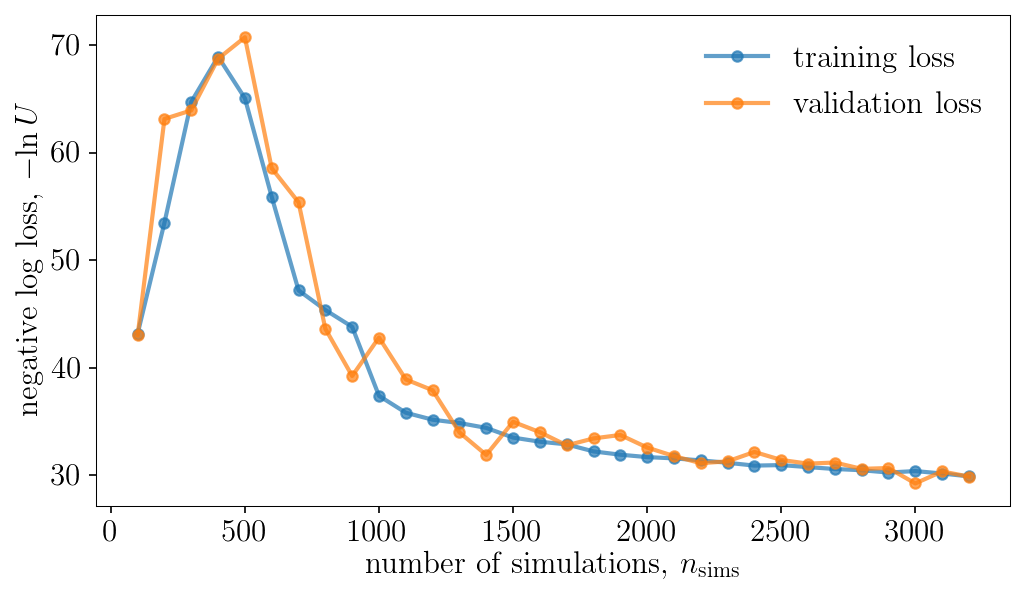

Population 32/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


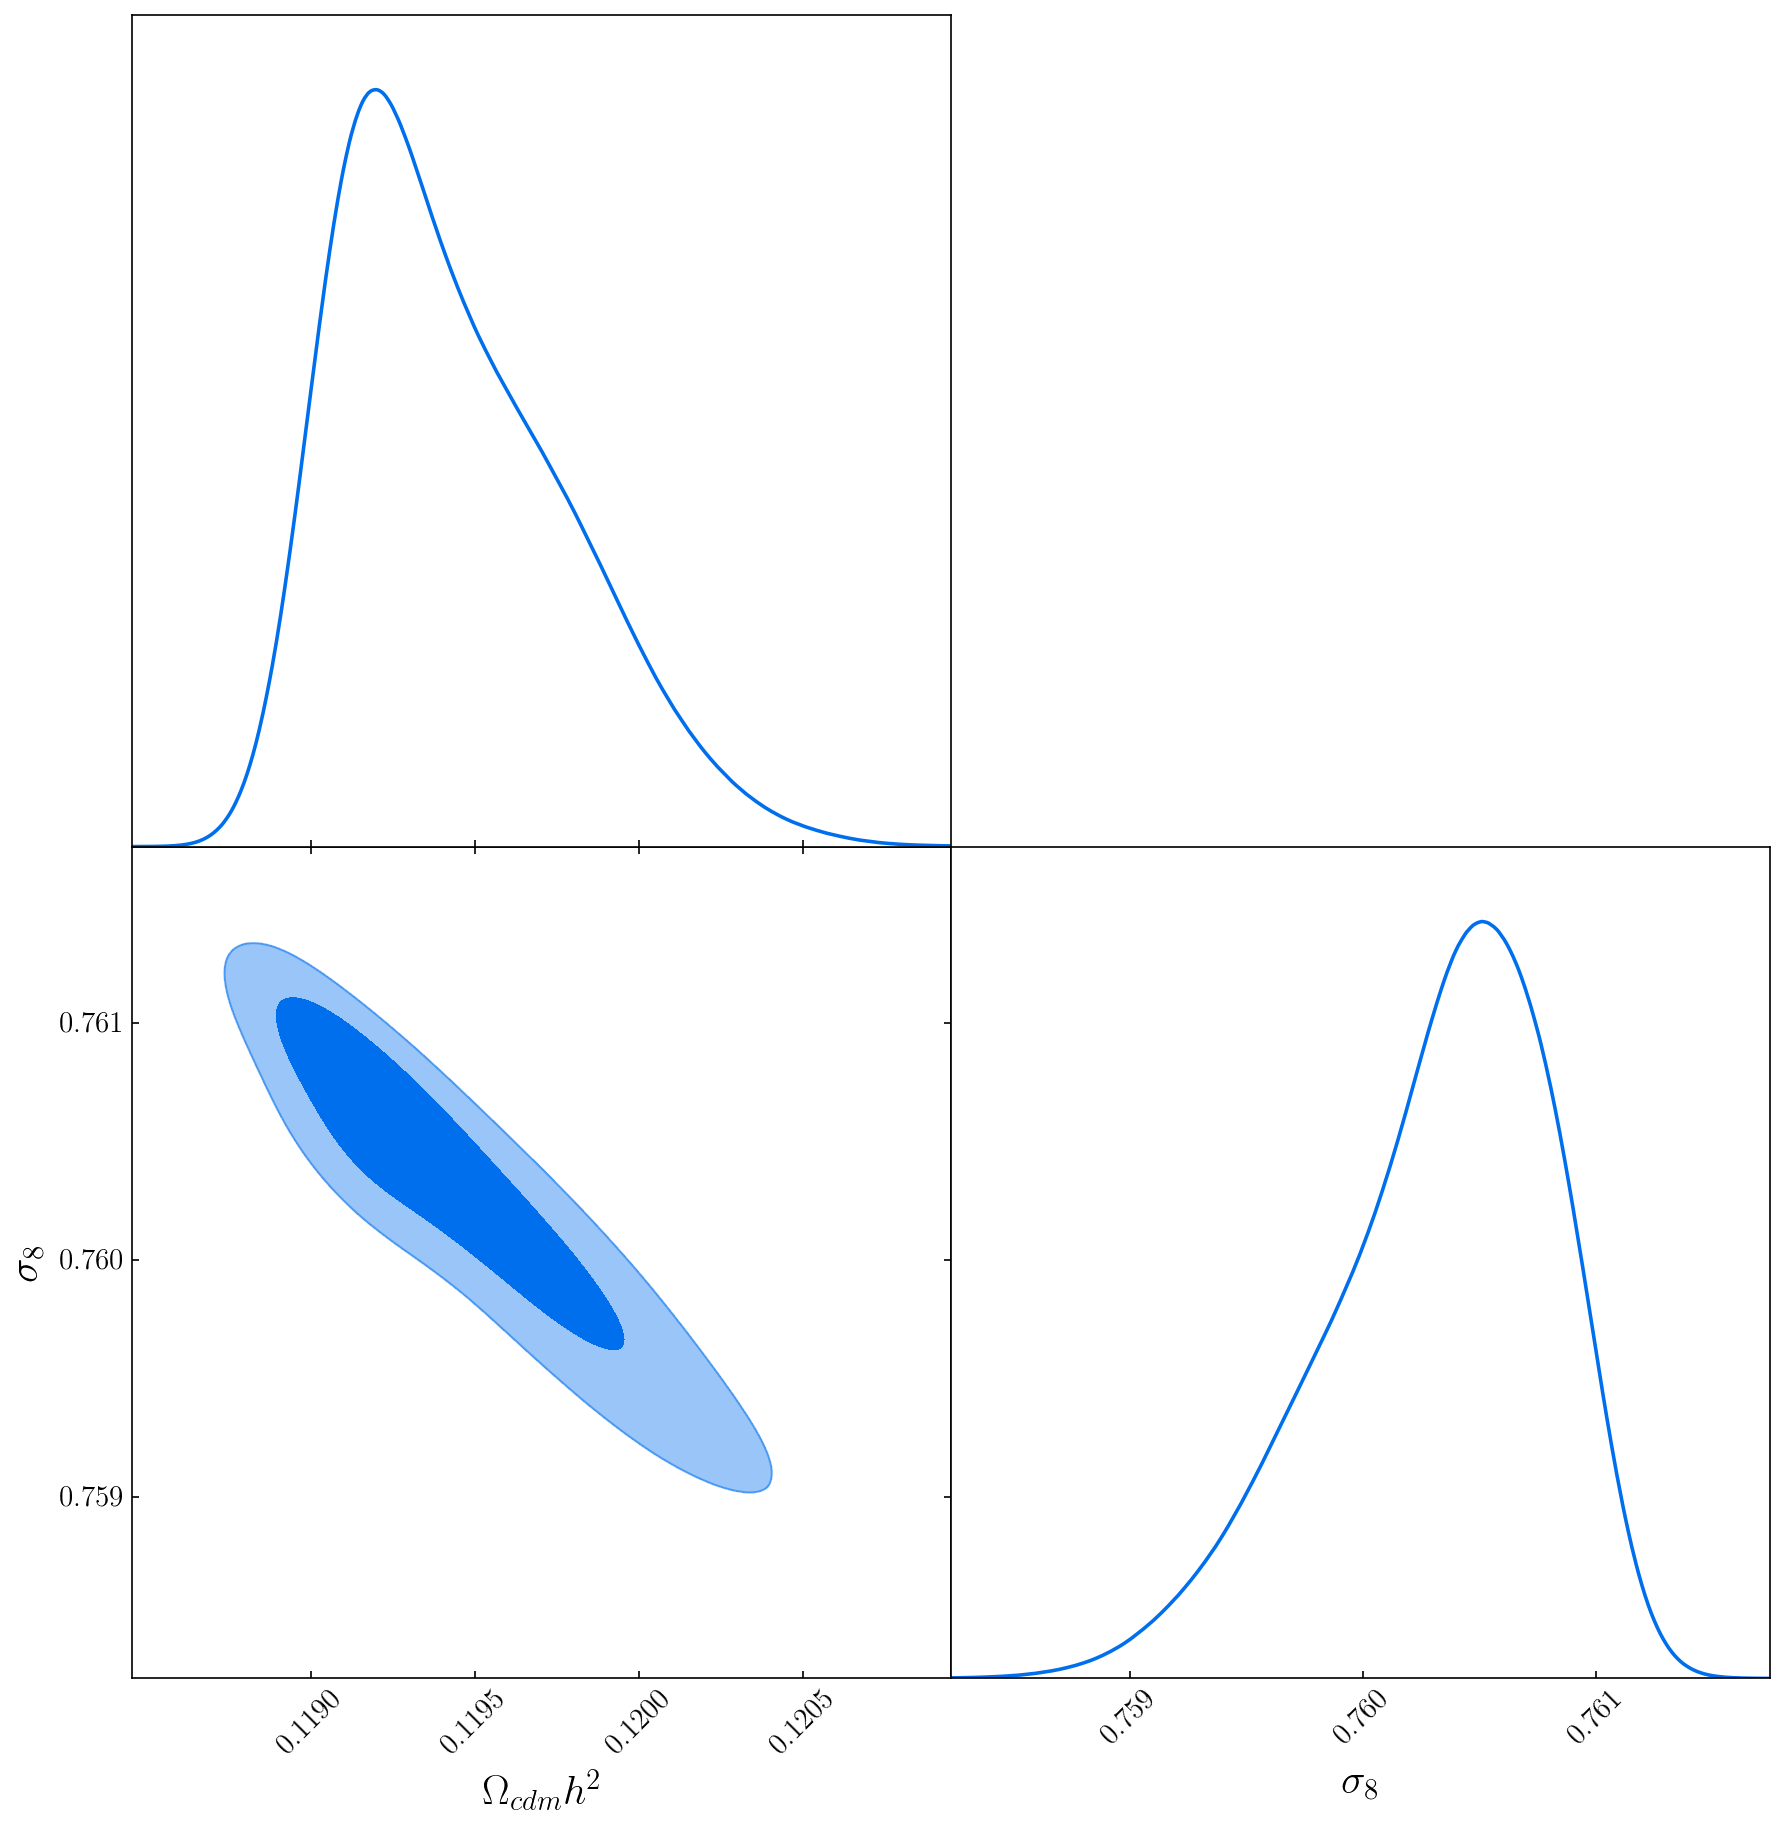

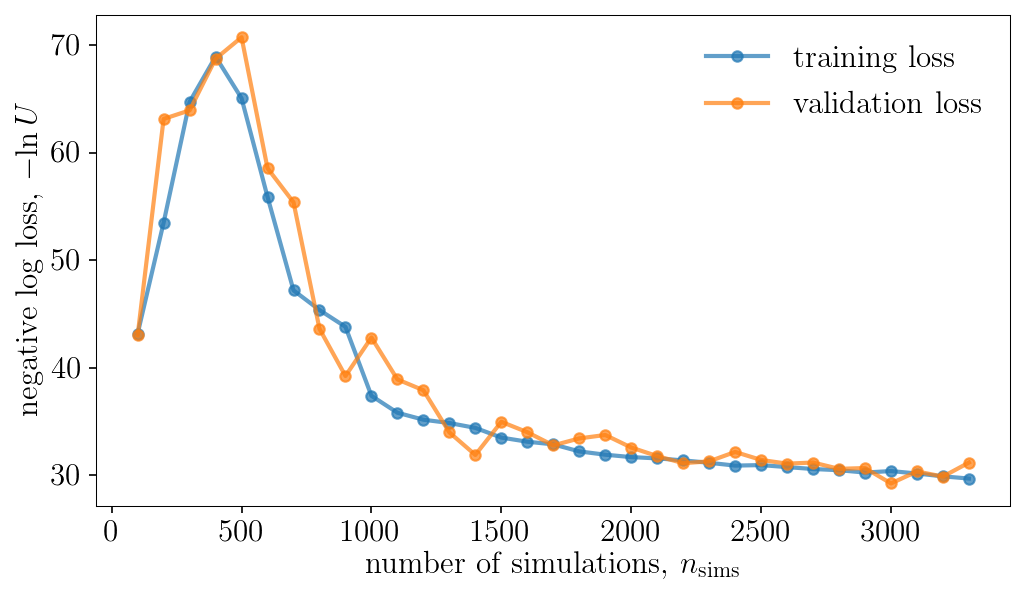

Population 33/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


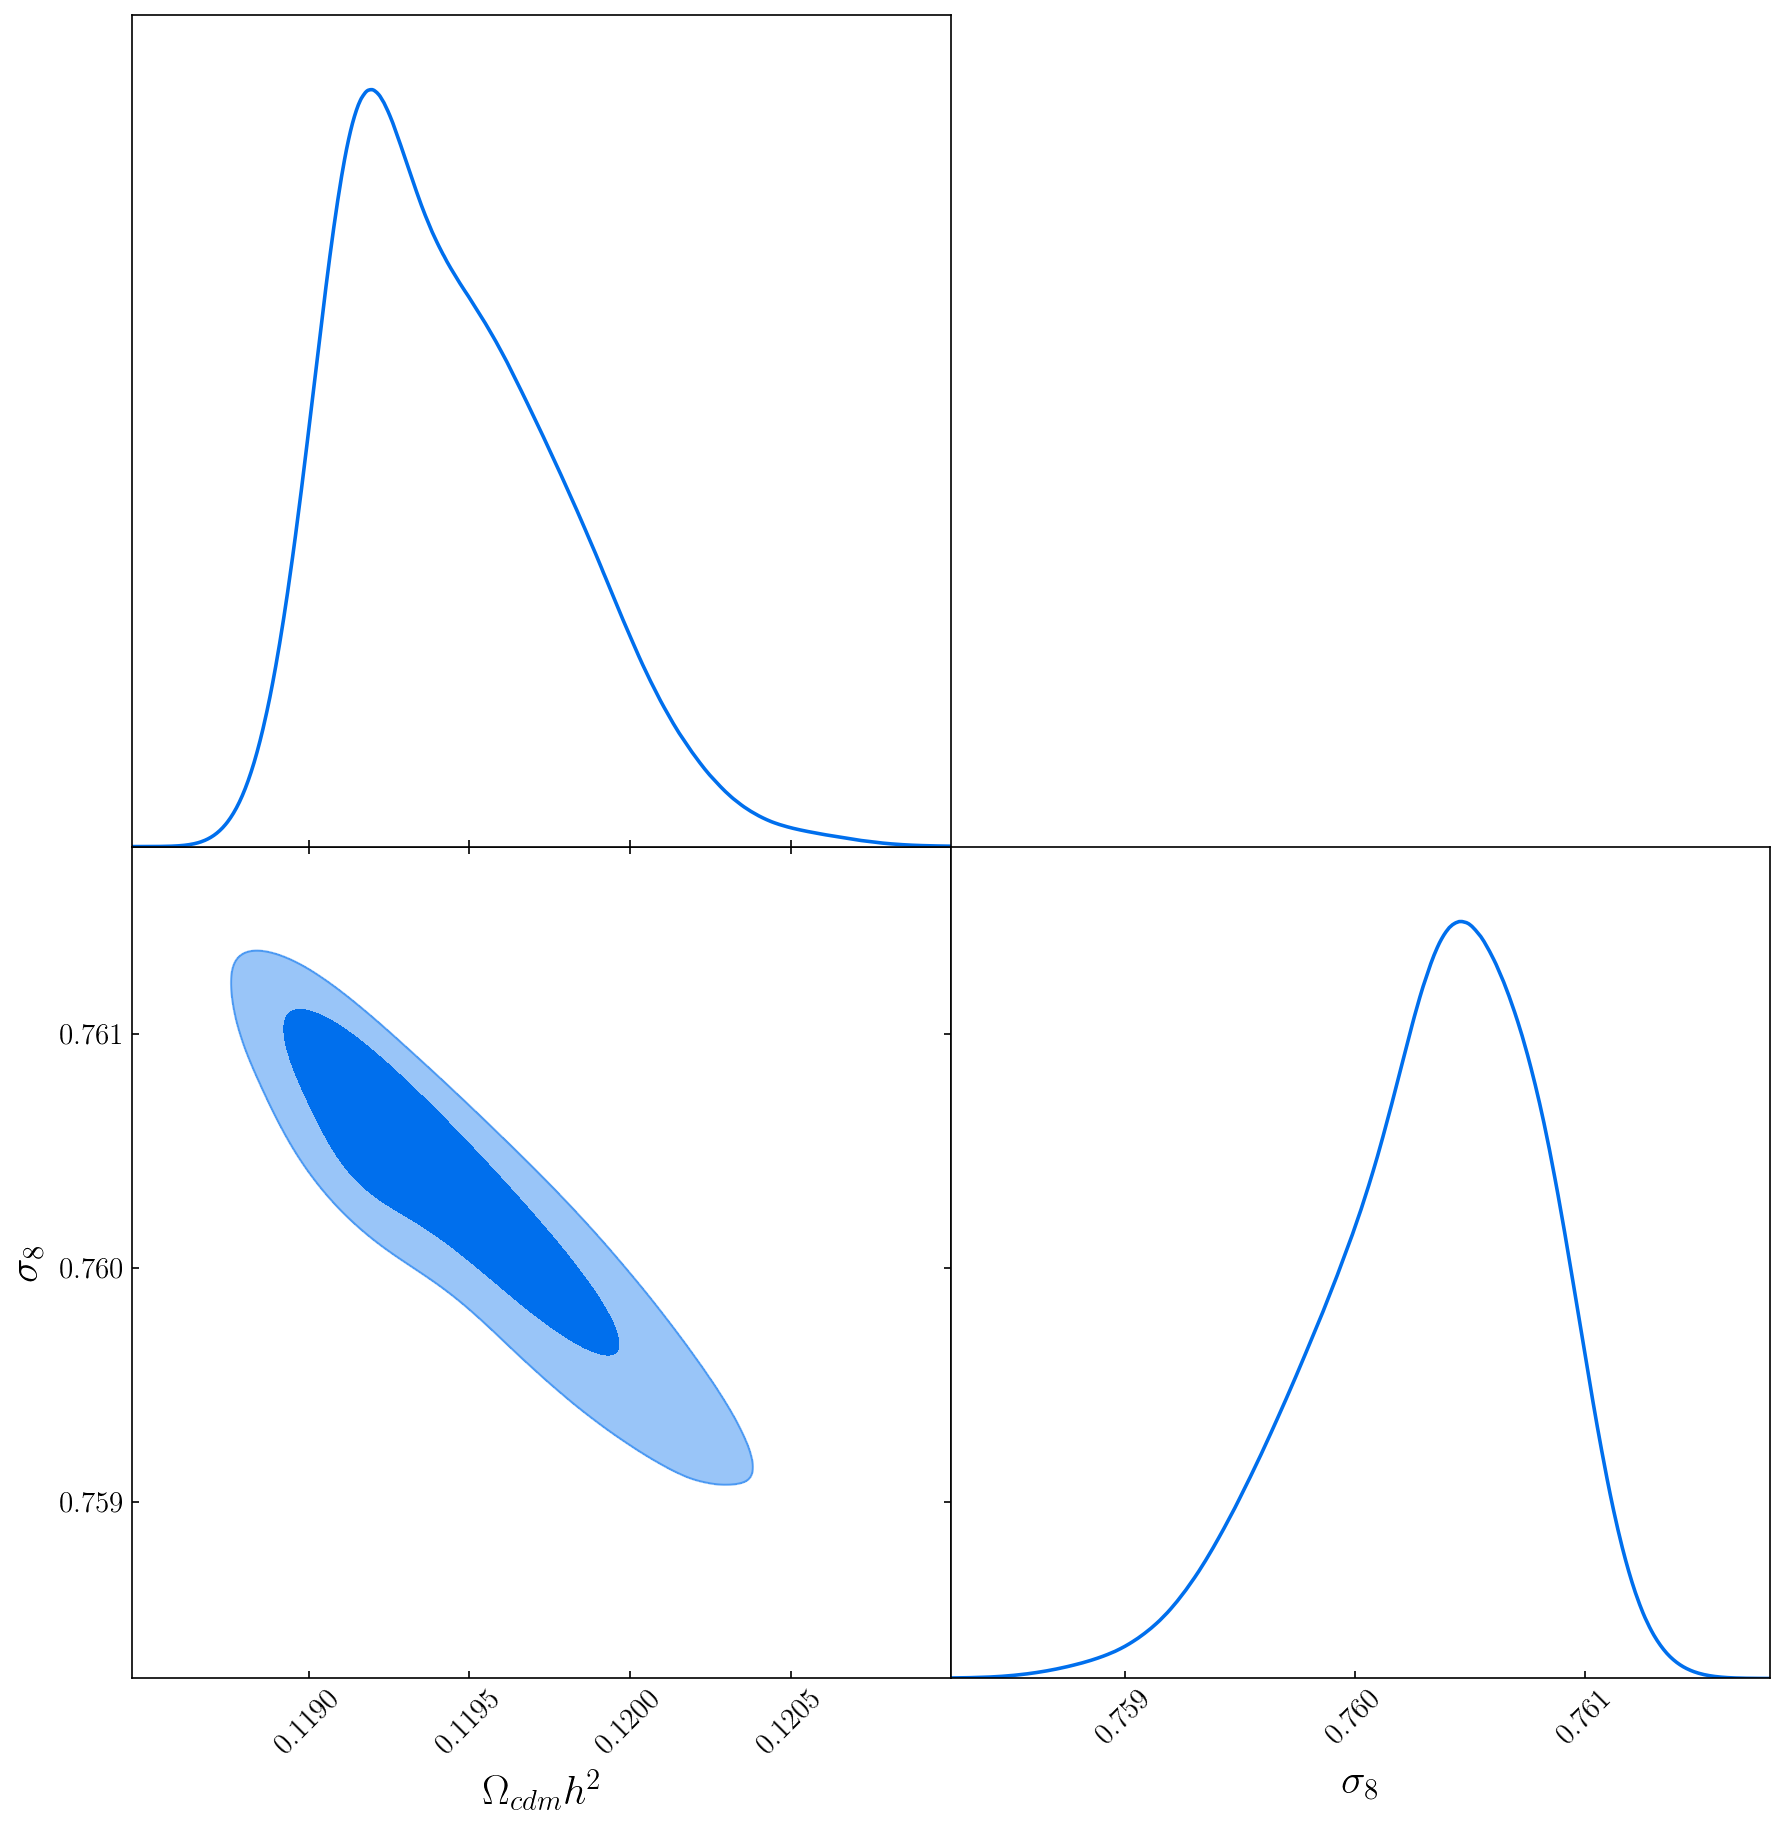

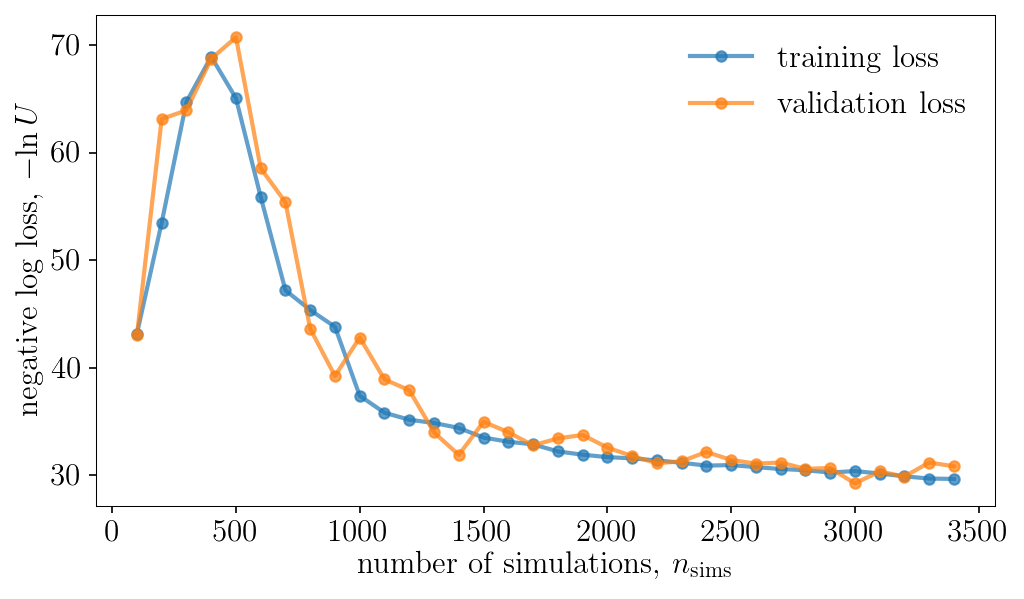

Population 34/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


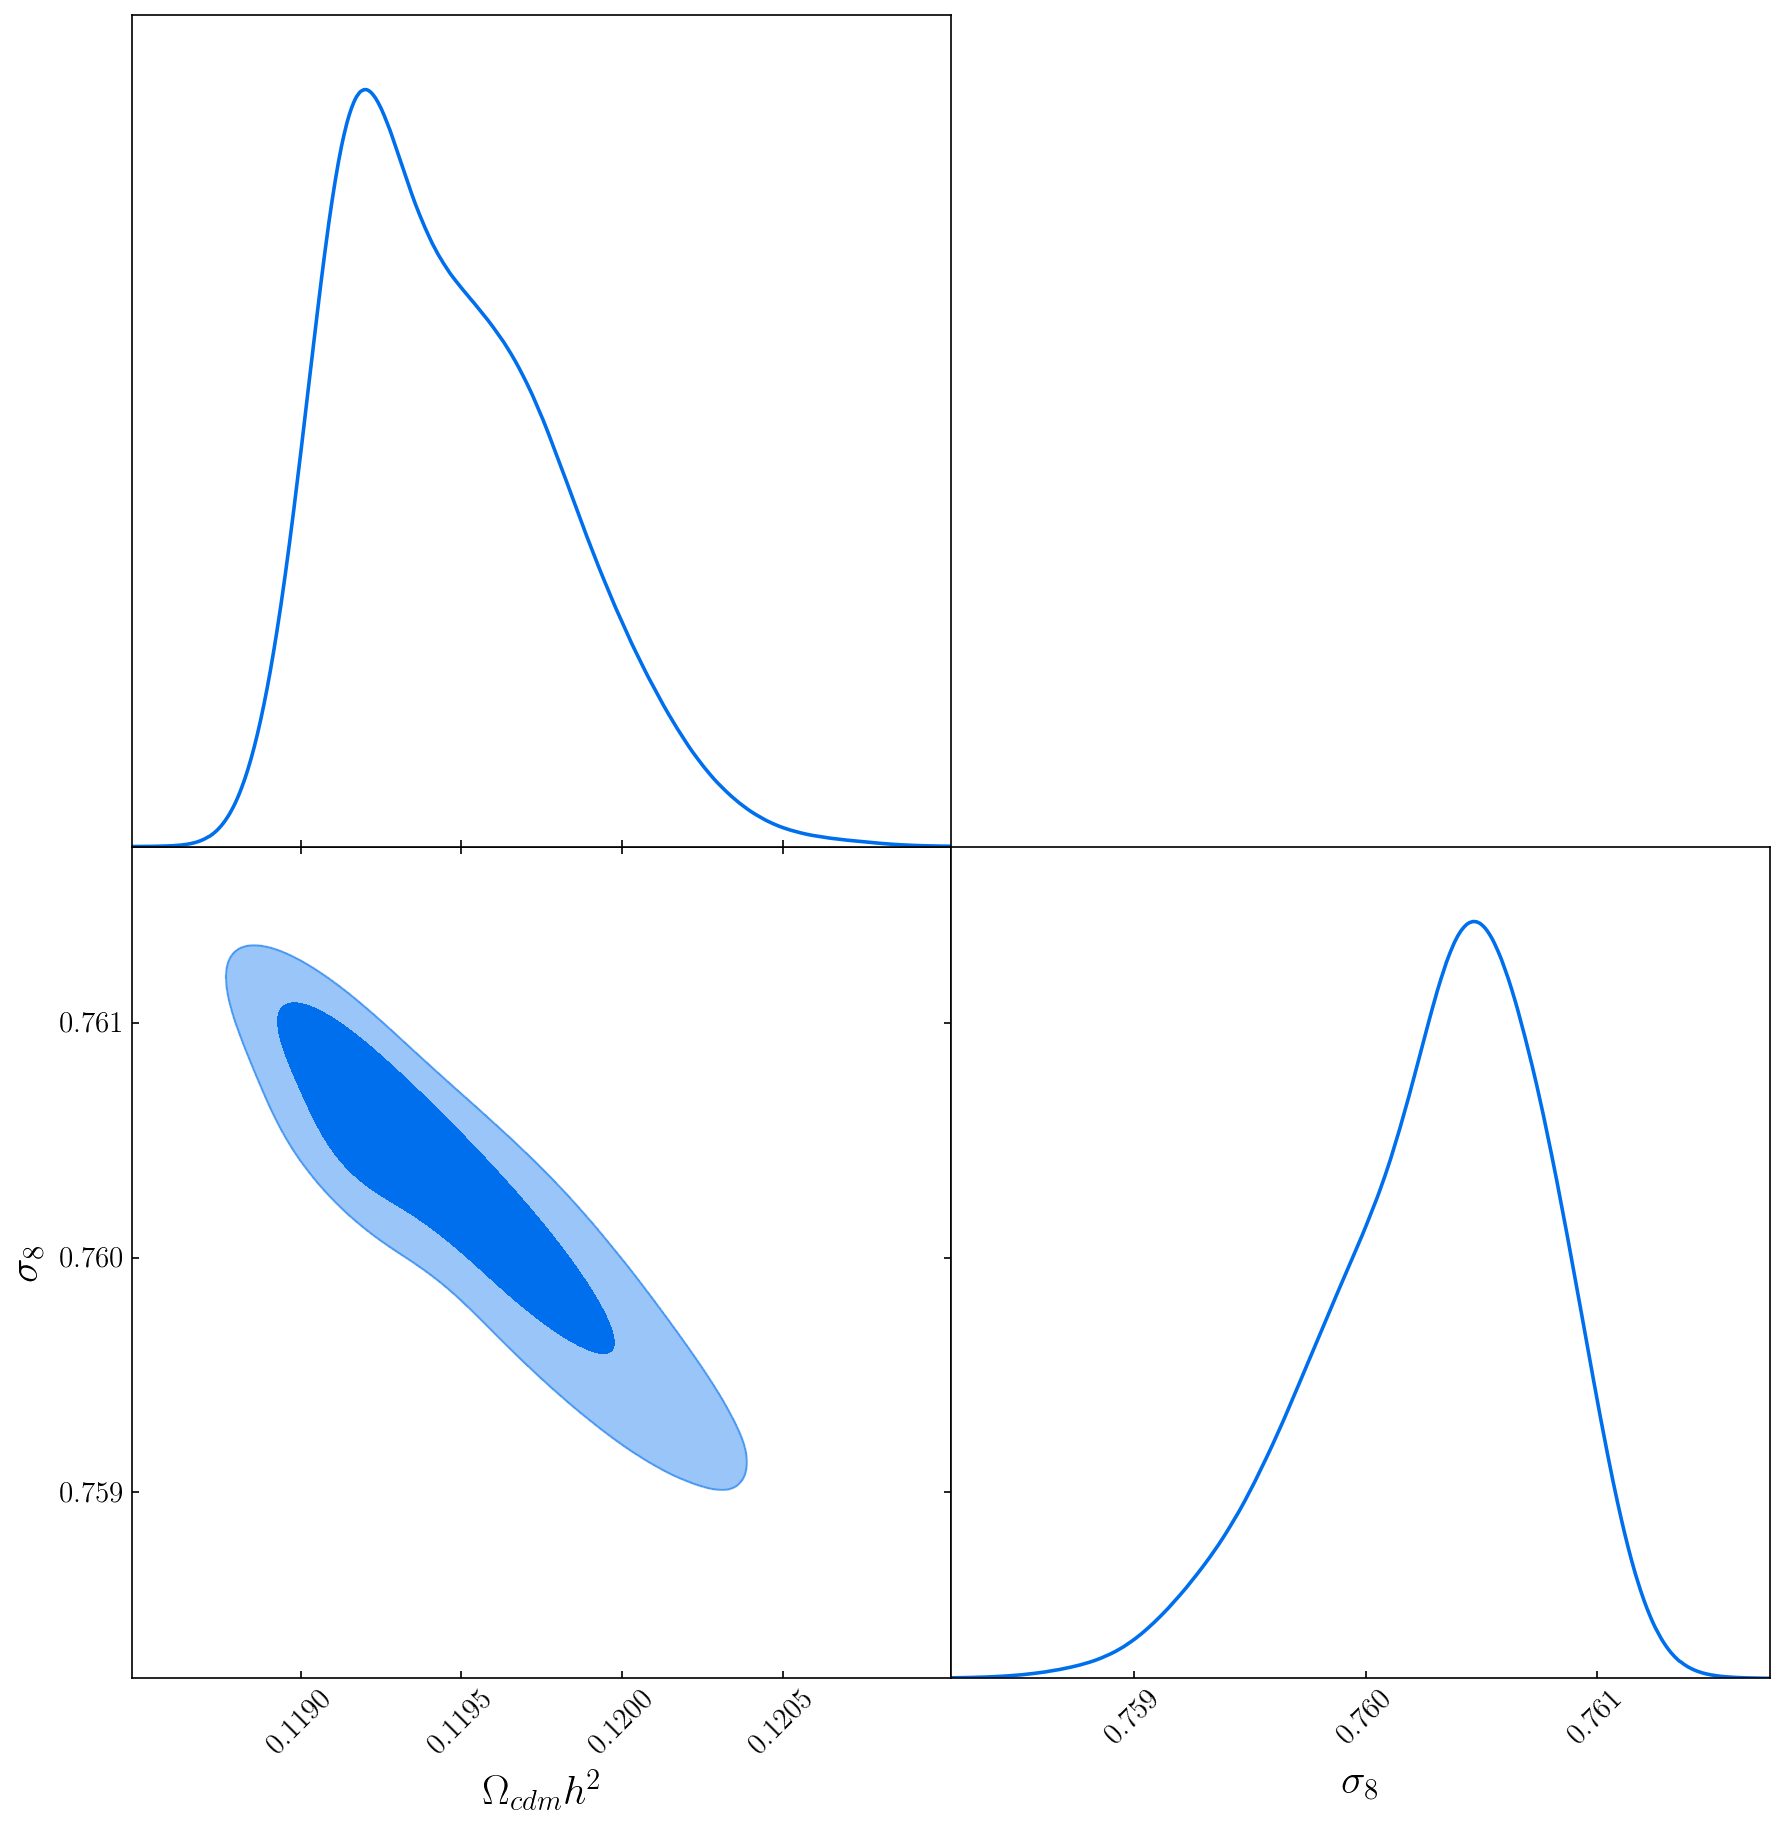

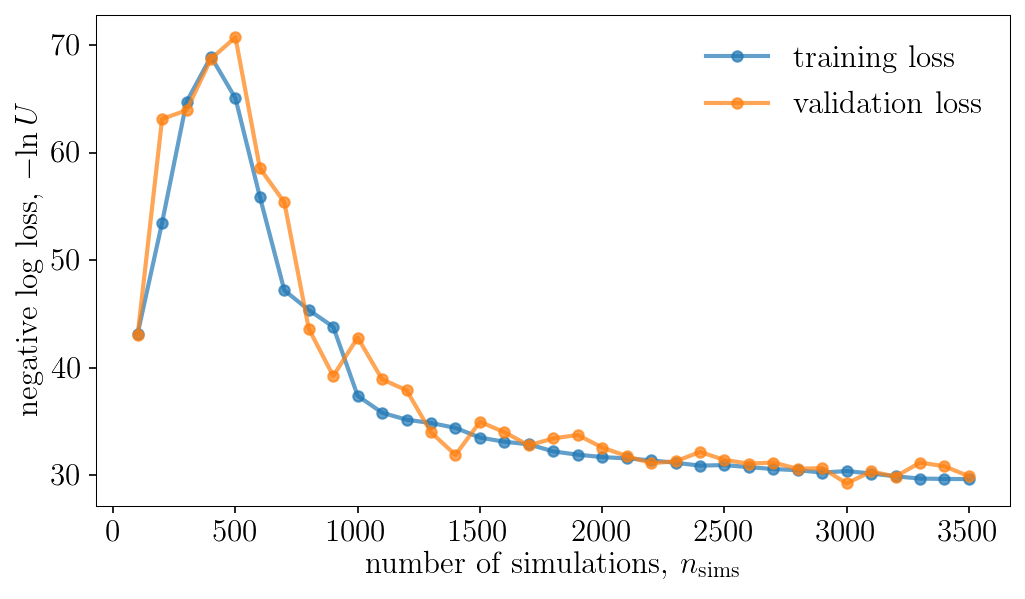

Population 35/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


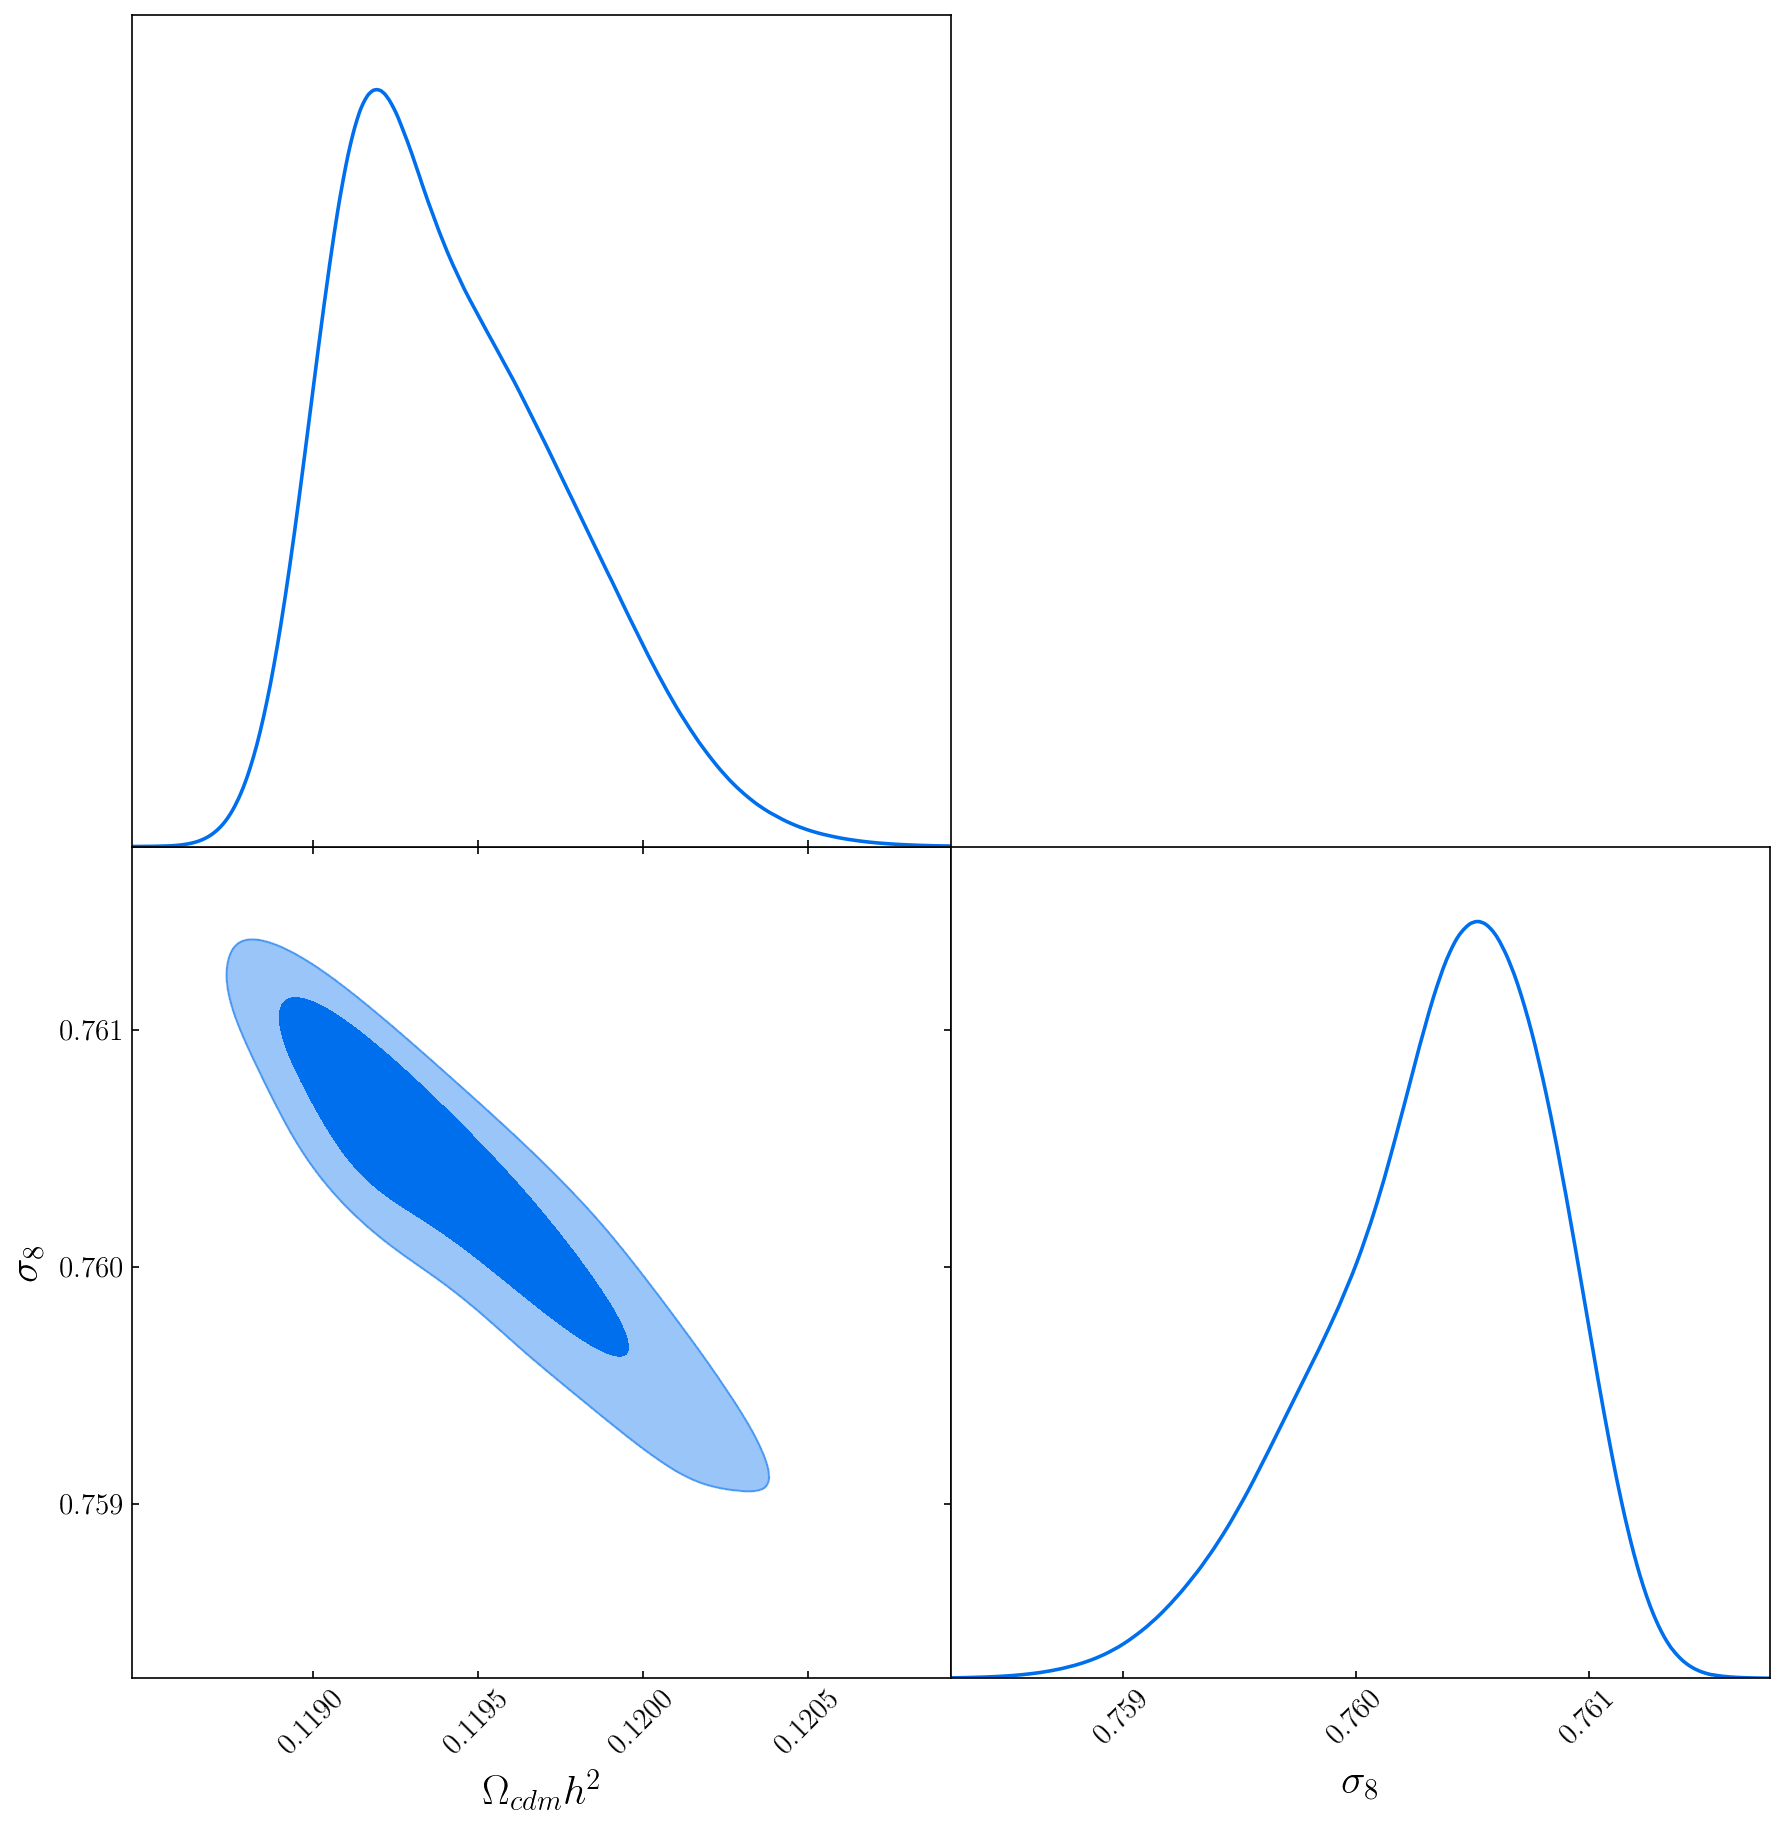

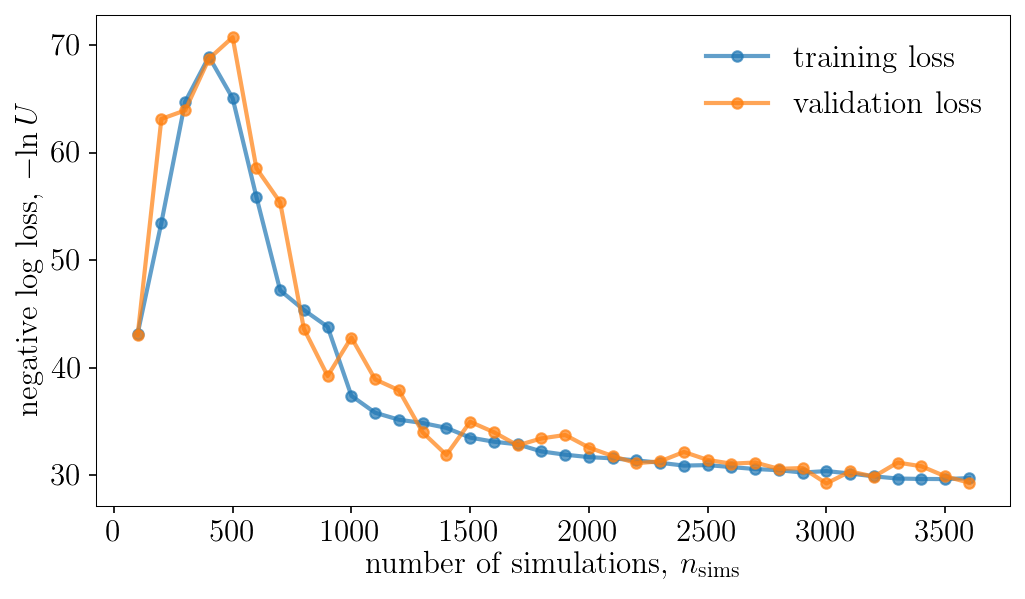

Population 36/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


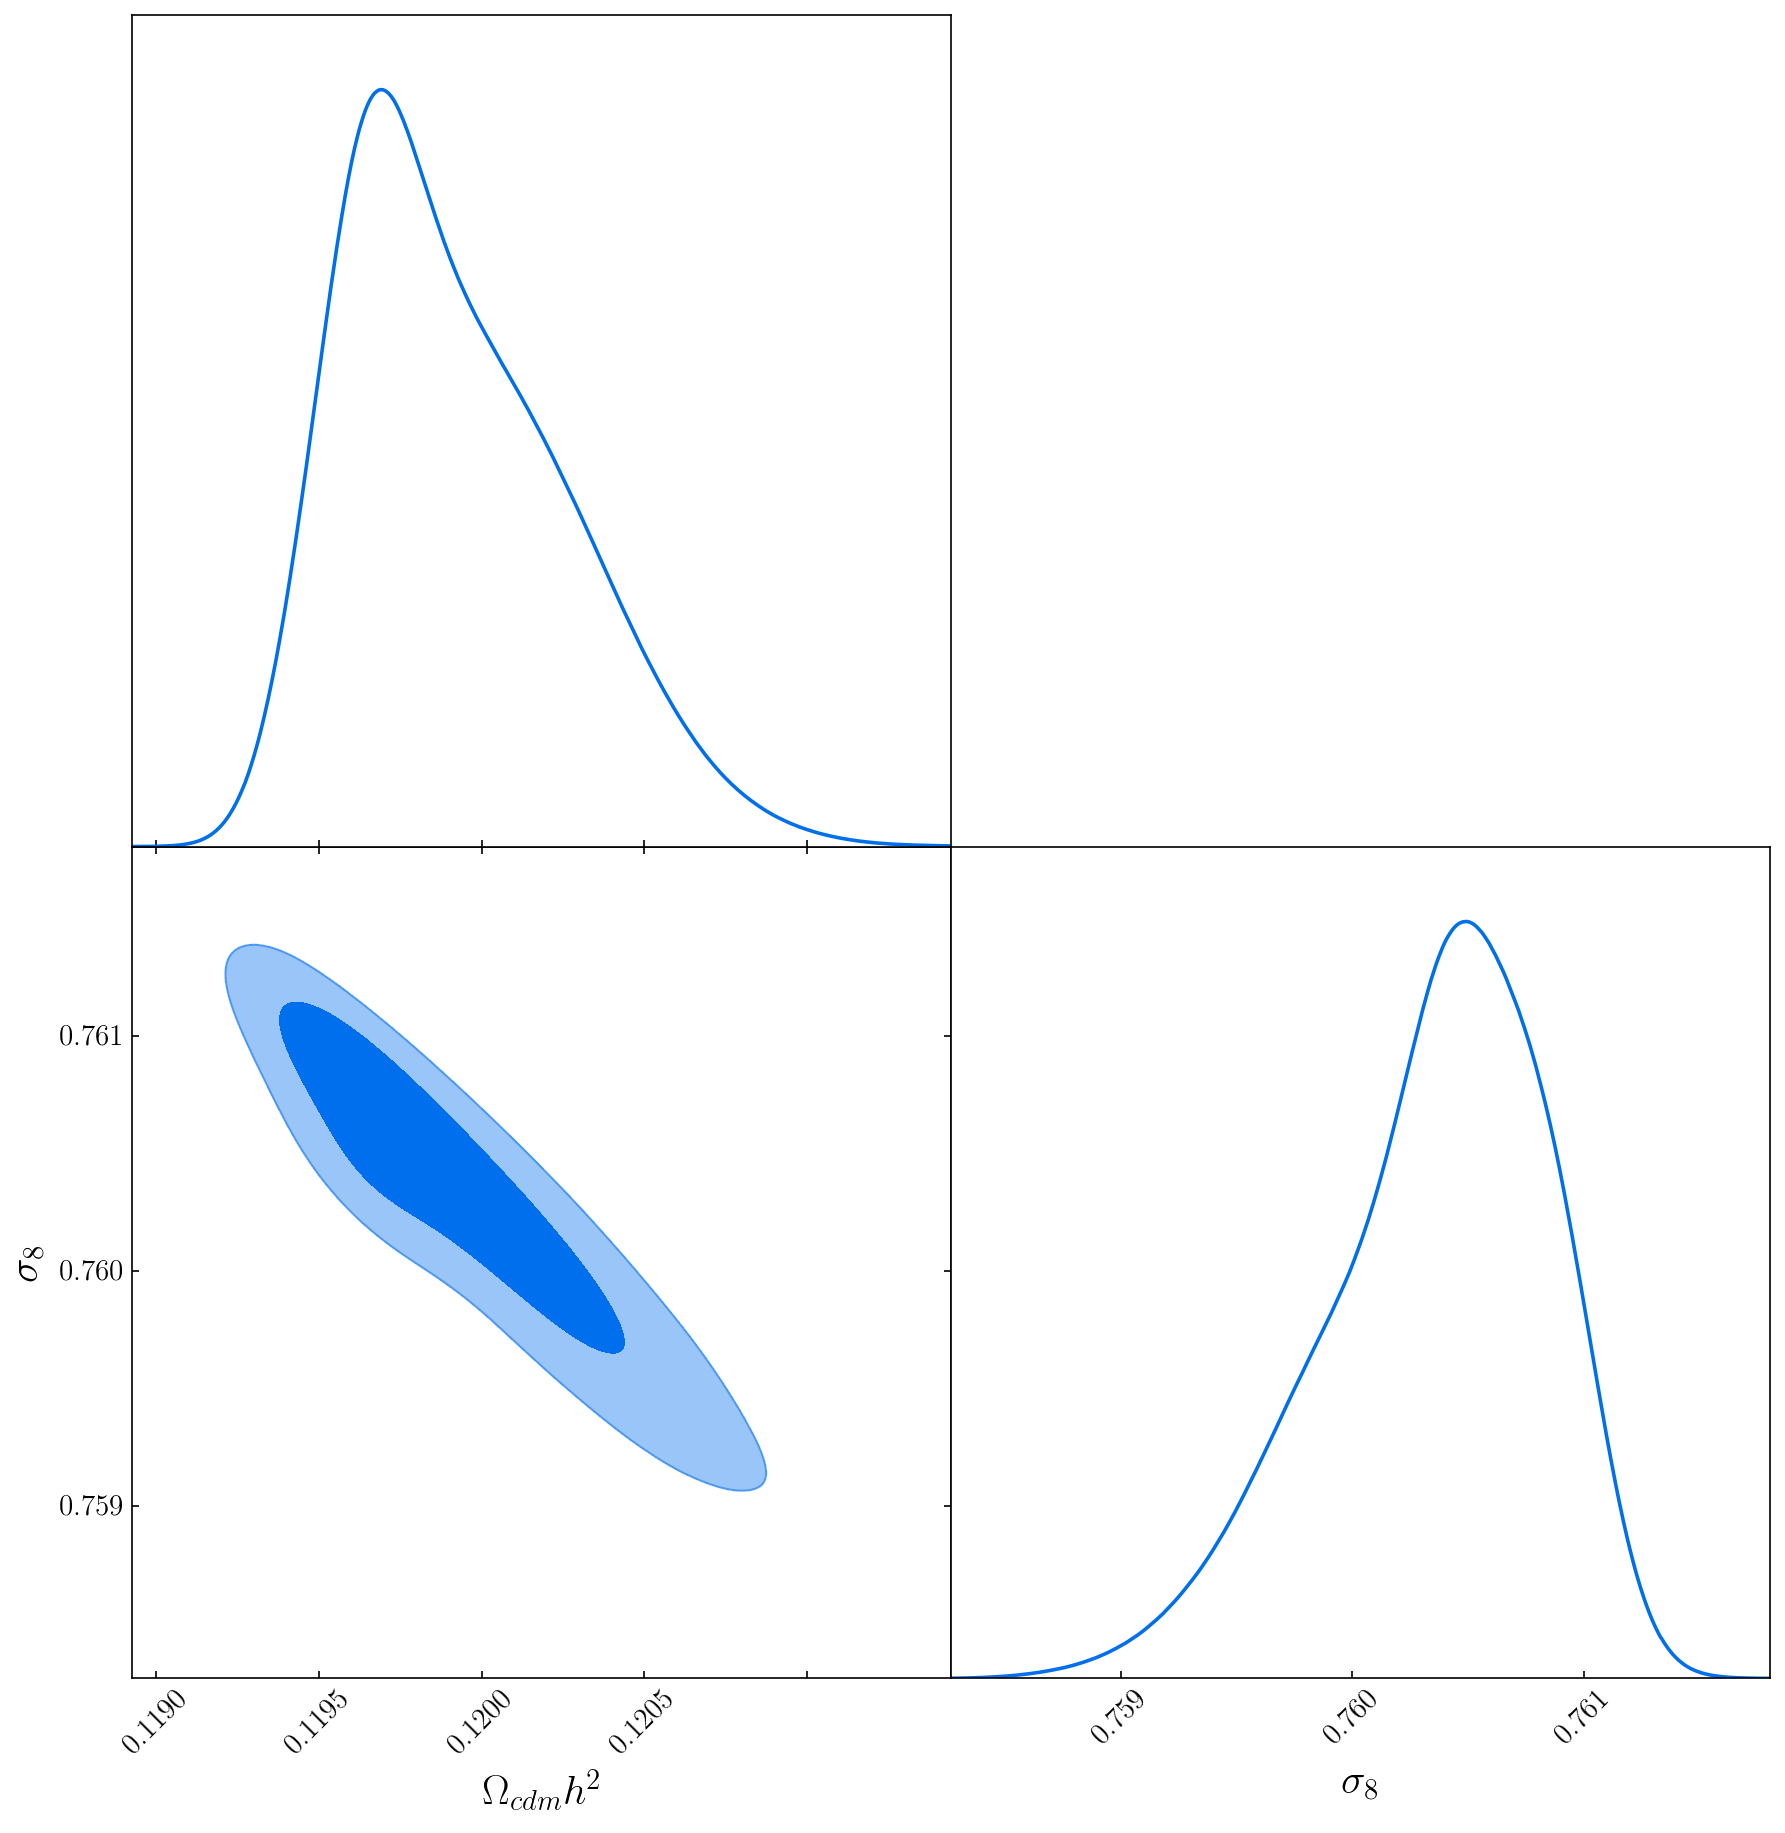

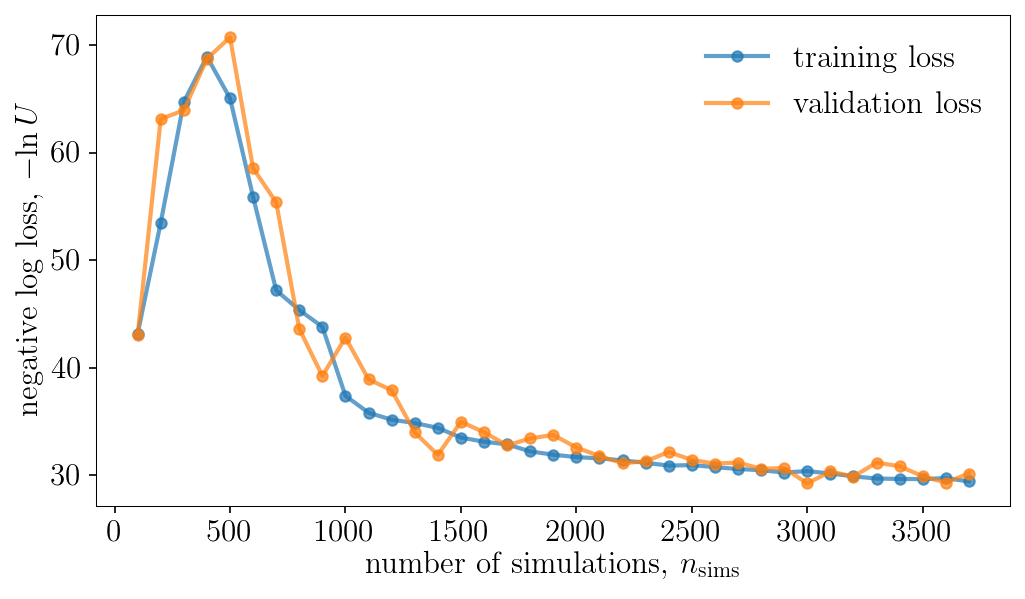

Population 37/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


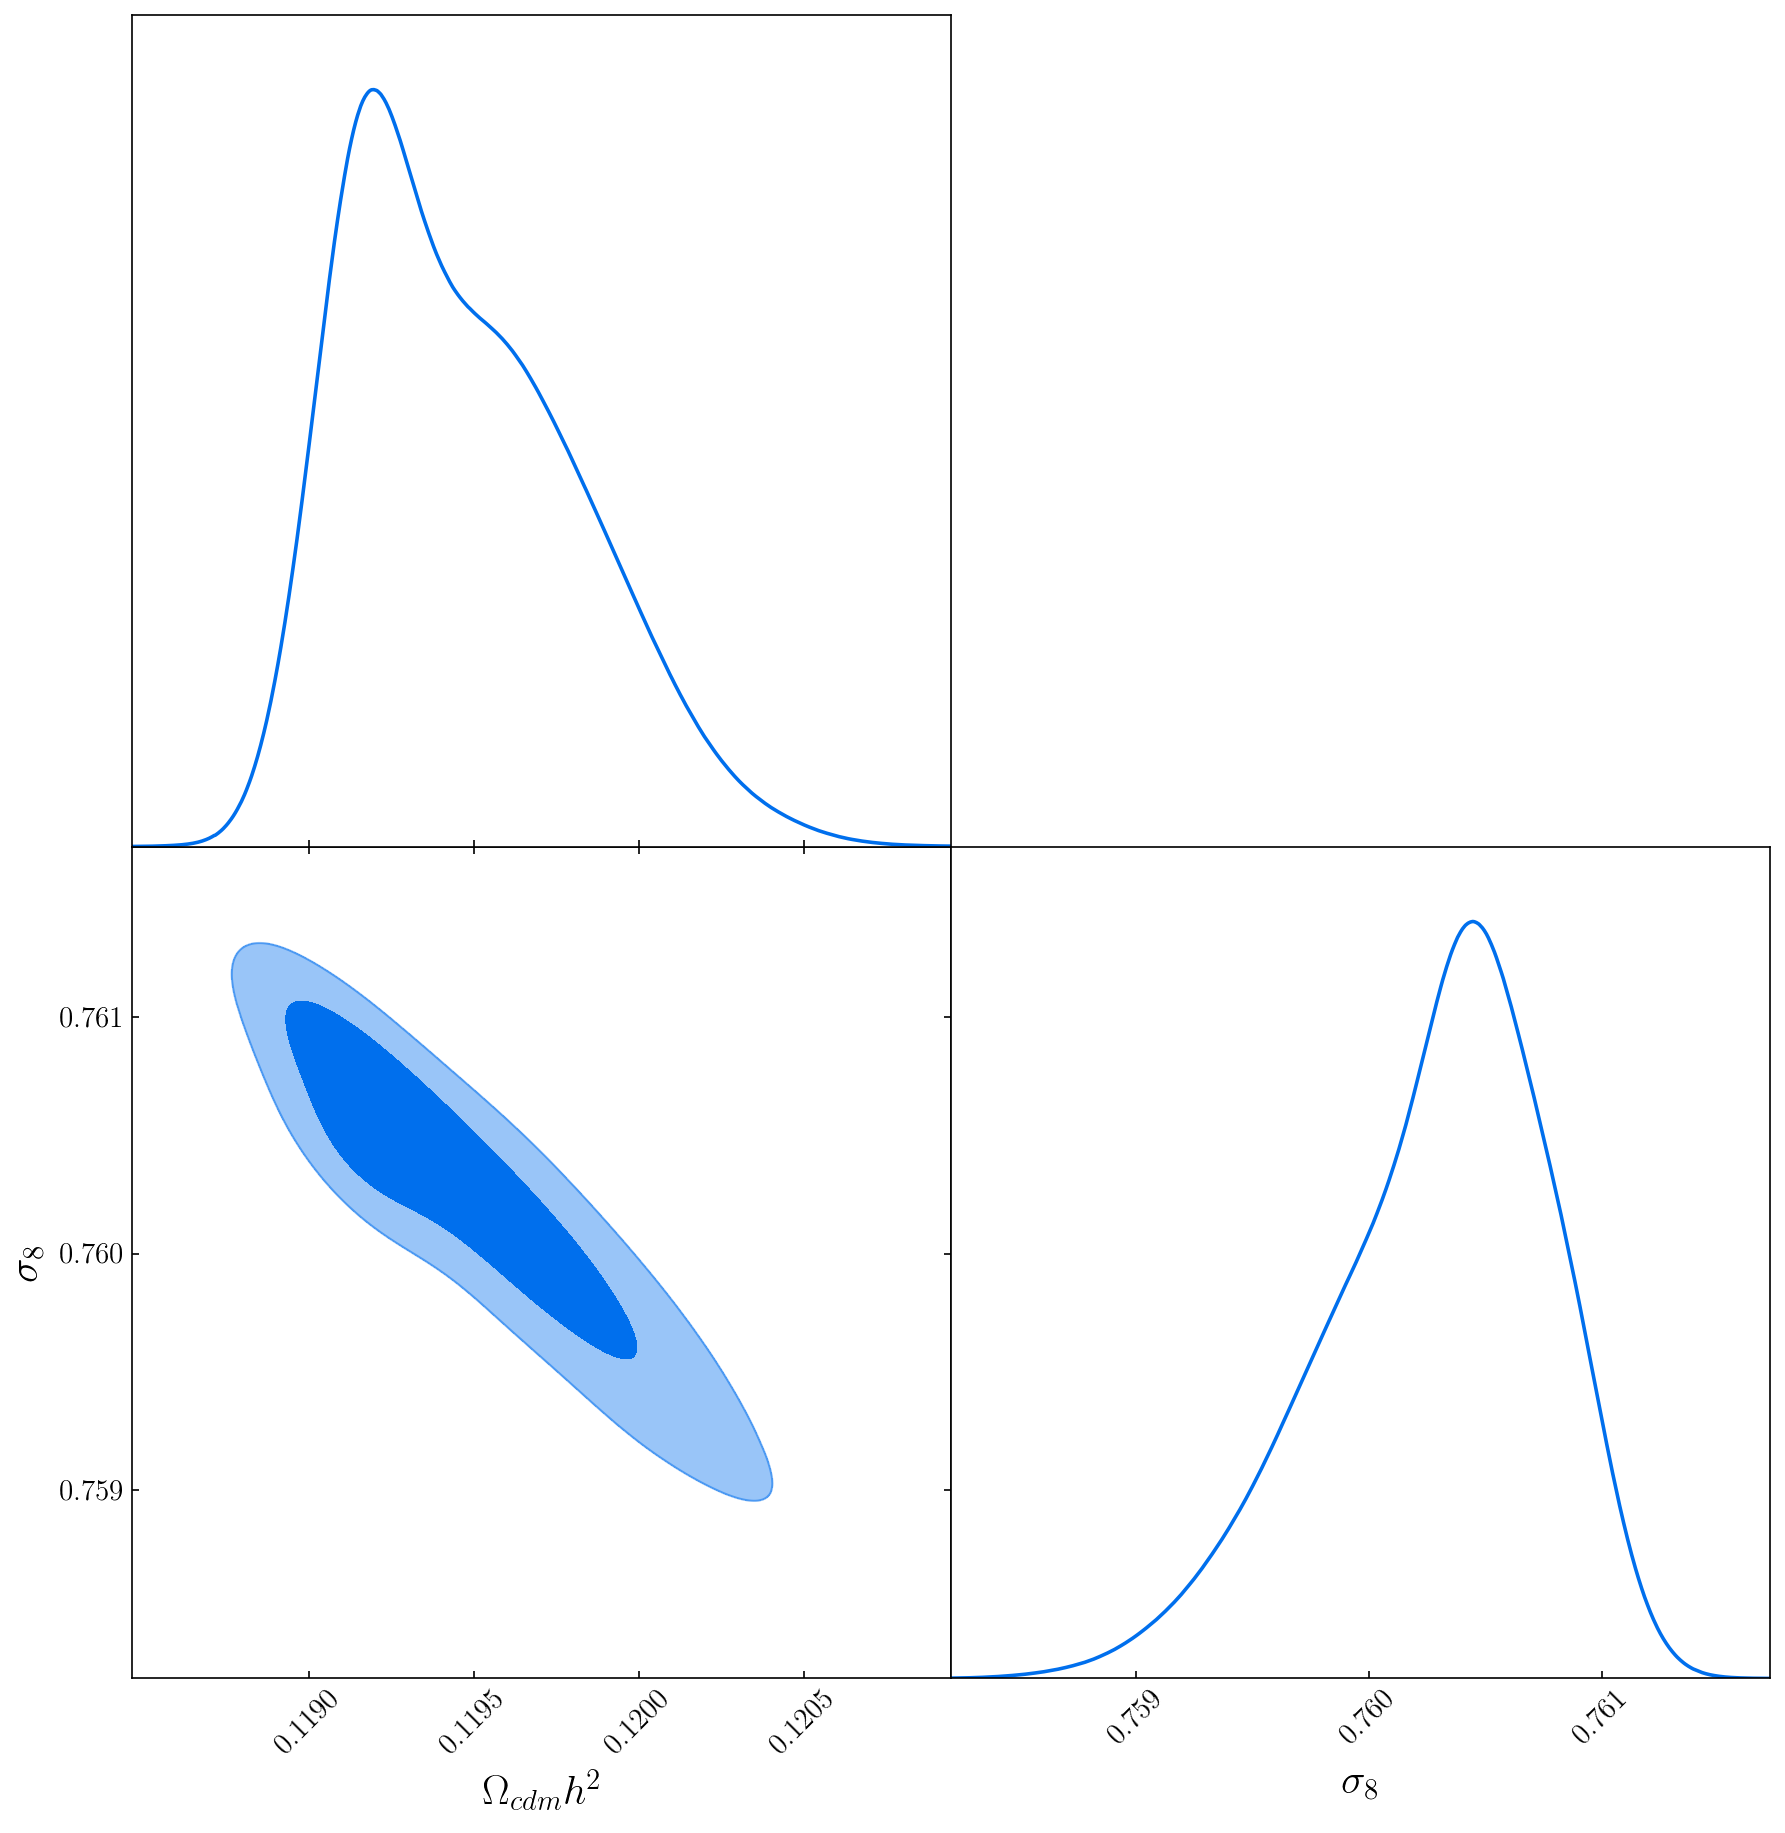

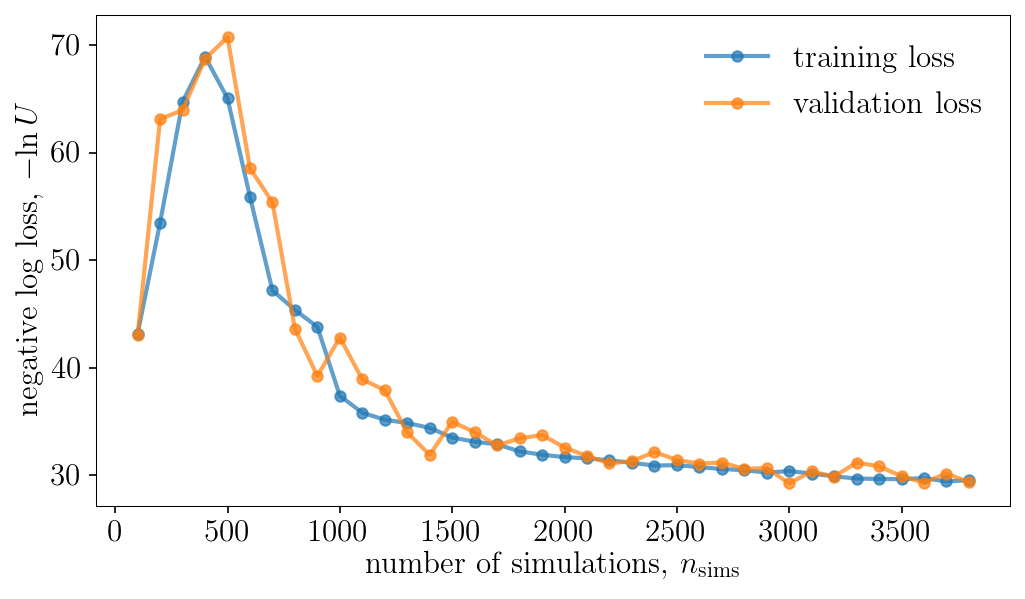

Population 38/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


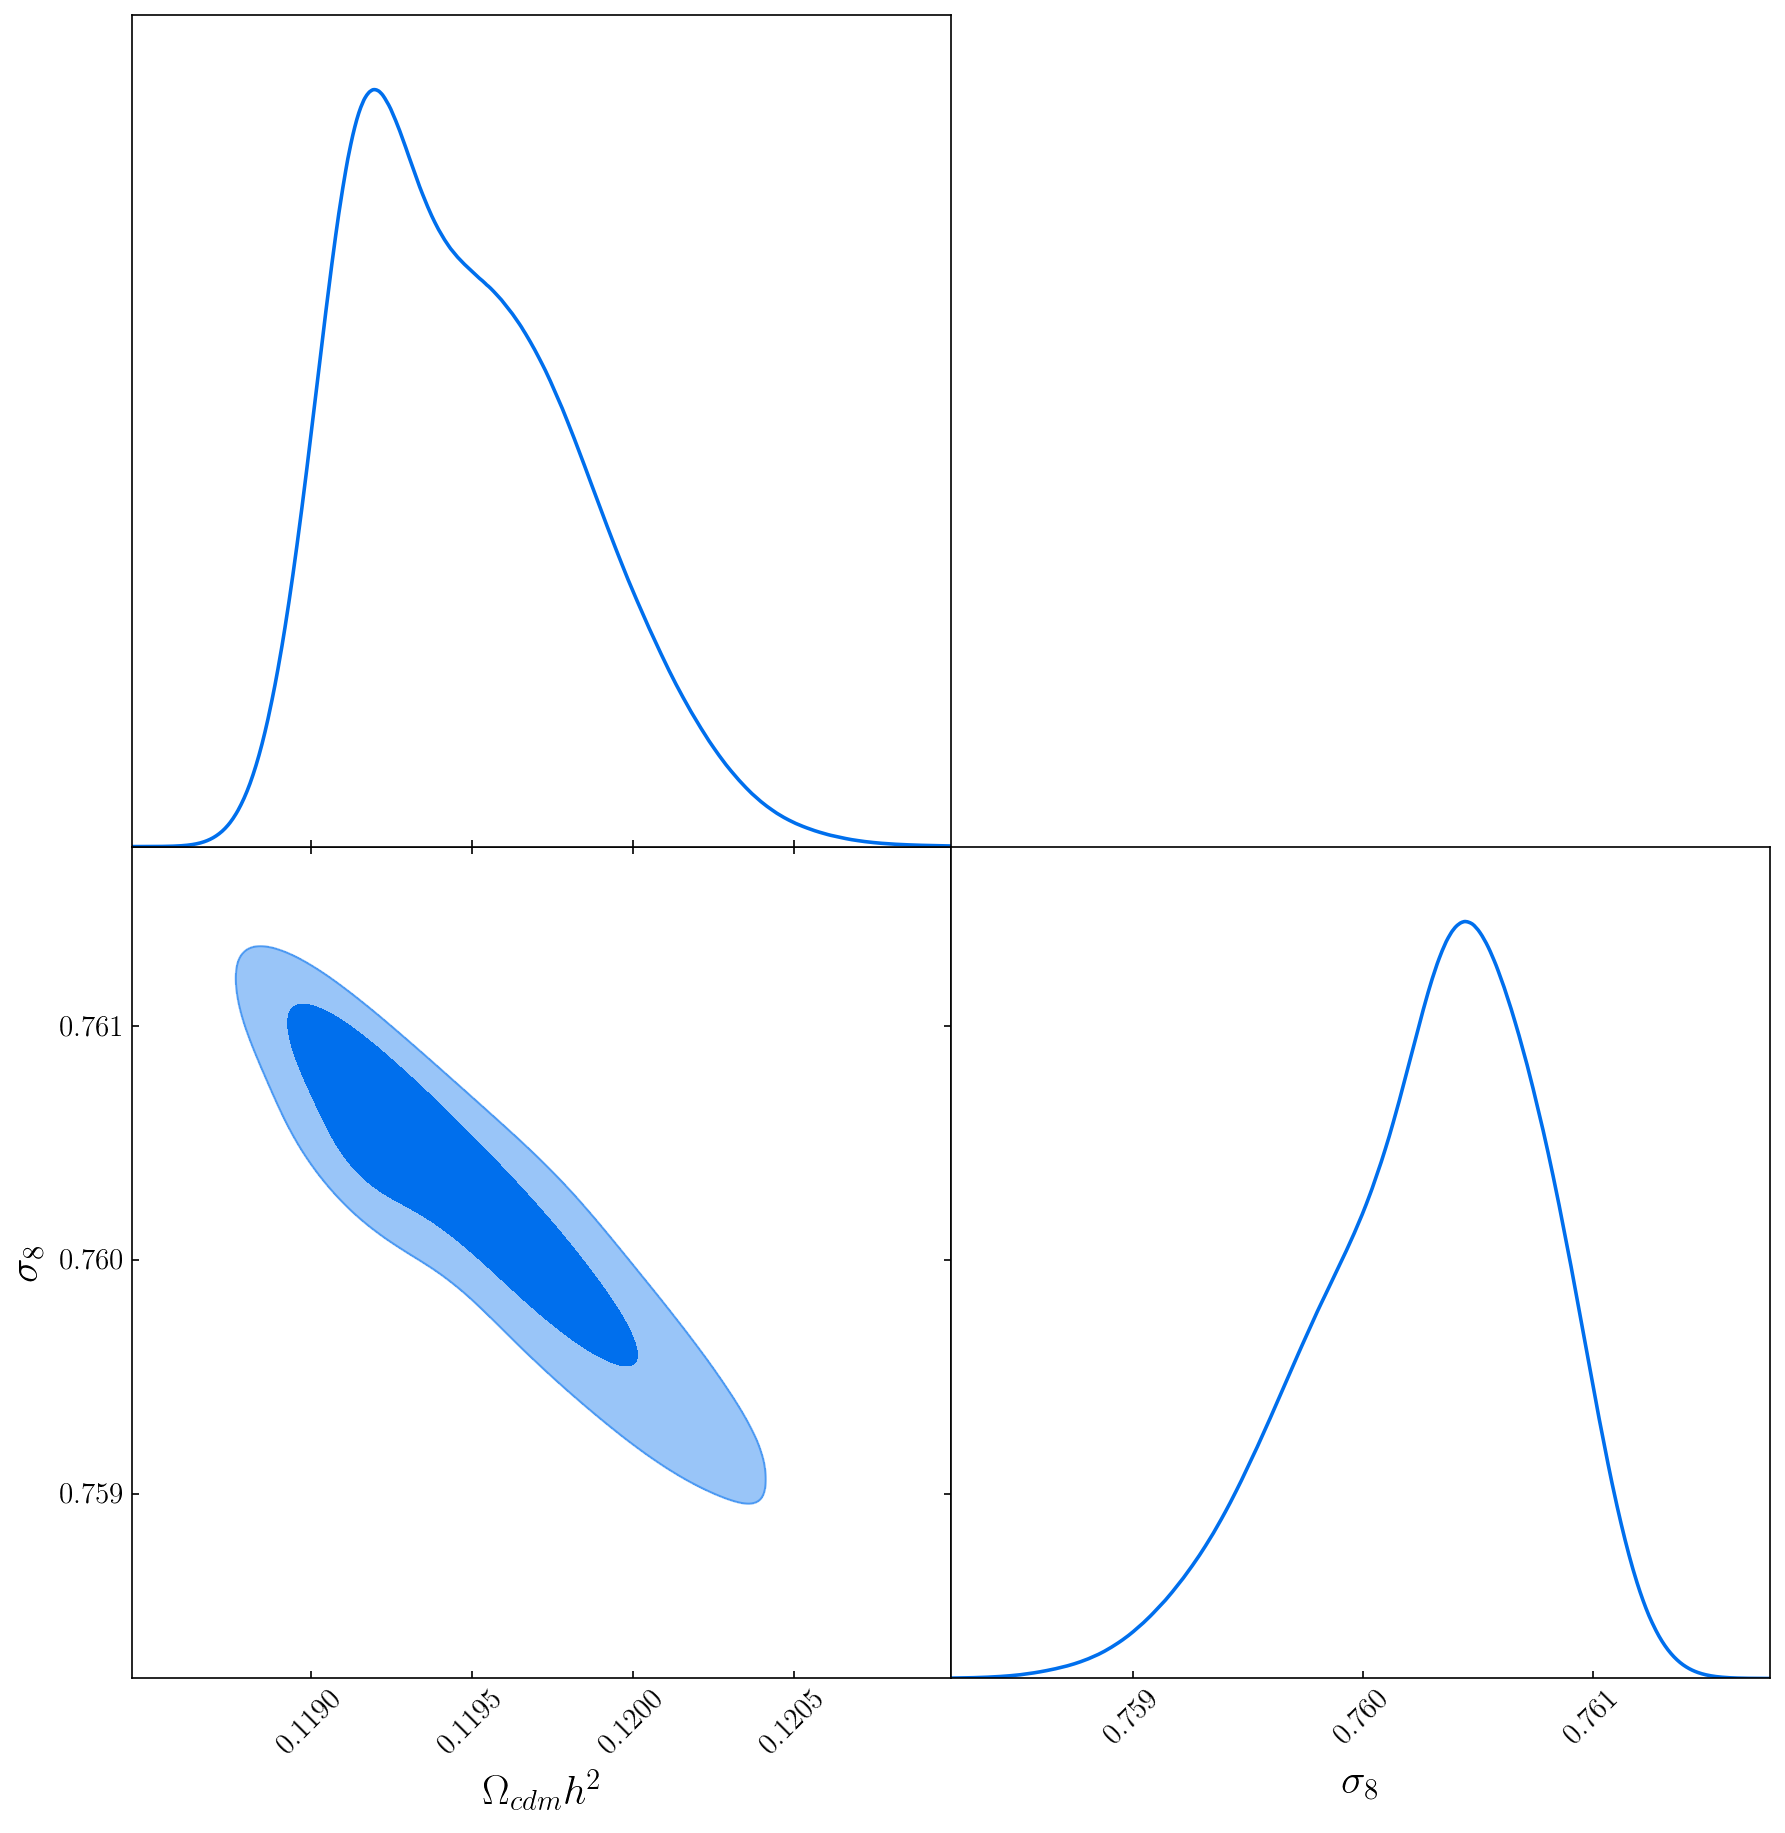

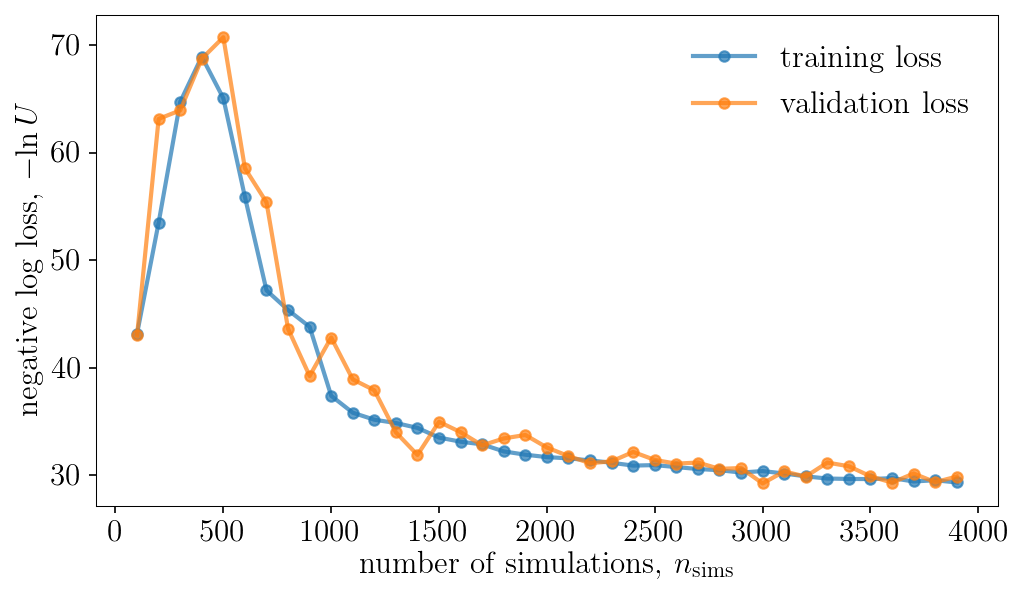

Population 39/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


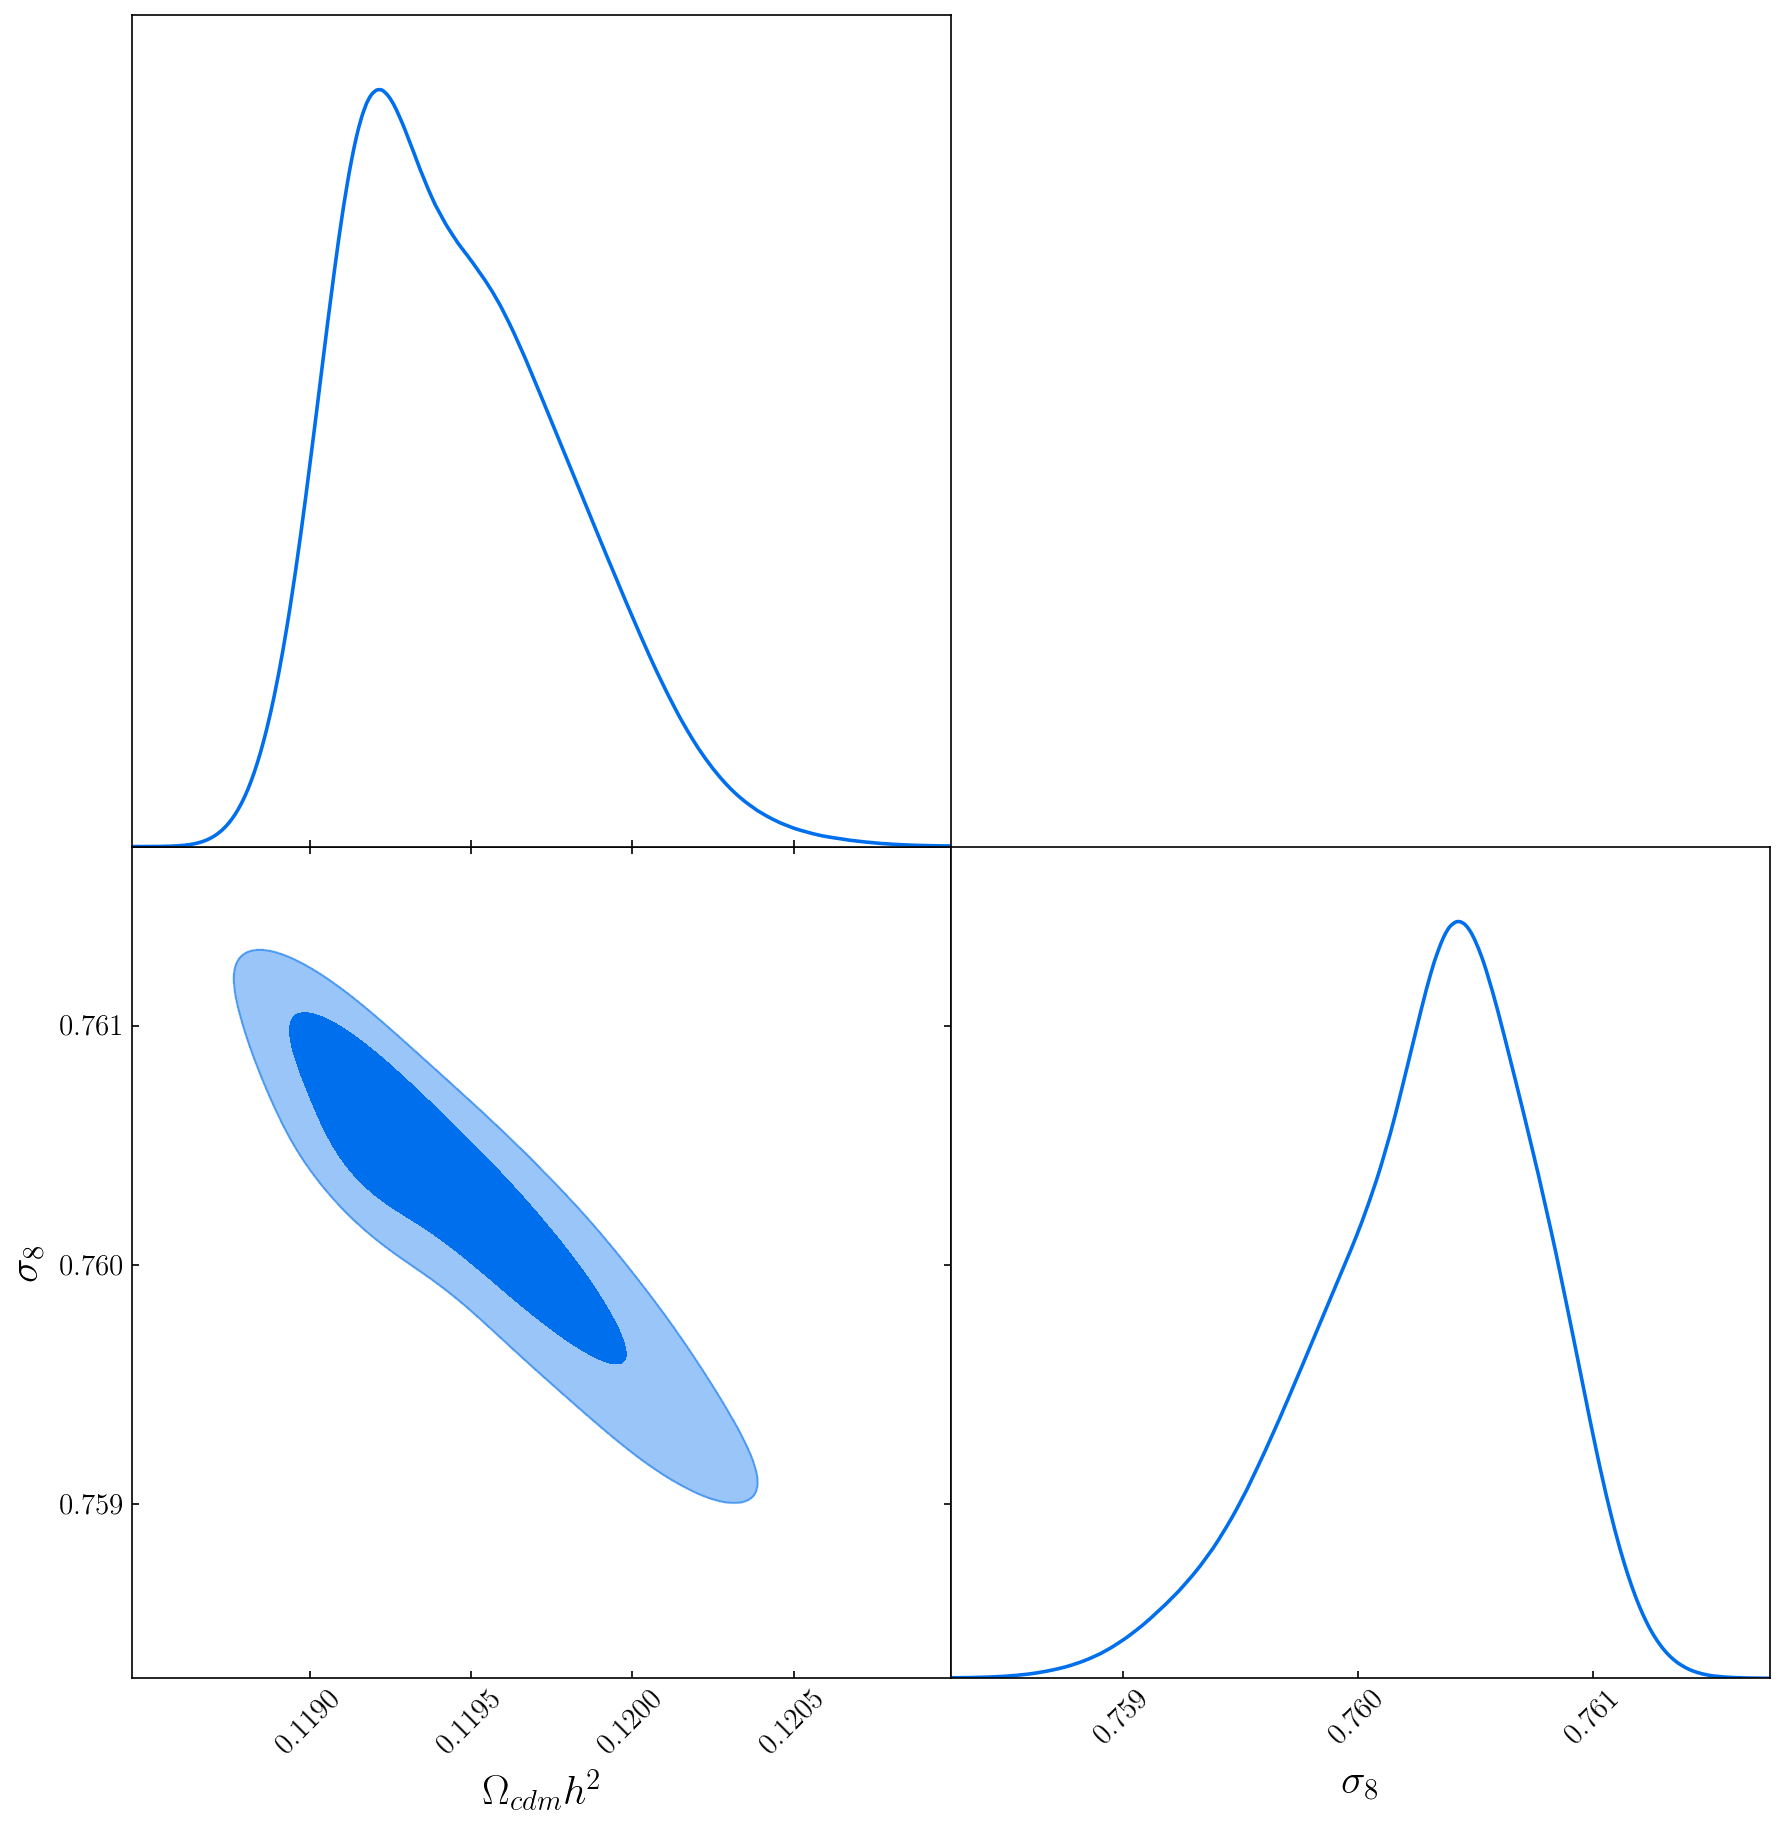

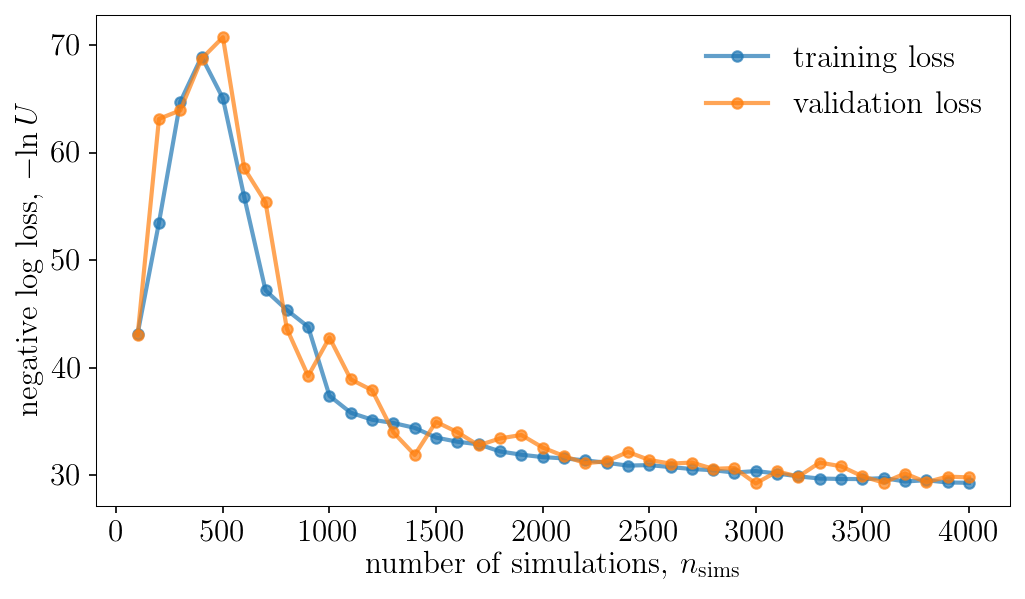

Population 40/40
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


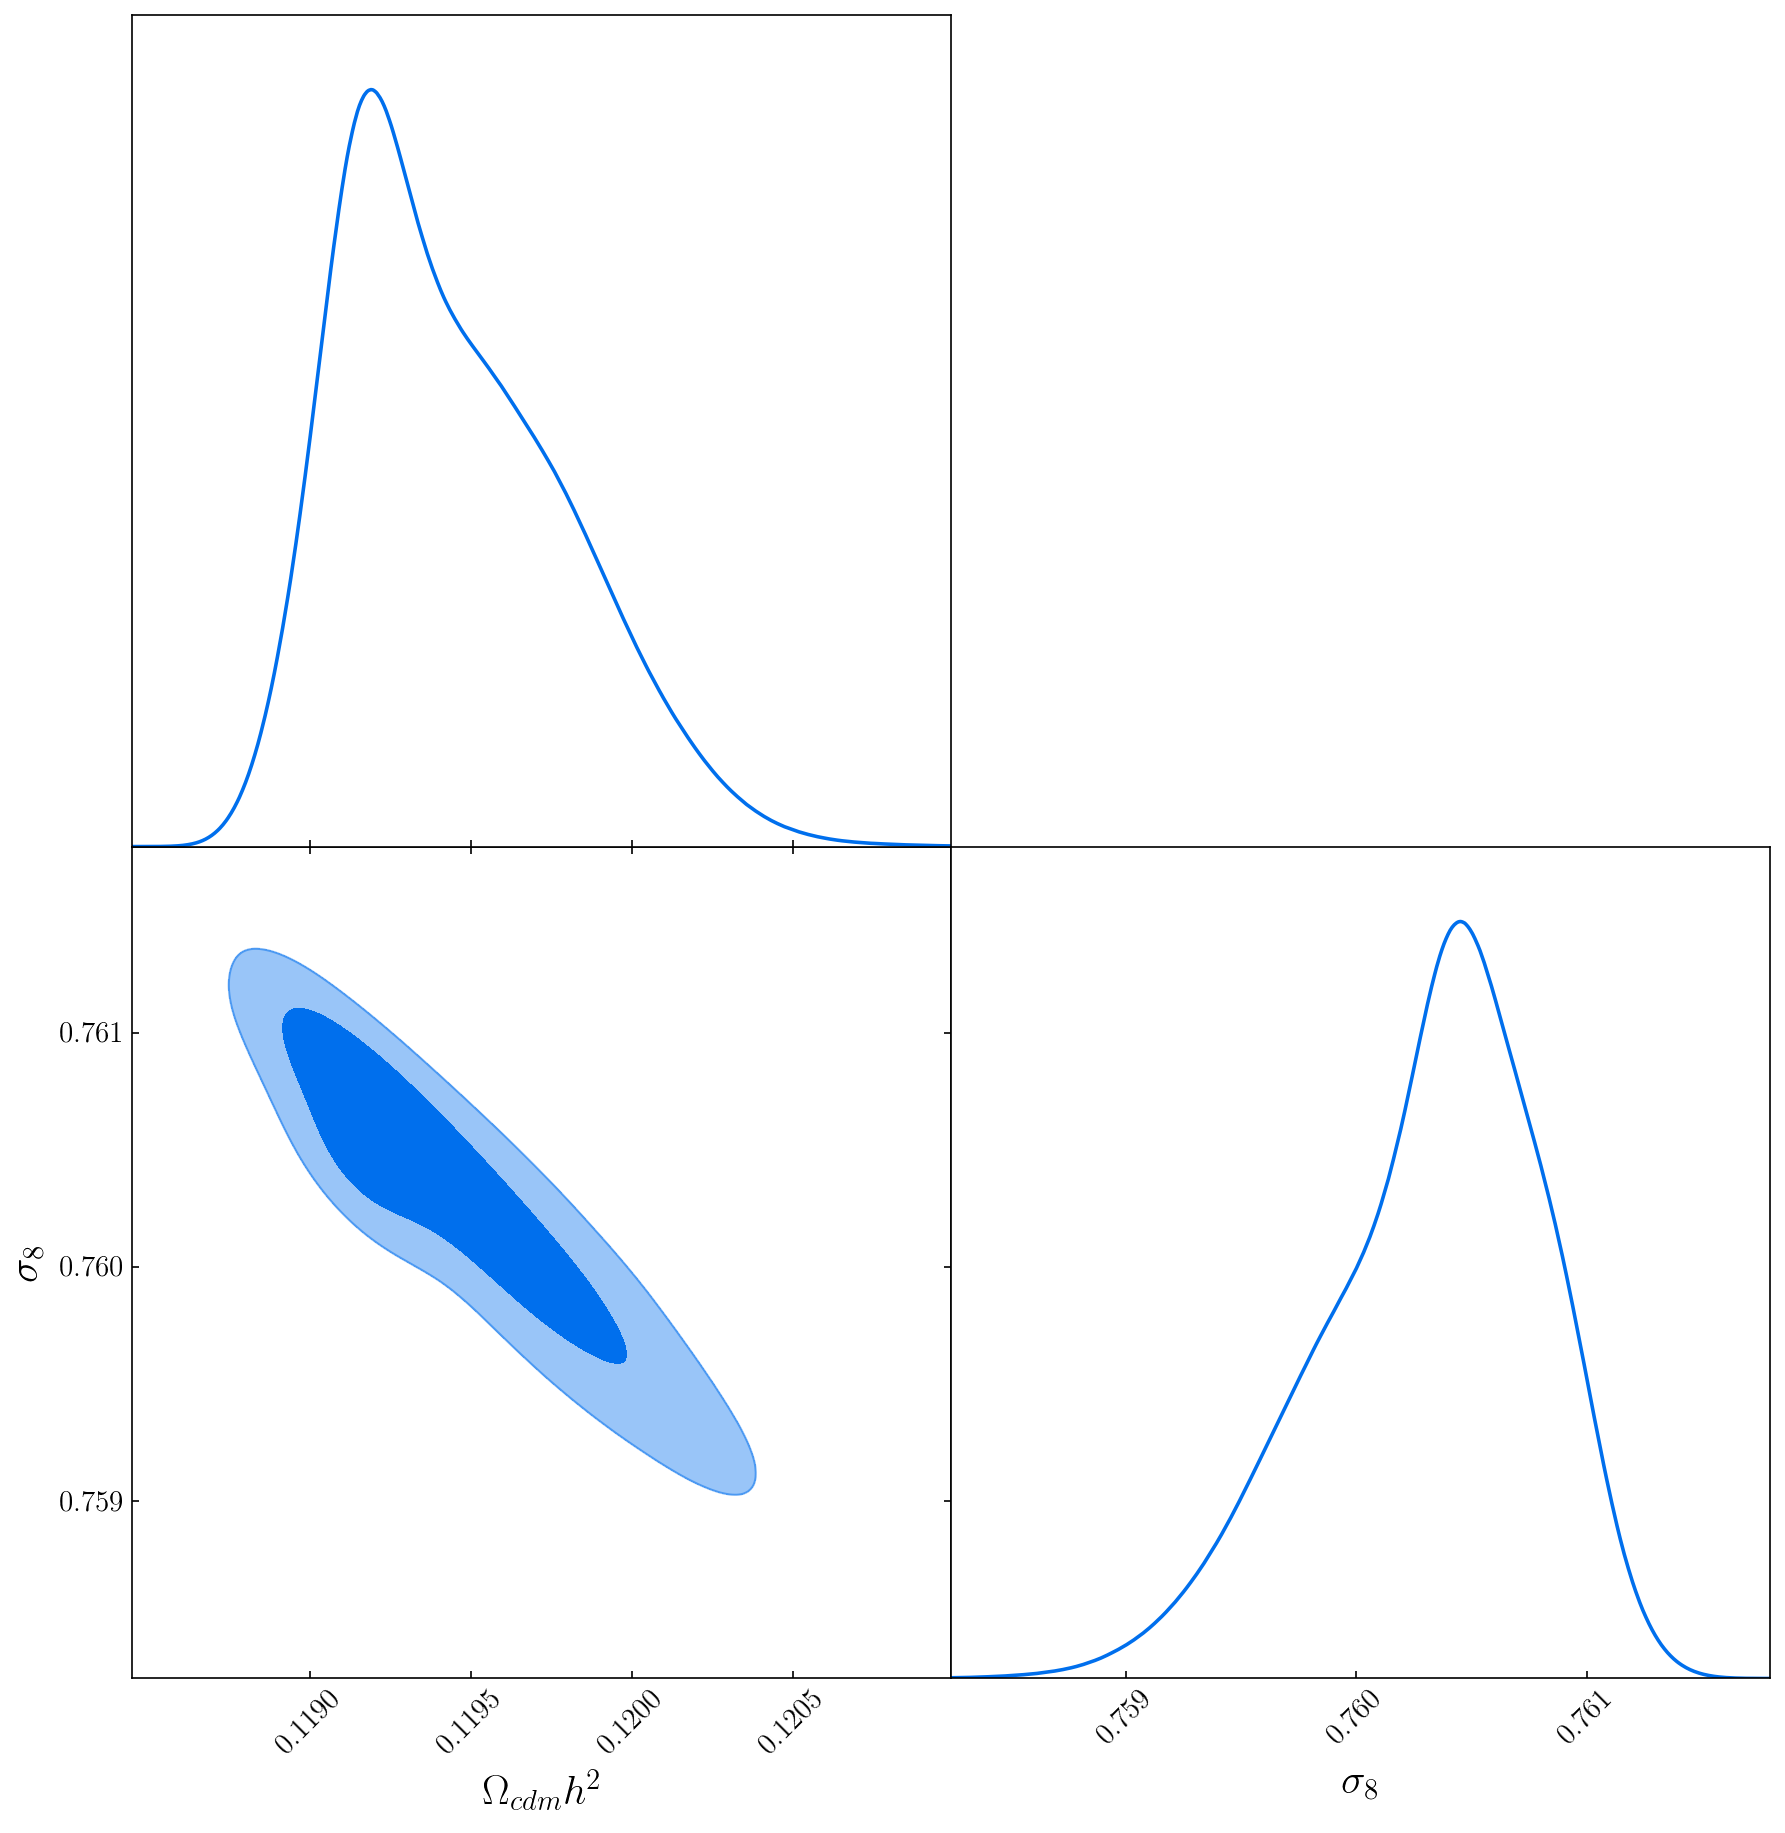

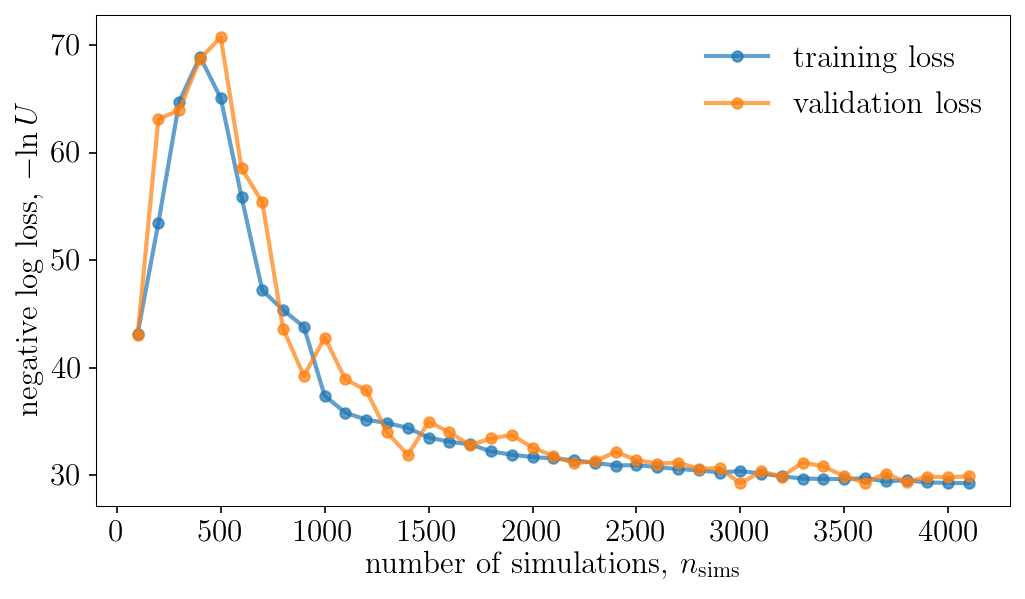

11896.180233175


In [33]:
t1 = time.process_time()
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)
t2 = time.process_time()
print(t2-t1)

## Sample the learned posterior

In [34]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), 
                                                       p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)



## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [35]:
DelfiEnsemble.results_dir

'simulators/mass_function_n_counts/results_fiducial_fisher_trial_for_mocks/'

Removed no burn in


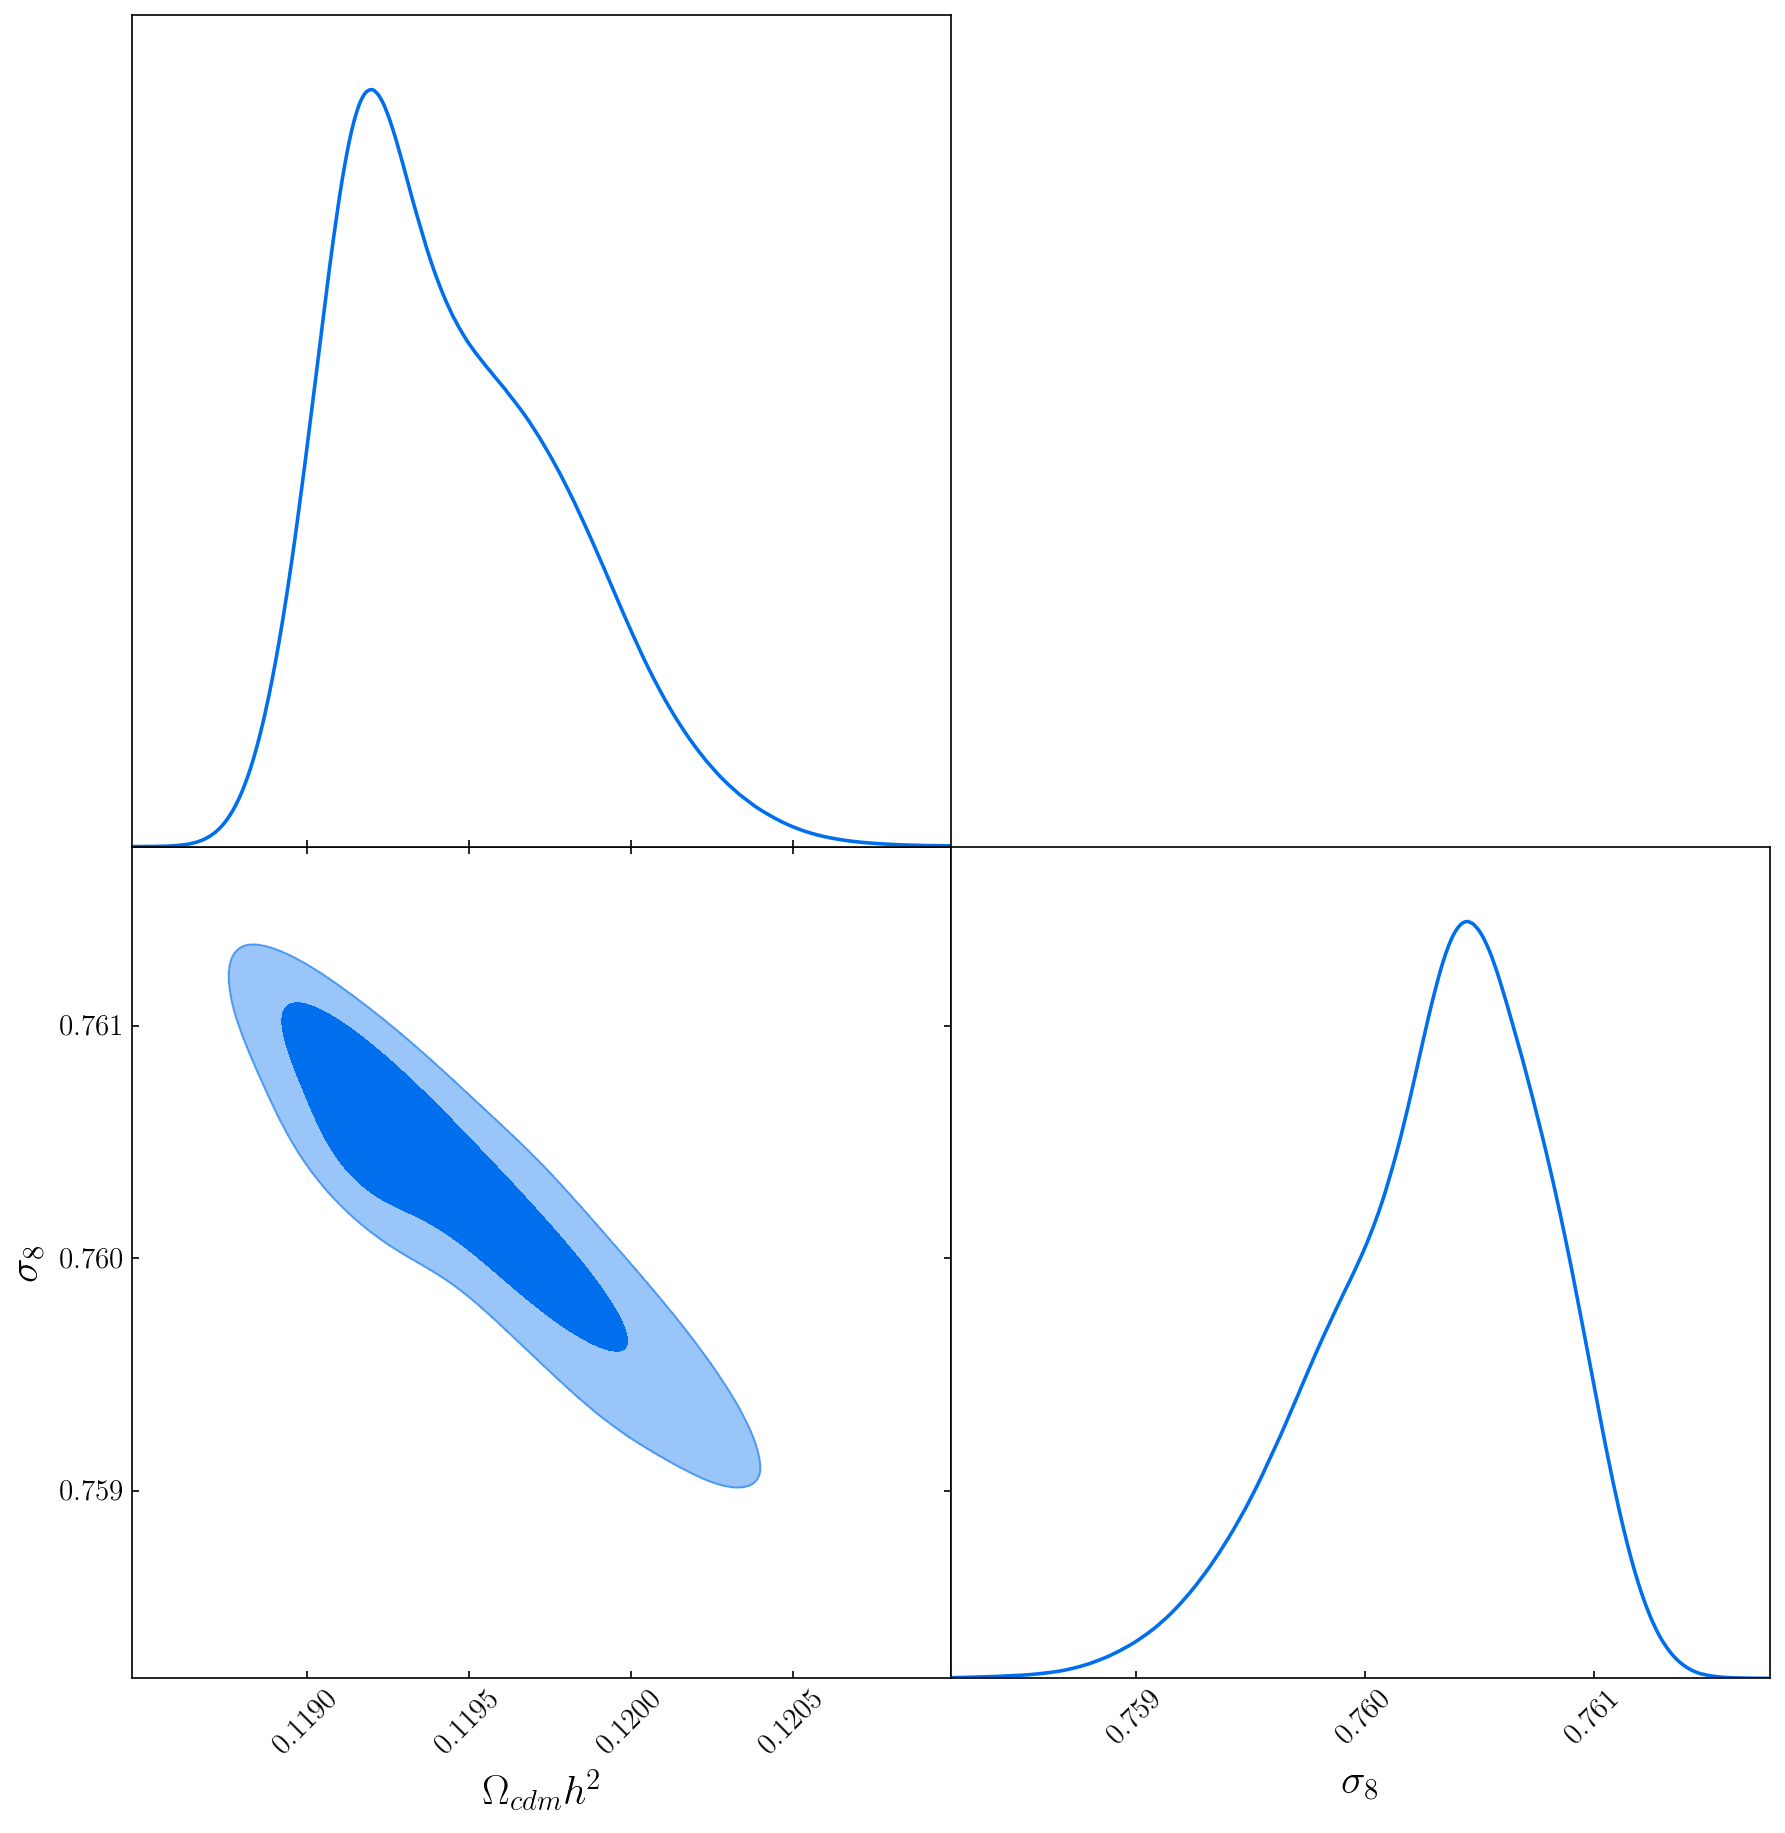

In [36]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [37]:
np.savetxt(DelfiEnsemble.results_dir+'posterior_samples.npy', posterior_samples)
np.savetxt(DelfiEnsemble.results_dir+'posterior_weights.npy', posterior_weights)

In [38]:
DelfiEnsemble.results_dir

'simulators/mass_function_n_counts/results_fiducial_fisher_trial_for_mocks/'

In [39]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [40]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples, posterior_weights)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197 0.76  ]
[0.1194479 0.7603123]
[0.0003592  0.00048842]


In [41]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')


Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11872949396917837, 0.12016630198398684 ]
On \sigma_8: [0.759335466925017, 0.7612891317512416 ]


In [28]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), 
                                                       p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble.nwalkers),:]


In [37]:
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0, burn_in_chain=3000, main_chain=30000)



Removed no burn in


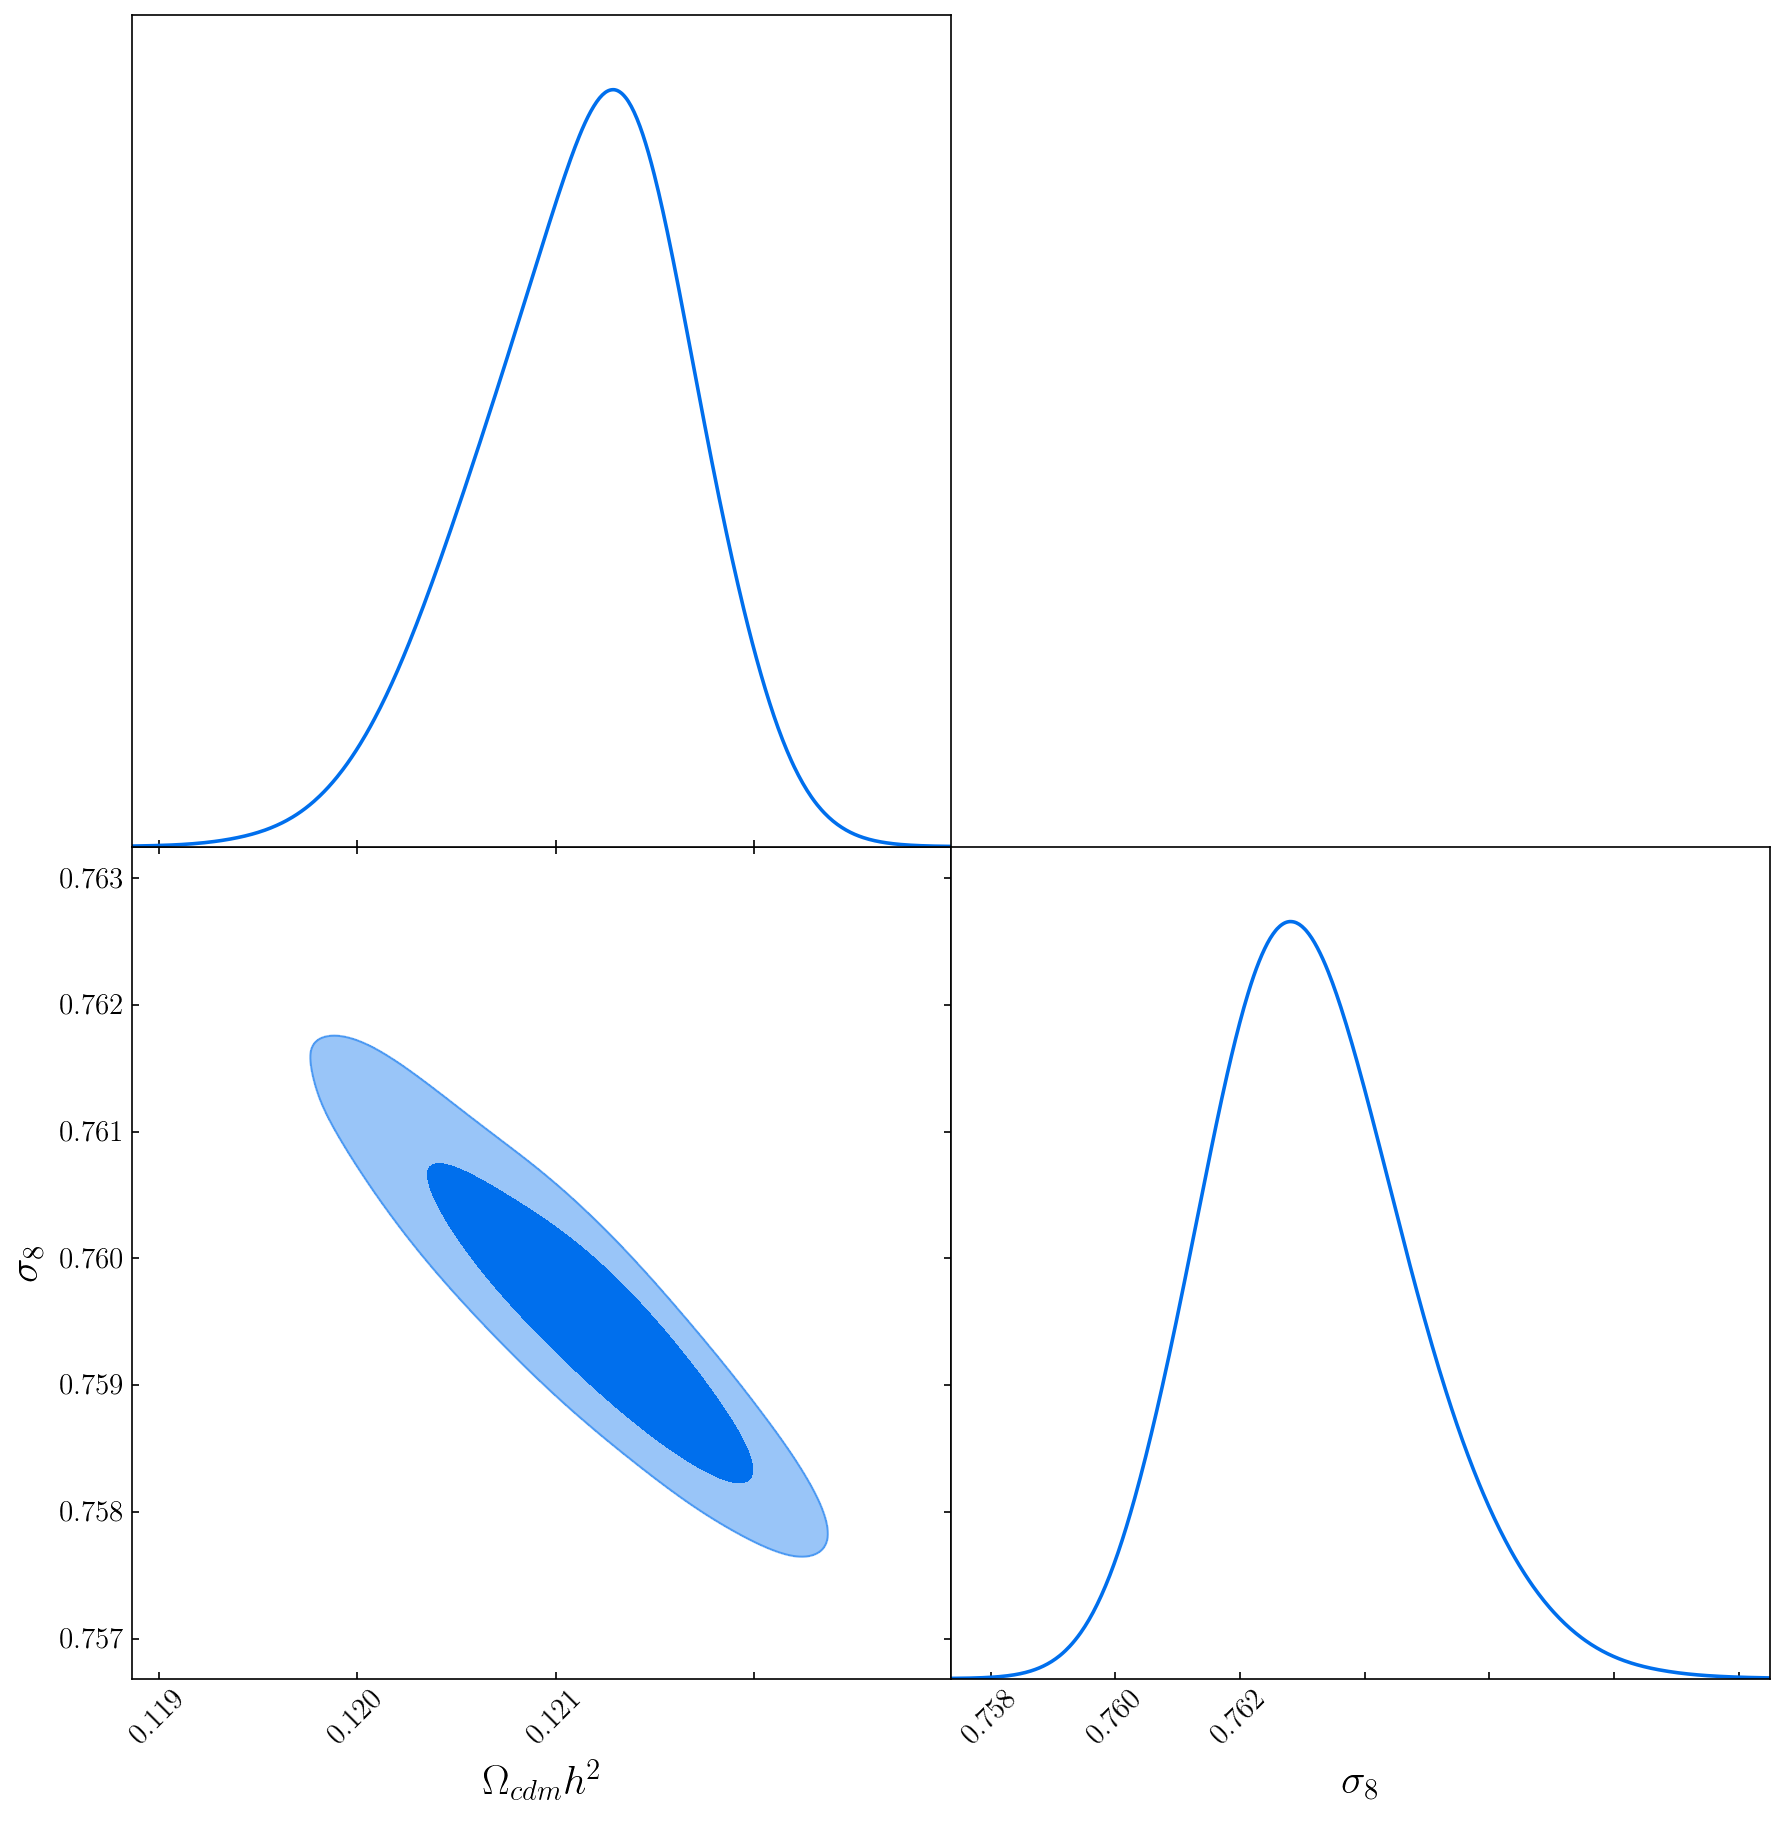

In [38]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [39]:
np.savetxt(DelfiEnsemble.results_dir+'posterior_samples.npy', posterior_samples)
np.savetxt(DelfiEnsemble.results_dir+'posterior_weights.npy', posterior_weights)

In [40]:
DelfiEnsemble.results_dir

'simulators/mass_function_n_counts/results_fiducial_15000sims_3NDEs/'

In [41]:
len(posterior_weights)

2140099

In [35]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples, posterior_weights)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197 0.76  ]
[0.1201327  0.75956706]
[0.00054099 0.00084587]


In [36]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')


Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11905072079915374, 0.12121467283359233 ]
On \sigma_8: [0.7578753176911001, 0.7612587966037848 ]
